In [1]:
!pip install wandb -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
import wandb

### Preprocess the data

In [ ]:
df = pd.read_csv("dataset_cifar10_v1.csv") # loading the dataset to pandas df

In [ ]:
map = {"A":1.0,"B":2.0,"C":3.0,"D":4.0} # mapping the conv block type to numerical values

In [ ]:
for column, dtype in df.dtypes.items(): # applying the mapping to the column and also converting to float32
    if dtype == 'object':
        df[column] = df[column].replace(map).astype('float32')

df = df.astype({col: 'float32' for col in df.select_dtypes('int64').columns})

In [ ]:
df.head()

In [ ]:
# mapping to assign labels to architecture data based on 1 day accuracy
intervals_mapping = {
    (0.6, 0.65): 0,
    (0.65, 0.7): 1,
    (0.7, 0.75): 2,
    (0.75, 0.8): 3,
    (0.8, 0.85): 4,
    (0.85, 0.9): 5,
    (0.9, 0.95): 6,
}

In [ ]:
def map_accuracy_to_value(accuracy):
    for interval, value in intervals_mapping.items():
        if interval[0] <= accuracy <= interval[1]:
            return value
    return None  # Returns None if the accuracy doesn't fall within any defined intervals

df['accuracy_mapped'] = df['1_day_accuracy'].apply(map_accuracy_to_value)

### Grouping the data based on 1 day accuracy for visualization (not required to run during training)

In [ ]:
df['accuracy_bin'] = pd.cut(df['1_day_accuracy'], bins=np.arange(df['1_day_accuracy'].min(),df['1_day_accuracy'].max()+0.02,0.05),right=True)
grouped_df = df.groupby('accuracy_bin')

In [ ]:
df['1_day_accuracy'].min(),df['1_day_accuracy'].max()

(0.6000988501169846, 0.9399111190594944)

In [ ]:
np.arange(df['1_day_accuracy'].min(),df['1_day_accuracy'].max()+0.02,0.05)

array([0.60009885, 0.65009885, 0.70009885, 0.75009885, 0.80009885,
       0.85009885, 0.90009885, 0.95009885])

In [ ]:
for name, group in grouped_df:
    print(f'Group: {name}')
    print(len(group))

Group: (0.6, 0.65]
76
Group: (0.65, 0.7]
91
Group: (0.7, 0.75]
68
Group: (0.75, 0.8]
59
Group: (0.8, 0.85]
59
Group: (0.85, 0.9]
61
Group: (0.9, 0.95]
785


In [ ]:
group = grouped_df.get_group(pd.Interval(left=0.9, right=0.95, closed='right'))
group.iloc[200:250,-4]

In [ ]:
np.unique(df['accuracy_mapped'],return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7]), array([ 77,  91,  67,  60,  58,  58, 789]))

### -------------------------------- Run below

In [ ]:
data = df.iloc[:,:-4]
data.head()

,out_channel0,M,R1,R2,R3,R4,R5,convblock1,widenfact1,B1,...,B2,convblock3,widenfact3,B3,convblock4,widenfact4,B4,convblock5,widenfact5,B5
0,117.0,1.0,9.0,0.0,0.0,0.0,0.0,2.0,4.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,122.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32.0,3.0,3.0,1.0,7.0,0.0,0.0,2.0,2.0,5.0,...,9.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.0,3.0,8.0,4.0,11.0,0.0,0.0,4.0,1.0,12.0,...,6.0,4.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
labels = df.iloc[:,-1]
labels.head()

0    6
1    6
2    5
3    1
4    5
Name: accuracy_mapped, dtype: int64

### Run below cells if one hot encoding is needed (not used for training currently)

In [ ]:
data = data.drop(['convblock1','convblock2','convblock3','convblock4','convblock5'],axis=1)

In [ ]:
data = pd.get_dummies(data,columns=['convblock1','convblock2','convblock3','convblock4','convblock5'])
data.head()

,out_channel0,M,R1,R2,R3,R4,R5,widenfact1,B1,widenfact2,...,convblock4_0.0,convblock4_1.0,convblock4_2.0,convblock4_3.0,convblock4_4.0,convblock5_0.0,convblock5_1.0,convblock5_2.0,convblock5_3.0,convblock5_4.0
0,117.0,1.0,9.0,0.0,0.0,0.0,0.0,4.0,11.0,0.0,...,1,0,0,0,0,1,0,0,0,0
1,122.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,...,1,0,0,0,0,1,0,0,0,0
2,102.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,...,1,0,0,0,0,1,0,0,0,0
3,32.0,3.0,3.0,1.0,7.0,0.0,0.0,2.0,5.0,3.0,...,1,0,0,0,0,1,0,0,0,0
4,38.0,3.0,8.0,4.0,11.0,0.0,0.0,1.0,12.0,1.0,...,1,0,0,0,0,1,0,0,0,0


### Min max scaler for normalization (not used for training currently)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[data.columns[:17]] = scaler.fit_transform(data[data.columns[:17]])

In [ ]:
data

,out_channel0,M,R1,R2,R3,R4,R5,convblock1,widenfact1,B1,...,widenfact2,B2,convblock3,widenfact3,B3,convblock4,widenfact4,B4,convblock5,widenfact5
0,0.908333,0.00,0.533333,0.0000,0.0000,0.000,0.0000,0.333333,1.000000,0.909091,...,0.00,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.950000,0.00,0.133333,0.0000,0.0000,0.000,0.0000,1.000000,1.000000,0.090909,...,0.00,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.783333,0.00,0.000000,0.0000,0.0000,0.000,0.0000,0.666667,0.000000,0.727273,...,0.00,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.200000,0.50,0.133333,0.0625,0.4375,0.000,0.0000,0.333333,0.333333,0.363636,...,0.75,0.750000,0.75,0.25,0.083333,0.0,0.0,0.0,0.0,0.0
4,0.250000,0.50,0.466667,0.2500,0.6875,0.000,0.0000,1.000000,0.000000,1.000000,...,0.25,0.500000,1.00,0.75,0.750000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.158333,0.50,0.600000,0.6875,0.5625,0.000,0.0000,0.333333,0.000000,0.000000,...,1.00,0.583333,0.75,0.75,0.583333,0.0,0.0,0.0,0.0,0.0
1196,0.375000,0.25,0.866667,1.0000,0.0000,0.000,0.0000,0.000000,0.000000,0.363636,...,0.75,0.333333,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
1197,0.383333,0.00,0.133333,0.0000,0.0000,0.000,0.0000,0.000000,1.000000,0.909091,...,0.00,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
1198,0.333333,1.00,0.200000,0.8125,1.0000,0.875,0.6875,0.666667,1.000000,0.181818,...,1.00,1.000000,0.75,0.75,0.583333,0.5,1.0,12.0,2.0,4.0


### Converting df to tensors

In [ ]:
data = torch.tensor(data[data.columns].values,dtype=torch.float32)
labels = torch.tensor(labels.values,dtype=torch.int64)

In [ ]:
data.shape, labels.shape

(torch.Size([1200, 22]), torch.Size([1200]))

In [ ]:
labels

tensor([6, 6, 5,  ..., 6, 6, 2])

### Normlizing the tensors to have mean 0 and std 1 (not used for training currently)

In [ ]:
data = (data - torch.mean(data,dim=0))/torch.std(data,dim=0)

In [ ]:
data.std(dim=0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])

### initializing the device

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [ ]:
device

'cuda'

### Dataset definition

In [ ]:
class VQVAE_Dataset(Dataset):
  def __init__(self,data,labels):
    self.data = data
    self.labels = labels

  def __getitem__(self,idx):
    return self.data[idx],self.labels[idx]

  def __len__(self):
    return len(self.data)

### Model definition

In [ ]:
class Encoder(nn.Module):
  def __init__(self,inp_dim,embed_dim=10,h_nodes=128,dropout=0.2,scale=2,num_layers=1):
    super(Encoder,self).__init__()
    self.inp_dim = inp_dim
    self.embed_dim = embed_dim
    self.tanh = nn.Tanh()
    self.dropout = nn.Dropout(dropout)
    self.scale = scale
    self.num_layers = num_layers
    self.h_nodes = h_nodes
    self.relu = nn.ReLU()
    self.layers = nn.ModuleList([nn.Sequential(
                                      nn.Linear(h_nodes//(scale**i),h_nodes//(scale**(i+1))),
                                      nn.ReLU(inplace=True),
                                      # nn.Dropout(dropout)
                                  )
                                  for i in range(num_layers)])
    self.fc1 = nn.Linear(self.inp_dim,h_nodes)
    self.fc2 = nn.Linear(h_nodes//(scale**(num_layers)),self.embed_dim)

  def forward(self,x):
    x = self.relu(self.fc1(x))
    for layer in self.layers:
      x = layer(x)
    x = self.fc2(x)
    # x = self.tanh(x)
    return x

class Decoder(nn.Module):
  def __init__(self,out_dim,embed_dim=10,h_nodes=128,dropout=0.2,scale=2,num_layers=1):
    super(Decoder,self).__init__()
    self.out_dim = out_dim
    self.embed_dim = embed_dim
    self.h_nodes = h_nodes
    self.scale = scale
    self.num_layers = num_layers
    self.fc1 = nn.Linear(self.embed_dim,h_nodes)
    self.layers = nn.ModuleList([nn.Sequential(
                                      nn.Linear(h_nodes//(scale**i),h_nodes//(scale**(i+1))),
                                      nn.ReLU(inplace=True),
                                      # nn.Dropout(dropout)
                                  )
                                  for i in range(num_layers)])
    self.fc2 = nn.Linear(h_nodes//scale**(num_layers),self.out_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.relu(self.fc1(x))
    for layer in self.layers:
      x = layer(x)
    x = self.fc2(x)
    x = self.relu(x)
    return x

class VectorQuantizer(nn.Module):
  def __init__(self,num_embeddings=50,embedding_dim=10,commitment_cost=0.25):
    super(VectorQuantizer,self).__init__()
    self.num_embeddings = num_embeddings
    self.embed_dim = embedding_dim
    self.embeddings = nn.Embedding(self.num_embeddings,self.embed_dim)
    self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost

  def forward(self,x):
    # x: [B,D]
    # embeddings: [num_embeddings, embed_dim]

    latent_vectors = x.unsqueeze(1) # [B,D] -> [B,1,D]
    codebook_vectors = self.embeddings.weight.unsqueeze(0) # [num_embeddings, embed_dim] -> [1,num_embeddings, embed_dim]
    distances = torch.norm(latent_vectors - codebook_vectors, dim=2) # [B,num_embeddings]
    closest_indices = torch.argmin(distances,dim=1).unsqueeze(1)

    # making a one hot encoder of the closest codebook chosen for perplexity calculation [B,num_embeddings]
    encodings = torch.zeros(closest_indices.shape[0], self.num_embeddings, device=x.device)
    encodings.scatter_(1,closest_indices,1)

    quantized = self.embeddings(closest_indices).squeeze(1)

    e_latent_loss = F.mse_loss(quantized.detach(), x)
    q_latent_loss = F.mse_loss(quantized, x.detach())
    loss = q_latent_loss + self.commitment_cost * e_latent_loss

    # to copy gradients from decoder to encoder
    quantized = x + (quantized - x).detach()

    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    return loss, quantized, perplexity, closest_indices

class VectorQuantizerClass(nn.Module):
  def __init__(self,num_embeddings=50,embedding_dim=10,commitment_cost=0.25,_divergence_cost=0.1):
    super(VectorQuantizerClass,self).__init__()
    self.num_embeddings = num_embeddings
    self.embed_dim = embedding_dim
    self.embeddings = nn.Embedding(self.num_embeddings,self.embed_dim)
    self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost
    self.divergence_cost = divergence_cost

  def forward(self,x,y):
    # x: [B,D]
    # embeddings: [num_embeddings, embed_dim]

    latent_vectors = x.unsqueeze(1) # [B,D] -> [B,1,D]
    codebook_vectors = self.embeddings.weight.unsqueeze(0) # [num_embeddings, embed_dim] -> [1,num_embeddings, embed_dim]
    distances = torch.norm(latent_vectors - codebook_vectors, dim=2) # [B,num_embeddings]

    encoding_indices = torch.reshape(y,(y.shape[0], 1))
    encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings).to(device)
    encodings.scatter_(1, encoding_indices, 1)

    close_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    close_encodings = torch.zeros(close_indices.shape[0], self.num_embeddings).to(device)
    close_encodings.scatter_(1, close_indices, 1)

    indicator = 1 - (encoding_indices == close_indices).int()
    indicator = indicator.float()

    # Quantize
    quantized = torch.matmul(encodings, self.embeddings.weight)
    close_quantized = torch.matmul(close_encodings, self.embeddings.weight)

    # Loss
    q_latent_loss = torch.mean((quantized - x.detach())**2)
    e_latent_loss = torch.mean((quantized.detach() - x)**2)
    x_latent_loss = torch.mean(indicator * ((close_quantized - x.detach())**2))
    d_latent_loss = torch.mean(indicator * ((close_quantized.detach() - x)**2))
    loss = q_latent_loss + self.commitment_cost * e_latent_loss - x_latent_loss - self.divergence_cost * d_latent_loss

    # to copy gradients from decoder to encoder
    quantized = x + (quantized - x).detach()

    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    return loss, quantized, perplexity, close_indices


### Normal VQ VAE (trained using no label data)

In [ ]:
class VQVAE(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,commitment_cost=0.25,h_nodes=128,scale=2,num_layers=1):
    super(VQVAE,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers)
    self.quantizer = VectorQuantizer(num_embeddings,embed_dim,commitment_cost)
    self.decoder = Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers)

  def forward(self,x):
    z = self.encoder(x)
    loss, quantized_z, perplexity, close_indices = self.quantizer(z)
    x_recon = self.decoder(quantized_z)
    return loss, x_recon, perplexity, close_indices


### Supervised VQ VAE (trained using the label data)

In [ ]:
class SVQVAE(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,commitment_cost=0.25,divergence_cost=0.1,h_nodes=128,scale=2,num_layers=1):
    super(SVQVAE,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers)
    self.quantizer = VectorQuantizerClass(num_embeddings,embed_dim,commitment_cost,divergence_cost)
    self.decoder = Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers)

  def forward(self,x,y):
    z = self.encoder(x)
    loss, quantized_z, perplexity, close_indices = self.quantizer(z,y)
    x_recon = self.decoder(quantized_z)
    return loss, x_recon, perplexity, close_indices

### Training setup

In [ ]:
dataset = VQVAE_Dataset(data,labels) # dataset init

In [ ]:
# hyperparameters (TODO: tuning)
x_dim = data.shape[1]
h_nodes = 128
scale = 2
num_layers = 3
embed_dim = 10
dropout = 0.2
num_embeddings = 50
commitment_cost = 0.25
divergence_cost = 0.1
epochs = 1000
learning_rate = 1e-4
weight_decay = 1e-3
batch_size = 16

### Grid search

In [ ]:
import itertools

hyperparameters = {
    'embed_dim': [15, 20, 25, 30],
    'num_embeddings': [50, 100, 150, 200],
    'commitment_cost': [0.25, 0.3, 0.35, 0.4, 0.45,0.5],
}

def train_and_evaluate(hyperparam_config):
    model = VQVAE(x_dim, hyperparam_config['embed_dim'], dropout=dropout,
                  num_embeddings=hyperparam_config['num_embeddings'],
                  commitment_cost=hyperparam_config['commitment_cost'],
                  h_nodes=h_nodes, scale=scale,
                  num_layers=num_layers).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)

    model.train()
    val_loss = 0
    for epoch in tqdm(range(epochs)):

      for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
        batch = batch.to(device)
        optimizer.zero_grad()

        noise = torch.rand(batch.size()).to(device)
        vq_loss, data_recon, perplexity = model(batch + noise)
        recon_error = F.mse_loss(data_recon, batch)
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
      if epoch == epochs-1:
        val_loss = loss.item()
        print(val_loss,perplexity.item())
        print(hyperparam_config)

    return val_loss

# Iterate over all combinations of hyperparameters
best_val_loss = float('inf')
best_hyperparams = None

for hyperparam_values in itertools.product(*hyperparameters.values()):
    hyperparam_config = dict(zip(hyperparameters.keys(), hyperparam_values))

    val_loss = train_and_evaluate(hyperparam_config)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = hyperparam_config

print("Best hyperparameters:", best_hyperparams)


### Wandb hyperparameter search

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'bayes'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        # 'values': ['adam', 'sgd']
        'values': 'adam'
        },
    'h_nodes': {
        'values': [512, 1024, 2048]
        },
    'num_layers': {
        'values': [4, 5, 6]
    },
    'embed_dim': {
        'values': [6, 8, 10, 14]
    },
    'num_embeddings': {
        # 'values': [25, 50, 75, 100]
        'values' : 7
    },
    'commitment_cost': {
        'values': [0.1,0.2,0.25,0.4,0.5]
    },
    'divergence_cost': {
        'values': [0.1,0.2,0.25,0.4,0.5]
    },
    'dropout': {
          'values': [0.1, 0.2, 0.3]
        },
    'epochs': {
          'value': 200
        },
    'learning_rate': {
          # a flat distribution between 0 and 0.1
          'distribution': 'uniform',
          'min': 1e-6,
          'max': 1e-3
        },
    'weight_decay': {
          # a flat distribution between 0 and 0.1
          'distribution': 'uniform',
          'min': 1e-6,
          'max': 1e-3
        },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      }
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'commitment_cost': {'values': [0.1, 0.2, 0.25, 0.4, 0.5]},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'embed_dim': {'values': [6, 8, 10, 14]},
                'epochs': {'value': 200},
                'h_nodes': {'values': [256, 512, 1024]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.001,
                                  'min': 1e-06},
                'num_embeddings': {'values': [25, 50, 75, 100]},
                'num_layers': {'values': [2, 3, 4, 5]},
                'optimizer': {'values': ['adam', 'sgd']},
                'weight_decay': {'distribution': 'uniform',
                                 'max': 0.001,
    

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="RL-NAS-Hyperparameter-tuning")

Create sweep with ID: wgr6e1nh
Sweep URL: https://wandb.ai/sb-nd/RL-NAS-Hyperparameter-tuning/sweeps/wgr6e1nh


In [ ]:
def build_optimizer(network, optimizer, learning_rate, weight_decay):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate, weight_decay=weight_decay)
    return optimizer

In [ ]:
def train(config=None):
  with wandb.init(config=config):
    config = wandb.config

    train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

    model = VQVAE(x_dim,config.embed_dim,dropout=config.dropout,num_embeddings=config.num_embeddings,
              commitment_cost=config.commitment_cost,h_nodes=config.h_nodes,scale=scale,
              num_layers=config.num_layers).to(device)

    optimizer = build_optimizer(model, config.optimizer, config.learning_rate, config.weight_decay)
    model.train()
    train_res_recon_error = []
    train_res_perplexity = []

    error = 0

    for epoch in tqdm(range(config.epochs)):

      for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
        batch_x,batch_y = batch
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        # noise = torch.rand(batch.size()).to(device)
        vq_loss, data_recon, perplexity = model(batch_x)
        recon_error = F.mse_loss(data_recon, batch_x)
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        error = recon_error.item()

      wandb.log({"loss": error, "epoch": epoch})

In [ ]:
wandb.agent(sweep_id, train, count=30)

wandb: Agent Starting Run: kzelqzo0 with config:
wandb: 	batch_size: 104
wandb: 	commitment_cost: 0.4
wandb: 	dropout: 0.1
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0004895376429627252
wandb: 	num_embeddings: 75
wandb: 	num_layers: 6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005406084528816868


100%|██████████| 200/200 [01:16<00:00,  2.62it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂
epoch,199
loss,58.51958


wandb: Agent Starting Run: k7owreju with config:
wandb: 	batch_size: 112
wandb: 	commitment_cost: 0.25
wandb: 	dropout: 0.3
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.000848357259882622
wandb: 	num_embeddings: 25
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0007815265300192411


100%|██████████| 200/200 [01:08<00:00,  2.90it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,199
loss,nan


wandb: Agent Starting Run: efmw0mo6 with config:
wandb: 	batch_size: 104
wandb: 	commitment_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.0006883073765184915
wandb: 	num_embeddings: 25
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0004919990879566296


100%|██████████| 200/200 [01:19<00:00,  2.51it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,199
loss,nan


wandb: Agent Starting Run: mvqlfvhv with config:
wandb: 	batch_size: 256
wandb: 	commitment_cost: 0.1
wandb: 	dropout: 0.1
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 9.27419983427897e-05
wandb: 	num_embeddings: 50
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.000573415590010699


100%|██████████| 200/200 [01:04<00:00,  3.08it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▆▆▅▅▆▅▅▇▇▇█▆▆▅▅▄▅▄▇▅▆▅▆▆█▆▃▇▆▇▆▆▅▆▅▂▂▁▁▁
epoch,199
loss,55.38322


wandb: Agent Starting Run: zk3vnj0b with config:
wandb: 	batch_size: 104
wandb: 	commitment_cost: 0.1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 5.461444183736256e-05
wandb: 	num_embeddings: 50
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.000934563696499107


100%|██████████| 200/200 [01:12<00:00,  2.76it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▆█▄▂▄▅▃▆▅▅▆▄▇▄▂▄▃▅▁▄▆▅▄█▃▃▅▅▃▇▆▅▅▃▄▆▅▅▅▃
epoch,199
loss,207.31294


wandb: Agent Starting Run: 0nhw5gvx with config:
wandb: 	batch_size: 216
wandb: 	commitment_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 1.2695488136471176e-05
wandb: 	num_embeddings: 75
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.00042978733842039983


100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▅▆▆▂▆▆▅▆▅▆▄▆▇▁▃▃▆▇▄▆▅█▆▇▅▄▄█▃▃▅▄▃▅▃▄▄▅▄▄
epoch,199
loss,245.65085


wandb: Agent Starting Run: jytwnrto with config:
wandb: 	batch_size: 104
wandb: 	commitment_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.00037724175024706294
wandb: 	num_embeddings: 75
wandb: 	num_layers: 6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.000367293632392893


100%|██████████| 200/200 [01:19<00:00,  2.52it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▅▅▃▁▂▄▅▆▃▇▃▁▃▄▄▄▇▃▆▄▅▆▃▆▃▇▆▇▄█▅▆▅▂▃▄▆▅▆▂
epoch,199
loss,54.65954


wandb: Agent Starting Run: usmw74yb with config:
wandb: 	batch_size: 104
wandb: 	commitment_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0002582663687318985
wandb: 	num_embeddings: 75
wandb: 	num_layers: 6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005915783750351644


100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▃▂▂▁▂▂▂▁▂▂▂▂▂▂▁▂▁▁▂▂▂▂▂▁
epoch,199
loss,54.54198


wandb: Agent Starting Run: 80ojtlp3 with config:
wandb: 	batch_size: 56
wandb: 	commitment_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0004193272143965777
wandb: 	num_embeddings: 100
wandb: 	num_layers: 6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0006205484671787982


100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▄▅▃▄▂▄▃▄▄▅▄▅▄▄▄▂▂▃▄▃▄▃▄▂▄▃▄▄▂▄▁▄▂▃▂▃▃
epoch,199
loss,74.85885


wandb: Agent Starting Run: a092iqae with config:
wandb: 	batch_size: 152
wandb: 	commitment_cost: 0.2
wandb: 	dropout: 0.1
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 4.638340313476192e-05
wandb: 	num_embeddings: 75
wandb: 	num_layers: 6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.000693582155021489


100%|██████████| 200/200 [01:16<00:00,  2.60it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▅▄▅█▇▇▆▇▄▄▆▄▃▆█▂▆▅▄▃▄▃▂▅▂▄▄▁▂▃▂▃▂▂▃▃▃▄▂▂
epoch,199
loss,122.91347


wandb: Agent Starting Run: 9fcz791u with config:
wandb: 	batch_size: 240
wandb: 	commitment_cost: 0.1
wandb: 	dropout: 0.1
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.00022775621109599257
wandb: 	num_embeddings: 50
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.00024470199516336946


100%|██████████| 200/200 [01:10<00:00,  2.85it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▂▁▂▂▁▂▂▁▂▁▁▂▂▂▁▂▂▁▂▁▁▂▂▁▁▂▁▁▁▁▂▂▁▂▁
epoch,199
loss,66.73529


wandb: Agent Starting Run: tehiffjy with config:
wandb: 	batch_size: 232
wandb: 	commitment_cost: 0.1
wandb: 	dropout: 0.1
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.00014774939297234398
wandb: 	num_embeddings: 50
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0002999746898744729


100%|██████████| 200/200 [01:06<00:00,  3.00it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁
epoch,199
loss,nan


wandb: Agent Starting Run: p73hado1 with config:
wandb: 	batch_size: 64
wandb: 	commitment_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0003693647853711447
wandb: 	num_embeddings: 50
wandb: 	num_layers: 6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0006621781870951733


100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▂▂▂▁▁▂▂▁▂▂▁▁▂▂▂▂▁▂▂▂▁▂▂▂▂▁▂▂▂▁▁▁▁▂▁
epoch,199
loss,62.81699


wandb: Agent Starting Run: z6i4v76y with config:
wandb: 	batch_size: 136
wandb: 	commitment_cost: 0.25
wandb: 	dropout: 0.2
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 8.899677745266006e-05
wandb: 	num_embeddings: 50
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.00025788134973783256


100%|██████████| 200/200 [01:11<00:00,  2.80it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▂▂▃▂▂▂▁▂▂▃▁▂▁▁▂▂▁▂▃▂▂▃▁▂▁▂▂▃▁▁▂▂▂▂▂
epoch,199
loss,85.86216


wandb: Agent Starting Run: vd5bjvjj with config:
wandb: 	batch_size: 56
wandb: 	commitment_cost: 0.5
wandb: 	dropout: 0.1
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0005364030433689563
wandb: 	num_embeddings: 75
wandb: 	num_layers: 6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.00036672278174498503


100%|██████████| 200/200 [01:17<00:00,  2.58it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▂▃▄█▃▅▄▅▂▄▃▄▃▅▂▃▃▅▂▃▅▅▅▄▄▃▂▆▄▄▄▃▃▅▂▁▃▃▂▅
epoch,199
loss,85.09764


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0wugr7y3 with config:
wandb: 	batch_size: 80
wandb: 	commitment_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.00043693473369774854
wandb: 	num_embeddings: 75
wandb: 	num_layers: 6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0003980215738469482


100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁
epoch,199
loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g7umm2pe with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.2
wandb: 	dropout: 0.1
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.000429692872193066
wandb: 	num_embeddings: 50
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.000628819556598485


100%|██████████| 200/200 [01:25<00:00,  2.34it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,199
loss,nan


wandb: Agent Starting Run: yuotb788 with config:
wandb: 	batch_size: 32
wandb: 	commitment_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0001574056902382925
wandb: 	num_embeddings: 25
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0006670701426259084


100%|██████████| 200/200 [01:08<00:00,  2.93it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁
epoch,199
loss,nan


wandb: Agent Starting Run: c35wj09d with config:
wandb: 	batch_size: 40
wandb: 	commitment_cost: 0.25
wandb: 	dropout: 0.1
wandb: 	embed_dim: 14
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 3.528680711536195e-05
wandb: 	num_embeddings: 25
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0004629023247985658


100%|██████████| 200/200 [01:08<00:00,  2.93it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▅▂▆▇▆▅▄▄▇▁▅▄▅▅▅▃▅█▆▄▆▃▃▇▇▅▄▅▆▁▄▆▄█▅▅▆▇█▅
epoch,199
loss,248.95114


wandb: Agent Starting Run: q6i8ud4k with config:
wandb: 	batch_size: 56
wandb: 	commitment_cost: 0.2
wandb: 	dropout: 0.1
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0009565621770197582
wandb: 	num_embeddings: 25
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0009068011087147842


100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂
epoch,199
loss,59.61399


wandb: Agent Starting Run: wqvq0n8b with config:
wandb: 	batch_size: 192
wandb: 	commitment_cost: 0.2
wandb: 	dropout: 0.1
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0004584196673509055
wandb: 	num_embeddings: 100
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0009460447089904084


100%|██████████| 200/200 [01:20<00:00,  2.47it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▂▁▁▁▂▂▂▃▂▁▁▃▁▁▂▂▃▃▄▁▁▂▂▂▁▃▃▃▁▁▂▁▂▂▁▂▁▃▂█
epoch,199
loss,219.27747


wandb: Agent Starting Run: eipwysx1 with config:
wandb: 	batch_size: 112
wandb: 	commitment_cost: 0.2
wandb: 	dropout: 0.1
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.00040416528858689494
wandb: 	num_embeddings: 100
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0006759555398844888


100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▂▃▄▃▂▃▃▅▃▂▂▂▁▁▂▃▃▃▃▃▃▁▆▄▃▄▄▄▅▄▄▃▄▅▃▅▅▅
epoch,199
loss,73.55314


wandb: Agent Starting Run: sqj4mnb2 with config:
wandb: 	batch_size: 184
wandb: 	commitment_cost: 0.5
wandb: 	dropout: 0.1
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.000920347291384008
wandb: 	num_embeddings: 50
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0007736527315551315


100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▄▄▃▃▇▆▂▄▂▃▂▂█▂▂▆▃▂▃▂▄▂▄▂▂▃▂▂▂▁▂▂▂▃▂▂▁▁▂▁
epoch,199
loss,12.04311


wandb: Agent Starting Run: j7vrqhvt with config:
wandb: 	batch_size: 160
wandb: 	commitment_cost: 0.2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 14
wandb: 	epochs: 200
wandb: 	h_nodes: 2048
wandb: 	learning_rate: 0.00035056776247925403
wandb: 	num_embeddings: 50
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.00023310599080508785


100%|██████████| 200/200 [01:37<00:00,  2.04it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▃▂▂▂▆▂▃▃▂▅▄▅▅▂▄▂▁▆▄▇▃▅▄▅█▅▄▆▁▁▄▅▆▅▅▂▂▄▇▁
epoch,199
loss,23.25508


wandb: Agent Starting Run: 2susf52o with config:
wandb: 	batch_size: 88
wandb: 	commitment_cost: 0.4
wandb: 	dropout: 0.1
wandb: 	embed_dim: 14
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0009017014175846997
wandb: 	num_embeddings: 50
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.000789026431452989


100%|██████████| 200/200 [01:17<00:00,  2.58it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▃▄▆▄▃▂█▃▅▂▂▂▂▂▂▅▃▃▂▅▄▂▂▁▂▂▂▂▇█▃▃▃▃▂▂▁▁▁▁
epoch,199
loss,16.5627


wandb: Agent Starting Run: atgi0iq5 with config:
wandb: 	batch_size: 200
wandb: 	commitment_cost: 0.4
wandb: 	dropout: 0.2
wandb: 	embed_dim: 14
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0006502249078867018
wandb: 	num_embeddings: 50
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.000751816127655044


100%|██████████| 200/200 [01:05<00:00,  3.03it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▄▅▃▅▃▅▂▅▄▄▄▆▅▆▆▃▄▃▃▃▅▄█▄▇▆▄▅▁▅▃▃▃▄▄▅█▆▆▆
epoch,199
loss,327.20499


wandb: Agent Starting Run: tt3nz6vl with config:
wandb: 	batch_size: 144
wandb: 	commitment_cost: 0.4
wandb: 	dropout: 0.3
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0007964524173343114
wandb: 	num_embeddings: 75
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0004262601947016972


100%|██████████| 200/200 [01:18<00:00,  2.54it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▇▆▇▄▄█▃▂▁▂▂▁▁▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
loss,12.74019


wandb: Agent Starting Run: jf1wmc3q with config:
wandb: 	batch_size: 168
wandb: 	commitment_cost: 0.5
wandb: 	dropout: 0.3
wandb: 	embed_dim: 6
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.00036311611866326343
wandb: 	num_embeddings: 100
wandb: 	num_layers: 6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0003505065388269418


100%|██████████| 200/200 [01:23<00:00,  2.39it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▂▂▂▁▁▁▂▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,199
loss,18.09371


wandb: Agent Starting Run: cwv2f5hp with config:
wandb: 	batch_size: 240
wandb: 	commitment_cost: 0.5
wandb: 	dropout: 0.2
wandb: 	embed_dim: 10
wandb: 	epochs: 200
wandb: 	h_nodes: 1024
wandb: 	learning_rate: 0.0004859368964052384
wandb: 	num_embeddings: 75
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005861380301862242


100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁
epoch,199
loss,nan


wandb: Agent Starting Run: iw613uz6 with config:
wandb: 	batch_size: 80
wandb: 	commitment_cost: 0.5
wandb: 	dropout: 0.1
wandb: 	embed_dim: 8
wandb: 	epochs: 200
wandb: 	h_nodes: 512
wandb: 	learning_rate: 0.0004216801606580555
wandb: 	num_embeddings: 100
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005235523525974017


100%|██████████| 200/200 [01:12<00:00,  2.77it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▄▃▃▂▄▆▃▅▄█▃▂▄▁▁▁▂▂▃▃▂▄█▄▃▂▅▃▅▆▂▂▂▂▃▂▂▂▂▂
epoch,199
loss,20.15593


### Training

In [ ]:
x_dim = data.shape[1]
h_nodes = 512
scale = 2
num_layers = 4
embed_dim = 6
dropout = 0.1
num_embeddings = 7
commitment_cost = 0.5
divergence_cost = 0.1
epochs = 1000
learning_rate = 0.0009203
weight_decay = 0.0007737
batch_size = 184

In [ ]:
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [ ]:
model = VQVAE(x_dim,embed_dim,dropout=dropout,num_embeddings=num_embeddings,
              commitment_cost=commitment_cost,h_nodes=h_nodes,scale=scale,
              num_layers=num_layers).to(device)

In [ ]:
model = SVQVAE(x_dim,embed_dim,dropout=dropout,num_embeddings=num_embeddings,
              commitment_cost=commitment_cost,divergence_cost=divergence_cost,h_nodes=h_nodes,scale=scale,
              num_layers=num_layers).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay, amsgrad=False)

In [ ]:
optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

In [ ]:
from torchsummary import summary
summary(Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers).to(device),(x_dim,))
summary(VectorQuantizer(num_embeddings,embed_dim,commitment_cost).to(device),(embed_dim,))
summary(Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers).to(device),(embed_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          11,776
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 32]           2,080
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 6]             198
Total params: 186,534
Trainable params: 186,534
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []
close_indices = None

for epoch in tqdm(range(epochs)):

  for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
    batch_x,batch_y = batch
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()

    # noise = torch.rand(batch.size()).to(device)
    vq_loss, data_recon, perplexity, close_indices = model(batch_x,batch_y)
    recon_error = F.mse_loss(data_recon, batch_x)
    loss = recon_error + vq_loss
    loss.backward()

    # # Gradient checking
    # print("Encoder gradients:")
    # for name, param in model.encoder.named_parameters():
    #     if param.grad is None:
    #         print(f"{name}: No grad")

    # print("\nDecoder gradients:")
    # for name, param in model.decoder.named_parameters():
    #     if param.grad is None:
    #         print(f"{name}: No grad")

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 2 == 0:
      print('%d iterations of epochs %d/%d' % (i+1,epoch + 1, epochs))
      print('Average recon_error: %.3f' % np.mean(train_res_recon_error[-10:]))
      print('Average perplexity: %.3f' % np.mean(train_res_perplexity[-10:]))
      print()


  0%|          | 3/1000 [00:00<00:46, 21.46it/s]

2 iterations of epochs 1/1000
Average recon_error: 285.898
Average perplexity: 3.284

4 iterations of epochs 1/1000
Average recon_error: 281.980
Average perplexity: 3.505

6 iterations of epochs 1/1000
Average recon_error: 280.433
Average perplexity: 3.451

2 iterations of epochs 2/1000
Average recon_error: 279.729
Average perplexity: 3.417

4 iterations of epochs 2/1000
Average recon_error: 278.299
Average perplexity: 3.415

6 iterations of epochs 2/1000
Average recon_error: 276.829
Average perplexity: 3.446

2 iterations of epochs 3/1000
Average recon_error: 280.133
Average perplexity: 3.494

4 iterations of epochs 3/1000
Average recon_error: 276.143
Average perplexity: 3.484

6 iterations of epochs 3/1000
Average recon_error: 276.562
Average perplexity: 3.576

2 iterations of epochs 4/1000
Average recon_error: 280.941
Average perplexity: 3.467

4 iterations of epochs 4/1000
Average recon_error: 281.679
Average perplexity: 3.397

6 iterations of epochs 4/1000
Average recon_error: 272

  1%|          | 6/1000 [00:00<00:47, 20.92it/s]

6 iterations of epochs 5/1000
Average recon_error: 252.760
Average perplexity: 3.491

2 iterations of epochs 6/1000
Average recon_error: 243.579
Average perplexity: 3.439

4 iterations of epochs 6/1000
Average recon_error: 228.461
Average perplexity: 3.433

6 iterations of epochs 6/1000
Average recon_error: 215.441
Average perplexity: 3.384

2 iterations of epochs 7/1000
Average recon_error: 199.182
Average perplexity: 3.397

4 iterations of epochs 7/1000
Average recon_error: 188.180
Average perplexity: 3.458

6 iterations of epochs 7/1000
Average recon_error: 173.548
Average perplexity: 3.502

2 iterations of epochs 8/1000
Average recon_error: 160.052
Average perplexity: 3.411

4 iterations of epochs 8/1000
Average recon_error: 150.956
Average perplexity: 3.386

6 iterations of epochs 8/1000
Average recon_error: 140.906
Average perplexity: 3.438

2 iterations of epochs 9/1000
Average recon_error: 127.456
Average perplexity: 3.390

4 iterations of epochs 9/1000
Average recon_error: 117

  1%|          | 12/1000 [00:00<00:47, 20.62it/s]

2 iterations of epochs 10/1000
Average recon_error: 98.026
Average perplexity: 3.524

4 iterations of epochs 10/1000
Average recon_error: 91.901
Average perplexity: 3.499

6 iterations of epochs 10/1000
Average recon_error: 86.040
Average perplexity: 3.455

2 iterations of epochs 11/1000
Average recon_error: 78.295
Average perplexity: 3.572

4 iterations of epochs 11/1000
Average recon_error: 74.857
Average perplexity: 3.496

6 iterations of epochs 11/1000
Average recon_error: 72.580
Average perplexity: 3.438

2 iterations of epochs 12/1000
Average recon_error: 69.794
Average perplexity: 3.510

4 iterations of epochs 12/1000
Average recon_error: 68.524
Average perplexity: 3.406

6 iterations of epochs 12/1000
Average recon_error: 67.622
Average perplexity: 3.370

2 iterations of epochs 13/1000
Average recon_error: 66.436
Average perplexity: 3.429

4 iterations of epochs 13/1000
Average recon_error: 66.627
Average perplexity: 3.416

6 iterations of epochs 13/1000
Average recon_error: 66

  2%|▏         | 15/1000 [00:00<00:54, 18.23it/s]

2 iterations of epochs 14/1000
Average recon_error: 66.790
Average perplexity: 3.430

4 iterations of epochs 14/1000
Average recon_error: 66.603
Average perplexity: 3.360

6 iterations of epochs 14/1000
Average recon_error: 67.500
Average perplexity: 3.393

2 iterations of epochs 15/1000
Average recon_error: 67.572
Average perplexity: 3.417

4 iterations of epochs 15/1000
Average recon_error: 67.736
Average perplexity: 3.462

6 iterations of epochs 15/1000
Average recon_error: 66.999
Average perplexity: 3.488

2 iterations of epochs 16/1000
Average recon_error: 66.568
Average perplexity: 3.555

4 iterations of epochs 16/1000
Average recon_error: 66.029
Average perplexity: 3.475

6 iterations of epochs 16/1000
Average recon_error: 66.339
Average perplexity: 3.428

2 iterations of epochs 17/1000
Average recon_error: 67.001
Average perplexity: 3.598



  2%|▏         | 19/1000 [00:01<00:57, 17.10it/s]

4 iterations of epochs 17/1000
Average recon_error: 66.806
Average perplexity: 3.528

6 iterations of epochs 17/1000
Average recon_error: 66.930
Average perplexity: 3.491

2 iterations of epochs 18/1000
Average recon_error: 66.198
Average perplexity: 3.571

4 iterations of epochs 18/1000
Average recon_error: 67.334
Average perplexity: 3.383

6 iterations of epochs 18/1000
Average recon_error: 66.974
Average perplexity: 3.438

2 iterations of epochs 19/1000
Average recon_error: 66.164
Average perplexity: 3.407

4 iterations of epochs 19/1000
Average recon_error: 67.063
Average perplexity: 3.447

6 iterations of epochs 19/1000
Average recon_error: 66.942
Average perplexity: 3.427

2 iterations of epochs 20/1000
Average recon_error: 66.988
Average perplexity: 3.399

4 iterations of epochs 20/1000
Average recon_error: 67.751
Average perplexity: 3.463



  2%|▏         | 23/1000 [00:01<00:59, 16.28it/s]

6 iterations of epochs 20/1000
Average recon_error: 68.550
Average perplexity: 3.443

2 iterations of epochs 21/1000
Average recon_error: 68.280
Average perplexity: 3.369

4 iterations of epochs 21/1000
Average recon_error: 68.232
Average perplexity: 3.448

6 iterations of epochs 21/1000
Average recon_error: 67.769
Average perplexity: 3.401

2 iterations of epochs 22/1000
Average recon_error: 68.271
Average perplexity: 3.377

4 iterations of epochs 22/1000
Average recon_error: 66.732
Average perplexity: 3.443

6 iterations of epochs 22/1000
Average recon_error: 66.641
Average perplexity: 3.422

2 iterations of epochs 23/1000
Average recon_error: 67.000
Average perplexity: 3.436

4 iterations of epochs 23/1000
Average recon_error: 66.969
Average perplexity: 3.485

6 iterations of epochs 23/1000
Average recon_error: 66.917
Average perplexity: 3.534



  2%|▎         | 25/1000 [00:01<01:00, 16.01it/s]

2 iterations of epochs 24/1000
Average recon_error: 67.602
Average perplexity: 3.582

4 iterations of epochs 24/1000
Average recon_error: 67.812
Average perplexity: 3.592

6 iterations of epochs 24/1000
Average recon_error: 66.919
Average perplexity: 3.521

2 iterations of epochs 25/1000
Average recon_error: 67.050
Average perplexity: 3.423

4 iterations of epochs 25/1000
Average recon_error: 66.384
Average perplexity: 3.349

6 iterations of epochs 25/1000
Average recon_error: 65.994
Average perplexity: 3.381

2 iterations of epochs 26/1000
Average recon_error: 67.135
Average perplexity: 3.409

4 iterations of epochs 26/1000
Average recon_error: 67.335
Average perplexity: 3.469

6 iterations of epochs 26/1000
Average recon_error: 66.951
Average perplexity: 3.488

2 iterations of epochs 27/1000
Average recon_error: 68.923
Average perplexity: 3.434



  3%|▎         | 29/1000 [00:01<00:59, 16.21it/s]

4 iterations of epochs 27/1000
Average recon_error: 67.802
Average perplexity: 3.404

6 iterations of epochs 27/1000
Average recon_error: 66.943
Average perplexity: 3.426

2 iterations of epochs 28/1000
Average recon_error: 67.874
Average perplexity: 3.390

4 iterations of epochs 28/1000
Average recon_error: 66.634
Average perplexity: 3.448

6 iterations of epochs 28/1000
Average recon_error: 66.641
Average perplexity: 3.487

2 iterations of epochs 29/1000
Average recon_error: 66.401
Average perplexity: 3.400

4 iterations of epochs 29/1000
Average recon_error: 66.145
Average perplexity: 3.412

6 iterations of epochs 29/1000
Average recon_error: 66.414
Average perplexity: 3.387

2 iterations of epochs 30/1000
Average recon_error: 66.377
Average perplexity: 3.353

4 iterations of epochs 30/1000
Average recon_error: 67.445
Average perplexity: 3.473

6 iterations of epochs 30/1000
Average recon_error: 67.278
Average perplexity: 3.479



  3%|▎         | 33/1000 [00:01<00:59, 16.17it/s]

2 iterations of epochs 31/1000
Average recon_error: 67.169
Average perplexity: 3.418

4 iterations of epochs 31/1000
Average recon_error: 66.856
Average perplexity: 3.394

6 iterations of epochs 31/1000
Average recon_error: 67.254
Average perplexity: 3.407

2 iterations of epochs 32/1000
Average recon_error: 68.016
Average perplexity: 3.532

4 iterations of epochs 32/1000
Average recon_error: 67.557
Average perplexity: 3.512

6 iterations of epochs 32/1000
Average recon_error: 66.942
Average perplexity: 3.521

2 iterations of epochs 33/1000
Average recon_error: 66.715
Average perplexity: 3.482

4 iterations of epochs 33/1000
Average recon_error: 66.539
Average perplexity: 3.387

6 iterations of epochs 33/1000
Average recon_error: 66.384
Average perplexity: 3.406

2 iterations of epochs 34/1000
Average recon_error: 66.387
Average perplexity: 3.423



  4%|▎         | 35/1000 [00:02<01:01, 15.81it/s]

4 iterations of epochs 34/1000
Average recon_error: 67.802
Average perplexity: 3.512

6 iterations of epochs 34/1000
Average recon_error: 67.176
Average perplexity: 3.518

2 iterations of epochs 35/1000
Average recon_error: 66.390
Average perplexity: 3.366

4 iterations of epochs 35/1000
Average recon_error: 66.391
Average perplexity: 3.502

6 iterations of epochs 35/1000
Average recon_error: 66.748
Average perplexity: 3.359

2 iterations of epochs 36/1000
Average recon_error: 66.297
Average perplexity: 3.434

4 iterations of epochs 36/1000
Average recon_error: 67.061
Average perplexity: 3.472

6 iterations of epochs 36/1000
Average recon_error: 67.684
Average perplexity: 3.486

2 iterations of epochs 37/1000
Average recon_error: 66.434
Average perplexity: 3.469

4 iterations of epochs 37/1000
Average recon_error: 66.352
Average perplexity: 3.421



  4%|▍         | 39/1000 [00:02<01:03, 15.18it/s]

6 iterations of epochs 37/1000
Average recon_error: 67.130
Average perplexity: 3.421

2 iterations of epochs 38/1000
Average recon_error: 66.987
Average perplexity: 3.422

4 iterations of epochs 38/1000
Average recon_error: 67.275
Average perplexity: 3.487

6 iterations of epochs 38/1000
Average recon_error: 69.188
Average perplexity: 3.457

2 iterations of epochs 39/1000
Average recon_error: 66.646
Average perplexity: 3.499

4 iterations of epochs 39/1000
Average recon_error: 66.966
Average perplexity: 3.427

6 iterations of epochs 39/1000
Average recon_error: 67.253
Average perplexity: 3.457

2 iterations of epochs 40/1000
Average recon_error: 67.224
Average perplexity: 3.432

4 iterations of epochs 40/1000
Average recon_error: 68.728
Average perplexity: 3.435



  4%|▍         | 41/1000 [00:02<01:05, 14.68it/s]

6 iterations of epochs 40/1000
Average recon_error: 69.131
Average perplexity: 3.433

2 iterations of epochs 41/1000
Average recon_error: 66.822
Average perplexity: 3.521

4 iterations of epochs 41/1000
Average recon_error: 65.266
Average perplexity: 3.509

6 iterations of epochs 41/1000
Average recon_error: 66.008
Average perplexity: 3.457

2 iterations of epochs 42/1000
Average recon_error: 65.293
Average perplexity: 3.443

4 iterations of epochs 42/1000
Average recon_error: 66.517
Average perplexity: 3.419

6 iterations of epochs 42/1000
Average recon_error: 67.156
Average perplexity: 3.441

2 iterations of epochs 43/1000
Average recon_error: 65.740
Average perplexity: 3.455



  4%|▍         | 45/1000 [00:02<01:04, 14.76it/s]

4 iterations of epochs 43/1000
Average recon_error: 66.806
Average perplexity: 3.463

6 iterations of epochs 43/1000
Average recon_error: 66.809
Average perplexity: 3.460

2 iterations of epochs 44/1000
Average recon_error: 66.526
Average perplexity: 3.520

4 iterations of epochs 44/1000
Average recon_error: 67.128
Average perplexity: 3.522

6 iterations of epochs 44/1000
Average recon_error: 66.689
Average perplexity: 3.508

2 iterations of epochs 45/1000
Average recon_error: 66.904
Average perplexity: 3.513

4 iterations of epochs 45/1000
Average recon_error: 67.371
Average perplexity: 3.438

6 iterations of epochs 45/1000
Average recon_error: 67.751
Average perplexity: 3.529

2 iterations of epochs 46/1000
Average recon_error: 67.727
Average perplexity: 3.540

4 iterations of epochs 46/1000
Average recon_error: 66.866
Average perplexity: 3.418

6 iterations of epochs 46/1000
Average recon_error: 66.646
Average perplexity: 3.458



  5%|▍         | 48/1000 [00:02<00:56, 16.73it/s]

2 iterations of epochs 47/1000
Average recon_error: 67.070
Average perplexity: 3.469

4 iterations of epochs 47/1000
Average recon_error: 66.298
Average perplexity: 3.483

6 iterations of epochs 47/1000
Average recon_error: 66.517
Average perplexity: 3.423

2 iterations of epochs 48/1000
Average recon_error: 66.615
Average perplexity: 3.455

4 iterations of epochs 48/1000
Average recon_error: 66.313
Average perplexity: 3.410

6 iterations of epochs 48/1000
Average recon_error: 66.844
Average perplexity: 3.468

2 iterations of epochs 49/1000
Average recon_error: 66.896
Average perplexity: 3.393

4 iterations of epochs 49/1000
Average recon_error: 67.339
Average perplexity: 3.410

6 iterations of epochs 49/1000
Average recon_error: 67.739
Average perplexity: 3.374

2 iterations of epochs 50/1000
Average recon_error: 68.220
Average perplexity: 3.456

4 iterations of epochs 50/1000
Average recon_error: 67.779
Average perplexity: 3.477

6 iterations of epochs 50/1000
Average recon_error: 68

  5%|▌         | 54/1000 [00:03<00:49, 19.04it/s]

6 iterations of epochs 51/1000
Average recon_error: 66.957
Average perplexity: 3.405

2 iterations of epochs 52/1000
Average recon_error: 66.348
Average perplexity: 3.422

4 iterations of epochs 52/1000
Average recon_error: 68.107
Average perplexity: 3.463

6 iterations of epochs 52/1000
Average recon_error: 67.650
Average perplexity: 3.485

2 iterations of epochs 53/1000
Average recon_error: 67.389
Average perplexity: 3.410

4 iterations of epochs 53/1000
Average recon_error: 67.984
Average perplexity: 3.441

6 iterations of epochs 53/1000
Average recon_error: 66.919
Average perplexity: 3.486

2 iterations of epochs 54/1000
Average recon_error: 66.674
Average perplexity: 3.446

4 iterations of epochs 54/1000
Average recon_error: 67.443
Average perplexity: 3.472

6 iterations of epochs 54/1000
Average recon_error: 67.294
Average perplexity: 3.498

2 iterations of epochs 55/1000
Average recon_error: 66.275
Average perplexity: 3.442

4 iterations of epochs 55/1000
Average recon_error: 65

  6%|▌         | 57/1000 [00:03<00:47, 19.72it/s]

2 iterations of epochs 56/1000
Average recon_error: 66.381
Average perplexity: 3.408

4 iterations of epochs 56/1000
Average recon_error: 66.981
Average perplexity: 3.428

6 iterations of epochs 56/1000
Average recon_error: 67.014
Average perplexity: 3.387

2 iterations of epochs 57/1000
Average recon_error: 66.963
Average perplexity: 3.357

4 iterations of epochs 57/1000
Average recon_error: 66.864
Average perplexity: 3.410

6 iterations of epochs 57/1000
Average recon_error: 67.595
Average perplexity: 3.416

2 iterations of epochs 58/1000
Average recon_error: 68.156
Average perplexity: 3.409

4 iterations of epochs 58/1000
Average recon_error: 67.100
Average perplexity: 3.442

6 iterations of epochs 58/1000
Average recon_error: 68.248
Average perplexity: 3.428

2 iterations of epochs 59/1000
Average recon_error: 67.385
Average perplexity: 3.505

4 iterations of epochs 59/1000
Average recon_error: 67.497
Average perplexity: 3.505

6 iterations of epochs 59/1000
Average recon_error: 67

  6%|▋         | 63/1000 [00:03<00:46, 20.15it/s]

4 iterations of epochs 60/1000
Average recon_error: 66.926
Average perplexity: 3.358

6 iterations of epochs 60/1000
Average recon_error: 66.628
Average perplexity: 3.420

2 iterations of epochs 61/1000
Average recon_error: 67.977
Average perplexity: 3.501

4 iterations of epochs 61/1000
Average recon_error: 68.806
Average perplexity: 3.514

6 iterations of epochs 61/1000
Average recon_error: 68.345
Average perplexity: 3.565

2 iterations of epochs 62/1000
Average recon_error: 68.269
Average perplexity: 3.544

4 iterations of epochs 62/1000
Average recon_error: 67.209
Average perplexity: 3.515

6 iterations of epochs 62/1000
Average recon_error: 66.823
Average perplexity: 3.513

2 iterations of epochs 63/1000
Average recon_error: 66.684
Average perplexity: 3.536

4 iterations of epochs 63/1000
Average recon_error: 67.119
Average perplexity: 3.440

6 iterations of epochs 63/1000
Average recon_error: 67.722
Average perplexity: 3.460

2 iterations of epochs 64/1000
Average recon_error: 67

  7%|▋         | 66/1000 [00:03<00:45, 20.50it/s]

6 iterations of epochs 64/1000
Average recon_error: 67.090
Average perplexity: 3.483

2 iterations of epochs 65/1000
Average recon_error: 66.820
Average perplexity: 3.462

4 iterations of epochs 65/1000
Average recon_error: 67.295
Average perplexity: 3.510

6 iterations of epochs 65/1000
Average recon_error: 66.338
Average perplexity: 3.422

2 iterations of epochs 66/1000
Average recon_error: 67.840
Average perplexity: 3.400

4 iterations of epochs 66/1000
Average recon_error: 67.929
Average perplexity: 3.466

6 iterations of epochs 66/1000
Average recon_error: 67.039
Average perplexity: 3.490

2 iterations of epochs 67/1000
Average recon_error: 68.462
Average perplexity: 3.498

4 iterations of epochs 67/1000
Average recon_error: 67.184
Average perplexity: 3.470

6 iterations of epochs 67/1000
Average recon_error: 67.261
Average perplexity: 3.442

2 iterations of epochs 68/1000
Average recon_error: 67.847
Average perplexity: 3.435

4 iterations of epochs 68/1000
Average recon_error: 67

  7%|▋         | 72/1000 [00:04<00:43, 21.20it/s]

4 iterations of epochs 69/1000
Average recon_error: 66.769
Average perplexity: 3.473

6 iterations of epochs 69/1000
Average recon_error: 65.920
Average perplexity: 3.587

2 iterations of epochs 70/1000
Average recon_error: 66.824
Average perplexity: 3.473

4 iterations of epochs 70/1000
Average recon_error: 67.331
Average perplexity: 3.381

6 iterations of epochs 70/1000
Average recon_error: 67.437
Average perplexity: 3.418

2 iterations of epochs 71/1000
Average recon_error: 67.031
Average perplexity: 3.411

4 iterations of epochs 71/1000
Average recon_error: 66.411
Average perplexity: 3.481

6 iterations of epochs 71/1000
Average recon_error: 65.777
Average perplexity: 3.503

2 iterations of epochs 72/1000
Average recon_error: 66.500
Average perplexity: 3.458

4 iterations of epochs 72/1000
Average recon_error: 66.938
Average perplexity: 3.465

6 iterations of epochs 72/1000
Average recon_error: 66.906
Average perplexity: 3.469

2 iterations of epochs 73/1000
Average recon_error: 66

  8%|▊         | 75/1000 [00:04<00:43, 21.12it/s]

2 iterations of epochs 74/1000
Average recon_error: 65.789
Average perplexity: 3.439

4 iterations of epochs 74/1000
Average recon_error: 66.329
Average perplexity: 3.475

6 iterations of epochs 74/1000
Average recon_error: 67.556
Average perplexity: 3.464

2 iterations of epochs 75/1000
Average recon_error: 66.662
Average perplexity: 3.465

4 iterations of epochs 75/1000
Average recon_error: 66.814
Average perplexity: 3.410

6 iterations of epochs 75/1000
Average recon_error: 67.133
Average perplexity: 3.461

2 iterations of epochs 76/1000
Average recon_error: 65.981
Average perplexity: 3.517

4 iterations of epochs 76/1000
Average recon_error: 65.597
Average perplexity: 3.526

6 iterations of epochs 76/1000
Average recon_error: 65.932
Average perplexity: 3.525

2 iterations of epochs 77/1000
Average recon_error: 66.507
Average perplexity: 3.455

4 iterations of epochs 77/1000
Average recon_error: 67.142
Average perplexity: 3.442

6 iterations of epochs 77/1000
Average recon_error: 66

  8%|▊         | 81/1000 [00:04<00:43, 21.04it/s]

6 iterations of epochs 78/1000
Average recon_error: 66.735
Average perplexity: 3.378

2 iterations of epochs 79/1000
Average recon_error: 66.755
Average perplexity: 3.345

4 iterations of epochs 79/1000
Average recon_error: 66.930
Average perplexity: 3.343

6 iterations of epochs 79/1000
Average recon_error: 68.230
Average perplexity: 3.341

2 iterations of epochs 80/1000
Average recon_error: 66.385
Average perplexity: 3.502

4 iterations of epochs 80/1000
Average recon_error: 66.553
Average perplexity: 3.495

6 iterations of epochs 80/1000
Average recon_error: 66.471
Average perplexity: 3.493

2 iterations of epochs 81/1000
Average recon_error: 66.354
Average perplexity: 3.561

4 iterations of epochs 81/1000
Average recon_error: 67.402
Average perplexity: 3.512

6 iterations of epochs 81/1000
Average recon_error: 66.319
Average perplexity: 3.499

2 iterations of epochs 82/1000
Average recon_error: 67.145
Average perplexity: 3.496

4 iterations of epochs 82/1000
Average recon_error: 66

  8%|▊         | 84/1000 [00:04<00:43, 21.22it/s]

2 iterations of epochs 83/1000
Average recon_error: 68.659
Average perplexity: 3.378

4 iterations of epochs 83/1000
Average recon_error: 66.803
Average perplexity: 3.385

6 iterations of epochs 83/1000
Average recon_error: 67.856
Average perplexity: 3.397

2 iterations of epochs 84/1000
Average recon_error: 67.473
Average perplexity: 3.403

4 iterations of epochs 84/1000
Average recon_error: 67.122
Average perplexity: 3.475

6 iterations of epochs 84/1000
Average recon_error: 67.248
Average perplexity: 3.540

2 iterations of epochs 85/1000
Average recon_error: 66.702
Average perplexity: 3.466

4 iterations of epochs 85/1000
Average recon_error: 66.161
Average perplexity: 3.442

6 iterations of epochs 85/1000
Average recon_error: 66.945
Average perplexity: 3.434

2 iterations of epochs 86/1000
Average recon_error: 68.014
Average perplexity: 3.478

4 iterations of epochs 86/1000
Average recon_error: 68.079
Average perplexity: 3.535

6 iterations of epochs 86/1000
Average recon_error: 69

  9%|▉         | 90/1000 [00:04<00:42, 21.50it/s]

6 iterations of epochs 87/1000
Average recon_error: 67.874
Average perplexity: 3.405

2 iterations of epochs 88/1000
Average recon_error: 66.511
Average perplexity: 3.408

4 iterations of epochs 88/1000
Average recon_error: 67.423
Average perplexity: 3.361

6 iterations of epochs 88/1000
Average recon_error: 68.210
Average perplexity: 3.433

2 iterations of epochs 89/1000
Average recon_error: 67.466
Average perplexity: 3.455

4 iterations of epochs 89/1000
Average recon_error: 67.761
Average perplexity: 3.535

6 iterations of epochs 89/1000
Average recon_error: 67.674
Average perplexity: 3.530

2 iterations of epochs 90/1000
Average recon_error: 66.679
Average perplexity: 3.418

4 iterations of epochs 90/1000
Average recon_error: 67.697
Average perplexity: 3.355

6 iterations of epochs 90/1000
Average recon_error: 67.508
Average perplexity: 3.393

2 iterations of epochs 91/1000
Average recon_error: 67.435
Average perplexity: 3.353

4 iterations of epochs 91/1000
Average recon_error: 67

  9%|▉         | 93/1000 [00:05<00:42, 21.19it/s]

2 iterations of epochs 92/1000
Average recon_error: 66.944
Average perplexity: 3.549

4 iterations of epochs 92/1000
Average recon_error: 66.428
Average perplexity: 3.535

6 iterations of epochs 92/1000
Average recon_error: 66.305
Average perplexity: 3.498

2 iterations of epochs 93/1000
Average recon_error: 66.170
Average perplexity: 3.425

4 iterations of epochs 93/1000
Average recon_error: 66.284
Average perplexity: 3.423

6 iterations of epochs 93/1000
Average recon_error: 66.731
Average perplexity: 3.437

2 iterations of epochs 94/1000
Average recon_error: 67.032
Average perplexity: 3.416

4 iterations of epochs 94/1000
Average recon_error: 66.564
Average perplexity: 3.441

6 iterations of epochs 94/1000
Average recon_error: 66.038
Average perplexity: 3.406

2 iterations of epochs 95/1000
Average recon_error: 66.459
Average perplexity: 3.406

4 iterations of epochs 95/1000
Average recon_error: 66.598
Average perplexity: 3.496

6 iterations of epochs 95/1000
Average recon_error: 67

 10%|▉         | 99/1000 [00:05<00:43, 20.89it/s]

6 iterations of epochs 96/1000
Average recon_error: 67.528
Average perplexity: 3.328

2 iterations of epochs 97/1000
Average recon_error: 65.781
Average perplexity: 3.506

4 iterations of epochs 97/1000
Average recon_error: 65.724
Average perplexity: 3.451

6 iterations of epochs 97/1000
Average recon_error: 66.562
Average perplexity: 3.494

2 iterations of epochs 98/1000
Average recon_error: 65.683
Average perplexity: 3.570

4 iterations of epochs 98/1000
Average recon_error: 66.288
Average perplexity: 3.408

6 iterations of epochs 98/1000
Average recon_error: 66.956
Average perplexity: 3.405

2 iterations of epochs 99/1000
Average recon_error: 65.873
Average perplexity: 3.557

4 iterations of epochs 99/1000
Average recon_error: 66.005
Average perplexity: 3.489

6 iterations of epochs 99/1000
Average recon_error: 66.575
Average perplexity: 3.516

2 iterations of epochs 100/1000
Average recon_error: 66.991
Average perplexity: 3.511

4 iterations of epochs 100/1000
Average recon_error: 

 10%|█         | 102/1000 [00:05<00:42, 21.03it/s]

2 iterations of epochs 101/1000
Average recon_error: 66.190
Average perplexity: 3.408

4 iterations of epochs 101/1000
Average recon_error: 65.521
Average perplexity: 3.471

6 iterations of epochs 101/1000
Average recon_error: 66.546
Average perplexity: 3.465

2 iterations of epochs 102/1000
Average recon_error: 66.911
Average perplexity: 3.487

4 iterations of epochs 102/1000
Average recon_error: 66.865
Average perplexity: 3.446

6 iterations of epochs 102/1000
Average recon_error: 67.809
Average perplexity: 3.421

2 iterations of epochs 103/1000
Average recon_error: 66.521
Average perplexity: 3.506

4 iterations of epochs 103/1000
Average recon_error: 66.735
Average perplexity: 3.574

6 iterations of epochs 103/1000
Average recon_error: 66.895
Average perplexity: 3.535

2 iterations of epochs 104/1000
Average recon_error: 65.464
Average perplexity: 3.607

4 iterations of epochs 104/1000
Average recon_error: 66.321
Average perplexity: 3.537

6 iterations of epochs 104/1000
Average rec

 11%|█         | 108/1000 [00:05<00:42, 21.14it/s]

6 iterations of epochs 105/1000
Average recon_error: 67.288
Average perplexity: 3.440

2 iterations of epochs 106/1000
Average recon_error: 67.510
Average perplexity: 3.399

4 iterations of epochs 106/1000
Average recon_error: 66.576
Average perplexity: 3.496

6 iterations of epochs 106/1000
Average recon_error: 66.456
Average perplexity: 3.412

2 iterations of epochs 107/1000
Average recon_error: 65.788
Average perplexity: 3.438

4 iterations of epochs 107/1000
Average recon_error: 66.148
Average perplexity: 3.450

6 iterations of epochs 107/1000
Average recon_error: 65.722
Average perplexity: 3.454

2 iterations of epochs 108/1000
Average recon_error: 66.159
Average perplexity: 3.392

4 iterations of epochs 108/1000
Average recon_error: 66.175
Average perplexity: 3.403

6 iterations of epochs 108/1000
Average recon_error: 66.627
Average perplexity: 3.401

2 iterations of epochs 109/1000
Average recon_error: 66.116
Average perplexity: 3.422

4 iterations of epochs 109/1000
Average rec

 11%|█         | 111/1000 [00:05<00:42, 21.12it/s]

2 iterations of epochs 110/1000
Average recon_error: 67.384
Average perplexity: 3.494

4 iterations of epochs 110/1000
Average recon_error: 67.438
Average perplexity: 3.493

6 iterations of epochs 110/1000
Average recon_error: 67.501
Average perplexity: 3.421

2 iterations of epochs 111/1000
Average recon_error: 67.113
Average perplexity: 3.408

4 iterations of epochs 111/1000
Average recon_error: 66.550
Average perplexity: 3.458

6 iterations of epochs 111/1000
Average recon_error: 66.194
Average perplexity: 3.441

2 iterations of epochs 112/1000
Average recon_error: 66.202
Average perplexity: 3.493

4 iterations of epochs 112/1000
Average recon_error: 66.801
Average perplexity: 3.450

6 iterations of epochs 112/1000
Average recon_error: 66.039
Average perplexity: 3.494

2 iterations of epochs 113/1000
Average recon_error: 68.252
Average perplexity: 3.496

4 iterations of epochs 113/1000
Average recon_error: 67.298
Average perplexity: 3.445

6 iterations of epochs 113/1000
Average rec

 12%|█▏        | 117/1000 [00:06<00:41, 21.31it/s]

6 iterations of epochs 114/1000
Average recon_error: 65.943
Average perplexity: 3.359

2 iterations of epochs 115/1000
Average recon_error: 66.110
Average perplexity: 3.458

4 iterations of epochs 115/1000
Average recon_error: 67.096
Average perplexity: 3.504

6 iterations of epochs 115/1000
Average recon_error: 66.831
Average perplexity: 3.481

2 iterations of epochs 116/1000
Average recon_error: 65.823
Average perplexity: 3.450

4 iterations of epochs 116/1000
Average recon_error: 65.416
Average perplexity: 3.402

6 iterations of epochs 116/1000
Average recon_error: 66.508
Average perplexity: 3.437

2 iterations of epochs 117/1000
Average recon_error: 65.672
Average perplexity: 3.351

4 iterations of epochs 117/1000
Average recon_error: 67.929
Average perplexity: 3.366

6 iterations of epochs 117/1000
Average recon_error: 68.079
Average perplexity: 3.452

2 iterations of epochs 118/1000
Average recon_error: 67.699
Average perplexity: 3.447

4 iterations of epochs 118/1000
Average rec

 12%|█▏        | 120/1000 [00:06<00:41, 21.15it/s]

2 iterations of epochs 119/1000
Average recon_error: 67.100
Average perplexity: 3.532

4 iterations of epochs 119/1000
Average recon_error: 66.945
Average perplexity: 3.496

6 iterations of epochs 119/1000
Average recon_error: 65.945
Average perplexity: 3.560

2 iterations of epochs 120/1000
Average recon_error: 65.755
Average perplexity: 3.513

4 iterations of epochs 120/1000
Average recon_error: 66.413
Average perplexity: 3.389

6 iterations of epochs 120/1000
Average recon_error: 66.242
Average perplexity: 3.478

2 iterations of epochs 121/1000
Average recon_error: 66.767
Average perplexity: 3.369

4 iterations of epochs 121/1000
Average recon_error: 66.508
Average perplexity: 3.421

6 iterations of epochs 121/1000
Average recon_error: 67.031
Average perplexity: 3.476

2 iterations of epochs 122/1000
Average recon_error: 67.526
Average perplexity: 3.472

4 iterations of epochs 122/1000
Average recon_error: 66.758
Average perplexity: 3.523

6 iterations of epochs 122/1000
Average rec

 13%|█▎        | 126/1000 [00:06<00:42, 20.35it/s]

4 iterations of epochs 123/1000
Average recon_error: 66.394
Average perplexity: 3.522

6 iterations of epochs 123/1000
Average recon_error: 66.206
Average perplexity: 3.429

2 iterations of epochs 124/1000
Average recon_error: 66.918
Average perplexity: 3.431

4 iterations of epochs 124/1000
Average recon_error: 67.378
Average perplexity: 3.412

6 iterations of epochs 124/1000
Average recon_error: 67.153
Average perplexity: 3.399

2 iterations of epochs 125/1000
Average recon_error: 68.105
Average perplexity: 3.544

4 iterations of epochs 125/1000
Average recon_error: 67.276
Average perplexity: 3.536

6 iterations of epochs 125/1000
Average recon_error: 66.527
Average perplexity: 3.560

2 iterations of epochs 126/1000
Average recon_error: 66.874
Average perplexity: 3.400

4 iterations of epochs 126/1000
Average recon_error: 66.784
Average perplexity: 3.402

6 iterations of epochs 126/1000
Average recon_error: 67.141
Average perplexity: 3.427

2 iterations of epochs 127/1000
Average rec

 13%|█▎        | 129/1000 [00:06<00:42, 20.48it/s]

6 iterations of epochs 127/1000
Average recon_error: 67.405
Average perplexity: 3.494

2 iterations of epochs 128/1000
Average recon_error: 66.474
Average perplexity: 3.405

4 iterations of epochs 128/1000
Average recon_error: 67.147
Average perplexity: 3.441

6 iterations of epochs 128/1000
Average recon_error: 67.484
Average perplexity: 3.418

2 iterations of epochs 129/1000
Average recon_error: 66.599
Average perplexity: 3.510

4 iterations of epochs 129/1000
Average recon_error: 67.523
Average perplexity: 3.471

6 iterations of epochs 129/1000
Average recon_error: 66.906
Average perplexity: 3.491

2 iterations of epochs 130/1000
Average recon_error: 67.803
Average perplexity: 3.482

4 iterations of epochs 130/1000
Average recon_error: 67.548
Average perplexity: 3.430

6 iterations of epochs 130/1000
Average recon_error: 66.882
Average perplexity: 3.449

2 iterations of epochs 131/1000
Average recon_error: 67.945
Average perplexity: 3.438

4 iterations of epochs 131/1000
Average rec

 14%|█▎        | 135/1000 [00:07<00:41, 21.02it/s]

2 iterations of epochs 132/1000
Average recon_error: 67.482
Average perplexity: 3.494

4 iterations of epochs 132/1000
Average recon_error: 66.686
Average perplexity: 3.503

6 iterations of epochs 132/1000
Average recon_error: 66.468
Average perplexity: 3.577

2 iterations of epochs 133/1000
Average recon_error: 66.845
Average perplexity: 3.481

4 iterations of epochs 133/1000
Average recon_error: 66.206
Average perplexity: 3.395

6 iterations of epochs 133/1000
Average recon_error: 66.608
Average perplexity: 3.401

2 iterations of epochs 134/1000
Average recon_error: 67.360
Average perplexity: 3.347

4 iterations of epochs 134/1000
Average recon_error: 67.649
Average perplexity: 3.457

6 iterations of epochs 134/1000
Average recon_error: 67.866
Average perplexity: 3.468

2 iterations of epochs 135/1000
Average recon_error: 68.403
Average perplexity: 3.470

4 iterations of epochs 135/1000
Average recon_error: 65.887
Average perplexity: 3.498

6 iterations of epochs 135/1000
Average rec

 14%|█▍        | 138/1000 [00:07<00:41, 21.02it/s]

6 iterations of epochs 136/1000
Average recon_error: 65.818
Average perplexity: 3.505

2 iterations of epochs 137/1000
Average recon_error: 66.762
Average perplexity: 3.425

4 iterations of epochs 137/1000
Average recon_error: 67.398
Average perplexity: 3.404

6 iterations of epochs 137/1000
Average recon_error: 67.307
Average perplexity: 3.308

2 iterations of epochs 138/1000
Average recon_error: 67.644
Average perplexity: 3.341

4 iterations of epochs 138/1000
Average recon_error: 67.421
Average perplexity: 3.444

6 iterations of epochs 138/1000
Average recon_error: 67.303
Average perplexity: 3.435

2 iterations of epochs 139/1000
Average recon_error: 67.647
Average perplexity: 3.479

4 iterations of epochs 139/1000
Average recon_error: 66.459
Average perplexity: 3.493

6 iterations of epochs 139/1000
Average recon_error: 67.307
Average perplexity: 3.494

2 iterations of epochs 140/1000
Average recon_error: 67.392
Average perplexity: 3.468

4 iterations of epochs 140/1000
Average rec

 14%|█▍        | 144/1000 [00:07<00:40, 20.93it/s]

2 iterations of epochs 141/1000
Average recon_error: 66.833
Average perplexity: 3.409

4 iterations of epochs 141/1000
Average recon_error: 67.720
Average perplexity: 3.383

6 iterations of epochs 141/1000
Average recon_error: 66.208
Average perplexity: 3.354

2 iterations of epochs 142/1000
Average recon_error: 65.191
Average perplexity: 3.503

4 iterations of epochs 142/1000
Average recon_error: 65.288
Average perplexity: 3.571

6 iterations of epochs 142/1000
Average recon_error: 65.460
Average perplexity: 3.509

2 iterations of epochs 143/1000
Average recon_error: 66.670
Average perplexity: 3.501

4 iterations of epochs 143/1000
Average recon_error: 67.320
Average perplexity: 3.431

6 iterations of epochs 143/1000
Average recon_error: 68.370
Average perplexity: 3.450

2 iterations of epochs 144/1000
Average recon_error: 67.309
Average perplexity: 3.474

4 iterations of epochs 144/1000
Average recon_error: 66.586
Average perplexity: 3.556

6 iterations of epochs 144/1000
Average rec

 15%|█▍        | 147/1000 [00:07<00:42, 20.26it/s]

4 iterations of epochs 145/1000
Average recon_error: 66.451
Average perplexity: 3.374

6 iterations of epochs 145/1000
Average recon_error: 67.441
Average perplexity: 3.315

2 iterations of epochs 146/1000
Average recon_error: 65.511
Average perplexity: 3.372

4 iterations of epochs 146/1000
Average recon_error: 65.759
Average perplexity: 3.411

6 iterations of epochs 146/1000
Average recon_error: 65.765
Average perplexity: 3.455

2 iterations of epochs 147/1000
Average recon_error: 65.518
Average perplexity: 3.418

4 iterations of epochs 147/1000
Average recon_error: 66.085
Average perplexity: 3.391

6 iterations of epochs 147/1000
Average recon_error: 67.066
Average perplexity: 3.490

2 iterations of epochs 148/1000
Average recon_error: 67.526
Average perplexity: 3.433

4 iterations of epochs 148/1000
Average recon_error: 67.596
Average perplexity: 3.488

6 iterations of epochs 148/1000
Average recon_error: 67.507
Average perplexity: 3.572

2 iterations of epochs 149/1000
Average rec

 15%|█▌        | 150/1000 [00:07<00:41, 20.31it/s]

4 iterations of epochs 149/1000
Average recon_error: 65.574
Average perplexity: 3.404

6 iterations of epochs 149/1000
Average recon_error: 66.768
Average perplexity: 3.440

2 iterations of epochs 150/1000
Average recon_error: 66.257
Average perplexity: 3.347

4 iterations of epochs 150/1000
Average recon_error: 67.489
Average perplexity: 3.434

6 iterations of epochs 150/1000
Average recon_error: 67.117
Average perplexity: 3.511

2 iterations of epochs 151/1000
Average recon_error: 66.277
Average perplexity: 3.441

4 iterations of epochs 151/1000
Average recon_error: 66.965
Average perplexity: 3.467

6 iterations of epochs 151/1000
Average recon_error: 67.351
Average perplexity: 3.439

2 iterations of epochs 152/1000
Average recon_error: 67.703
Average perplexity: 3.395

4 iterations of epochs 152/1000
Average recon_error: 66.847
Average perplexity: 3.384

6 iterations of epochs 152/1000
Average recon_error: 66.736
Average perplexity: 3.436

2 iterations of epochs 153/1000
Average rec

 16%|█▌        | 156/1000 [00:08<00:40, 20.60it/s]

2 iterations of epochs 154/1000
Average recon_error: 68.196
Average perplexity: 3.499

4 iterations of epochs 154/1000
Average recon_error: 66.924
Average perplexity: 3.502

6 iterations of epochs 154/1000
Average recon_error: 66.972
Average perplexity: 3.476

2 iterations of epochs 155/1000
Average recon_error: 66.952
Average perplexity: 3.549

4 iterations of epochs 155/1000
Average recon_error: 67.447
Average perplexity: 3.465

6 iterations of epochs 155/1000
Average recon_error: 66.093
Average perplexity: 3.455

2 iterations of epochs 156/1000
Average recon_error: 66.397
Average perplexity: 3.376

4 iterations of epochs 156/1000
Average recon_error: 66.428
Average perplexity: 3.410

6 iterations of epochs 156/1000
Average recon_error: 66.962
Average perplexity: 3.444

2 iterations of epochs 157/1000
Average recon_error: 65.307
Average perplexity: 3.389

4 iterations of epochs 157/1000
Average recon_error: 65.548
Average perplexity: 3.453

6 iterations of epochs 157/1000
Average rec

 16%|█▌        | 159/1000 [00:08<00:41, 20.47it/s]

4 iterations of epochs 158/1000
Average recon_error: 68.725
Average perplexity: 3.408

6 iterations of epochs 158/1000
Average recon_error: 68.125
Average perplexity: 3.398

2 iterations of epochs 159/1000
Average recon_error: 68.472
Average perplexity: 3.388

4 iterations of epochs 159/1000
Average recon_error: 67.507
Average perplexity: 3.496

6 iterations of epochs 159/1000
Average recon_error: 67.323
Average perplexity: 3.482

2 iterations of epochs 160/1000
Average recon_error: 66.777
Average perplexity: 3.469

4 iterations of epochs 160/1000
Average recon_error: 66.911
Average perplexity: 3.504

6 iterations of epochs 160/1000
Average recon_error: 67.205
Average perplexity: 3.448

2 iterations of epochs 161/1000
Average recon_error: 66.819
Average perplexity: 3.515

4 iterations of epochs 161/1000
Average recon_error: 66.794
Average perplexity: 3.463

6 iterations of epochs 161/1000
Average recon_error: 67.187
Average perplexity: 3.512

2 iterations of epochs 162/1000
Average rec

 16%|█▋        | 165/1000 [00:08<00:39, 20.90it/s]

6 iterations of epochs 162/1000
Average recon_error: 66.595
Average perplexity: 3.467

2 iterations of epochs 163/1000
Average recon_error: 66.634
Average perplexity: 3.475

4 iterations of epochs 163/1000
Average recon_error: 67.252
Average perplexity: 3.536

6 iterations of epochs 163/1000
Average recon_error: 66.477
Average perplexity: 3.472

2 iterations of epochs 164/1000
Average recon_error: 66.239
Average perplexity: 3.447

4 iterations of epochs 164/1000
Average recon_error: 66.125
Average perplexity: 3.470

6 iterations of epochs 164/1000
Average recon_error: 67.276
Average perplexity: 3.403

2 iterations of epochs 165/1000
Average recon_error: 67.126
Average perplexity: 3.365

4 iterations of epochs 165/1000
Average recon_error: 67.171
Average perplexity: 3.458

6 iterations of epochs 165/1000
Average recon_error: 67.420
Average perplexity: 3.427

2 iterations of epochs 166/1000
Average recon_error: 66.567
Average perplexity: 3.421

4 iterations of epochs 166/1000
Average rec

 17%|█▋        | 168/1000 [00:08<00:41, 20.16it/s]

2 iterations of epochs 167/1000
Average recon_error: 66.244
Average perplexity: 3.508

4 iterations of epochs 167/1000
Average recon_error: 67.017
Average perplexity: 3.480

6 iterations of epochs 167/1000
Average recon_error: 66.241
Average perplexity: 3.530

2 iterations of epochs 168/1000
Average recon_error: 65.615
Average perplexity: 3.504

4 iterations of epochs 168/1000
Average recon_error: 67.225
Average perplexity: 3.487

6 iterations of epochs 168/1000
Average recon_error: 65.920
Average perplexity: 3.481

2 iterations of epochs 169/1000
Average recon_error: 66.235
Average perplexity: 3.423

4 iterations of epochs 169/1000
Average recon_error: 66.622
Average perplexity: 3.407

6 iterations of epochs 169/1000
Average recon_error: 66.472
Average perplexity: 3.441

2 iterations of epochs 170/1000
Average recon_error: 66.555
Average perplexity: 3.452

4 iterations of epochs 170/1000
Average recon_error: 67.393
Average perplexity: 3.402

6 iterations of epochs 170/1000
Average rec

 17%|█▋        | 174/1000 [00:08<00:41, 20.06it/s]

4 iterations of epochs 171/1000
Average recon_error: 66.132
Average perplexity: 3.463

6 iterations of epochs 171/1000
Average recon_error: 67.209
Average perplexity: 3.421

2 iterations of epochs 172/1000
Average recon_error: 65.798
Average perplexity: 3.566

4 iterations of epochs 172/1000
Average recon_error: 66.589
Average perplexity: 3.505

6 iterations of epochs 172/1000
Average recon_error: 67.074
Average perplexity: 3.519

2 iterations of epochs 173/1000
Average recon_error: 67.429
Average perplexity: 3.459

4 iterations of epochs 173/1000
Average recon_error: 67.578
Average perplexity: 3.342

6 iterations of epochs 173/1000
Average recon_error: 68.138
Average perplexity: 3.406

2 iterations of epochs 174/1000
Average recon_error: 66.479
Average perplexity: 3.305

4 iterations of epochs 174/1000
Average recon_error: 65.665
Average perplexity: 3.344

6 iterations of epochs 174/1000
Average recon_error: 65.243
Average perplexity: 3.406

2 iterations of epochs 175/1000
Average rec

 18%|█▊        | 177/1000 [00:09<00:40, 20.37it/s]

4 iterations of epochs 175/1000
Average recon_error: 66.411
Average perplexity: 3.571

6 iterations of epochs 175/1000
Average recon_error: 67.533
Average perplexity: 3.528

2 iterations of epochs 176/1000
Average recon_error: 67.720
Average perplexity: 3.618

4 iterations of epochs 176/1000
Average recon_error: 66.858
Average perplexity: 3.518

6 iterations of epochs 176/1000
Average recon_error: 66.753
Average perplexity: 3.554

2 iterations of epochs 177/1000
Average recon_error: 66.270
Average perplexity: 3.515

4 iterations of epochs 177/1000
Average recon_error: 66.293
Average perplexity: 3.456

6 iterations of epochs 177/1000
Average recon_error: 66.010
Average perplexity: 3.413

2 iterations of epochs 178/1000
Average recon_error: 66.844
Average perplexity: 3.398

4 iterations of epochs 178/1000
Average recon_error: 67.635
Average perplexity: 3.449

6 iterations of epochs 178/1000
Average recon_error: 66.758
Average perplexity: 3.447

2 iterations of epochs 179/1000
Average rec

 18%|█▊        | 183/1000 [00:09<00:39, 20.43it/s]

6 iterations of epochs 179/1000
Average recon_error: 66.365
Average perplexity: 3.474

2 iterations of epochs 180/1000
Average recon_error: 66.396
Average perplexity: 3.447

4 iterations of epochs 180/1000
Average recon_error: 66.702
Average perplexity: 3.509

6 iterations of epochs 180/1000
Average recon_error: 66.796
Average perplexity: 3.435

2 iterations of epochs 181/1000
Average recon_error: 66.854
Average perplexity: 3.464

4 iterations of epochs 181/1000
Average recon_error: 65.659
Average perplexity: 3.463

6 iterations of epochs 181/1000
Average recon_error: 66.754
Average perplexity: 3.435

2 iterations of epochs 182/1000
Average recon_error: 67.728
Average perplexity: 3.444

4 iterations of epochs 182/1000
Average recon_error: 67.339
Average perplexity: 3.446

6 iterations of epochs 182/1000
Average recon_error: 67.210
Average perplexity: 3.471

2 iterations of epochs 183/1000
Average recon_error: 67.297
Average perplexity: 3.362

4 iterations of epochs 183/1000
Average rec

 19%|█▊        | 186/1000 [00:09<00:39, 20.83it/s]

2 iterations of epochs 184/1000
Average recon_error: 66.768
Average perplexity: 3.465

4 iterations of epochs 184/1000
Average recon_error: 66.499
Average perplexity: 3.526

6 iterations of epochs 184/1000
Average recon_error: 66.203
Average perplexity: 3.525

2 iterations of epochs 185/1000
Average recon_error: 66.409
Average perplexity: 3.552

4 iterations of epochs 185/1000
Average recon_error: 67.250
Average perplexity: 3.514

6 iterations of epochs 185/1000
Average recon_error: 66.428
Average perplexity: 3.462

2 iterations of epochs 186/1000
Average recon_error: 66.295
Average perplexity: 3.539

4 iterations of epochs 186/1000
Average recon_error: 66.382
Average perplexity: 3.484

6 iterations of epochs 186/1000
Average recon_error: 65.776
Average perplexity: 3.474

2 iterations of epochs 187/1000
Average recon_error: 66.731
Average perplexity: 3.439

4 iterations of epochs 187/1000
Average recon_error: 66.346
Average perplexity: 3.318

6 iterations of epochs 187/1000
Average rec

 19%|█▉        | 189/1000 [00:09<00:39, 20.42it/s]

4 iterations of epochs 188/1000
Average recon_error: 67.868
Average perplexity: 3.512

6 iterations of epochs 188/1000
Average recon_error: 67.799
Average perplexity: 3.547

2 iterations of epochs 189/1000
Average recon_error: 66.570
Average perplexity: 3.511

4 iterations of epochs 189/1000
Average recon_error: 65.063
Average perplexity: 3.406

6 iterations of epochs 189/1000
Average recon_error: 65.360
Average perplexity: 3.461

2 iterations of epochs 190/1000
Average recon_error: 66.201
Average perplexity: 3.462

4 iterations of epochs 190/1000
Average recon_error: 67.258
Average perplexity: 3.434

6 iterations of epochs 190/1000
Average recon_error: 67.643
Average perplexity: 3.524

2 iterations of epochs 191/1000
Average recon_error: 67.802
Average perplexity: 3.518

4 iterations of epochs 191/1000
Average recon_error: 67.897
Average perplexity: 3.505

6 iterations of epochs 191/1000
Average recon_error: 67.036
Average perplexity: 3.518

2 iterations of epochs 192/1000
Average rec

 20%|█▉        | 195/1000 [00:09<00:38, 20.94it/s]

6 iterations of epochs 192/1000
Average recon_error: 66.958
Average perplexity: 3.480

2 iterations of epochs 193/1000
Average recon_error: 67.963
Average perplexity: 3.463

4 iterations of epochs 193/1000
Average recon_error: 68.489
Average perplexity: 3.467

6 iterations of epochs 193/1000
Average recon_error: 68.771
Average perplexity: 3.456

2 iterations of epochs 194/1000
Average recon_error: 67.871
Average perplexity: 3.429

4 iterations of epochs 194/1000
Average recon_error: 67.687
Average perplexity: 3.492

6 iterations of epochs 194/1000
Average recon_error: 67.036
Average perplexity: 3.486

2 iterations of epochs 195/1000
Average recon_error: 65.965
Average perplexity: 3.421

4 iterations of epochs 195/1000
Average recon_error: 65.163
Average perplexity: 3.387

6 iterations of epochs 195/1000
Average recon_error: 65.728
Average perplexity: 3.410

2 iterations of epochs 196/1000
Average recon_error: 66.247
Average perplexity: 3.426

4 iterations of epochs 196/1000
Average rec

 20%|█▉        | 198/1000 [00:10<00:38, 20.86it/s]

2 iterations of epochs 197/1000
Average recon_error: 66.915
Average perplexity: 3.444

4 iterations of epochs 197/1000
Average recon_error: 66.125
Average perplexity: 3.437

6 iterations of epochs 197/1000
Average recon_error: 66.014
Average perplexity: 3.473

2 iterations of epochs 198/1000
Average recon_error: 66.620
Average perplexity: 3.344

4 iterations of epochs 198/1000
Average recon_error: 66.238
Average perplexity: 3.424

6 iterations of epochs 198/1000
Average recon_error: 66.281
Average perplexity: 3.422

2 iterations of epochs 199/1000
Average recon_error: 66.924
Average perplexity: 3.503

4 iterations of epochs 199/1000
Average recon_error: 67.454
Average perplexity: 3.441

6 iterations of epochs 199/1000
Average recon_error: 67.061
Average perplexity: 3.511

2 iterations of epochs 200/1000
Average recon_error: 67.424
Average perplexity: 3.461

4 iterations of epochs 200/1000
Average recon_error: 66.360
Average perplexity: 3.475

6 iterations of epochs 200/1000
Average rec

 20%|██        | 204/1000 [00:10<00:37, 21.04it/s]

6 iterations of epochs 201/1000
Average recon_error: 66.257
Average perplexity: 3.408

2 iterations of epochs 202/1000
Average recon_error: 66.403
Average perplexity: 3.435

4 iterations of epochs 202/1000
Average recon_error: 67.894
Average perplexity: 3.400

6 iterations of epochs 202/1000
Average recon_error: 67.757
Average perplexity: 3.472

2 iterations of epochs 203/1000
Average recon_error: 66.607
Average perplexity: 3.479

4 iterations of epochs 203/1000
Average recon_error: 65.355
Average perplexity: 3.514

6 iterations of epochs 203/1000
Average recon_error: 66.050
Average perplexity: 3.419

2 iterations of epochs 204/1000
Average recon_error: 64.876
Average perplexity: 3.372

4 iterations of epochs 204/1000
Average recon_error: 66.712
Average perplexity: 3.365

6 iterations of epochs 204/1000
Average recon_error: 67.553
Average perplexity: 3.351

2 iterations of epochs 205/1000
Average recon_error: 67.455
Average perplexity: 3.421

4 iterations of epochs 205/1000
Average rec

 21%|██        | 207/1000 [00:10<00:37, 21.07it/s]

2 iterations of epochs 206/1000
Average recon_error: 66.696
Average perplexity: 3.505

4 iterations of epochs 206/1000
Average recon_error: 66.493
Average perplexity: 3.451

6 iterations of epochs 206/1000
Average recon_error: 66.469
Average perplexity: 3.422

2 iterations of epochs 207/1000
Average recon_error: 67.530
Average perplexity: 3.451

4 iterations of epochs 207/1000
Average recon_error: 67.875
Average perplexity: 3.454

6 iterations of epochs 207/1000
Average recon_error: 67.098
Average perplexity: 3.427

2 iterations of epochs 208/1000
Average recon_error: 67.941
Average perplexity: 3.406

4 iterations of epochs 208/1000
Average recon_error: 66.829
Average perplexity: 3.400

6 iterations of epochs 208/1000
Average recon_error: 66.214
Average perplexity: 3.378

2 iterations of epochs 209/1000
Average recon_error: 66.859
Average perplexity: 3.362

4 iterations of epochs 209/1000
Average recon_error: 67.733
Average perplexity: 3.396

6 iterations of epochs 209/1000
Average rec

 21%|██▏       | 213/1000 [00:10<00:38, 20.68it/s]

4 iterations of epochs 210/1000
Average recon_error: 67.048
Average perplexity: 3.552

6 iterations of epochs 210/1000
Average recon_error: 67.294
Average perplexity: 3.516

2 iterations of epochs 211/1000
Average recon_error: 67.244
Average perplexity: 3.506

4 iterations of epochs 211/1000
Average recon_error: 66.385
Average perplexity: 3.399

6 iterations of epochs 211/1000
Average recon_error: 65.623
Average perplexity: 3.400

2 iterations of epochs 212/1000
Average recon_error: 66.394
Average perplexity: 3.552

4 iterations of epochs 212/1000
Average recon_error: 66.075
Average perplexity: 3.520

6 iterations of epochs 212/1000
Average recon_error: 67.336
Average perplexity: 3.477

2 iterations of epochs 213/1000
Average recon_error: 67.162
Average perplexity: 3.436

4 iterations of epochs 213/1000
Average recon_error: 66.712
Average perplexity: 3.425

6 iterations of epochs 213/1000
Average recon_error: 67.072
Average perplexity: 3.435

2 iterations of epochs 214/1000
Average rec

 22%|██▏       | 216/1000 [00:10<00:37, 20.74it/s]

6 iterations of epochs 214/1000
Average recon_error: 65.734
Average perplexity: 3.435

2 iterations of epochs 215/1000
Average recon_error: 65.178
Average perplexity: 3.445

4 iterations of epochs 215/1000
Average recon_error: 66.598
Average perplexity: 3.434

6 iterations of epochs 215/1000
Average recon_error: 66.417
Average perplexity: 3.472

2 iterations of epochs 216/1000
Average recon_error: 67.761
Average perplexity: 3.496

4 iterations of epochs 216/1000
Average recon_error: 67.118
Average perplexity: 3.454

6 iterations of epochs 216/1000
Average recon_error: 67.626
Average perplexity: 3.478

2 iterations of epochs 217/1000
Average recon_error: 67.422
Average perplexity: 3.421

4 iterations of epochs 217/1000
Average recon_error: 66.626
Average perplexity: 3.399

6 iterations of epochs 217/1000
Average recon_error: 66.321
Average perplexity: 3.421

2 iterations of epochs 218/1000
Average recon_error: 66.060
Average perplexity: 3.457

4 iterations of epochs 218/1000
Average rec

 22%|██▏       | 222/1000 [00:11<00:38, 20.47it/s]

2 iterations of epochs 219/1000
Average recon_error: 67.008
Average perplexity: 3.498

4 iterations of epochs 219/1000
Average recon_error: 66.994
Average perplexity: 3.477

6 iterations of epochs 219/1000
Average recon_error: 66.394
Average perplexity: 3.492

2 iterations of epochs 220/1000
Average recon_error: 66.634
Average perplexity: 3.395

4 iterations of epochs 220/1000
Average recon_error: 66.684
Average perplexity: 3.395

6 iterations of epochs 220/1000
Average recon_error: 66.443
Average perplexity: 3.429

2 iterations of epochs 221/1000
Average recon_error: 68.070
Average perplexity: 3.454

4 iterations of epochs 221/1000
Average recon_error: 67.628
Average perplexity: 3.505

6 iterations of epochs 221/1000
Average recon_error: 67.990
Average perplexity: 3.482

2 iterations of epochs 222/1000
Average recon_error: 66.969
Average perplexity: 3.510

4 iterations of epochs 222/1000
Average recon_error: 65.922
Average perplexity: 3.440

6 iterations of epochs 222/1000
Average rec

 22%|██▎       | 225/1000 [00:11<00:38, 20.34it/s]

2 iterations of epochs 223/1000
Average recon_error: 65.657
Average perplexity: 3.466

4 iterations of epochs 223/1000
Average recon_error: 66.309
Average perplexity: 3.485

6 iterations of epochs 223/1000
Average recon_error: 67.143
Average perplexity: 3.422

2 iterations of epochs 224/1000
Average recon_error: 65.505
Average perplexity: 3.409

4 iterations of epochs 224/1000
Average recon_error: 65.817
Average perplexity: 3.436

6 iterations of epochs 224/1000
Average recon_error: 67.191
Average perplexity: 3.346

2 iterations of epochs 225/1000
Average recon_error: 66.261
Average perplexity: 3.417

4 iterations of epochs 225/1000
Average recon_error: 68.049
Average perplexity: 3.437

6 iterations of epochs 225/1000
Average recon_error: 67.159
Average perplexity: 3.399

2 iterations of epochs 226/1000
Average recon_error: 66.725
Average perplexity: 3.508

4 iterations of epochs 226/1000
Average recon_error: 66.931
Average perplexity: 3.458

6 iterations of epochs 226/1000
Average rec

 23%|██▎       | 228/1000 [00:11<00:37, 20.70it/s]

4 iterations of epochs 227/1000
Average recon_error: 67.032
Average perplexity: 3.357

6 iterations of epochs 227/1000
Average recon_error: 66.594
Average perplexity: 3.413

2 iterations of epochs 228/1000
Average recon_error: 66.754
Average perplexity: 3.488

4 iterations of epochs 228/1000
Average recon_error: 66.788
Average perplexity: 3.504

6 iterations of epochs 228/1000
Average recon_error: 66.725
Average perplexity: 3.531

2 iterations of epochs 229/1000
Average recon_error: 65.687
Average perplexity: 3.445

4 iterations of epochs 229/1000
Average recon_error: 66.938
Average perplexity: 3.451

6 iterations of epochs 229/1000
Average recon_error: 66.332
Average perplexity: 3.466

2 iterations of epochs 230/1000
Average recon_error: 65.914
Average perplexity: 3.427

4 iterations of epochs 230/1000
Average recon_error: 67.088
Average perplexity: 3.496

6 iterations of epochs 230/1000
Average recon_error: 67.494
Average perplexity: 3.432

2 iterations of epochs 231/1000
Average rec

 23%|██▎       | 234/1000 [00:11<00:36, 20.77it/s]

6 iterations of epochs 231/1000
Average recon_error: 66.583
Average perplexity: 3.404

2 iterations of epochs 232/1000
Average recon_error: 66.846
Average perplexity: 3.414

4 iterations of epochs 232/1000
Average recon_error: 66.546
Average perplexity: 3.491

6 iterations of epochs 232/1000
Average recon_error: 66.050
Average perplexity: 3.478

2 iterations of epochs 233/1000
Average recon_error: 66.341
Average perplexity: 3.503

4 iterations of epochs 233/1000
Average recon_error: 66.746
Average perplexity: 3.522

6 iterations of epochs 233/1000
Average recon_error: 66.722
Average perplexity: 3.499

2 iterations of epochs 234/1000
Average recon_error: 67.688
Average perplexity: 3.516

4 iterations of epochs 234/1000
Average recon_error: 66.941
Average perplexity: 3.524

6 iterations of epochs 234/1000
Average recon_error: 67.273
Average perplexity: 3.497

2 iterations of epochs 235/1000
Average recon_error: 66.889
Average perplexity: 3.422

4 iterations of epochs 235/1000
Average rec

 24%|██▎       | 237/1000 [00:11<00:36, 20.67it/s]

2 iterations of epochs 236/1000
Average recon_error: 65.996
Average perplexity: 3.435

4 iterations of epochs 236/1000
Average recon_error: 66.059
Average perplexity: 3.486

6 iterations of epochs 236/1000
Average recon_error: 65.234
Average perplexity: 3.449

2 iterations of epochs 237/1000
Average recon_error: 66.998
Average perplexity: 3.580

4 iterations of epochs 237/1000
Average recon_error: 68.026
Average perplexity: 3.515

6 iterations of epochs 237/1000
Average recon_error: 66.997
Average perplexity: 3.511

2 iterations of epochs 238/1000
Average recon_error: 66.972
Average perplexity: 3.592

4 iterations of epochs 238/1000
Average recon_error: 66.957
Average perplexity: 3.422

6 iterations of epochs 238/1000
Average recon_error: 65.887
Average perplexity: 3.399

2 iterations of epochs 239/1000
Average recon_error: 66.253
Average perplexity: 3.368

4 iterations of epochs 239/1000
Average recon_error: 66.858
Average perplexity: 3.381

6 iterations of epochs 239/1000
Average rec

 24%|██▍       | 243/1000 [00:12<00:36, 20.63it/s]

6 iterations of epochs 240/1000
Average recon_error: 66.774
Average perplexity: 3.521

2 iterations of epochs 241/1000
Average recon_error: 65.822
Average perplexity: 3.442

4 iterations of epochs 241/1000
Average recon_error: 65.762
Average perplexity: 3.455

6 iterations of epochs 241/1000
Average recon_error: 66.227
Average perplexity: 3.392

2 iterations of epochs 242/1000
Average recon_error: 65.707
Average perplexity: 3.330

4 iterations of epochs 242/1000
Average recon_error: 66.948
Average perplexity: 3.329

6 iterations of epochs 242/1000
Average recon_error: 67.211
Average perplexity: 3.342

2 iterations of epochs 243/1000
Average recon_error: 66.064
Average perplexity: 3.455

4 iterations of epochs 243/1000
Average recon_error: 66.549
Average perplexity: 3.455

6 iterations of epochs 243/1000
Average recon_error: 66.590
Average perplexity: 3.535

2 iterations of epochs 244/1000
Average recon_error: 66.960
Average perplexity: 3.500

4 iterations of epochs 244/1000
Average rec

 25%|██▍       | 246/1000 [00:12<00:36, 20.64it/s]

2 iterations of epochs 245/1000
Average recon_error: 67.082
Average perplexity: 3.433

4 iterations of epochs 245/1000
Average recon_error: 65.838
Average perplexity: 3.476

6 iterations of epochs 245/1000
Average recon_error: 66.148
Average perplexity: 3.430

2 iterations of epochs 246/1000
Average recon_error: 66.934
Average perplexity: 3.449

4 iterations of epochs 246/1000
Average recon_error: 66.415
Average perplexity: 3.429

6 iterations of epochs 246/1000
Average recon_error: 67.580
Average perplexity: 3.460

2 iterations of epochs 247/1000
Average recon_error: 66.722
Average perplexity: 3.451

4 iterations of epochs 247/1000
Average recon_error: 65.899
Average perplexity: 3.471

6 iterations of epochs 247/1000
Average recon_error: 66.353
Average perplexity: 3.478

2 iterations of epochs 248/1000
Average recon_error: 66.122
Average perplexity: 3.461

4 iterations of epochs 248/1000
Average recon_error: 66.652
Average perplexity: 3.477

6 iterations of epochs 248/1000
Average rec

 25%|██▌       | 252/1000 [00:12<00:37, 19.90it/s]

6 iterations of epochs 249/1000
Average recon_error: 67.722
Average perplexity: 3.452

2 iterations of epochs 250/1000
Average recon_error: 65.801
Average perplexity: 3.361

4 iterations of epochs 250/1000
Average recon_error: 66.036
Average perplexity: 3.367

6 iterations of epochs 250/1000
Average recon_error: 66.537
Average perplexity: 3.450

2 iterations of epochs 251/1000
Average recon_error: 67.010
Average perplexity: 3.515

4 iterations of epochs 251/1000
Average recon_error: 67.361
Average perplexity: 3.506

6 iterations of epochs 251/1000
Average recon_error: 67.293
Average perplexity: 3.535

2 iterations of epochs 252/1000
Average recon_error: 68.100
Average perplexity: 3.517

4 iterations of epochs 252/1000
Average recon_error: 65.726
Average perplexity: 3.446

6 iterations of epochs 252/1000
Average recon_error: 66.575
Average perplexity: 3.447

2 iterations of epochs 253/1000
Average recon_error: 67.426
Average perplexity: 3.458



 25%|██▌       | 254/1000 [00:12<00:41, 18.15it/s]

4 iterations of epochs 253/1000
Average recon_error: 66.475
Average perplexity: 3.478

6 iterations of epochs 253/1000
Average recon_error: 66.694
Average perplexity: 3.430

2 iterations of epochs 254/1000
Average recon_error: 68.159
Average perplexity: 3.421

4 iterations of epochs 254/1000
Average recon_error: 67.390
Average perplexity: 3.474

6 iterations of epochs 254/1000
Average recon_error: 67.787
Average perplexity: 3.499

2 iterations of epochs 255/1000
Average recon_error: 67.584
Average perplexity: 3.459

4 iterations of epochs 255/1000
Average recon_error: 66.097
Average perplexity: 3.434

6 iterations of epochs 255/1000
Average recon_error: 67.238
Average perplexity: 3.451

2 iterations of epochs 256/1000
Average recon_error: 66.281
Average perplexity: 3.500

4 iterations of epochs 256/1000

 26%|██▌       | 258/1000 [00:13<00:44, 16.68it/s]


Average recon_error: 67.172
Average perplexity: 3.489

6 iterations of epochs 256/1000
Average recon_error: 67.029
Average perplexity: 3.484

2 iterations of epochs 257/1000
Average recon_error: 65.882
Average perplexity: 3.455

4 iterations of epochs 257/1000
Average recon_error: 66.399
Average perplexity: 3.383

6 iterations of epochs 257/1000
Average recon_error: 66.915
Average perplexity: 3.342

2 iterations of epochs 258/1000
Average recon_error: 66.549
Average perplexity: 3.456

4 iterations of epochs 258/1000
Average recon_error: 67.508
Average perplexity: 3.512

6 iterations of epochs 258/1000
Average recon_error: 66.750
Average perplexity: 3.418

2 iterations of epochs 259/1000
Average recon_error: 66.294
Average perplexity: 3.499

4 iterations of epochs 259/1000
Average recon_error: 67.300
Average perplexity: 3.464



 26%|██▌       | 262/1000 [00:13<00:45, 16.33it/s]

6 iterations of epochs 259/1000
Average recon_error: 67.455
Average perplexity: 3.450

2 iterations of epochs 260/1000
Average recon_error: 67.524
Average perplexity: 3.440

4 iterations of epochs 260/1000
Average recon_error: 66.821
Average perplexity: 3.491

6 iterations of epochs 260/1000
Average recon_error: 67.891
Average perplexity: 3.412

2 iterations of epochs 261/1000
Average recon_error: 67.805
Average perplexity: 3.482

4 iterations of epochs 261/1000
Average recon_error: 67.230
Average perplexity: 3.448

6 iterations of epochs 261/1000
Average recon_error: 67.885
Average perplexity: 3.452

2 iterations of epochs 262/1000
Average recon_error: 67.933
Average perplexity: 3.518

4 iterations of epochs 262/1000
Average recon_error: 66.404
Average perplexity: 3.415

6 iterations of epochs 262/1000
Average recon_error: 67.297
Average perplexity: 3.386



 26%|██▋       | 264/1000 [00:13<00:46, 15.77it/s]

2 iterations of epochs 263/1000
Average recon_error: 67.358
Average perplexity: 3.430

4 iterations of epochs 263/1000
Average recon_error: 67.271
Average perplexity: 3.393

6 iterations of epochs 263/1000
Average recon_error: 66.598
Average perplexity: 3.494

2 iterations of epochs 264/1000
Average recon_error: 66.650
Average perplexity: 3.512

4 iterations of epochs 264/1000
Average recon_error: 66.248
Average perplexity: 3.503

6 iterations of epochs 264/1000
Average recon_error: 66.273
Average perplexity: 3.441

2 iterations of epochs 265/1000
Average recon_error: 66.585
Average perplexity: 3.392

4 iterations of epochs 265/1000
Average recon_error: 66.680
Average perplexity: 3.428

6 iterations of epochs 265/1000
Average recon_error: 66.688
Average perplexity: 3.433

2 iterations of epochs 266/1000

 27%|██▋       | 266/1000 [00:13<00:49, 14.98it/s]


Average recon_error: 66.691
Average perplexity: 3.491

4 iterations of epochs 266/1000
Average recon_error: 66.257
Average perplexity: 3.577

6 iterations of epochs 266/1000
Average recon_error: 66.079
Average perplexity: 3.526

2 iterations of epochs 267/1000
Average recon_error: 67.690
Average perplexity: 3.395

4 iterations of epochs 267/1000
Average recon_error: 68.442
Average perplexity: 3.382

6 iterations of epochs 267/1000
Average recon_error: 67.935
Average perplexity: 3.268

2 iterations of epochs 268/1000
Average recon_error: 67.417
Average perplexity: 3.444

4 iterations of epochs 268/1000
Average recon_error: 65.775
Average perplexity: 3.561

6 iterations of epochs 268/1000
Average recon_error: 66.212
Average perplexity: 3.546



 27%|██▋       | 270/1000 [00:13<00:48, 15.00it/s]

2 iterations of epochs 269/1000
Average recon_error: 65.708
Average perplexity: 3.548

4 iterations of epochs 269/1000
Average recon_error: 66.123
Average perplexity: 3.360

6 iterations of epochs 269/1000
Average recon_error: 66.300
Average perplexity: 3.396

2 iterations of epochs 270/1000
Average recon_error: 66.815
Average perplexity: 3.385

4 iterations of epochs 270/1000
Average recon_error: 66.999
Average perplexity: 3.455

6 iterations of epochs 270/1000
Average recon_error: 67.920
Average perplexity: 3.485

2 iterations of epochs 271/1000
Average recon_error: 68.169
Average perplexity: 3.398

4 iterations of epochs 271/1000
Average recon_error: 67.292
Average perplexity: 3.359

6 iterations of epochs 271/1000
Average recon_error: 66.998
Average perplexity: 3.417

2 iterations of epochs 272/1000
Average recon_error: 66.457
Average perplexity: 3.382

4 iterations of epochs 272/1000
Average recon_error: 66.007
Average perplexity: 3.432



 27%|██▋       | 274/1000 [00:14<00:48, 15.08it/s]

6 iterations of epochs 272/1000
Average recon_error: 66.074
Average perplexity: 3.501

2 iterations of epochs 273/1000
Average recon_error: 66.117
Average perplexity: 3.436

4 iterations of epochs 273/1000
Average recon_error: 66.972
Average perplexity: 3.413

6 iterations of epochs 273/1000
Average recon_error: 66.784
Average perplexity: 3.463

2 iterations of epochs 274/1000
Average recon_error: 66.590
Average perplexity: 3.407

4 iterations of epochs 274/1000
Average recon_error: 66.134
Average perplexity: 3.334

6 iterations of epochs 274/1000
Average recon_error: 66.616
Average perplexity: 3.441

2 iterations of epochs 275/1000
Average recon_error: 66.435
Average perplexity: 3.470

4 iterations of epochs 275/1000
Average recon_error: 66.836
Average perplexity: 3.534



 28%|██▊       | 276/1000 [00:14<00:48, 14.80it/s]

6 iterations of epochs 275/1000
Average recon_error: 67.325
Average perplexity: 3.499

2 iterations of epochs 276/1000
Average recon_error: 67.560
Average perplexity: 3.453

4 iterations of epochs 276/1000
Average recon_error: 67.628
Average perplexity: 3.397

6 iterations of epochs 276/1000
Average recon_error: 66.862
Average perplexity: 3.416

2 iterations of epochs 277/1000
Average recon_error: 67.065
Average perplexity: 3.499

4 iterations of epochs 277/1000
Average recon_error: 66.849
Average perplexity: 3.510

6 iterations of epochs 277/1000
Average recon_error: 66.259
Average perplexity: 3.507

2 iterations of epochs 278/1000
Average recon_error: 67.205
Average perplexity: 3.531

4 iterations of epochs 278/1000
Average recon_error: 67.251
Average perplexity: 3.448

6 iterations of epochs 278/1000
Average recon_error: 66.097
Average perplexity: 3.397



 28%|██▊       | 280/1000 [00:14<00:49, 14.56it/s]

2 iterations of epochs 279/1000
Average recon_error: 67.203
Average perplexity: 3.455

4 iterations of epochs 279/1000
Average recon_error: 66.129
Average perplexity: 3.446

6 iterations of epochs 279/1000
Average recon_error: 66.370
Average perplexity: 3.509

2 iterations of epochs 280/1000
Average recon_error: 67.351
Average perplexity: 3.571

4 iterations of epochs 280/1000
Average recon_error: 67.106
Average perplexity: 3.549

6 iterations of epochs 280/1000
Average recon_error: 67.175
Average perplexity: 3.495

2 iterations of epochs 281/1000
Average recon_error: 67.568
Average perplexity: 3.424

4 iterations of epochs 281/1000
Average recon_error: 67.497
Average perplexity: 3.459

6 iterations of epochs 281/1000
Average recon_error: 67.174
Average perplexity: 3.434



 28%|██▊       | 284/1000 [00:14<00:49, 14.35it/s]

2 iterations of epochs 282/1000
Average recon_error: 66.266
Average perplexity: 3.439

4 iterations of epochs 282/1000
Average recon_error: 66.025
Average perplexity: 3.478

6 iterations of epochs 282/1000
Average recon_error: 66.333
Average perplexity: 3.449

2 iterations of epochs 283/1000
Average recon_error: 66.200
Average perplexity: 3.404

4 iterations of epochs 283/1000
Average recon_error: 65.905
Average perplexity: 3.418

6 iterations of epochs 283/1000
Average recon_error: 66.465
Average perplexity: 3.434

2 iterations of epochs 284/1000
Average recon_error: 66.526
Average perplexity: 3.391

4 iterations of epochs 284/1000
Average recon_error: 66.925
Average perplexity: 3.434

6 iterations of epochs 284/1000
Average recon_error: 67.443
Average perplexity: 3.381



 29%|██▊       | 286/1000 [00:15<00:45, 15.67it/s]

2 iterations of epochs 285/1000
Average recon_error: 67.100
Average perplexity: 3.360

4 iterations of epochs 285/1000
Average recon_error: 66.116
Average perplexity: 3.424

6 iterations of epochs 285/1000
Average recon_error: 67.566
Average perplexity: 3.430

2 iterations of epochs 286/1000
Average recon_error: 67.509
Average perplexity: 3.430

4 iterations of epochs 286/1000
Average recon_error: 67.494
Average perplexity: 3.445

6 iterations of epochs 286/1000
Average recon_error: 67.248
Average perplexity: 3.476

2 iterations of epochs 287/1000
Average recon_error: 67.741
Average perplexity: 3.394

4 iterations of epochs 287/1000
Average recon_error: 66.370
Average perplexity: 3.438

6 iterations of epochs 287/1000
Average recon_error: 66.321
Average perplexity: 3.489

2 iterations of epochs 288/1000
Average recon_error: 67.099
Average perplexity: 3.441

4 iterations of epochs 288/1000
Average recon_error: 66.128
Average perplexity: 3.502

6 iterations of epochs 288/1000
Average rec

 29%|██▉       | 292/1000 [00:15<00:38, 18.20it/s]

4 iterations of epochs 289/1000
Average recon_error: 66.864
Average perplexity: 3.429

6 iterations of epochs 289/1000
Average recon_error: 66.758
Average perplexity: 3.417

2 iterations of epochs 290/1000
Average recon_error: 67.828
Average perplexity: 3.440

4 iterations of epochs 290/1000
Average recon_error: 67.136
Average perplexity: 3.535

6 iterations of epochs 290/1000
Average recon_error: 66.855
Average perplexity: 3.515

2 iterations of epochs 291/1000
Average recon_error: 67.911
Average perplexity: 3.503

4 iterations of epochs 291/1000
Average recon_error: 67.170
Average perplexity: 3.454

6 iterations of epochs 291/1000
Average recon_error: 66.787
Average perplexity: 3.453

2 iterations of epochs 292/1000
Average recon_error: 67.970
Average perplexity: 3.423

4 iterations of epochs 292/1000
Average recon_error: 67.236
Average perplexity: 3.522

6 iterations of epochs 292/1000
Average recon_error: 66.584
Average perplexity: 3.413

2 iterations of epochs 293/1000
Average rec

 30%|██▉       | 295/1000 [00:15<00:36, 19.17it/s]

6 iterations of epochs 293/1000
Average recon_error: 65.732
Average perplexity: 3.439

2 iterations of epochs 294/1000
Average recon_error: 65.117
Average perplexity: 3.482

4 iterations of epochs 294/1000
Average recon_error: 66.285
Average perplexity: 3.443

6 iterations of epochs 294/1000
Average recon_error: 67.409
Average perplexity: 3.465

2 iterations of epochs 295/1000
Average recon_error: 68.178
Average perplexity: 3.392

4 iterations of epochs 295/1000
Average recon_error: 68.086
Average perplexity: 3.457

6 iterations of epochs 295/1000
Average recon_error: 67.680
Average perplexity: 3.427

2 iterations of epochs 296/1000
Average recon_error: 65.787
Average perplexity: 3.425

4 iterations of epochs 296/1000
Average recon_error: 65.996
Average perplexity: 3.479

6 iterations of epochs 296/1000
Average recon_error: 65.439
Average perplexity: 3.401

2 iterations of epochs 297/1000
Average recon_error: 66.544
Average perplexity: 3.446

4 iterations of epochs 297/1000
Average rec

 30%|███       | 301/1000 [00:15<00:34, 20.38it/s]

2 iterations of epochs 298/1000
Average recon_error: 66.908
Average perplexity: 3.503

4 iterations of epochs 298/1000
Average recon_error: 67.177
Average perplexity: 3.482

6 iterations of epochs 298/1000
Average recon_error: 67.127
Average perplexity: 3.527

2 iterations of epochs 299/1000
Average recon_error: 67.297
Average perplexity: 3.462

4 iterations of epochs 299/1000
Average recon_error: 67.286
Average perplexity: 3.502

6 iterations of epochs 299/1000
Average recon_error: 66.418
Average perplexity: 3.492

2 iterations of epochs 300/1000
Average recon_error: 66.744
Average perplexity: 3.448

4 iterations of epochs 300/1000
Average recon_error: 65.157
Average perplexity: 3.471

6 iterations of epochs 300/1000
Average recon_error: 65.861
Average perplexity: 3.445

2 iterations of epochs 301/1000
Average recon_error: 67.325
Average perplexity: 3.442

4 iterations of epochs 301/1000
Average recon_error: 66.317
Average perplexity: 3.497

6 iterations of epochs 301/1000
Average rec

 30%|███       | 304/1000 [00:15<00:34, 19.89it/s]

4 iterations of epochs 302/1000
Average recon_error: 66.271
Average perplexity: 3.351

6 iterations of epochs 302/1000
Average recon_error: 66.702
Average perplexity: 3.411

2 iterations of epochs 303/1000
Average recon_error: 66.487
Average perplexity: 3.346

4 iterations of epochs 303/1000
Average recon_error: 65.962
Average perplexity: 3.470

6 iterations of epochs 303/1000
Average recon_error: 66.769
Average perplexity: 3.496

2 iterations of epochs 304/1000
Average recon_error: 65.897
Average perplexity: 3.490

4 iterations of epochs 304/1000
Average recon_error: 66.031
Average perplexity: 3.499

6 iterations of epochs 304/1000
Average recon_error: 65.851
Average perplexity: 3.484

2 iterations of epochs 305/1000
Average recon_error: 66.302
Average perplexity: 3.466

4 iterations of epochs 305/1000
Average recon_error: 66.171
Average perplexity: 3.367

6 iterations of epochs 305/1000
Average recon_error: 67.076
Average perplexity: 3.452

2 iterations of epochs 306/1000
Average rec

 31%|███       | 307/1000 [00:16<00:36, 18.81it/s]

6 iterations of epochs 306/1000
Average recon_error: 66.787
Average perplexity: 3.483

2 iterations of epochs 307/1000
Average recon_error: 66.187
Average perplexity: 3.489

4 iterations of epochs 307/1000
Average recon_error: 66.733
Average perplexity: 3.460

6 iterations of epochs 307/1000
Average recon_error: 67.316
Average perplexity: 3.429

2 iterations of epochs 308/1000
Average recon_error: 67.195
Average perplexity: 3.441

4 iterations of epochs 308/1000
Average recon_error: 66.098
Average perplexity: 3.416

6 iterations of epochs 308/1000
Average recon_error: 66.881
Average perplexity: 3.411



 31%|███       | 309/1000 [00:16<00:51, 13.54it/s]

2 iterations of epochs 309/1000
Average recon_error: 66.660
Average perplexity: 3.351

4 iterations of epochs 309/1000
Average recon_error: 66.105
Average perplexity: 3.363

6 iterations of epochs 309/1000
Average recon_error: 66.849
Average perplexity: 3.381

2 iterations of epochs 310/1000
Average recon_error: 66.619
Average perplexity: 3.426

4 iterations of epochs 310/1000
Average recon_error: 67.360
Average perplexity: 3.399

6 iterations of epochs 310/1000
Average recon_error: 67.483
Average perplexity: 3.535

2 iterations of epochs 311/1000
Average recon_error: 65.985
Average perplexity: 3.452

4 iterations of epochs 311/1000
Average recon_error: 66.132
Average perplexity: 3.473

6 iterations of epochs 311/1000
Average recon_error: 66.308
Average perplexity: 3.460



 31%|███       | 311/1000 [00:16<01:06, 10.37it/s]

2 iterations of epochs 312/1000
Average recon_error: 66.324
Average perplexity: 3.358

4 iterations of epochs 312/1000
Average recon_error: 67.319
Average perplexity: 3.418

6 iterations of epochs 312/1000
Average recon_error: 67.221
Average perplexity: 3.455

2 iterations of epochs 313/1000
Average recon_error: 67.044
Average perplexity: 3.437



 31%|███▏      | 313/1000 [00:17<01:18,  8.72it/s]

4 iterations of epochs 313/1000
Average recon_error: 66.594
Average perplexity: 3.380

6 iterations of epochs 313/1000
Average recon_error: 66.721
Average perplexity: 3.468

2 iterations of epochs 314/1000
Average recon_error: 65.991
Average perplexity: 3.523

4 iterations of epochs 314/1000
Average recon_error: 66.503
Average perplexity: 3.483

6 iterations of epochs 314/1000
Average recon_error: 65.310
Average perplexity: 3.463

2 iterations of epochs 315/1000
Average recon_error: 66.411
Average perplexity: 3.518

4 iterations of epochs 315/1000
Average recon_error: 67.747
Average perplexity: 3.465



 32%|███▏      | 317/1000 [00:17<01:12,  9.46it/s]

6 iterations of epochs 315/1000
Average recon_error: 66.605
Average perplexity: 3.352

2 iterations of epochs 316/1000
Average recon_error: 67.272
Average perplexity: 3.492

4 iterations of epochs 316/1000
Average recon_error: 65.890
Average perplexity: 3.481

6 iterations of epochs 316/1000
Average recon_error: 66.122
Average perplexity: 3.403

2 iterations of epochs 317/1000
Average recon_error: 67.085
Average perplexity: 3.484

4 iterations of epochs 317/1000
Average recon_error: 66.633
Average perplexity: 3.485

6 iterations of epochs 317/1000
Average recon_error: 66.840
Average perplexity: 3.397



 32%|███▏      | 321/1000 [00:17<00:53, 12.69it/s]

2 iterations of epochs 318/1000
Average recon_error: 68.299
Average perplexity: 3.472

4 iterations of epochs 318/1000
Average recon_error: 66.741
Average perplexity: 3.481

6 iterations of epochs 318/1000
Average recon_error: 66.551
Average perplexity: 3.460

2 iterations of epochs 319/1000
Average recon_error: 67.459
Average perplexity: 3.423

4 iterations of epochs 319/1000
Average recon_error: 66.123
Average perplexity: 3.384

6 iterations of epochs 319/1000
Average recon_error: 66.473
Average perplexity: 3.372

2 iterations of epochs 320/1000
Average recon_error: 67.342
Average perplexity: 3.388

4 iterations of epochs 320/1000
Average recon_error: 67.697
Average perplexity: 3.459

6 iterations of epochs 320/1000
Average recon_error: 66.423
Average perplexity: 3.441

2 iterations of epochs 321/1000
Average recon_error: 67.328
Average perplexity: 3.476

4 iterations of epochs 321/1000
Average recon_error: 67.172
Average perplexity: 3.460

6 iterations of epochs 321/1000
Average rec

 32%|███▏      | 323/1000 [00:17<00:47, 14.19it/s]

4 iterations of epochs 322/1000
Average recon_error: 66.642
Average perplexity: 3.532

6 iterations of epochs 322/1000
Average recon_error: 66.499
Average perplexity: 3.517

2 iterations of epochs 323/1000
Average recon_error: 66.888
Average perplexity: 3.439

4 iterations of epochs 323/1000
Average recon_error: 66.743
Average perplexity: 3.387

6 iterations of epochs 323/1000
Average recon_error: 66.458
Average perplexity: 3.403

2 iterations of epochs 324/1000
Average recon_error: 66.694
Average perplexity: 3.511

4 iterations of epochs 324/1000
Average recon_error: 66.689
Average perplexity: 3.601

6 iterations of epochs 324/1000
Average recon_error: 66.663
Average perplexity: 3.566

2 iterations of epochs 325/1000
Average recon_error: 66.322
Average perplexity: 3.520

4 iterations of epochs 325/1000
Average recon_error: 66.506
Average perplexity: 3.426

6 iterations of epochs 325/1000
Average recon_error: 66.896
Average perplexity: 3.403

2 iterations of epochs 326/1000
Average rec

 33%|███▎      | 329/1000 [00:18<00:38, 17.38it/s]

6 iterations of epochs 326/1000
Average recon_error: 66.836
Average perplexity: 3.466

2 iterations of epochs 327/1000
Average recon_error: 66.871
Average perplexity: 3.333

4 iterations of epochs 327/1000
Average recon_error: 66.874
Average perplexity: 3.425

6 iterations of epochs 327/1000
Average recon_error: 66.005
Average perplexity: 3.482

2 iterations of epochs 328/1000
Average recon_error: 67.670
Average perplexity: 3.456

4 iterations of epochs 328/1000
Average recon_error: 66.933
Average perplexity: 3.568

6 iterations of epochs 328/1000
Average recon_error: 66.911
Average perplexity: 3.497

2 iterations of epochs 329/1000
Average recon_error: 67.822
Average perplexity: 3.383

4 iterations of epochs 329/1000
Average recon_error: 66.925
Average perplexity: 3.397

6 iterations of epochs 329/1000
Average recon_error: 65.879
Average perplexity: 3.347

2 iterations of epochs 330/1000
Average recon_error: 66.891
Average perplexity: 3.335

4 iterations of epochs 330/1000
Average rec

 33%|███▎      | 333/1000 [00:18<00:36, 18.39it/s]

2 iterations of epochs 331/1000
Average recon_error: 66.288
Average perplexity: 3.410

4 iterations of epochs 331/1000
Average recon_error: 65.670
Average perplexity: 3.467

6 iterations of epochs 331/1000
Average recon_error: 65.693
Average perplexity: 3.521

2 iterations of epochs 332/1000
Average recon_error: 66.309
Average perplexity: 3.422

4 iterations of epochs 332/1000
Average recon_error: 67.225
Average perplexity: 3.499

6 iterations of epochs 332/1000
Average recon_error: 67.289
Average perplexity: 3.450

2 iterations of epochs 333/1000
Average recon_error: 67.435
Average perplexity: 3.419

4 iterations of epochs 333/1000
Average recon_error: 66.981
Average perplexity: 3.475

6 iterations of epochs 333/1000
Average recon_error: 66.753
Average perplexity: 3.459

2 iterations of epochs 334/1000
Average recon_error: 67.478
Average perplexity: 3.422

4 iterations of epochs 334/1000
Average recon_error: 66.782
Average perplexity: 3.445

6 iterations of epochs 334/1000
Average rec

 34%|███▎      | 337/1000 [00:18<00:34, 18.98it/s]

2 iterations of epochs 335/1000
Average recon_error: 66.750
Average perplexity: 3.409

4 iterations of epochs 335/1000
Average recon_error: 65.694
Average perplexity: 3.464

6 iterations of epochs 335/1000
Average recon_error: 66.368
Average perplexity: 3.438

2 iterations of epochs 336/1000
Average recon_error: 65.714
Average perplexity: 3.494

4 iterations of epochs 336/1000
Average recon_error: 66.923
Average perplexity: 3.469

6 iterations of epochs 336/1000
Average recon_error: 67.775
Average perplexity: 3.454

2 iterations of epochs 337/1000
Average recon_error: 65.598
Average perplexity: 3.474

4 iterations of epochs 337/1000
Average recon_error: 65.336
Average perplexity: 3.402

6 iterations of epochs 337/1000
Average recon_error: 65.769
Average perplexity: 3.340

2 iterations of epochs 338/1000
Average recon_error: 66.224
Average perplexity: 3.419

4 iterations of epochs 338/1000
Average recon_error: 68.022
Average perplexity: 3.426

6 iterations of epochs 338/1000
Average rec

 34%|███▍      | 342/1000 [00:18<00:33, 19.43it/s]

4 iterations of epochs 339/1000
Average recon_error: 66.568
Average perplexity: 3.480

6 iterations of epochs 339/1000
Average recon_error: 65.789
Average perplexity: 3.511

2 iterations of epochs 340/1000
Average recon_error: 66.057
Average perplexity: 3.431

4 iterations of epochs 340/1000
Average recon_error: 65.415
Average perplexity: 3.419

6 iterations of epochs 340/1000
Average recon_error: 66.623
Average perplexity: 3.471

2 iterations of epochs 341/1000
Average recon_error: 66.765
Average perplexity: 3.422

4 iterations of epochs 341/1000
Average recon_error: 67.095
Average perplexity: 3.469

6 iterations of epochs 341/1000
Average recon_error: 66.884
Average perplexity: 3.491

2 iterations of epochs 342/1000
Average recon_error: 66.519
Average perplexity: 3.460

4 iterations of epochs 342/1000
Average recon_error: 66.174
Average perplexity: 3.400

6 iterations of epochs 342/1000
Average recon_error: 65.936
Average perplexity: 3.368

2 iterations of epochs 343/1000
Average rec

 34%|███▍      | 345/1000 [00:18<00:33, 19.51it/s]

6 iterations of epochs 343/1000
Average recon_error: 67.384
Average perplexity: 3.360

2 iterations of epochs 344/1000
Average recon_error: 66.963
Average perplexity: 3.494

4 iterations of epochs 344/1000
Average recon_error: 64.986
Average perplexity: 3.519

6 iterations of epochs 344/1000
Average recon_error: 65.203
Average perplexity: 3.472

2 iterations of epochs 345/1000
Average recon_error: 66.186
Average perplexity: 3.502

4 iterations of epochs 345/1000
Average recon_error: 66.793
Average perplexity: 3.436

6 iterations of epochs 345/1000
Average recon_error: 67.335
Average perplexity: 3.426

2 iterations of epochs 346/1000
Average recon_error: 66.994
Average perplexity: 3.491

4 iterations of epochs 346/1000
Average recon_error: 66.789
Average perplexity: 3.484

6 iterations of epochs 346/1000
Average recon_error: 66.675
Average perplexity: 3.501

2 iterations of epochs 347/1000
Average recon_error: 66.232
Average perplexity: 3.455



 35%|███▍      | 349/1000 [00:19<00:35, 18.39it/s]

4 iterations of epochs 347/1000
Average recon_error: 66.814
Average perplexity: 3.460

6 iterations of epochs 347/1000
Average recon_error: 66.659
Average perplexity: 3.429

2 iterations of epochs 348/1000
Average recon_error: 66.365
Average perplexity: 3.385

4 iterations of epochs 348/1000
Average recon_error: 66.765
Average perplexity: 3.413

6 iterations of epochs 348/1000
Average recon_error: 66.575
Average perplexity: 3.437

2 iterations of epochs 349/1000
Average recon_error: 67.065
Average perplexity: 3.418

4 iterations of epochs 349/1000
Average recon_error: 66.235
Average perplexity: 3.472

6 iterations of epochs 349/1000
Average recon_error: 67.226
Average perplexity: 3.420

2 iterations of epochs 350/1000
Average recon_error: 66.402
Average perplexity: 3.425

4 iterations of epochs 350/1000
Average recon_error: 66.782
Average perplexity: 3.439

6 iterations of epochs 350/1000
Average recon_error: 65.989
Average perplexity: 3.519



 35%|███▌      | 353/1000 [00:19<00:34, 18.83it/s]

2 iterations of epochs 351/1000
Average recon_error: 66.626
Average perplexity: 3.479

4 iterations of epochs 351/1000
Average recon_error: 66.561
Average perplexity: 3.395

6 iterations of epochs 351/1000
Average recon_error: 66.662
Average perplexity: 3.435

2 iterations of epochs 352/1000
Average recon_error: 66.724
Average perplexity: 3.427

4 iterations of epochs 352/1000
Average recon_error: 67.413
Average perplexity: 3.485

6 iterations of epochs 352/1000
Average recon_error: 66.330
Average perplexity: 3.552

2 iterations of epochs 353/1000
Average recon_error: 66.588
Average perplexity: 3.518

4 iterations of epochs 353/1000
Average recon_error: 65.300
Average perplexity: 3.410

6 iterations of epochs 353/1000
Average recon_error: 66.150
Average perplexity: 3.527

2 iterations of epochs 354/1000
Average recon_error: 65.913
Average perplexity: 3.439

4 iterations of epochs 354/1000
Average recon_error: 67.087
Average perplexity: 3.395

6 iterations of epochs 354/1000
Average rec

 36%|███▌      | 358/1000 [00:19<00:32, 19.87it/s]

2 iterations of epochs 355/1000
Average recon_error: 66.927
Average perplexity: 3.446

4 iterations of epochs 355/1000
Average recon_error: 67.509
Average perplexity: 3.419

6 iterations of epochs 355/1000
Average recon_error: 67.095
Average perplexity: 3.470

2 iterations of epochs 356/1000
Average recon_error: 66.223
Average perplexity: 3.602

4 iterations of epochs 356/1000
Average recon_error: 67.369
Average perplexity: 3.516

6 iterations of epochs 356/1000
Average recon_error: 66.405
Average perplexity: 3.508

2 iterations of epochs 357/1000
Average recon_error: 66.178
Average perplexity: 3.552

4 iterations of epochs 357/1000
Average recon_error: 66.422
Average perplexity: 3.516

6 iterations of epochs 357/1000
Average recon_error: 65.798
Average perplexity: 3.441

2 iterations of epochs 358/1000
Average recon_error: 66.147
Average perplexity: 3.374

4 iterations of epochs 358/1000
Average recon_error: 66.083
Average perplexity: 3.375

6 iterations of epochs 358/1000
Average rec

 36%|███▌      | 361/1000 [00:19<00:31, 20.23it/s]

4 iterations of epochs 359/1000
Average recon_error: 66.014
Average perplexity: 3.438

6 iterations of epochs 359/1000
Average recon_error: 67.180
Average perplexity: 3.456

2 iterations of epochs 360/1000
Average recon_error: 66.161
Average perplexity: 3.479

4 iterations of epochs 360/1000
Average recon_error: 66.042
Average perplexity: 3.420

6 iterations of epochs 360/1000
Average recon_error: 66.485
Average perplexity: 3.544

2 iterations of epochs 361/1000
Average recon_error: 67.172
Average perplexity: 3.550

4 iterations of epochs 361/1000
Average recon_error: 67.386
Average perplexity: 3.473

6 iterations of epochs 361/1000
Average recon_error: 67.902
Average perplexity: 3.504

2 iterations of epochs 362/1000
Average recon_error: 67.515
Average perplexity: 3.384

4 iterations of epochs 362/1000
Average recon_error: 65.561
Average perplexity: 3.524

6 iterations of epochs 362/1000
Average recon_error: 65.963
Average perplexity: 3.480

2 iterations of epochs 363/1000
Average rec

 37%|███▋      | 367/1000 [00:19<00:31, 20.39it/s]

2 iterations of epochs 364/1000
Average recon_error: 66.486
Average perplexity: 3.426

4 iterations of epochs 364/1000
Average recon_error: 66.924
Average perplexity: 3.494

6 iterations of epochs 364/1000
Average recon_error: 66.598
Average perplexity: 3.466

2 iterations of epochs 365/1000
Average recon_error: 66.410
Average perplexity: 3.476

4 iterations of epochs 365/1000
Average recon_error: 67.070
Average perplexity: 3.461

6 iterations of epochs 365/1000
Average recon_error: 66.935
Average perplexity: 3.483

2 iterations of epochs 366/1000
Average recon_error: 66.808
Average perplexity: 3.451

4 iterations of epochs 366/1000
Average recon_error: 66.466
Average perplexity: 3.433

6 iterations of epochs 366/1000
Average recon_error: 65.961
Average perplexity: 3.450

2 iterations of epochs 367/1000
Average recon_error: 66.349
Average perplexity: 3.377

4 iterations of epochs 367/1000
Average recon_error: 66.562
Average perplexity: 3.398

6 iterations of epochs 367/1000
Average rec

 37%|███▋      | 370/1000 [00:20<00:30, 20.55it/s]

4 iterations of epochs 368/1000
Average recon_error: 66.261
Average perplexity: 3.531

6 iterations of epochs 368/1000
Average recon_error: 66.492
Average perplexity: 3.543

2 iterations of epochs 369/1000
Average recon_error: 66.505
Average perplexity: 3.442

4 iterations of epochs 369/1000
Average recon_error: 66.387
Average perplexity: 3.402

6 iterations of epochs 369/1000
Average recon_error: 65.833
Average perplexity: 3.454

2 iterations of epochs 370/1000
Average recon_error: 66.140
Average perplexity: 3.417

4 iterations of epochs 370/1000
Average recon_error: 67.352
Average perplexity: 3.482

6 iterations of epochs 370/1000
Average recon_error: 66.764
Average perplexity: 3.435

2 iterations of epochs 371/1000
Average recon_error: 67.401
Average perplexity: 3.366

4 iterations of epochs 371/1000
Average recon_error: 67.634
Average perplexity: 3.433

6 iterations of epochs 371/1000
Average recon_error: 67.356
Average perplexity: 3.448

2 iterations of epochs 372/1000
Average rec

 38%|███▊      | 376/1000 [00:20<00:30, 20.51it/s]

6 iterations of epochs 372/1000
Average recon_error: 65.565
Average perplexity: 3.483

2 iterations of epochs 373/1000
Average recon_error: 66.064
Average perplexity: 3.435

4 iterations of epochs 373/1000
Average recon_error: 67.297
Average perplexity: 3.397

6 iterations of epochs 373/1000
Average recon_error: 66.850
Average perplexity: 3.365

2 iterations of epochs 374/1000
Average recon_error: 66.647
Average perplexity: 3.420

4 iterations of epochs 374/1000
Average recon_error: 67.719
Average perplexity: 3.487

6 iterations of epochs 374/1000
Average recon_error: 65.889
Average perplexity: 3.457

2 iterations of epochs 375/1000
Average recon_error: 66.349
Average perplexity: 3.433

4 iterations of epochs 375/1000
Average recon_error: 66.443
Average perplexity: 3.472

6 iterations of epochs 375/1000
Average recon_error: 66.546
Average perplexity: 3.398

2 iterations of epochs 376/1000
Average recon_error: 66.927
Average perplexity: 3.431

4 iterations of epochs 376/1000
Average rec

 38%|███▊      | 379/1000 [00:20<00:30, 20.64it/s]

2 iterations of epochs 377/1000
Average recon_error: 66.835
Average perplexity: 3.426

4 iterations of epochs 377/1000
Average recon_error: 66.248
Average perplexity: 3.414

6 iterations of epochs 377/1000
Average recon_error: 66.278
Average perplexity: 3.402

2 iterations of epochs 378/1000
Average recon_error: 67.575
Average perplexity: 3.485

4 iterations of epochs 378/1000
Average recon_error: 67.172
Average perplexity: 3.468

6 iterations of epochs 378/1000
Average recon_error: 67.184
Average perplexity: 3.501

2 iterations of epochs 379/1000
Average recon_error: 68.481
Average perplexity: 3.418

4 iterations of epochs 379/1000
Average recon_error: 67.152
Average perplexity: 3.434

6 iterations of epochs 379/1000
Average recon_error: 66.668
Average perplexity: 3.382

2 iterations of epochs 380/1000
Average recon_error: 65.761
Average perplexity: 3.344

4 iterations of epochs 380/1000
Average recon_error: 65.941
Average perplexity: 3.472

6 iterations of epochs 380/1000
Average rec

 38%|███▊      | 385/1000 [00:20<00:29, 20.96it/s]

6 iterations of epochs 381/1000
Average recon_error: 67.799
Average perplexity: 3.432

2 iterations of epochs 382/1000
Average recon_error: 67.176
Average perplexity: 3.413

4 iterations of epochs 382/1000
Average recon_error: 66.436
Average perplexity: 3.493

6 iterations of epochs 382/1000
Average recon_error: 66.662
Average perplexity: 3.527

2 iterations of epochs 383/1000
Average recon_error: 67.629
Average perplexity: 3.524

4 iterations of epochs 383/1000
Average recon_error: 67.586
Average perplexity: 3.498

6 iterations of epochs 383/1000
Average recon_error: 66.649
Average perplexity: 3.543

2 iterations of epochs 384/1000
Average recon_error: 66.054
Average perplexity: 3.415

4 iterations of epochs 384/1000
Average recon_error: 65.868
Average perplexity: 3.510

6 iterations of epochs 384/1000
Average recon_error: 66.498
Average perplexity: 3.408

2 iterations of epochs 385/1000
Average recon_error: 66.450
Average perplexity: 3.411

4 iterations of epochs 385/1000
Average rec

 39%|███▉      | 388/1000 [00:20<00:29, 20.50it/s]

2 iterations of epochs 386/1000
Average recon_error: 66.582
Average perplexity: 3.490

4 iterations of epochs 386/1000
Average recon_error: 67.133
Average perplexity: 3.439

6 iterations of epochs 386/1000
Average recon_error: 68.115
Average perplexity: 3.453

2 iterations of epochs 387/1000
Average recon_error: 66.746
Average perplexity: 3.480

4 iterations of epochs 387/1000
Average recon_error: 66.252
Average perplexity: 3.514

6 iterations of epochs 387/1000
Average recon_error: 66.803
Average perplexity: 3.456

2 iterations of epochs 388/1000
Average recon_error: 66.744
Average perplexity: 3.471

4 iterations of epochs 388/1000
Average recon_error: 66.294
Average perplexity: 3.402

6 iterations of epochs 388/1000
Average recon_error: 67.427
Average perplexity: 3.452

2 iterations of epochs 389/1000
Average recon_error: 66.660
Average perplexity: 3.479

4 iterations of epochs 389/1000
Average recon_error: 65.838
Average perplexity: 3.521

6 iterations of epochs 389/1000
Average rec

 39%|███▉      | 391/1000 [00:21<00:30, 20.29it/s]

2 iterations of epochs 390/1000
Average recon_error: 66.382
Average perplexity: 3.453

4 iterations of epochs 390/1000
Average recon_error: 67.255
Average perplexity: 3.504

6 iterations of epochs 390/1000
Average recon_error: 67.212
Average perplexity: 3.442

2 iterations of epochs 391/1000
Average recon_error: 67.331
Average perplexity: 3.562

4 iterations of epochs 391/1000
Average recon_error: 66.267
Average perplexity: 3.613

6 iterations of epochs 391/1000
Average recon_error: 66.372
Average perplexity: 3.491

2 iterations of epochs 392/1000
Average recon_error: 66.469
Average perplexity: 3.419

4 iterations of epochs 392/1000
Average recon_error: 66.715
Average perplexity: 3.374

6 iterations of epochs 392/1000
Average recon_error: 67.695
Average perplexity: 3.371

2 iterations of epochs 393/1000
Average recon_error: 67.549
Average perplexity: 3.464

4 iterations of epochs 393/1000
Average recon_error: 66.752
Average perplexity: 3.550

6 iterations of epochs 393/1000
Average rec

 40%|███▉      | 397/1000 [00:21<00:29, 20.27it/s]

2 iterations of epochs 394/1000
Average recon_error: 66.718
Average perplexity: 3.525

4 iterations of epochs 394/1000
Average recon_error: 67.045
Average perplexity: 3.431

6 iterations of epochs 394/1000
Average recon_error: 65.560
Average perplexity: 3.480

2 iterations of epochs 395/1000
Average recon_error: 67.098
Average perplexity: 3.462

4 iterations of epochs 395/1000
Average recon_error: 66.942
Average perplexity: 3.380

6 iterations of epochs 395/1000
Average recon_error: 66.930
Average perplexity: 3.469

2 iterations of epochs 396/1000
Average recon_error: 66.703
Average perplexity: 3.321

4 iterations of epochs 396/1000
Average recon_error: 65.511
Average perplexity: 3.447

6 iterations of epochs 396/1000
Average recon_error: 65.846
Average perplexity: 3.448

2 iterations of epochs 397/1000
Average recon_error: 66.274
Average perplexity: 3.391

4 iterations of epochs 397/1000
Average recon_error: 66.586
Average perplexity: 3.449

6 iterations of epochs 397/1000
Average rec

 40%|████      | 400/1000 [00:21<00:29, 20.29it/s]

4 iterations of epochs 398/1000
Average recon_error: 65.592
Average perplexity: 3.353

6 iterations of epochs 398/1000
Average recon_error: 66.355
Average perplexity: 3.459

2 iterations of epochs 399/1000
Average recon_error: 66.918
Average perplexity: 3.418

4 iterations of epochs 399/1000
Average recon_error: 67.722
Average perplexity: 3.531

6 iterations of epochs 399/1000
Average recon_error: 68.625
Average perplexity: 3.500

2 iterations of epochs 400/1000
Average recon_error: 67.952
Average perplexity: 3.395

4 iterations of epochs 400/1000
Average recon_error: 66.879
Average perplexity: 3.428

6 iterations of epochs 400/1000
Average recon_error: 67.251
Average perplexity: 3.375

2 iterations of epochs 401/1000
Average recon_error: 66.808
Average perplexity: 3.501

4 iterations of epochs 401/1000
Average recon_error: 65.919
Average perplexity: 3.497

6 iterations of epochs 401/1000
Average recon_error: 66.280
Average perplexity: 3.470

2 iterations of epochs 402/1000
Average rec

 41%|████      | 406/1000 [00:21<00:29, 20.32it/s]

6 iterations of epochs 402/1000
Average recon_error: 66.899
Average perplexity: 3.484

2 iterations of epochs 403/1000
Average recon_error: 66.889
Average perplexity: 3.541

4 iterations of epochs 403/1000
Average recon_error: 66.472
Average perplexity: 3.505

6 iterations of epochs 403/1000
Average recon_error: 66.673
Average perplexity: 3.532

2 iterations of epochs 404/1000
Average recon_error: 66.457
Average perplexity: 3.483

4 iterations of epochs 404/1000
Average recon_error: 66.911
Average perplexity: 3.368

6 iterations of epochs 404/1000
Average recon_error: 66.469
Average perplexity: 3.420

2 iterations of epochs 405/1000
Average recon_error: 67.525
Average perplexity: 3.433

4 iterations of epochs 405/1000
Average recon_error: 67.174
Average perplexity: 3.385

6 iterations of epochs 405/1000
Average recon_error: 67.438
Average perplexity: 3.470

2 iterations of epochs 406/1000
Average recon_error: 66.870
Average perplexity: 3.428

4 iterations of epochs 406/1000
Average rec

 41%|████      | 409/1000 [00:22<00:29, 20.15it/s]

2 iterations of epochs 407/1000
Average recon_error: 66.880
Average perplexity: 3.408

4 iterations of epochs 407/1000
Average recon_error: 67.226
Average perplexity: 3.494

6 iterations of epochs 407/1000
Average recon_error: 66.517
Average perplexity: 3.505

2 iterations of epochs 408/1000
Average recon_error: 67.016
Average perplexity: 3.385

4 iterations of epochs 408/1000
Average recon_error: 66.963
Average perplexity: 3.434

6 iterations of epochs 408/1000
Average recon_error: 66.618
Average perplexity: 3.404

2 iterations of epochs 409/1000
Average recon_error: 66.829
Average perplexity: 3.363

4 iterations of epochs 409/1000
Average recon_error: 66.564
Average perplexity: 3.484

6 iterations of epochs 409/1000
Average recon_error: 65.807
Average perplexity: 3.401

2 iterations of epochs 410/1000
Average recon_error: 65.845
Average perplexity: 3.483

4 iterations of epochs 410/1000
Average recon_error: 65.869
Average perplexity: 3.490

6 iterations of epochs 410/1000
Average rec

 41%|████      | 412/1000 [00:22<00:29, 20.06it/s]

4 iterations of epochs 411/1000
Average recon_error: 67.065
Average perplexity: 3.380

6 iterations of epochs 411/1000
Average recon_error: 67.282
Average perplexity: 3.385

2 iterations of epochs 412/1000
Average recon_error: 66.888
Average perplexity: 3.312

4 iterations of epochs 412/1000
Average recon_error: 66.881
Average perplexity: 3.508

6 iterations of epochs 412/1000
Average recon_error: 65.936
Average perplexity: 3.443

2 iterations of epochs 413/1000
Average recon_error: 66.806
Average perplexity: 3.398

4 iterations of epochs 413/1000
Average recon_error: 66.148
Average perplexity: 3.455

6 iterations of epochs 413/1000
Average recon_error: 65.964
Average perplexity: 3.425

2 iterations of epochs 414/1000
Average recon_error: 65.790
Average perplexity: 3.424

4 iterations of epochs 414/1000
Average recon_error: 66.055
Average perplexity: 3.515

6 iterations of epochs 414/1000
Average recon_error: 67.071
Average perplexity: 3.503

2 iterations of epochs 415/1000
Average rec

 42%|████▏     | 418/1000 [00:22<00:28, 20.46it/s]

6 iterations of epochs 415/1000
Average recon_error: 67.036
Average perplexity: 3.421

2 iterations of epochs 416/1000
Average recon_error: 66.294
Average perplexity: 3.358

4 iterations of epochs 416/1000
Average recon_error: 66.921
Average perplexity: 3.398

6 iterations of epochs 416/1000
Average recon_error: 67.483
Average perplexity: 3.443

2 iterations of epochs 417/1000
Average recon_error: 68.270
Average perplexity: 3.422

4 iterations of epochs 417/1000
Average recon_error: 67.636
Average perplexity: 3.464

6 iterations of epochs 417/1000
Average recon_error: 67.200
Average perplexity: 3.475

2 iterations of epochs 418/1000
Average recon_error: 66.700
Average perplexity: 3.549

4 iterations of epochs 418/1000
Average recon_error: 66.116
Average perplexity: 3.453

6 iterations of epochs 418/1000
Average recon_error: 66.129
Average perplexity: 3.485

2 iterations of epochs 419/1000
Average recon_error: 65.999
Average perplexity: 3.515

4 iterations of epochs 419/1000
Average rec

 42%|████▏     | 421/1000 [00:22<00:27, 20.68it/s]

2 iterations of epochs 420/1000
Average recon_error: 67.161
Average perplexity: 3.333

4 iterations of epochs 420/1000
Average recon_error: 67.115
Average perplexity: 3.362

6 iterations of epochs 420/1000
Average recon_error: 67.712
Average perplexity: 3.358

2 iterations of epochs 421/1000
Average recon_error: 66.917
Average perplexity: 3.353

4 iterations of epochs 421/1000
Average recon_error: 66.380
Average perplexity: 3.509

6 iterations of epochs 421/1000
Average recon_error: 66.872
Average perplexity: 3.591

2 iterations of epochs 422/1000
Average recon_error: 66.608
Average perplexity: 3.424

4 iterations of epochs 422/1000
Average recon_error: 66.709
Average perplexity: 3.456

6 iterations of epochs 422/1000
Average recon_error: 66.765
Average perplexity: 3.463

2 iterations of epochs 423/1000
Average recon_error: 65.960
Average perplexity: 3.387

4 iterations of epochs 423/1000
Average recon_error: 66.547
Average perplexity: 3.416

6 iterations of epochs 423/1000
Average rec

 43%|████▎     | 427/1000 [00:22<00:27, 20.72it/s]

6 iterations of epochs 424/1000
Average recon_error: 68.437
Average perplexity: 3.449

2 iterations of epochs 425/1000
Average recon_error: 68.041
Average perplexity: 3.507

4 iterations of epochs 425/1000
Average recon_error: 67.749
Average perplexity: 3.486

6 iterations of epochs 425/1000
Average recon_error: 67.263
Average perplexity: 3.469

2 iterations of epochs 426/1000
Average recon_error: 66.410
Average perplexity: 3.424

4 iterations of epochs 426/1000
Average recon_error: 67.742
Average perplexity: 3.438

6 iterations of epochs 426/1000
Average recon_error: 67.398
Average perplexity: 3.374

2 iterations of epochs 427/1000
Average recon_error: 67.588
Average perplexity: 3.437

4 iterations of epochs 427/1000
Average recon_error: 67.782
Average perplexity: 3.442

6 iterations of epochs 427/1000
Average recon_error: 67.051
Average perplexity: 3.486

2 iterations of epochs 428/1000
Average recon_error: 66.329
Average perplexity: 3.489

4 iterations of epochs 428/1000
Average rec

 43%|████▎     | 430/1000 [00:23<00:28, 20.18it/s]

2 iterations of epochs 429/1000
Average recon_error: 66.692
Average perplexity: 3.440

4 iterations of epochs 429/1000
Average recon_error: 66.388
Average perplexity: 3.471

6 iterations of epochs 429/1000
Average recon_error: 67.208
Average perplexity: 3.433

2 iterations of epochs 430/1000
Average recon_error: 66.832
Average perplexity: 3.456

4 iterations of epochs 430/1000
Average recon_error: 66.196
Average perplexity: 3.402

6 iterations of epochs 430/1000
Average recon_error: 67.076
Average perplexity: 3.427

2 iterations of epochs 431/1000
Average recon_error: 66.794
Average perplexity: 3.417

4 iterations of epochs 431/1000
Average recon_error: 67.366
Average perplexity: 3.429

6 iterations of epochs 431/1000
Average recon_error: 67.923
Average perplexity: 3.453

2 iterations of epochs 432/1000
Average recon_error: 66.615
Average perplexity: 3.389

4 iterations of epochs 432/1000
Average recon_error: 66.522
Average perplexity: 3.403

6 iterations of epochs 432/1000
Average rec

 44%|████▎     | 436/1000 [00:23<00:28, 19.87it/s]

4 iterations of epochs 433/1000
Average recon_error: 66.540
Average perplexity: 3.493

6 iterations of epochs 433/1000
Average recon_error: 67.212
Average perplexity: 3.523

2 iterations of epochs 434/1000
Average recon_error: 66.876
Average perplexity: 3.523

4 iterations of epochs 434/1000
Average recon_error: 66.619
Average perplexity: 3.448

6 iterations of epochs 434/1000
Average recon_error: 67.620
Average perplexity: 3.402

2 iterations of epochs 435/1000
Average recon_error: 66.258
Average perplexity: 3.409

4 iterations of epochs 435/1000
Average recon_error: 66.792
Average perplexity: 3.431

6 iterations of epochs 435/1000
Average recon_error: 67.340
Average perplexity: 3.509

2 iterations of epochs 436/1000
Average recon_error: 65.328
Average perplexity: 3.486

4 iterations of epochs 436/1000
Average recon_error: 66.389
Average perplexity: 3.408

6 iterations of epochs 436/1000
Average recon_error: 66.314
Average perplexity: 3.464

2 iterations of epochs 437/1000
Average rec

 44%|████▍     | 439/1000 [00:23<00:27, 20.12it/s]

4 iterations of epochs 437/1000
Average recon_error: 67.229
Average perplexity: 3.473

6 iterations of epochs 437/1000
Average recon_error: 67.826
Average perplexity: 3.518

2 iterations of epochs 438/1000
Average recon_error: 66.243
Average perplexity: 3.492

4 iterations of epochs 438/1000
Average recon_error: 67.396
Average perplexity: 3.491

6 iterations of epochs 438/1000
Average recon_error: 66.991
Average perplexity: 3.434

2 iterations of epochs 439/1000
Average recon_error: 66.922
Average perplexity: 3.446

4 iterations of epochs 439/1000
Average recon_error: 66.729
Average perplexity: 3.462

6 iterations of epochs 439/1000
Average recon_error: 66.767
Average perplexity: 3.381

2 iterations of epochs 440/1000
Average recon_error: 67.201
Average perplexity: 3.456

4 iterations of epochs 440/1000
Average recon_error: 67.659
Average perplexity: 3.451

6 iterations of epochs 440/1000
Average recon_error: 67.019
Average perplexity: 3.474

2 iterations of epochs 441/1000
Average rec

 44%|████▍     | 445/1000 [00:23<00:27, 20.51it/s]

6 iterations of epochs 441/1000
Average recon_error: 65.773
Average perplexity: 3.490

2 iterations of epochs 442/1000
Average recon_error: 64.909
Average perplexity: 3.422

4 iterations of epochs 442/1000
Average recon_error: 65.619
Average perplexity: 3.423

6 iterations of epochs 442/1000
Average recon_error: 66.648
Average perplexity: 3.356

2 iterations of epochs 443/1000
Average recon_error: 67.289
Average perplexity: 3.378

4 iterations of epochs 443/1000
Average recon_error: 66.702
Average perplexity: 3.451

6 iterations of epochs 443/1000
Average recon_error: 68.431
Average perplexity: 3.378

2 iterations of epochs 444/1000
Average recon_error: 67.118
Average perplexity: 3.565

4 iterations of epochs 444/1000
Average recon_error: 66.362
Average perplexity: 3.567

6 iterations of epochs 444/1000
Average recon_error: 65.971
Average perplexity: 3.528

2 iterations of epochs 445/1000
Average recon_error: 67.096
Average perplexity: 3.534

4 iterations of epochs 445/1000
Average rec

 45%|████▍     | 448/1000 [00:23<00:27, 20.30it/s]

2 iterations of epochs 446/1000
Average recon_error: 67.307
Average perplexity: 3.462

4 iterations of epochs 446/1000
Average recon_error: 66.148
Average perplexity: 3.499

6 iterations of epochs 446/1000
Average recon_error: 66.651
Average perplexity: 3.451

2 iterations of epochs 447/1000
Average recon_error: 66.617
Average perplexity: 3.413

4 iterations of epochs 447/1000
Average recon_error: 66.241
Average perplexity: 3.395

6 iterations of epochs 447/1000
Average recon_error: 66.405
Average perplexity: 3.440

2 iterations of epochs 448/1000
Average recon_error: 66.342
Average perplexity: 3.478

4 iterations of epochs 448/1000
Average recon_error: 66.536
Average perplexity: 3.508

6 iterations of epochs 448/1000
Average recon_error: 67.137
Average perplexity: 3.553

2 iterations of epochs 449/1000
Average recon_error: 67.569
Average perplexity: 3.404

4 iterations of epochs 449/1000
Average recon_error: 67.319
Average perplexity: 3.475

6 iterations of epochs 449/1000
Average rec

 45%|████▌     | 451/1000 [00:24<00:28, 19.28it/s]

2 iterations of epochs 450/1000
Average recon_error: 67.135
Average perplexity: 3.401

4 iterations of epochs 450/1000
Average recon_error: 67.668
Average perplexity: 3.421

6 iterations of epochs 450/1000
Average recon_error: 66.256
Average perplexity: 3.454

2 iterations of epochs 451/1000
Average recon_error: 67.463
Average perplexity: 3.357

4 iterations of epochs 451/1000
Average recon_error: 67.028
Average perplexity: 3.429

6 iterations of epochs 451/1000
Average recon_error: 66.615
Average perplexity: 3.496

2 iterations of epochs 452/1000
Average recon_error: 66.986
Average perplexity: 3.410

4 iterations of epochs 452/1000
Average recon_error: 65.285
Average perplexity: 3.420

6 iterations of epochs 452/1000
Average recon_error: 66.073
Average perplexity: 3.480

2 iterations of epochs 453/1000
Average recon_error: 66.979
Average perplexity: 3.340

4 iterations of epochs 453/1000
Average recon_error: 67.342
Average perplexity: 3.373

6 iterations of epochs 453/1000
Average rec

 46%|████▌     | 457/1000 [00:24<00:27, 20.10it/s]

2 iterations of epochs 454/1000
Average recon_error: 68.219
Average perplexity: 3.418

4 iterations of epochs 454/1000
Average recon_error: 66.623
Average perplexity: 3.490

6 iterations of epochs 454/1000
Average recon_error: 66.320
Average perplexity: 3.506

2 iterations of epochs 455/1000
Average recon_error: 66.547
Average perplexity: 3.503

4 iterations of epochs 455/1000
Average recon_error: 65.945
Average perplexity: 3.429

6 iterations of epochs 455/1000
Average recon_error: 66.626
Average perplexity: 3.489

2 iterations of epochs 456/1000
Average recon_error: 66.368
Average perplexity: 3.497

4 iterations of epochs 456/1000
Average recon_error: 67.667
Average perplexity: 3.435

6 iterations of epochs 456/1000
Average recon_error: 67.442
Average perplexity: 3.451

2 iterations of epochs 457/1000
Average recon_error: 66.816
Average perplexity: 3.418

4 iterations of epochs 457/1000
Average recon_error: 67.466
Average perplexity: 3.384

6 iterations of epochs 457/1000
Average rec

 46%|████▌     | 460/1000 [00:24<00:26, 20.40it/s]

4 iterations of epochs 458/1000
Average recon_error: 66.942
Average perplexity: 3.435

6 iterations of epochs 458/1000
Average recon_error: 67.399
Average perplexity: 3.607

2 iterations of epochs 459/1000
Average recon_error: 67.234
Average perplexity: 3.455

4 iterations of epochs 459/1000
Average recon_error: 67.386
Average perplexity: 3.424

6 iterations of epochs 459/1000
Average recon_error: 66.513
Average perplexity: 3.424

2 iterations of epochs 460/1000
Average recon_error: 67.527
Average perplexity: 3.391

4 iterations of epochs 460/1000
Average recon_error: 67.493
Average perplexity: 3.462

6 iterations of epochs 460/1000
Average recon_error: 66.616
Average perplexity: 3.413

2 iterations of epochs 461/1000
Average recon_error: 66.499
Average perplexity: 3.546

4 iterations of epochs 461/1000
Average recon_error: 66.095
Average perplexity: 3.439

6 iterations of epochs 461/1000
Average recon_error: 65.815
Average perplexity: 3.459

2 iterations of epochs 462/1000
Average rec

 47%|████▋     | 466/1000 [00:24<00:26, 20.49it/s]

2 iterations of epochs 463/1000
Average recon_error: 66.999
Average perplexity: 3.481

4 iterations of epochs 463/1000
Average recon_error: 66.205
Average perplexity: 3.508

6 iterations of epochs 463/1000
Average recon_error: 66.801
Average perplexity: 3.520

2 iterations of epochs 464/1000
Average recon_error: 66.381
Average perplexity: 3.461

4 iterations of epochs 464/1000
Average recon_error: 67.085
Average perplexity: 3.367

6 iterations of epochs 464/1000
Average recon_error: 66.837
Average perplexity: 3.450

2 iterations of epochs 465/1000
Average recon_error: 66.655
Average perplexity: 3.432

4 iterations of epochs 465/1000
Average recon_error: 66.399
Average perplexity: 3.465

6 iterations of epochs 465/1000
Average recon_error: 66.580
Average perplexity: 3.504

2 iterations of epochs 466/1000
Average recon_error: 66.476
Average perplexity: 3.492

4 iterations of epochs 466/1000
Average recon_error: 66.697
Average perplexity: 3.501

6 iterations of epochs 466/1000
Average rec

 47%|████▋     | 469/1000 [00:25<00:28, 18.55it/s]

2 iterations of epochs 467/1000
Average recon_error: 66.222
Average perplexity: 3.454

4 iterations of epochs 467/1000
Average recon_error: 66.682
Average perplexity: 3.344

6 iterations of epochs 467/1000
Average recon_error: 66.717
Average perplexity: 3.366

2 iterations of epochs 468/1000
Average recon_error: 67.049
Average perplexity: 3.361

4 iterations of epochs 468/1000
Average recon_error: 67.970
Average perplexity: 3.366

6 iterations of epochs 468/1000
Average recon_error: 67.574
Average perplexity: 3.424

2 iterations of epochs 469/1000
Average recon_error: 66.853
Average perplexity: 3.342

4 iterations of epochs 469/1000
Average recon_error: 67.125
Average perplexity: 3.417

6 iterations of epochs 469/1000
Average recon_error: 65.568
Average perplexity: 3.482



 47%|████▋     | 471/1000 [00:25<00:30, 17.18it/s]

2 iterations of epochs 470/1000
Average recon_error: 66.044
Average perplexity: 3.457

4 iterations of epochs 470/1000
Average recon_error: 65.833
Average perplexity: 3.545

6 iterations of epochs 470/1000
Average recon_error: 66.058
Average perplexity: 3.476

2 iterations of epochs 471/1000
Average recon_error: 67.481
Average perplexity: 3.435

4 iterations of epochs 471/1000
Average recon_error: 68.167
Average perplexity: 3.405

6 iterations of epochs 471/1000
Average recon_error: 68.398
Average perplexity: 3.427

2 iterations of epochs 472/1000
Average recon_error: 66.665
Average perplexity: 3.442

4 iterations of epochs 472/1000
Average recon_error: 66.107
Average perplexity: 3.414

6 iterations of epochs 472/1000
Average recon_error: 66.668
Average perplexity: 3.440



 48%|████▊     | 475/1000 [00:25<00:31, 16.52it/s]

2 iterations of epochs 473/1000
Average recon_error: 66.751
Average perplexity: 3.433

4 iterations of epochs 473/1000
Average recon_error: 67.841
Average perplexity: 3.466

6 iterations of epochs 473/1000
Average recon_error: 67.311
Average perplexity: 3.443

2 iterations of epochs 474/1000
Average recon_error: 66.268
Average perplexity: 3.484

4 iterations of epochs 474/1000
Average recon_error: 67.392
Average perplexity: 3.490

6 iterations of epochs 474/1000
Average recon_error: 67.869
Average perplexity: 3.482

2 iterations of epochs 475/1000
Average recon_error: 66.626
Average perplexity: 3.462

4 iterations of epochs 475/1000
Average recon_error: 66.233
Average perplexity: 3.441

6 iterations of epochs 475/1000
Average recon_error: 66.049
Average perplexity: 3.449

2 iterations of epochs 476/1000
Average recon_error: 66.308
Average perplexity: 3.433



 48%|████▊     | 477/1000 [00:25<00:31, 16.37it/s]

4 iterations of epochs 476/1000
Average recon_error: 66.735
Average perplexity: 3.465

6 iterations of epochs 476/1000
Average recon_error: 66.984
Average perplexity: 3.457

2 iterations of epochs 477/1000
Average recon_error: 67.324
Average perplexity: 3.481

4 iterations of epochs 477/1000
Average recon_error: 66.736
Average perplexity: 3.508

6 iterations of epochs 477/1000
Average recon_error: 66.673
Average perplexity: 3.498

2 iterations of epochs 478/1000
Average recon_error: 67.185
Average perplexity: 3.379

4 iterations of epochs 478/1000
Average recon_error: 66.451
Average perplexity: 3.388

6 iterations of epochs 478/1000
Average recon_error: 66.786
Average perplexity: 3.372

2 iterations of epochs 479/1000
Average recon_error: 66.651
Average perplexity: 3.350

4 iterations of epochs 479/1000
Average recon_error: 66.059
Average perplexity: 3.453

6 iterations of epochs 479/1000
Average recon_error: 65.621
Average perplexity: 3.546



 48%|████▊     | 481/1000 [00:25<00:31, 16.31it/s]

2 iterations of epochs 480/1000
Average recon_error: 66.389
Average perplexity: 3.464

4 iterations of epochs 480/1000
Average recon_error: 67.654
Average perplexity: 3.439

6 iterations of epochs 480/1000
Average recon_error: 66.717
Average perplexity: 3.425

2 iterations of epochs 481/1000
Average recon_error: 67.430
Average perplexity: 3.318

4 iterations of epochs 481/1000
Average recon_error: 67.033
Average perplexity: 3.455

6 iterations of epochs 481/1000
Average recon_error: 66.401
Average perplexity: 3.442

2 iterations of epochs 482/1000
Average recon_error: 67.049
Average perplexity: 3.438

4 iterations of epochs 482/1000
Average recon_error: 66.613
Average perplexity: 3.436

6 iterations of epochs 482/1000
Average recon_error: 66.723
Average perplexity: 3.437

2 iterations of epochs 483/1000
Average recon_error: 66.901
Average perplexity: 3.489



 48%|████▊     | 485/1000 [00:26<00:31, 16.50it/s]

4 iterations of epochs 483/1000
Average recon_error: 65.991
Average perplexity: 3.493

6 iterations of epochs 483/1000
Average recon_error: 66.174
Average perplexity: 3.553

2 iterations of epochs 484/1000
Average recon_error: 65.589
Average perplexity: 3.511

4 iterations of epochs 484/1000
Average recon_error: 66.353
Average perplexity: 3.401

6 iterations of epochs 484/1000
Average recon_error: 65.927
Average perplexity: 3.409

2 iterations of epochs 485/1000
Average recon_error: 67.329
Average perplexity: 3.385

4 iterations of epochs 485/1000
Average recon_error: 67.581
Average perplexity: 3.454

6 iterations of epochs 485/1000
Average recon_error: 67.543
Average perplexity: 3.510

2 iterations of epochs 486/1000
Average recon_error: 66.973
Average perplexity: 3.429

4 iterations of epochs 486/1000
Average recon_error: 66.854
Average perplexity: 3.430



 49%|████▉     | 489/1000 [00:26<00:31, 15.97it/s]

6 iterations of epochs 486/1000
Average recon_error: 66.811
Average perplexity: 3.456

2 iterations of epochs 487/1000
Average recon_error: 65.899
Average perplexity: 3.476

4 iterations of epochs 487/1000
Average recon_error: 65.288
Average perplexity: 3.445

6 iterations of epochs 487/1000
Average recon_error: 66.668
Average perplexity: 3.471

2 iterations of epochs 488/1000
Average recon_error: 65.220
Average perplexity: 3.460

4 iterations of epochs 488/1000
Average recon_error: 66.631
Average perplexity: 3.459

6 iterations of epochs 488/1000
Average recon_error: 67.313
Average perplexity: 3.442

2 iterations of epochs 489/1000
Average recon_error: 66.003
Average perplexity: 3.449

4 iterations of epochs 489/1000
Average recon_error: 66.399
Average perplexity: 3.451

6 iterations of epochs 489/1000
Average recon_error: 66.696
Average perplexity: 3.416



 49%|████▉     | 491/1000 [00:26<00:33, 15.36it/s]

2 iterations of epochs 490/1000
Average recon_error: 67.745
Average perplexity: 3.470

4 iterations of epochs 490/1000
Average recon_error: 67.607
Average perplexity: 3.428

6 iterations of epochs 490/1000
Average recon_error: 67.398
Average perplexity: 3.432

2 iterations of epochs 491/1000
Average recon_error: 67.316
Average perplexity: 3.407

4 iterations of epochs 491/1000
Average recon_error: 65.783
Average perplexity: 3.374

6 iterations of epochs 491/1000
Average recon_error: 65.964
Average perplexity: 3.357

2 iterations of epochs 492/1000
Average recon_error: 67.974
Average perplexity: 3.475

4 iterations of epochs 492/1000
Average recon_error: 67.494
Average perplexity: 3.511

6 iterations of epochs 492/1000
Average recon_error: 68.734
Average perplexity: 3.490

2 iterations of epochs 493/1000
Average recon_error: 68.059
Average perplexity: 3.498



 50%|████▉     | 495/1000 [00:26<00:32, 15.33it/s]

4 iterations of epochs 493/1000
Average recon_error: 67.328
Average perplexity: 3.441

6 iterations of epochs 493/1000
Average recon_error: 67.164
Average perplexity: 3.434

2 iterations of epochs 494/1000
Average recon_error: 66.152
Average perplexity: 3.499

4 iterations of epochs 494/1000
Average recon_error: 67.801
Average perplexity: 3.499

6 iterations of epochs 494/1000
Average recon_error: 66.488
Average perplexity: 3.499

2 iterations of epochs 495/1000
Average recon_error: 67.637
Average perplexity: 3.465

4 iterations of epochs 495/1000
Average recon_error: 67.490
Average perplexity: 3.450

6 iterations of epochs 495/1000
Average recon_error: 67.737
Average perplexity: 3.438

2 iterations of epochs 496/1000
Average recon_error: 67.051
Average perplexity: 3.473

4 iterations of epochs 496/1000
Average recon_error: 66.352
Average perplexity: 3.494



 50%|████▉     | 497/1000 [00:26<00:32, 15.26it/s]

6 iterations of epochs 496/1000
Average recon_error: 66.289
Average perplexity: 3.453

2 iterations of epochs 497/1000
Average recon_error: 67.138
Average perplexity: 3.460

4 iterations of epochs 497/1000
Average recon_error: 67.676
Average perplexity: 3.439

6 iterations of epochs 497/1000
Average recon_error: 68.363
Average perplexity: 3.410

2 iterations of epochs 498/1000
Average recon_error: 67.299
Average perplexity: 3.495

4 iterations of epochs 498/1000
Average recon_error: 66.663
Average perplexity: 3.490

6 iterations of epochs 498/1000
Average recon_error: 67.321
Average perplexity: 3.525

2 iterations of epochs 499/1000
Average recon_error: 66.642
Average perplexity: 3.492

4 iterations of epochs 499/1000
Average recon_error: 66.350
Average perplexity: 3.424



 50%|█████     | 501/1000 [00:27<00:34, 14.35it/s]

6 iterations of epochs 499/1000
Average recon_error: 66.764
Average perplexity: 3.483

2 iterations of epochs 500/1000
Average recon_error: 67.149
Average perplexity: 3.351

4 iterations of epochs 500/1000
Average recon_error: 67.309
Average perplexity: 3.395

6 iterations of epochs 500/1000
Average recon_error: 66.665
Average perplexity: 3.453

2 iterations of epochs 501/1000
Average recon_error: 65.717
Average perplexity: 3.431

4 iterations of epochs 501/1000
Average recon_error: 65.654
Average perplexity: 3.509

6 iterations of epochs 501/1000
Average recon_error: 66.260
Average perplexity: 3.589

2 iterations of epochs 502/1000
Average recon_error: 66.440
Average perplexity: 3.454

4 iterations of epochs 502/1000
Average recon_error: 67.515
Average perplexity: 3.405



 51%|█████     | 506/1000 [00:27<00:28, 17.11it/s]

6 iterations of epochs 502/1000
Average recon_error: 68.073
Average perplexity: 3.369

2 iterations of epochs 503/1000
Average recon_error: 66.044
Average perplexity: 3.376

4 iterations of epochs 503/1000
Average recon_error: 66.459
Average perplexity: 3.518

6 iterations of epochs 503/1000
Average recon_error: 67.282
Average perplexity: 3.426

2 iterations of epochs 504/1000
Average recon_error: 66.522
Average perplexity: 3.377

4 iterations of epochs 504/1000
Average recon_error: 67.733
Average perplexity: 3.390

6 iterations of epochs 504/1000
Average recon_error: 67.830
Average perplexity: 3.443

2 iterations of epochs 505/1000
Average recon_error: 66.489
Average perplexity: 3.465

4 iterations of epochs 505/1000
Average recon_error: 67.200
Average perplexity: 3.456

6 iterations of epochs 505/1000
Average recon_error: 66.234
Average perplexity: 3.417

2 iterations of epochs 506/1000
Average recon_error: 66.235
Average perplexity: 3.405

4 iterations of epochs 506/1000
Average rec

 51%|█████     | 508/1000 [00:27<00:28, 17.46it/s]

2 iterations of epochs 507/1000
Average recon_error: 67.575
Average perplexity: 3.427

4 iterations of epochs 507/1000
Average recon_error: 67.595
Average perplexity: 3.437

6 iterations of epochs 507/1000
Average recon_error: 67.832
Average perplexity: 3.461

2 iterations of epochs 508/1000
Average recon_error: 67.521
Average perplexity: 3.458

4 iterations of epochs 508/1000
Average recon_error: 67.178
Average perplexity: 3.476

6 iterations of epochs 508/1000
Average recon_error: 67.281
Average perplexity: 3.469

2 iterations of epochs 509/1000
Average recon_error: 67.350
Average perplexity: 3.465

4 iterations of epochs 509/1000
Average recon_error: 66.414
Average perplexity: 3.511

6 iterations of epochs 509/1000
Average recon_error: 66.981
Average perplexity: 3.498

2 iterations of epochs 510/1000
Average recon_error: 66.174
Average perplexity: 3.416

4 iterations of epochs 510/1000
Average recon_error: 66.029
Average perplexity: 3.443

6 iterations of epochs 510/1000
Average rec

 51%|█████▏    | 514/1000 [00:27<00:25, 19.35it/s]

4 iterations of epochs 511/1000
Average recon_error: 67.569
Average perplexity: 3.475

6 iterations of epochs 511/1000
Average recon_error: 68.228
Average perplexity: 3.508

2 iterations of epochs 512/1000
Average recon_error: 65.811
Average perplexity: 3.384

4 iterations of epochs 512/1000
Average recon_error: 66.094
Average perplexity: 3.436

6 iterations of epochs 512/1000
Average recon_error: 66.378
Average perplexity: 3.413

2 iterations of epochs 513/1000
Average recon_error: 64.597
Average perplexity: 3.367

4 iterations of epochs 513/1000
Average recon_error: 65.862
Average perplexity: 3.370

6 iterations of epochs 513/1000
Average recon_error: 66.618
Average perplexity: 3.377

2 iterations of epochs 514/1000
Average recon_error: 66.167
Average perplexity: 3.357

4 iterations of epochs 514/1000
Average recon_error: 66.607
Average perplexity: 3.441

6 iterations of epochs 514/1000
Average recon_error: 67.037
Average perplexity: 3.463

2 iterations of epochs 515/1000
Average rec

 52%|█████▏    | 519/1000 [00:28<00:24, 19.96it/s]

6 iterations of epochs 515/1000
Average recon_error: 66.855
Average perplexity: 3.467

2 iterations of epochs 516/1000
Average recon_error: 67.756
Average perplexity: 3.436

4 iterations of epochs 516/1000
Average recon_error: 66.258
Average perplexity: 3.461

6 iterations of epochs 516/1000
Average recon_error: 67.344
Average perplexity: 3.433

2 iterations of epochs 517/1000
Average recon_error: 67.179
Average perplexity: 3.503

4 iterations of epochs 517/1000
Average recon_error: 66.438
Average perplexity: 3.425

6 iterations of epochs 517/1000
Average recon_error: 67.618
Average perplexity: 3.502

2 iterations of epochs 518/1000
Average recon_error: 67.988
Average perplexity: 3.474

4 iterations of epochs 518/1000
Average recon_error: 66.283
Average perplexity: 3.407

6 iterations of epochs 518/1000
Average recon_error: 67.427
Average perplexity: 3.371

2 iterations of epochs 519/1000
Average recon_error: 67.300
Average perplexity: 3.412

4 iterations of epochs 519/1000
Average rec

 52%|█████▏    | 522/1000 [00:28<00:23, 20.01it/s]

2 iterations of epochs 520/1000
Average recon_error: 66.408
Average perplexity: 3.400

4 iterations of epochs 520/1000
Average recon_error: 65.901
Average perplexity: 3.440

6 iterations of epochs 520/1000
Average recon_error: 65.912
Average perplexity: 3.461

2 iterations of epochs 521/1000
Average recon_error: 67.683
Average perplexity: 3.446

4 iterations of epochs 521/1000
Average recon_error: 67.918
Average perplexity: 3.433

6 iterations of epochs 521/1000
Average recon_error: 68.176
Average perplexity: 3.419

2 iterations of epochs 522/1000
Average recon_error: 67.081
Average perplexity: 3.438

4 iterations of epochs 522/1000
Average recon_error: 65.464
Average perplexity: 3.511

6 iterations of epochs 522/1000
Average recon_error: 65.534
Average perplexity: 3.414

2 iterations of epochs 523/1000
Average recon_error: 64.773
Average perplexity: 3.468

4 iterations of epochs 523/1000
Average recon_error: 66.164
Average perplexity: 3.464

6 iterations of epochs 523/1000
Average rec

 53%|█████▎    | 527/1000 [00:28<00:23, 20.34it/s]

4 iterations of epochs 524/1000
Average recon_error: 67.285
Average perplexity: 3.373

6 iterations of epochs 524/1000
Average recon_error: 67.184
Average perplexity: 3.434

2 iterations of epochs 525/1000
Average recon_error: 66.909
Average perplexity: 3.458

4 iterations of epochs 525/1000
Average recon_error: 67.115
Average perplexity: 3.463

6 iterations of epochs 525/1000
Average recon_error: 66.057
Average perplexity: 3.546

2 iterations of epochs 526/1000
Average recon_error: 66.598
Average perplexity: 3.414

4 iterations of epochs 526/1000
Average recon_error: 66.251
Average perplexity: 3.434

6 iterations of epochs 526/1000
Average recon_error: 66.493
Average perplexity: 3.453

2 iterations of epochs 527/1000
Average recon_error: 66.179
Average perplexity: 3.420

4 iterations of epochs 527/1000
Average recon_error: 66.018
Average perplexity: 3.486

6 iterations of epochs 527/1000
Average recon_error: 66.763
Average perplexity: 3.420

2 iterations of epochs 528/1000
Average rec

 53%|█████▎    | 530/1000 [00:28<00:22, 20.61it/s]

6 iterations of epochs 528/1000
Average recon_error: 66.365
Average perplexity: 3.442

2 iterations of epochs 529/1000
Average recon_error: 66.243
Average perplexity: 3.387

4 iterations of epochs 529/1000
Average recon_error: 67.423
Average perplexity: 3.469

6 iterations of epochs 529/1000
Average recon_error: 68.723
Average perplexity: 3.419

2 iterations of epochs 530/1000
Average recon_error: 66.621
Average perplexity: 3.441

4 iterations of epochs 530/1000
Average recon_error: 66.119
Average perplexity: 3.561

6 iterations of epochs 530/1000
Average recon_error: 66.086
Average perplexity: 3.461

2 iterations of epochs 531/1000
Average recon_error: 65.771
Average perplexity: 3.468

4 iterations of epochs 531/1000
Average recon_error: 66.376
Average perplexity: 3.444

6 iterations of epochs 531/1000
Average recon_error: 66.873
Average perplexity: 3.467

2 iterations of epochs 532/1000
Average recon_error: 66.226
Average perplexity: 3.387

4 iterations of epochs 532/1000
Average rec

 54%|█████▎    | 536/1000 [00:28<00:22, 20.83it/s]

2 iterations of epochs 533/1000
Average recon_error: 66.640
Average perplexity: 3.450

4 iterations of epochs 533/1000
Average recon_error: 66.999
Average perplexity: 3.438

6 iterations of epochs 533/1000
Average recon_error: 66.981
Average perplexity: 3.471

2 iterations of epochs 534/1000
Average recon_error: 67.012
Average perplexity: 3.517

4 iterations of epochs 534/1000
Average recon_error: 67.179
Average perplexity: 3.447

6 iterations of epochs 534/1000
Average recon_error: 67.174
Average perplexity: 3.486

2 iterations of epochs 535/1000
Average recon_error: 67.821
Average perplexity: 3.402

4 iterations of epochs 535/1000
Average recon_error: 67.171
Average perplexity: 3.400

6 iterations of epochs 535/1000
Average recon_error: 66.677
Average perplexity: 3.425

2 iterations of epochs 536/1000
Average recon_error: 66.664
Average perplexity: 3.426

4 iterations of epochs 536/1000
Average recon_error: 66.472
Average perplexity: 3.460

6 iterations of epochs 536/1000
Average rec

 54%|█████▍    | 539/1000 [00:28<00:22, 20.91it/s]

6 iterations of epochs 537/1000
Average recon_error: 66.932
Average perplexity: 3.432

2 iterations of epochs 538/1000
Average recon_error: 66.353
Average perplexity: 3.520

4 iterations of epochs 538/1000
Average recon_error: 65.988
Average perplexity: 3.455

6 iterations of epochs 538/1000
Average recon_error: 65.907
Average perplexity: 3.391

2 iterations of epochs 539/1000
Average recon_error: 66.561
Average perplexity: 3.549

4 iterations of epochs 539/1000
Average recon_error: 67.209
Average perplexity: 3.479

6 iterations of epochs 539/1000
Average recon_error: 66.626
Average perplexity: 3.457

2 iterations of epochs 540/1000
Average recon_error: 65.602
Average perplexity: 3.545

4 iterations of epochs 540/1000
Average recon_error: 65.131
Average perplexity: 3.453

6 iterations of epochs 540/1000
Average recon_error: 66.108
Average perplexity: 3.501

2 iterations of epochs 541/1000
Average recon_error: 65.926
Average perplexity: 3.455

4 iterations of epochs 541/1000
Average rec

 54%|█████▍    | 542/1000 [00:29<00:22, 20.34it/s]

6 iterations of epochs 541/1000
Average recon_error: 67.402
Average perplexity: 3.441

2 iterations of epochs 542/1000
Average recon_error: 66.628
Average perplexity: 3.482

4 iterations of epochs 542/1000
Average recon_error: 67.167
Average perplexity: 3.506

6 iterations of epochs 542/1000
Average recon_error: 68.211
Average perplexity: 3.425

2 iterations of epochs 543/1000
Average recon_error: 66.498
Average perplexity: 3.380

4 iterations of epochs 543/1000
Average recon_error: 66.200
Average perplexity: 3.390

6 iterations of epochs 543/1000
Average recon_error: 66.659
Average perplexity: 3.455

2 iterations of epochs 544/1000
Average recon_error: 65.829
Average perplexity: 3.458

4 iterations of epochs 544/1000
Average recon_error: 66.122
Average perplexity: 3.495

6 iterations of epochs 544/1000
Average recon_error: 66.379
Average perplexity: 3.506

2 iterations of epochs 545/1000
Average recon_error: 66.171
Average perplexity: 3.455

4 iterations of epochs 545/1000
Average rec

 55%|█████▍    | 548/1000 [00:29<00:21, 20.59it/s]

6 iterations of epochs 545/1000
Average recon_error: 66.579
Average perplexity: 3.436

2 iterations of epochs 546/1000
Average recon_error: 67.051
Average perplexity: 3.462

4 iterations of epochs 546/1000
Average recon_error: 66.872
Average perplexity: 3.450

6 iterations of epochs 546/1000
Average recon_error: 65.944
Average perplexity: 3.403

2 iterations of epochs 547/1000
Average recon_error: 65.684
Average perplexity: 3.481

4 iterations of epochs 547/1000
Average recon_error: 66.630
Average perplexity: 3.439

6 iterations of epochs 547/1000
Average recon_error: 66.236
Average perplexity: 3.388

2 iterations of epochs 548/1000
Average recon_error: 67.657
Average perplexity: 3.416

4 iterations of epochs 548/1000
Average recon_error: 66.341
Average perplexity: 3.369

6 iterations of epochs 548/1000
Average recon_error: 67.354
Average perplexity: 3.428

2 iterations of epochs 549/1000
Average recon_error: 68.581
Average perplexity: 3.465

4 iterations of epochs 549/1000
Average rec

 55%|█████▌    | 551/1000 [00:29<00:21, 20.62it/s]

2 iterations of epochs 550/1000
Average recon_error: 68.073
Average perplexity: 3.514

4 iterations of epochs 550/1000
Average recon_error: 68.666
Average perplexity: 3.466

6 iterations of epochs 550/1000
Average recon_error: 66.806
Average perplexity: 3.454

2 iterations of epochs 551/1000
Average recon_error: 66.448
Average perplexity: 3.476

4 iterations of epochs 551/1000
Average recon_error: 66.353
Average perplexity: 3.462

6 iterations of epochs 551/1000
Average recon_error: 65.844
Average perplexity: 3.426

2 iterations of epochs 552/1000
Average recon_error: 66.445
Average perplexity: 3.437

4 iterations of epochs 552/1000
Average recon_error: 67.287
Average perplexity: 3.400

6 iterations of epochs 552/1000
Average recon_error: 67.257
Average perplexity: 3.384

2 iterations of epochs 553/1000
Average recon_error: 66.280
Average perplexity: 3.472

4 iterations of epochs 553/1000
Average recon_error: 66.985
Average perplexity: 3.477

6 iterations of epochs 553/1000
Average rec

 56%|█████▌    | 557/1000 [00:29<00:21, 20.81it/s]

4 iterations of epochs 554/1000
Average recon_error: 67.615
Average perplexity: 3.477

6 iterations of epochs 554/1000
Average recon_error: 66.412
Average perplexity: 3.493

2 iterations of epochs 555/1000
Average recon_error: 66.045
Average perplexity: 3.483

4 iterations of epochs 555/1000
Average recon_error: 66.699
Average perplexity: 3.438

6 iterations of epochs 555/1000
Average recon_error: 66.168
Average perplexity: 3.437

2 iterations of epochs 556/1000
Average recon_error: 66.263
Average perplexity: 3.401

4 iterations of epochs 556/1000
Average recon_error: 66.731
Average perplexity: 3.430

6 iterations of epochs 556/1000
Average recon_error: 66.648
Average perplexity: 3.438

2 iterations of epochs 557/1000
Average recon_error: 67.332
Average perplexity: 3.469

4 iterations of epochs 557/1000
Average recon_error: 66.890
Average perplexity: 3.467

6 iterations of epochs 557/1000
Average recon_error: 66.672
Average perplexity: 3.503

2 iterations of epochs 558/1000
Average rec

 56%|█████▌    | 560/1000 [00:30<00:21, 20.72it/s]

6 iterations of epochs 558/1000
Average recon_error: 65.881
Average perplexity: 3.477

2 iterations of epochs 559/1000
Average recon_error: 66.799
Average perplexity: 3.448

4 iterations of epochs 559/1000
Average recon_error: 66.235
Average perplexity: 3.438

6 iterations of epochs 559/1000
Average recon_error: 67.457
Average perplexity: 3.472

2 iterations of epochs 560/1000
Average recon_error: 67.861
Average perplexity: 3.464

4 iterations of epochs 560/1000
Average recon_error: 66.969
Average perplexity: 3.519

6 iterations of epochs 560/1000
Average recon_error: 67.091
Average perplexity: 3.478

2 iterations of epochs 561/1000
Average recon_error: 67.202
Average perplexity: 3.485

4 iterations of epochs 561/1000
Average recon_error: 66.008
Average perplexity: 3.487

6 iterations of epochs 561/1000
Average recon_error: 66.697
Average perplexity: 3.408

2 iterations of epochs 562/1000
Average recon_error: 67.052
Average perplexity: 3.384

4 iterations of epochs 562/1000
Average rec

 57%|█████▋    | 566/1000 [00:30<00:21, 20.59it/s]

2 iterations of epochs 563/1000
Average recon_error: 66.652
Average perplexity: 3.363

4 iterations of epochs 563/1000
Average recon_error: 67.679
Average perplexity: 3.461

6 iterations of epochs 563/1000
Average recon_error: 67.031
Average perplexity: 3.453

2 iterations of epochs 564/1000
Average recon_error: 64.972
Average perplexity: 3.407

4 iterations of epochs 564/1000
Average recon_error: 65.639
Average perplexity: 3.468

6 iterations of epochs 564/1000
Average recon_error: 66.391
Average perplexity: 3.525

2 iterations of epochs 565/1000
Average recon_error: 66.375
Average perplexity: 3.354

4 iterations of epochs 565/1000
Average recon_error: 66.997
Average perplexity: 3.461

6 iterations of epochs 565/1000
Average recon_error: 66.667
Average perplexity: 3.476

2 iterations of epochs 566/1000
Average recon_error: 66.884
Average perplexity: 3.424

4 iterations of epochs 566/1000
Average recon_error: 66.957
Average perplexity: 3.494

6 iterations of epochs 566/1000
Average rec

 57%|█████▋    | 569/1000 [00:30<00:21, 20.40it/s]

4 iterations of epochs 567/1000
Average recon_error: 66.323
Average perplexity: 3.424

6 iterations of epochs 567/1000
Average recon_error: 66.931
Average perplexity: 3.431

2 iterations of epochs 568/1000
Average recon_error: 67.077
Average perplexity: 3.387

4 iterations of epochs 568/1000
Average recon_error: 66.531
Average perplexity: 3.405

6 iterations of epochs 568/1000
Average recon_error: 66.126
Average perplexity: 3.425

2 iterations of epochs 569/1000
Average recon_error: 66.540
Average perplexity: 3.403

4 iterations of epochs 569/1000
Average recon_error: 67.307
Average perplexity: 3.371

6 iterations of epochs 569/1000
Average recon_error: 66.693
Average perplexity: 3.387

2 iterations of epochs 570/1000
Average recon_error: 67.359
Average perplexity: 3.393

4 iterations of epochs 570/1000
Average recon_error: 67.062
Average perplexity: 3.457

6 iterations of epochs 570/1000
Average recon_error: 66.416
Average perplexity: 3.512

2 iterations of epochs 571/1000
Average rec

 57%|█████▊    | 575/1000 [00:30<00:20, 20.59it/s]

6 iterations of epochs 571/1000
Average recon_error: 66.771
Average perplexity: 3.486

2 iterations of epochs 572/1000
Average recon_error: 66.736
Average perplexity: 3.475

4 iterations of epochs 572/1000
Average recon_error: 66.468
Average perplexity: 3.467

6 iterations of epochs 572/1000
Average recon_error: 65.842
Average perplexity: 3.405

2 iterations of epochs 573/1000
Average recon_error: 65.988
Average perplexity: 3.378

4 iterations of epochs 573/1000
Average recon_error: 66.648
Average perplexity: 3.347

6 iterations of epochs 573/1000
Average recon_error: 66.250
Average perplexity: 3.369

2 iterations of epochs 574/1000
Average recon_error: 66.433
Average perplexity: 3.416

4 iterations of epochs 574/1000
Average recon_error: 66.818
Average perplexity: 3.486

6 iterations of epochs 574/1000
Average recon_error: 66.509
Average perplexity: 3.479

2 iterations of epochs 575/1000
Average recon_error: 67.004
Average perplexity: 3.458

4 iterations of epochs 575/1000
Average rec

 58%|█████▊    | 578/1000 [00:30<00:20, 20.53it/s]

2 iterations of epochs 576/1000
Average recon_error: 67.702
Average perplexity: 3.426

4 iterations of epochs 576/1000
Average recon_error: 67.361
Average perplexity: 3.501

6 iterations of epochs 576/1000
Average recon_error: 67.265
Average perplexity: 3.491

2 iterations of epochs 577/1000
Average recon_error: 65.530
Average perplexity: 3.526

4 iterations of epochs 577/1000
Average recon_error: 65.269
Average perplexity: 3.488

6 iterations of epochs 577/1000
Average recon_error: 65.802
Average perplexity: 3.514

2 iterations of epochs 578/1000
Average recon_error: 65.425
Average perplexity: 3.419

4 iterations of epochs 578/1000
Average recon_error: 66.347
Average perplexity: 3.406

6 iterations of epochs 578/1000
Average recon_error: 67.353
Average perplexity: 3.364

2 iterations of epochs 579/1000
Average recon_error: 65.725
Average perplexity: 3.398

4 iterations of epochs 579/1000
Average recon_error: 66.327
Average perplexity: 3.486

6 iterations of epochs 579/1000
Average rec

 58%|█████▊    | 581/1000 [00:31<00:20, 20.89it/s]

4 iterations of epochs 580/1000
Average recon_error: 66.783
Average perplexity: 3.486

6 iterations of epochs 580/1000
Average recon_error: 66.784
Average perplexity: 3.556

2 iterations of epochs 581/1000
Average recon_error: 68.297
Average perplexity: 3.526

4 iterations of epochs 581/1000
Average recon_error: 67.973
Average perplexity: 3.482

6 iterations of epochs 581/1000
Average recon_error: 67.306
Average perplexity: 3.404

2 iterations of epochs 582/1000
Average recon_error: 67.272
Average perplexity: 3.402

4 iterations of epochs 582/1000
Average recon_error: 65.948
Average perplexity: 3.445

6 iterations of epochs 582/1000
Average recon_error: 65.969
Average perplexity: 3.479

2 iterations of epochs 583/1000
Average recon_error: 66.826
Average perplexity: 3.459

4 iterations of epochs 583/1000
Average recon_error: 66.880
Average perplexity: 3.455

6 iterations of epochs 583/1000
Average recon_error: 67.160
Average perplexity: 3.502

2 iterations of epochs 584/1000
Average rec

 59%|█████▊    | 587/1000 [00:31<00:20, 20.39it/s]

6 iterations of epochs 584/1000
Average recon_error: 66.491
Average perplexity: 3.479

2 iterations of epochs 585/1000
Average recon_error: 67.648
Average perplexity: 3.452

4 iterations of epochs 585/1000
Average recon_error: 67.108
Average perplexity: 3.438

6 iterations of epochs 585/1000
Average recon_error: 66.944
Average perplexity: 3.398

2 iterations of epochs 586/1000
Average recon_error: 67.480
Average perplexity: 3.509

4 iterations of epochs 586/1000
Average recon_error: 65.726
Average perplexity: 3.521

6 iterations of epochs 586/1000
Average recon_error: 66.706
Average perplexity: 3.508

2 iterations of epochs 587/1000
Average recon_error: 67.215
Average perplexity: 3.465

4 iterations of epochs 587/1000
Average recon_error: 66.674
Average perplexity: 3.406

6 iterations of epochs 587/1000
Average recon_error: 66.241
Average perplexity: 3.468

2 iterations of epochs 588/1000
Average recon_error: 65.618
Average perplexity: 3.423

4 iterations of epochs 588/1000
Average rec

 59%|█████▉    | 590/1000 [00:31<00:20, 20.41it/s]

6 iterations of epochs 588/1000
Average recon_error: 66.705
Average perplexity: 3.463

2 iterations of epochs 589/1000
Average recon_error: 66.983
Average perplexity: 3.412

4 iterations of epochs 589/1000
Average recon_error: 67.067
Average perplexity: 3.494

6 iterations of epochs 589/1000
Average recon_error: 67.383
Average perplexity: 3.473

2 iterations of epochs 590/1000
Average recon_error: 67.423
Average perplexity: 3.417

4 iterations of epochs 590/1000
Average recon_error: 66.611
Average perplexity: 3.459

6 iterations of epochs 590/1000
Average recon_error: 66.687
Average perplexity: 3.511

2 iterations of epochs 591/1000
Average recon_error: 67.982
Average perplexity: 3.425

4 iterations of epochs 591/1000
Average recon_error: 66.693
Average perplexity: 3.491

6 iterations of epochs 591/1000
Average recon_error: 66.993
Average perplexity: 3.490

2 iterations of epochs 592/1000
Average recon_error: 67.581
Average perplexity: 3.459

4 iterations of epochs 592/1000
Average rec

 60%|█████▉    | 596/1000 [00:31<00:20, 19.97it/s]

2 iterations of epochs 593/1000
Average recon_error: 66.334
Average perplexity: 3.398

4 iterations of epochs 593/1000
Average recon_error: 66.169
Average perplexity: 3.442

6 iterations of epochs 593/1000
Average recon_error: 65.744
Average perplexity: 3.421

2 iterations of epochs 594/1000
Average recon_error: 65.745
Average perplexity: 3.392

4 iterations of epochs 594/1000
Average recon_error: 66.638
Average perplexity: 3.420

6 iterations of epochs 594/1000
Average recon_error: 66.745
Average perplexity: 3.421

2 iterations of epochs 595/1000
Average recon_error: 67.718
Average perplexity: 3.481

4 iterations of epochs 595/1000
Average recon_error: 67.535
Average perplexity: 3.552

6 iterations of epochs 595/1000
Average recon_error: 68.073
Average perplexity: 3.574

2 iterations of epochs 596/1000
Average recon_error: 67.093
Average perplexity: 3.585

4 iterations of epochs 596/1000
Average recon_error: 65.780
Average perplexity: 3.521

6 iterations of epochs 596/1000
Average rec

 60%|█████▉    | 598/1000 [00:31<00:20, 19.59it/s]

2 iterations of epochs 597/1000
Average recon_error: 66.446
Average perplexity: 3.478

4 iterations of epochs 597/1000
Average recon_error: 67.168
Average perplexity: 3.513

6 iterations of epochs 597/1000
Average recon_error: 67.485
Average perplexity: 3.435

2 iterations of epochs 598/1000
Average recon_error: 67.501
Average perplexity: 3.530

4 iterations of epochs 598/1000
Average recon_error: 67.027
Average perplexity: 3.458

6 iterations of epochs 598/1000
Average recon_error: 67.566
Average perplexity: 3.417

2 iterations of epochs 599/1000
Average recon_error: 67.899
Average perplexity: 3.451

4 iterations of epochs 599/1000
Average recon_error: 66.633
Average perplexity: 3.405

6 iterations of epochs 599/1000
Average recon_error: 66.665
Average perplexity: 3.415

2 iterations of epochs 600/1000
Average recon_error: 66.205
Average perplexity: 3.430

4 iterations of epochs 600/1000
Average recon_error: 66.121
Average perplexity: 3.447

6 iterations of epochs 600/1000
Average rec

 60%|██████    | 604/1000 [00:32<00:19, 20.59it/s]

4 iterations of epochs 601/1000
Average recon_error: 65.920
Average perplexity: 3.431

6 iterations of epochs 601/1000
Average recon_error: 67.266
Average perplexity: 3.403

2 iterations of epochs 602/1000
Average recon_error: 66.745
Average perplexity: 3.418

4 iterations of epochs 602/1000
Average recon_error: 67.118
Average perplexity: 3.427

6 iterations of epochs 602/1000
Average recon_error: 67.536
Average perplexity: 3.453

2 iterations of epochs 603/1000
Average recon_error: 66.326
Average perplexity: 3.535

4 iterations of epochs 603/1000
Average recon_error: 66.584
Average perplexity: 3.539

6 iterations of epochs 603/1000
Average recon_error: 66.552
Average perplexity: 3.503

2 iterations of epochs 604/1000
Average recon_error: 67.305
Average perplexity: 3.412

4 iterations of epochs 604/1000
Average recon_error: 66.738
Average perplexity: 3.416

6 iterations of epochs 604/1000
Average recon_error: 66.397
Average perplexity: 3.419

2 iterations of epochs 605/1000
Average rec

 61%|██████    | 607/1000 [00:32<00:19, 20.23it/s]

2 iterations of epochs 606/1000
Average recon_error: 67.728
Average perplexity: 3.412

4 iterations of epochs 606/1000
Average recon_error: 66.679
Average perplexity: 3.451

6 iterations of epochs 606/1000
Average recon_error: 66.289
Average perplexity: 3.431

2 iterations of epochs 607/1000
Average recon_error: 66.311
Average perplexity: 3.383

4 iterations of epochs 607/1000
Average recon_error: 65.349
Average perplexity: 3.458

6 iterations of epochs 607/1000
Average recon_error: 66.502
Average perplexity: 3.392

2 iterations of epochs 608/1000
Average recon_error: 66.292
Average perplexity: 3.512

4 iterations of epochs 608/1000
Average recon_error: 67.243
Average perplexity: 3.533

6 iterations of epochs 608/1000
Average recon_error: 66.813
Average perplexity: 3.467

2 iterations of epochs 609/1000
Average recon_error: 66.392
Average perplexity: 3.555

4 iterations of epochs 609/1000
Average recon_error: 66.745
Average perplexity: 3.502

6 iterations of epochs 609/1000
Average rec

 61%|██████▏   | 613/1000 [00:32<00:19, 20.18it/s]

2 iterations of epochs 610/1000
Average recon_error: 67.035
Average perplexity: 3.434

4 iterations of epochs 610/1000
Average recon_error: 67.326
Average perplexity: 3.444

6 iterations of epochs 610/1000
Average recon_error: 66.502
Average perplexity: 3.400

2 iterations of epochs 611/1000
Average recon_error: 67.675
Average perplexity: 3.423

4 iterations of epochs 611/1000
Average recon_error: 67.346
Average perplexity: 3.451

6 iterations of epochs 611/1000
Average recon_error: 67.363
Average perplexity: 3.412

2 iterations of epochs 612/1000
Average recon_error: 66.497
Average perplexity: 3.443

4 iterations of epochs 612/1000
Average recon_error: 65.676
Average perplexity: 3.463

6 iterations of epochs 612/1000
Average recon_error: 66.511
Average perplexity: 3.473

2 iterations of epochs 613/1000
Average recon_error: 66.550
Average perplexity: 3.454

4 iterations of epochs 613/1000
Average recon_error: 68.703
Average perplexity: 3.484

6 iterations of epochs 613/1000
Average rec

 62%|██████▏   | 616/1000 [00:32<00:18, 20.32it/s]

4 iterations of epochs 614/1000
Average recon_error: 66.304
Average perplexity: 3.451

6 iterations of epochs 614/1000
Average recon_error: 65.976
Average perplexity: 3.462

2 iterations of epochs 615/1000
Average recon_error: 66.184
Average perplexity: 3.471

4 iterations of epochs 615/1000
Average recon_error: 66.788
Average perplexity: 3.442

6 iterations of epochs 615/1000
Average recon_error: 67.117
Average perplexity: 3.570

2 iterations of epochs 616/1000
Average recon_error: 67.207
Average perplexity: 3.385

4 iterations of epochs 616/1000
Average recon_error: 67.503
Average perplexity: 3.429

6 iterations of epochs 616/1000
Average recon_error: 67.054
Average perplexity: 3.524

2 iterations of epochs 617/1000
Average recon_error: 66.631
Average perplexity: 3.385

4 iterations of epochs 617/1000
Average recon_error: 66.524
Average perplexity: 3.512

6 iterations of epochs 617/1000
Average recon_error: 65.583
Average perplexity: 3.488

2 iterations of epochs 618/1000
Average rec

 62%|██████▏   | 622/1000 [00:33<00:18, 20.60it/s]

2 iterations of epochs 619/1000
Average recon_error: 66.343
Average perplexity: 3.430

4 iterations of epochs 619/1000
Average recon_error: 66.922
Average perplexity: 3.427

6 iterations of epochs 619/1000
Average recon_error: 66.525
Average perplexity: 3.475

2 iterations of epochs 620/1000
Average recon_error: 67.484
Average perplexity: 3.451

4 iterations of epochs 620/1000
Average recon_error: 67.425
Average perplexity: 3.453

6 iterations of epochs 620/1000
Average recon_error: 67.724
Average perplexity: 3.533

2 iterations of epochs 621/1000
Average recon_error: 67.526
Average perplexity: 3.488

4 iterations of epochs 621/1000
Average recon_error: 66.462
Average perplexity: 3.439

6 iterations of epochs 621/1000
Average recon_error: 66.906
Average perplexity: 3.463

2 iterations of epochs 622/1000
Average recon_error: 65.971
Average perplexity: 3.498

4 iterations of epochs 622/1000
Average recon_error: 66.096
Average perplexity: 3.423

6 iterations of epochs 622/1000
Average rec

 62%|██████▎   | 625/1000 [00:33<00:18, 20.37it/s]

4 iterations of epochs 623/1000
Average recon_error: 67.228
Average perplexity: 3.487

6 iterations of epochs 623/1000
Average recon_error: 66.987
Average perplexity: 3.485

2 iterations of epochs 624/1000
Average recon_error: 67.213
Average perplexity: 3.516

4 iterations of epochs 624/1000
Average recon_error: 66.852
Average perplexity: 3.483

6 iterations of epochs 624/1000
Average recon_error: 66.605
Average perplexity: 3.403

2 iterations of epochs 625/1000
Average recon_error: 68.124
Average perplexity: 3.468

4 iterations of epochs 625/1000
Average recon_error: 67.989
Average perplexity: 3.475

6 iterations of epochs 625/1000
Average recon_error: 67.744
Average perplexity: 3.469

2 iterations of epochs 626/1000
Average recon_error: 66.831
Average perplexity: 3.528

4 iterations of epochs 626/1000
Average recon_error: 66.496
Average perplexity: 3.554

6 iterations of epochs 626/1000
Average recon_error: 66.669
Average perplexity: 3.462

2 iterations of epochs 627/1000
Average rec

 63%|██████▎   | 628/1000 [00:33<00:18, 19.87it/s]


Average recon_error: 66.650
Average perplexity: 3.412

6 iterations of epochs 627/1000
Average recon_error: 66.527
Average perplexity: 3.340

2 iterations of epochs 628/1000
Average recon_error: 65.116
Average perplexity: 3.340

4 iterations of epochs 628/1000
Average recon_error: 66.378
Average perplexity: 3.360

6 iterations of epochs 628/1000
Average recon_error: 66.222
Average perplexity: 3.421

2 iterations of epochs 629/1000
Average recon_error: 66.899
Average perplexity: 3.528

4 iterations of epochs 629/1000
Average recon_error: 67.899
Average perplexity: 3.523

6 iterations of epochs 629/1000
Average recon_error: 67.490
Average perplexity: 3.531

2 iterations of epochs 630/1000
Average recon_error: 67.475
Average perplexity: 3.460

4 iterations of epochs 630/1000
Average recon_error: 66.622
Average perplexity: 3.381

6 iterations of epochs 630/1000
Average recon_error: 67.318
Average perplexity: 3.378

2 iterations of epochs 631/1000
Average recon_error: 66.819
Average perple

 63%|██████▎   | 634/1000 [00:33<00:17, 20.46it/s]

6 iterations of epochs 631/1000
Average recon_error: 67.280
Average perplexity: 3.477

2 iterations of epochs 632/1000
Average recon_error: 67.169
Average perplexity: 3.492

4 iterations of epochs 632/1000
Average recon_error: 67.393
Average perplexity: 3.437

6 iterations of epochs 632/1000
Average recon_error: 66.513
Average perplexity: 3.456

2 iterations of epochs 633/1000
Average recon_error: 66.722
Average perplexity: 3.465

4 iterations of epochs 633/1000
Average recon_error: 67.056
Average perplexity: 3.413

6 iterations of epochs 633/1000
Average recon_error: 66.451
Average perplexity: 3.438

2 iterations of epochs 634/1000
Average recon_error: 67.376
Average perplexity: 3.526

4 iterations of epochs 634/1000
Average recon_error: 68.046
Average perplexity: 3.512

6 iterations of epochs 634/1000
Average recon_error: 67.015
Average perplexity: 3.539

2 iterations of epochs 635/1000
Average recon_error: 67.603
Average perplexity: 3.460

4 iterations of epochs 635/1000
Average rec

 64%|██████▎   | 637/1000 [00:33<00:17, 20.39it/s]

2 iterations of epochs 636/1000
Average recon_error: 66.214
Average perplexity: 3.276

4 iterations of epochs 636/1000
Average recon_error: 65.605
Average perplexity: 3.359

6 iterations of epochs 636/1000
Average recon_error: 67.137
Average perplexity: 3.401

2 iterations of epochs 637/1000
Average recon_error: 65.890
Average perplexity: 3.444

4 iterations of epochs 637/1000
Average recon_error: 67.658
Average perplexity: 3.562

6 iterations of epochs 637/1000
Average recon_error: 68.461
Average perplexity: 3.557

2 iterations of epochs 638/1000
Average recon_error: 67.626
Average perplexity: 3.408

4 iterations of epochs 638/1000
Average recon_error: 67.113
Average perplexity: 3.466

6 iterations of epochs 638/1000
Average recon_error: 66.497
Average perplexity: 3.410

2 iterations of epochs 639/1000
Average recon_error: 65.567
Average perplexity: 3.404

4 iterations of epochs 639/1000
Average recon_error: 66.076
Average perplexity: 3.491

6 iterations of epochs 639/1000
Average rec

 64%|██████▍   | 643/1000 [00:34<00:17, 20.22it/s]

4 iterations of epochs 640/1000
Average recon_error: 66.590
Average perplexity: 3.432

6 iterations of epochs 640/1000
Average recon_error: 66.409
Average perplexity: 3.385

2 iterations of epochs 641/1000
Average recon_error: 65.907
Average perplexity: 3.473

4 iterations of epochs 641/1000
Average recon_error: 67.978
Average perplexity: 3.474

6 iterations of epochs 641/1000
Average recon_error: 66.672
Average perplexity: 3.501

2 iterations of epochs 642/1000
Average recon_error: 67.075
Average perplexity: 3.495

4 iterations of epochs 642/1000
Average recon_error: 66.276
Average perplexity: 3.416

6 iterations of epochs 642/1000
Average recon_error: 65.359
Average perplexity: 3.404

2 iterations of epochs 643/1000
Average recon_error: 66.264
Average perplexity: 3.416

4 iterations of epochs 643/1000
Average recon_error: 66.677
Average perplexity: 3.451

6 iterations of epochs 643/1000
Average recon_error: 67.108
Average perplexity: 3.471

2 iterations of epochs 644/1000
Average rec

 65%|██████▍   | 646/1000 [00:34<00:17, 20.30it/s]

6 iterations of epochs 644/1000
Average recon_error: 66.381
Average perplexity: 3.448

2 iterations of epochs 645/1000
Average recon_error: 67.075
Average perplexity: 3.440

4 iterations of epochs 645/1000
Average recon_error: 67.008
Average perplexity: 3.520

6 iterations of epochs 645/1000
Average recon_error: 67.816
Average perplexity: 3.517

2 iterations of epochs 646/1000
Average recon_error: 67.087
Average perplexity: 3.428

4 iterations of epochs 646/1000
Average recon_error: 66.959
Average perplexity: 3.467

6 iterations of epochs 646/1000
Average recon_error: 67.102
Average perplexity: 3.413

2 iterations of epochs 647/1000
Average recon_error: 67.252
Average perplexity: 3.442

4 iterations of epochs 647/1000
Average recon_error: 67.622
Average perplexity: 3.454

6 iterations of epochs 647/1000
Average recon_error: 67.064
Average perplexity: 3.421

2 iterations of epochs 648/1000
Average recon_error: 66.990
Average perplexity: 3.437

4 iterations of epochs 648/1000
Average rec

 65%|██████▌   | 652/1000 [00:34<00:17, 20.25it/s]

2 iterations of epochs 649/1000
Average recon_error: 67.142
Average perplexity: 3.499

4 iterations of epochs 649/1000
Average recon_error: 66.112
Average perplexity: 3.483

6 iterations of epochs 649/1000
Average recon_error: 66.257
Average perplexity: 3.439

2 iterations of epochs 650/1000
Average recon_error: 66.700
Average perplexity: 3.464

4 iterations of epochs 650/1000
Average recon_error: 67.152
Average perplexity: 3.576

6 iterations of epochs 650/1000
Average recon_error: 66.652
Average perplexity: 3.488

2 iterations of epochs 651/1000
Average recon_error: 66.860
Average perplexity: 3.419

4 iterations of epochs 651/1000
Average recon_error: 67.120
Average perplexity: 3.501

6 iterations of epochs 651/1000
Average recon_error: 65.767
Average perplexity: 3.382

2 iterations of epochs 652/1000
Average recon_error: 67.109
Average perplexity: 3.444

4 iterations of epochs 652/1000
Average recon_error: 67.184
Average perplexity: 3.478

6 iterations of epochs 652/1000
Average rec

 66%|██████▌   | 655/1000 [00:34<00:16, 20.31it/s]

4 iterations of epochs 653/1000
Average recon_error: 66.068
Average perplexity: 3.411

6 iterations of epochs 653/1000
Average recon_error: 66.551
Average perplexity: 3.390

2 iterations of epochs 654/1000
Average recon_error: 65.935
Average perplexity: 3.369

4 iterations of epochs 654/1000
Average recon_error: 66.697
Average perplexity: 3.452

6 iterations of epochs 654/1000
Average recon_error: 67.256
Average perplexity: 3.499

2 iterations of epochs 655/1000
Average recon_error: 67.854
Average perplexity: 3.494

4 iterations of epochs 655/1000
Average recon_error: 67.681
Average perplexity: 3.536

6 iterations of epochs 655/1000
Average recon_error: 67.221
Average perplexity: 3.492

2 iterations of epochs 656/1000
Average recon_error: 67.580
Average perplexity: 3.390

4 iterations of epochs 656/1000
Average recon_error: 66.977
Average perplexity: 3.392

6 iterations of epochs 656/1000
Average recon_error: 65.633
Average perplexity: 3.380

2 iterations of epochs 657/1000
Average rec

 66%|██████▌   | 661/1000 [00:34<00:16, 20.52it/s]

2 iterations of epochs 658/1000
Average recon_error: 67.663
Average perplexity: 3.341

4 iterations of epochs 658/1000
Average recon_error: 67.667
Average perplexity: 3.337

6 iterations of epochs 658/1000
Average recon_error: 66.170
Average perplexity: 3.383

2 iterations of epochs 659/1000
Average recon_error: 66.419
Average perplexity: 3.312

4 iterations of epochs 659/1000
Average recon_error: 66.329
Average perplexity: 3.472

6 iterations of epochs 659/1000
Average recon_error: 65.998
Average perplexity: 3.483

2 iterations of epochs 660/1000
Average recon_error: 67.312
Average perplexity: 3.505

4 iterations of epochs 660/1000
Average recon_error: 66.997
Average perplexity: 3.467

6 iterations of epochs 660/1000
Average recon_error: 66.820
Average perplexity: 3.516

2 iterations of epochs 661/1000
Average recon_error: 67.474
Average perplexity: 3.438

4 iterations of epochs 661/1000
Average recon_error: 66.884
Average perplexity: 3.436

6 iterations of epochs 661/1000
Average rec

 66%|██████▋   | 664/1000 [00:35<00:16, 20.47it/s]

4 iterations of epochs 662/1000
Average recon_error: 66.519
Average perplexity: 3.506

6 iterations of epochs 662/1000
Average recon_error: 66.789
Average perplexity: 3.431

2 iterations of epochs 663/1000
Average recon_error: 66.910
Average perplexity: 3.492

4 iterations of epochs 663/1000
Average recon_error: 66.845
Average perplexity: 3.455

6 iterations of epochs 663/1000
Average recon_error: 66.786
Average perplexity: 3.401

2 iterations of epochs 664/1000
Average recon_error: 65.981
Average perplexity: 3.266

4 iterations of epochs 664/1000
Average recon_error: 66.609
Average perplexity: 3.341

6 iterations of epochs 664/1000
Average recon_error: 67.337
Average perplexity: 3.401

2 iterations of epochs 665/1000
Average recon_error: 66.783
Average perplexity: 3.365

4 iterations of epochs 665/1000
Average recon_error: 67.178
Average perplexity: 3.575

6 iterations of epochs 665/1000
Average recon_error: 67.410
Average perplexity: 3.523

2 iterations of epochs 666/1000
Average rec

 67%|██████▋   | 667/1000 [00:35<00:16, 20.46it/s]

6 iterations of epochs 666/1000
Average recon_error: 67.133
Average perplexity: 3.512

2 iterations of epochs 667/1000
Average recon_error: 67.200
Average perplexity: 3.422

4 iterations of epochs 667/1000
Average recon_error: 67.517
Average perplexity: 3.445

6 iterations of epochs 667/1000
Average recon_error: 67.571
Average perplexity: 3.357

2 iterations of epochs 668/1000
Average recon_error: 67.781
Average perplexity: 3.336

4 iterations of epochs 668/1000
Average recon_error: 67.140
Average perplexity: 3.439

6 iterations of epochs 668/1000
Average recon_error: 66.595
Average perplexity: 3.327

2 iterations of epochs 669/1000
Average recon_error: 65.894
Average perplexity: 3.413

4 iterations of epochs 669/1000
Average recon_error: 65.819
Average perplexity: 3.455

6 iterations of epochs 669/1000
Average recon_error: 65.650
Average perplexity: 3.513

2 iterations of epochs 670/1000
Average recon_error: 66.684
Average perplexity: 3.601

4 iterations of epochs 670/1000
Average rec

 67%|██████▋   | 673/1000 [00:35<00:16, 20.12it/s]

2 iterations of epochs 671/1000
Average recon_error: 67.965
Average perplexity: 3.515

4 iterations of epochs 671/1000
Average recon_error: 66.894
Average perplexity: 3.466

6 iterations of epochs 671/1000
Average recon_error: 66.869
Average perplexity: 3.450

2 iterations of epochs 672/1000
Average recon_error: 66.768
Average perplexity: 3.466

4 iterations of epochs 672/1000
Average recon_error: 66.004
Average perplexity: 3.455

6 iterations of epochs 672/1000
Average recon_error: 66.476
Average perplexity: 3.363

2 iterations of epochs 673/1000
Average recon_error: 66.874
Average perplexity: 3.356

4 iterations of epochs 673/1000
Average recon_error: 67.108
Average perplexity: 3.423

6 iterations of epochs 673/1000
Average recon_error: 67.652
Average perplexity: 3.372

2 iterations of epochs 674/1000
Average recon_error: 66.549
Average perplexity: 3.443

4 iterations of epochs 674/1000
Average recon_error: 67.129
Average perplexity: 3.487

6 iterations of epochs 674/1000
Average rec

 68%|██████▊   | 676/1000 [00:35<00:16, 20.09it/s]

4 iterations of epochs 675/1000
Average recon_error: 66.645
Average perplexity: 3.444

6 iterations of epochs 675/1000
Average recon_error: 66.720
Average perplexity: 3.434

2 iterations of epochs 676/1000
Average recon_error: 65.521
Average perplexity: 3.415

4 iterations of epochs 676/1000
Average recon_error: 65.816
Average perplexity: 3.406

6 iterations of epochs 676/1000
Average recon_error: 66.094
Average perplexity: 3.393

2 iterations of epochs 677/1000
Average recon_error: 66.861
Average perplexity: 3.480

4 iterations of epochs 677/1000
Average recon_error: 67.402
Average perplexity: 3.456

6 iterations of epochs 677/1000
Average recon_error: 66.834
Average perplexity: 3.505

2 iterations of epochs 678/1000
Average recon_error: 68.108
Average perplexity: 3.519

4 iterations of epochs 678/1000
Average recon_error: 66.962
Average perplexity: 3.486

6 iterations of epochs 678/1000
Average recon_error: 67.457
Average perplexity: 3.492

2 iterations of epochs 679/1000
Average rec

 68%|██████▊   | 682/1000 [00:36<00:15, 20.57it/s]

6 iterations of epochs 679/1000
Average recon_error: 65.821
Average perplexity: 3.489

2 iterations of epochs 680/1000
Average recon_error: 66.037
Average perplexity: 3.358

4 iterations of epochs 680/1000
Average recon_error: 67.296
Average perplexity: 3.353

6 iterations of epochs 680/1000
Average recon_error: 67.470
Average perplexity: 3.397

2 iterations of epochs 681/1000
Average recon_error: 67.396
Average perplexity: 3.445

4 iterations of epochs 681/1000
Average recon_error: 66.342
Average perplexity: 3.490

6 iterations of epochs 681/1000
Average recon_error: 66.443
Average perplexity: 3.535

2 iterations of epochs 682/1000
Average recon_error: 66.555
Average perplexity: 3.435

4 iterations of epochs 682/1000
Average recon_error: 65.269
Average perplexity: 3.466

6 iterations of epochs 682/1000
Average recon_error: 66.385
Average perplexity: 3.442

2 iterations of epochs 683/1000
Average recon_error: 66.835
Average perplexity: 3.435

4 iterations of epochs 683/1000
Average rec

 68%|██████▊   | 685/1000 [00:36<00:15, 20.33it/s]

2 iterations of epochs 684/1000
Average recon_error: 66.150
Average perplexity: 3.385

4 iterations of epochs 684/1000
Average recon_error: 65.625
Average perplexity: 3.490

6 iterations of epochs 684/1000
Average recon_error: 66.206
Average perplexity: 3.463

2 iterations of epochs 685/1000
Average recon_error: 66.793
Average perplexity: 3.397

4 iterations of epochs 685/1000
Average recon_error: 66.583
Average perplexity: 3.425

6 iterations of epochs 685/1000
Average recon_error: 67.185
Average perplexity: 3.418

2 iterations of epochs 686/1000
Average recon_error: 66.759
Average perplexity: 3.433

4 iterations of epochs 686/1000
Average recon_error: 67.147
Average perplexity: 3.456

6 iterations of epochs 686/1000
Average recon_error: 66.552
Average perplexity: 3.391

2 iterations of epochs 687/1000
Average recon_error: 67.046
Average perplexity: 3.413

4 iterations of epochs 687/1000
Average recon_error: 66.472
Average perplexity: 3.396

6 iterations of epochs 687/1000
Average rec

 69%|██████▉   | 691/1000 [00:36<00:15, 20.05it/s]

4 iterations of epochs 688/1000
Average recon_error: 65.794
Average perplexity: 3.395

6 iterations of epochs 688/1000
Average recon_error: 66.378
Average perplexity: 3.398

2 iterations of epochs 689/1000
Average recon_error: 66.175
Average perplexity: 3.406

4 iterations of epochs 689/1000
Average recon_error: 66.447
Average perplexity: 3.469

6 iterations of epochs 689/1000
Average recon_error: 66.100
Average perplexity: 3.439

2 iterations of epochs 690/1000
Average recon_error: 66.960
Average perplexity: 3.508

4 iterations of epochs 690/1000
Average recon_error: 67.004
Average perplexity: 3.551

6 iterations of epochs 690/1000
Average recon_error: 66.725
Average perplexity: 3.487

2 iterations of epochs 691/1000
Average recon_error: 67.060
Average perplexity: 3.464

4 iterations of epochs 691/1000
Average recon_error: 66.679
Average perplexity: 3.446

6 iterations of epochs 691/1000
Average recon_error: 66.421
Average perplexity: 3.377

2 iterations of epochs 692/1000
Average rec

 69%|██████▉   | 694/1000 [00:36<00:15, 20.14it/s]

4 iterations of epochs 692/1000
Average recon_error: 65.953
Average perplexity: 3.450

6 iterations of epochs 692/1000
Average recon_error: 66.225
Average perplexity: 3.445

2 iterations of epochs 693/1000
Average recon_error: 66.675
Average perplexity: 3.363

4 iterations of epochs 693/1000
Average recon_error: 66.034
Average perplexity: 3.432

6 iterations of epochs 693/1000
Average recon_error: 66.719
Average perplexity: 3.431

2 iterations of epochs 694/1000
Average recon_error: 66.518
Average perplexity: 3.387

4 iterations of epochs 694/1000
Average recon_error: 66.024
Average perplexity: 3.436

6 iterations of epochs 694/1000
Average recon_error: 66.539
Average perplexity: 3.490

2 iterations of epochs 695/1000
Average recon_error: 66.505
Average perplexity: 3.454

4 iterations of epochs 695/1000
Average recon_error: 66.034
Average perplexity: 3.439

6 iterations of epochs 695/1000
Average recon_error: 67.058
Average perplexity: 3.514

2 iterations of epochs 696/1000
Average rec

 70%|███████   | 700/1000 [00:36<00:14, 20.48it/s]

6 iterations of epochs 696/1000
Average recon_error: 68.166
Average perplexity: 3.466

2 iterations of epochs 697/1000
Average recon_error: 66.957
Average perplexity: 3.492

4 iterations of epochs 697/1000
Average recon_error: 66.468
Average perplexity: 3.511

6 iterations of epochs 697/1000
Average recon_error: 65.722
Average perplexity: 3.461

2 iterations of epochs 698/1000
Average recon_error: 66.823
Average perplexity: 3.537

4 iterations of epochs 698/1000
Average recon_error: 68.231
Average perplexity: 3.395

6 iterations of epochs 698/1000
Average recon_error: 67.325
Average perplexity: 3.440

2 iterations of epochs 699/1000
Average recon_error: 67.293
Average perplexity: 3.411

4 iterations of epochs 699/1000
Average recon_error: 66.358
Average perplexity: 3.366

6 iterations of epochs 699/1000
Average recon_error: 66.534
Average perplexity: 3.404

2 iterations of epochs 700/1000
Average recon_error: 66.361
Average perplexity: 3.391

4 iterations of epochs 700/1000
Average rec

 70%|███████   | 703/1000 [00:37<00:14, 20.38it/s]

2 iterations of epochs 701/1000
Average recon_error: 66.933
Average perplexity: 3.396

4 iterations of epochs 701/1000
Average recon_error: 67.837
Average perplexity: 3.425

6 iterations of epochs 701/1000
Average recon_error: 67.798
Average perplexity: 3.448

2 iterations of epochs 702/1000
Average recon_error: 67.204
Average perplexity: 3.350

4 iterations of epochs 702/1000
Average recon_error: 66.561
Average perplexity: 3.374

6 iterations of epochs 702/1000
Average recon_error: 67.020
Average perplexity: 3.412

2 iterations of epochs 703/1000
Average recon_error: 66.745
Average perplexity: 3.390

4 iterations of epochs 703/1000
Average recon_error: 68.283
Average perplexity: 3.437

6 iterations of epochs 703/1000
Average recon_error: 66.300
Average perplexity: 3.515

2 iterations of epochs 704/1000
Average recon_error: 66.122
Average perplexity: 3.508

4 iterations of epochs 704/1000
Average recon_error: 66.073
Average perplexity: 3.498

6 iterations of epochs 704/1000
Average rec

 71%|███████   | 706/1000 [00:37<00:15, 18.43it/s]

2 iterations of epochs 705/1000
Average recon_error: 64.967
Average perplexity: 3.452

4 iterations of epochs 705/1000
Average recon_error: 66.185
Average perplexity: 3.480

6 iterations of epochs 705/1000
Average recon_error: 66.840
Average perplexity: 3.420

2 iterations of epochs 706/1000
Average recon_error: 65.651
Average perplexity: 3.558

4 iterations of epochs 706/1000
Average recon_error: 66.448
Average perplexity: 3.479

6 iterations of epochs 706/1000
Average recon_error: 67.690
Average perplexity: 3.454

2 iterations of epochs 707/1000
Average recon_error: 66.250
Average perplexity: 3.473

4 iterations of epochs 707/1000
Average recon_error: 67.133
Average perplexity: 3.450

6 iterations of epochs 707/1000
Average recon_error: 66.456
Average perplexity: 3.384



 71%|███████   | 710/1000 [00:37<00:17, 16.55it/s]

2 iterations of epochs 708/1000
Average recon_error: 66.681
Average perplexity: 3.379

4 iterations of epochs 708/1000
Average recon_error: 67.048
Average perplexity: 3.407

6 iterations of epochs 708/1000
Average recon_error: 66.857
Average perplexity: 3.415

2 iterations of epochs 709/1000
Average recon_error: 66.414
Average perplexity: 3.486

4 iterations of epochs 709/1000
Average recon_error: 67.577
Average perplexity: 3.455

6 iterations of epochs 709/1000
Average recon_error: 66.058
Average perplexity: 3.548

2 iterations of epochs 710/1000
Average recon_error: 65.843
Average perplexity: 3.410

4 iterations of epochs 710/1000
Average recon_error: 65.830
Average perplexity: 3.396

6 iterations of epochs 710/1000
Average recon_error: 65.955
Average perplexity: 3.445



 71%|███████   | 712/1000 [00:37<00:17, 16.24it/s]

2 iterations of epochs 711/1000
Average recon_error: 66.298
Average perplexity: 3.346

4 iterations of epochs 711/1000
Average recon_error: 66.819
Average perplexity: 3.412

6 iterations of epochs 711/1000
Average recon_error: 66.838
Average perplexity: 3.449

2 iterations of epochs 712/1000
Average recon_error: 66.235
Average perplexity: 3.473

4 iterations of epochs 712/1000
Average recon_error: 66.685
Average perplexity: 3.458

6 iterations of epochs 712/1000
Average recon_error: 66.620
Average perplexity: 3.446

2 iterations of epochs 713/1000
Average recon_error: 67.555
Average perplexity: 3.413

4 iterations of epochs 713/1000
Average recon_error: 67.159
Average perplexity: 3.382

6 iterations of epochs 713/1000
Average recon_error: 66.965
Average perplexity: 3.369

2 iterations of epochs 714/1000
Average recon_error: 66.501
Average perplexity: 3.458



 72%|███████▏  | 716/1000 [00:37<00:17, 16.20it/s]

4 iterations of epochs 714/1000
Average recon_error: 67.414
Average perplexity: 3.478

6 iterations of epochs 714/1000
Average recon_error: 66.336
Average perplexity: 3.453

2 iterations of epochs 715/1000
Average recon_error: 66.405
Average perplexity: 3.467

4 iterations of epochs 715/1000
Average recon_error: 66.550
Average perplexity: 3.405

6 iterations of epochs 715/1000
Average recon_error: 66.123
Average perplexity: 3.457

2 iterations of epochs 716/1000
Average recon_error: 66.556
Average perplexity: 3.486

4 iterations of epochs 716/1000
Average recon_error: 66.265
Average perplexity: 3.570

6 iterations of epochs 716/1000
Average recon_error: 66.273
Average perplexity: 3.540

2 iterations of epochs 717/1000
Average recon_error: 66.534
Average perplexity: 3.325

4 iterations of epochs 717/1000
Average recon_error: 67.051
Average perplexity: 3.365



 72%|███████▏  | 720/1000 [00:38<00:17, 15.97it/s]

6 iterations of epochs 717/1000
Average recon_error: 67.938
Average perplexity: 3.408

2 iterations of epochs 718/1000
Average recon_error: 67.038
Average perplexity: 3.342

4 iterations of epochs 718/1000
Average recon_error: 66.500
Average perplexity: 3.514

6 iterations of epochs 718/1000
Average recon_error: 66.586
Average perplexity: 3.529

2 iterations of epochs 719/1000
Average recon_error: 65.599
Average perplexity: 3.327

4 iterations of epochs 719/1000
Average recon_error: 66.634
Average perplexity: 3.373

6 iterations of epochs 719/1000
Average recon_error: 66.029
Average perplexity: 3.388

2 iterations of epochs 720/1000
Average recon_error: 66.581
Average perplexity: 3.362

4 iterations of epochs 720/1000
Average recon_error: 66.895
Average perplexity: 3.464

6 iterations of epochs 720/1000
Average recon_error: 66.255
Average perplexity: 3.521



 72%|███████▏  | 722/1000 [00:38<00:17, 15.91it/s]

2 iterations of epochs 721/1000
Average recon_error: 67.205
Average perplexity: 3.479

4 iterations of epochs 721/1000
Average recon_error: 66.175
Average perplexity: 3.487

6 iterations of epochs 721/1000
Average recon_error: 66.676
Average perplexity: 3.476

2 iterations of epochs 722/1000
Average recon_error: 67.116
Average perplexity: 3.433

4 iterations of epochs 722/1000
Average recon_error: 66.127
Average perplexity: 3.419

6 iterations of epochs 722/1000
Average recon_error: 66.127
Average perplexity: 3.491

2 iterations of epochs 723/1000
Average recon_error: 67.500
Average perplexity: 3.424

4 iterations of epochs 723/1000
Average recon_error: 67.098
Average perplexity: 3.421

6 iterations of epochs 723/1000
Average recon_error: 67.143
Average perplexity: 3.449

2 iterations of epochs 724/1000
Average recon_error: 68.132
Average perplexity: 3.409



 73%|███████▎  | 726/1000 [00:38<00:17, 15.41it/s]

4 iterations of epochs 724/1000
Average recon_error: 66.716
Average perplexity: 3.442

6 iterations of epochs 724/1000
Average recon_error: 67.124
Average perplexity: 3.475

2 iterations of epochs 725/1000
Average recon_error: 68.354
Average perplexity: 3.383

4 iterations of epochs 725/1000
Average recon_error: 67.122
Average perplexity: 3.367

6 iterations of epochs 725/1000
Average recon_error: 66.691
Average perplexity: 3.406

2 iterations of epochs 726/1000
Average recon_error: 67.242
Average perplexity: 3.482

4 iterations of epochs 726/1000
Average recon_error: 66.693
Average perplexity: 3.548

6 iterations of epochs 726/1000
Average recon_error: 65.823
Average perplexity: 3.506

2 iterations of epochs 727/1000
Average recon_error: 66.835
Average perplexity: 3.521

4 iterations of epochs 727/1000
Average recon_error: 66.200

 73%|███████▎  | 728/1000 [00:38<00:18, 14.91it/s]


Average perplexity: 3.484

6 iterations of epochs 727/1000
Average recon_error: 67.309
Average perplexity: 3.435

2 iterations of epochs 728/1000
Average recon_error: 67.364
Average perplexity: 3.432

4 iterations of epochs 728/1000
Average recon_error: 67.032
Average perplexity: 3.502

6 iterations of epochs 728/1000
Average recon_error: 67.449
Average perplexity: 3.358

2 iterations of epochs 729/1000
Average recon_error: 66.573
Average perplexity: 3.435

4 iterations of epochs 729/1000
Average recon_error: 66.551
Average perplexity: 3.486

6 iterations of epochs 729/1000
Average recon_error: 66.301
Average perplexity: 3.378

2 iterations of epochs 730/1000
Average recon_error: 66.621
Average perplexity: 3.457



 73%|███████▎  | 732/1000 [00:38<00:17, 15.02it/s]

4 iterations of epochs 730/1000
Average recon_error: 66.636
Average perplexity: 3.401

6 iterations of epochs 730/1000
Average recon_error: 67.035
Average perplexity: 3.425

2 iterations of epochs 731/1000
Average recon_error: 67.106
Average perplexity: 3.432

4 iterations of epochs 731/1000
Average recon_error: 66.454
Average perplexity: 3.372

6 iterations of epochs 731/1000
Average recon_error: 66.876
Average perplexity: 3.398

2 iterations of epochs 732/1000
Average recon_error: 65.975
Average perplexity: 3.462

4 iterations of epochs 732/1000
Average recon_error: 66.791
Average perplexity: 3.468

6 iterations of epochs 732/1000
Average recon_error: 66.156
Average perplexity: 3.487

2 iterations of epochs 733/1000
Average recon_error: 66.429
Average perplexity: 3.466

4 iterations of epochs 733/1000
Average recon_error: 67.588
Average perplexity: 3.396



 73%|███████▎  | 734/1000 [00:39<00:18, 14.67it/s]

6 iterations of epochs 733/1000
Average recon_error: 67.717
Average perplexity: 3.369

2 iterations of epochs 734/1000
Average recon_error: 67.210
Average perplexity: 3.372

4 iterations of epochs 734/1000
Average recon_error: 66.873
Average perplexity: 3.400

6 iterations of epochs 734/1000
Average recon_error: 67.050
Average perplexity: 3.350

2 iterations of epochs 735/1000
Average recon_error: 65.869
Average perplexity: 3.480

4 iterations of epochs 735/1000
Average recon_error: 66.156
Average perplexity: 3.490

6 iterations of epochs 735/1000
Average recon_error: 66.787
Average perplexity: 3.519

2 iterations of epochs 736/1000
Average recon_error: 66.192
Average perplexity: 3.463

4 iterations of epochs 736/1000
Average recon_error: 67.258
Average perplexity: 3.362



 74%|███████▍  | 738/1000 [00:39<00:19, 13.58it/s]

6 iterations of epochs 736/1000
Average recon_error: 67.805
Average perplexity: 3.308

2 iterations of epochs 737/1000
Average recon_error: 67.930
Average perplexity: 3.440

4 iterations of epochs 737/1000
Average recon_error: 68.341
Average perplexity: 3.559

6 iterations of epochs 737/1000
Average recon_error: 67.505
Average perplexity: 3.531

2 iterations of epochs 738/1000
Average recon_error: 66.313
Average perplexity: 3.509

4 iterations of epochs 738/1000
Average recon_error: 66.220
Average perplexity: 3.426

6 iterations of epochs 738/1000
Average recon_error: 65.513
Average perplexity: 3.396

2 iterations of epochs 739/1000

 74%|███████▍  | 740/1000 [00:39<00:18, 14.32it/s]


Average recon_error: 66.198
Average perplexity: 3.510

4 iterations of epochs 739/1000
Average recon_error: 67.749
Average perplexity: 3.517

6 iterations of epochs 739/1000
Average recon_error: 67.426
Average perplexity: 3.493

2 iterations of epochs 740/1000
Average recon_error: 67.099
Average perplexity: 3.437

4 iterations of epochs 740/1000
Average recon_error: 67.257
Average perplexity: 3.366

6 iterations of epochs 740/1000
Average recon_error: 66.361
Average perplexity: 3.382

2 iterations of epochs 741/1000
Average recon_error: 66.086
Average perplexity: 3.458

4 iterations of epochs 741/1000
Average recon_error: 66.821
Average perplexity: 3.478

6 iterations of epochs 741/1000
Average recon_error: 65.577
Average perplexity: 3.491

2 iterations of epochs 742/1000
Average recon_error: 66.235
Average perplexity: 3.373

4 iterations of epochs 742/1000
Average recon_error: 66.086
Average perplexity: 3.380

6 iterations of epochs 742/1000
Average recon_error: 66.086
Average perple

 75%|███████▍  | 746/1000 [00:39<00:14, 17.67it/s]

2 iterations of epochs 743/1000
Average recon_error: 66.180
Average perplexity: 3.469

4 iterations of epochs 743/1000
Average recon_error: 66.990
Average perplexity: 3.520

6 iterations of epochs 743/1000
Average recon_error: 66.921
Average perplexity: 3.539

2 iterations of epochs 744/1000
Average recon_error: 66.598
Average perplexity: 3.381

4 iterations of epochs 744/1000
Average recon_error: 67.088
Average perplexity: 3.346

6 iterations of epochs 744/1000
Average recon_error: 66.701
Average perplexity: 3.346

2 iterations of epochs 745/1000
Average recon_error: 66.920
Average perplexity: 3.394

4 iterations of epochs 745/1000
Average recon_error: 66.696
Average perplexity: 3.470

6 iterations of epochs 745/1000
Average recon_error: 66.591
Average perplexity: 3.502

2 iterations of epochs 746/1000
Average recon_error: 66.230
Average perplexity: 3.492

4 iterations of epochs 746/1000
Average recon_error: 66.468
Average perplexity: 3.468

6 iterations of epochs 746/1000
Average rec

 75%|███████▍  | 748/1000 [00:39<00:14, 17.93it/s]

2 iterations of epochs 747/1000
Average recon_error: 65.413
Average perplexity: 3.386

4 iterations of epochs 747/1000
Average recon_error: 66.147
Average perplexity: 3.413

6 iterations of epochs 747/1000
Average recon_error: 67.025
Average perplexity: 3.425

2 iterations of epochs 748/1000
Average recon_error: 67.401
Average perplexity: 3.501

4 iterations of epochs 748/1000
Average recon_error: 66.919
Average perplexity: 3.510

6 iterations of epochs 748/1000
Average recon_error: 67.930
Average perplexity: 3.476

2 iterations of epochs 749/1000
Average recon_error: 67.747
Average perplexity: 3.483

4 iterations of epochs 749/1000
Average recon_error: 67.066
Average perplexity: 3.426

6 iterations of epochs 749/1000
Average recon_error: 66.537
Average perplexity: 3.424

2 iterations of epochs 750/1000
Average recon_error: 65.876
Average perplexity: 3.385

4 iterations of epochs 750/1000
Average recon_error: 65.988
Average perplexity: 3.430

6 iterations of epochs 750/1000
Average rec

 75%|███████▌  | 753/1000 [00:40<00:12, 19.11it/s]

4 iterations of epochs 751/1000
Average recon_error: 67.540
Average perplexity: 3.478

6 iterations of epochs 751/1000
Average recon_error: 67.733
Average perplexity: 3.450

2 iterations of epochs 752/1000
Average recon_error: 67.547
Average perplexity: 3.440

4 iterations of epochs 752/1000
Average recon_error: 66.510
Average perplexity: 3.471

6 iterations of epochs 752/1000
Average recon_error: 67.231
Average perplexity: 3.446

2 iterations of epochs 753/1000
Average recon_error: 67.078
Average perplexity: 3.506

4 iterations of epochs 753/1000
Average recon_error: 67.170
Average perplexity: 3.471

6 iterations of epochs 753/1000
Average recon_error: 66.870
Average perplexity: 3.425

2 iterations of epochs 754/1000
Average recon_error: 66.448
Average perplexity: 3.466

4 iterations of epochs 754/1000
Average recon_error: 66.572
Average perplexity: 3.406

6 iterations of epochs 754/1000
Average recon_error: 67.058
Average perplexity: 3.474

2 iterations of epochs 755/1000
Average rec

 76%|███████▌  | 758/1000 [00:40<00:12, 19.73it/s]

4 iterations of epochs 755/1000
Average recon_error: 67.220
Average perplexity: 3.418

6 iterations of epochs 755/1000
Average recon_error: 67.256
Average perplexity: 3.432

2 iterations of epochs 756/1000
Average recon_error: 67.732
Average perplexity: 3.400

4 iterations of epochs 756/1000
Average recon_error: 67.279
Average perplexity: 3.451

6 iterations of epochs 756/1000
Average recon_error: 67.381
Average perplexity: 3.445

2 iterations of epochs 757/1000
Average recon_error: 66.584
Average perplexity: 3.429

4 iterations of epochs 757/1000
Average recon_error: 65.844
Average perplexity: 3.414

6 iterations of epochs 757/1000
Average recon_error: 66.238
Average perplexity: 3.472

2 iterations of epochs 758/1000
Average recon_error: 66.071
Average perplexity: 3.424

4 iterations of epochs 758/1000
Average recon_error: 65.766
Average perplexity: 3.473

6 iterations of epochs 758/1000
Average recon_error: 67.542
Average perplexity: 3.485

2 iterations of epochs 759/1000
Average rec

 76%|███████▋  | 763/1000 [00:40<00:11, 19.97it/s]

6 iterations of epochs 759/1000
Average recon_error: 67.344
Average perplexity: 3.527

2 iterations of epochs 760/1000
Average recon_error: 65.485
Average perplexity: 3.508

4 iterations of epochs 760/1000
Average recon_error: 66.180
Average perplexity: 3.526

6 iterations of epochs 760/1000
Average recon_error: 67.064
Average perplexity: 3.534

2 iterations of epochs 761/1000
Average recon_error: 66.856
Average perplexity: 3.501

4 iterations of epochs 761/1000
Average recon_error: 68.056
Average perplexity: 3.527

6 iterations of epochs 761/1000
Average recon_error: 67.159
Average perplexity: 3.388

2 iterations of epochs 762/1000
Average recon_error: 66.447
Average perplexity: 3.503

4 iterations of epochs 762/1000
Average recon_error: 66.395
Average perplexity: 3.487

6 iterations of epochs 762/1000
Average recon_error: 65.686
Average perplexity: 3.449

2 iterations of epochs 763/1000
Average recon_error: 66.444
Average perplexity: 3.537

4 iterations of epochs 763/1000
Average rec

 76%|███████▋  | 765/1000 [00:40<00:11, 19.95it/s]

2 iterations of epochs 764/1000
Average recon_error: 67.882
Average perplexity: 3.413

4 iterations of epochs 764/1000
Average recon_error: 67.157
Average perplexity: 3.447

6 iterations of epochs 764/1000
Average recon_error: 67.344
Average perplexity: 3.395

2 iterations of epochs 765/1000
Average recon_error: 68.029
Average perplexity: 3.482

4 iterations of epochs 765/1000
Average recon_error: 66.635
Average perplexity: 3.506

6 iterations of epochs 765/1000
Average recon_error: 66.892
Average perplexity: 3.496

2 iterations of epochs 766/1000
Average recon_error: 68.011
Average perplexity: 3.463

4 iterations of epochs 766/1000
Average recon_error: 66.484
Average perplexity: 3.440

6 iterations of epochs 766/1000
Average recon_error: 66.383
Average perplexity: 3.447

2 iterations of epochs 767/1000
Average recon_error: 67.578
Average perplexity: 3.533

4 iterations of epochs 767/1000
Average recon_error: 67.260
Average perplexity: 3.527

6 iterations of epochs 767/1000
Average rec

 77%|███████▋  | 771/1000 [00:41<00:11, 20.33it/s]

4 iterations of epochs 768/1000
Average recon_error: 66.254
Average perplexity: 3.421

6 iterations of epochs 768/1000
Average recon_error: 65.050
Average perplexity: 3.405

2 iterations of epochs 769/1000
Average recon_error: 65.250
Average perplexity: 3.374

4 iterations of epochs 769/1000
Average recon_error: 66.051
Average perplexity: 3.347

6 iterations of epochs 769/1000
Average recon_error: 65.926
Average perplexity: 3.431

2 iterations of epochs 770/1000
Average recon_error: 66.683
Average perplexity: 3.472

4 iterations of epochs 770/1000
Average recon_error: 66.594
Average perplexity: 3.586

6 iterations of epochs 770/1000
Average recon_error: 67.203
Average perplexity: 3.526

2 iterations of epochs 771/1000
Average recon_error: 66.457
Average perplexity: 3.432

4 iterations of epochs 771/1000
Average recon_error: 66.133
Average perplexity: 3.399

6 iterations of epochs 771/1000
Average recon_error: 66.409
Average perplexity: 3.398

2 iterations of epochs 772/1000
Average rec

 77%|███████▋  | 774/1000 [00:41<00:11, 20.11it/s]

6 iterations of epochs 772/1000
Average recon_error: 67.445
Average perplexity: 3.486

2 iterations of epochs 773/1000
Average recon_error: 68.857
Average perplexity: 3.458

4 iterations of epochs 773/1000
Average recon_error: 67.686
Average perplexity: 3.510

6 iterations of epochs 773/1000
Average recon_error: 67.417
Average perplexity: 3.431

2 iterations of epochs 774/1000
Average recon_error: 67.786
Average perplexity: 3.538

4 iterations of epochs 774/1000
Average recon_error: 66.707
Average perplexity: 3.523

6 iterations of epochs 774/1000
Average recon_error: 66.633
Average perplexity: 3.463

2 iterations of epochs 775/1000
Average recon_error: 66.443
Average perplexity: 3.543

4 iterations of epochs 775/1000
Average recon_error: 67.254
Average perplexity: 3.429

6 iterations of epochs 775/1000
Average recon_error: 66.487
Average perplexity: 3.389

2 iterations of epochs 776/1000
Average recon_error: 66.780
Average perplexity: 3.437

4 iterations of epochs 776/1000
Average rec

 78%|███████▊  | 780/1000 [00:41<00:10, 20.36it/s]

2 iterations of epochs 777/1000
Average recon_error: 67.341
Average perplexity: 3.494

4 iterations of epochs 777/1000
Average recon_error: 67.681
Average perplexity: 3.483

6 iterations of epochs 777/1000
Average recon_error: 66.596
Average perplexity: 3.494

2 iterations of epochs 778/1000
Average recon_error: 68.486
Average perplexity: 3.569

4 iterations of epochs 778/1000
Average recon_error: 67.593
Average perplexity: 3.523

6 iterations of epochs 778/1000
Average recon_error: 66.831
Average perplexity: 3.479

2 iterations of epochs 779/1000
Average recon_error: 67.621
Average perplexity: 3.469

4 iterations of epochs 779/1000
Average recon_error: 66.111
Average perplexity: 3.392

6 iterations of epochs 779/1000
Average recon_error: 66.020
Average perplexity: 3.374

2 iterations of epochs 780/1000
Average recon_error: 65.028
Average perplexity: 3.444

4 iterations of epochs 780/1000
Average recon_error: 66.113
Average perplexity: 3.517

6 iterations of epochs 780/1000
Average rec

 78%|███████▊  | 783/1000 [00:41<00:11, 19.65it/s]

2 iterations of epochs 781/1000
Average recon_error: 67.221
Average perplexity: 3.432

4 iterations of epochs 781/1000
Average recon_error: 68.148
Average perplexity: 3.396

6 iterations of epochs 781/1000
Average recon_error: 67.628
Average perplexity: 3.468

2 iterations of epochs 782/1000
Average recon_error: 66.229
Average perplexity: 3.511

4 iterations of epochs 782/1000
Average recon_error: 65.931
Average perplexity: 3.466

6 iterations of epochs 782/1000
Average recon_error: 65.584
Average perplexity: 3.471

2 iterations of epochs 783/1000
Average recon_error: 66.245
Average perplexity: 3.329

4 iterations of epochs 783/1000
Average recon_error: 67.635
Average perplexity: 3.427

6 iterations of epochs 783/1000
Average recon_error: 67.917
Average perplexity: 3.397

2 iterations of epochs 784/1000
Average recon_error: 67.439
Average perplexity: 3.401

4 iterations of epochs 784/1000
Average recon_error: 66.542
Average perplexity: 3.514

6 iterations of epochs 784/1000
Average rec

 79%|███████▉  | 788/1000 [00:41<00:10, 20.03it/s]

2 iterations of epochs 785/1000
Average recon_error: 66.593
Average perplexity: 3.492

4 iterations of epochs 785/1000
Average recon_error: 66.400
Average perplexity: 3.486

6 iterations of epochs 785/1000
Average recon_error: 65.474
Average perplexity: 3.461

2 iterations of epochs 786/1000
Average recon_error: 66.555
Average perplexity: 3.374

4 iterations of epochs 786/1000
Average recon_error: 67.008
Average perplexity: 3.377

6 iterations of epochs 786/1000
Average recon_error: 65.977
Average perplexity: 3.421

2 iterations of epochs 787/1000
Average recon_error: 66.931
Average perplexity: 3.454

4 iterations of epochs 787/1000
Average recon_error: 67.102
Average perplexity: 3.509

6 iterations of epochs 787/1000
Average recon_error: 67.097
Average perplexity: 3.531

2 iterations of epochs 788/1000
Average recon_error: 67.445
Average perplexity: 3.442

4 iterations of epochs 788/1000
Average recon_error: 67.216
Average perplexity: 3.499

6 iterations of epochs 788/1000
Average rec

 79%|███████▉  | 791/1000 [00:42<00:10, 20.25it/s]

4 iterations of epochs 789/1000
Average recon_error: 67.405
Average perplexity: 3.465

6 iterations of epochs 789/1000
Average recon_error: 66.974
Average perplexity: 3.502

2 iterations of epochs 790/1000
Average recon_error: 65.972
Average perplexity: 3.437

4 iterations of epochs 790/1000
Average recon_error: 67.185
Average perplexity: 3.406

6 iterations of epochs 790/1000
Average recon_error: 65.221
Average perplexity: 3.467

2 iterations of epochs 791/1000
Average recon_error: 66.000
Average perplexity: 3.387

4 iterations of epochs 791/1000
Average recon_error: 67.124
Average perplexity: 3.474

6 iterations of epochs 791/1000
Average recon_error: 66.344
Average perplexity: 3.447

2 iterations of epochs 792/1000
Average recon_error: 66.353
Average perplexity: 3.407

4 iterations of epochs 792/1000
Average recon_error: 66.886
Average perplexity: 3.459

6 iterations of epochs 792/1000
Average recon_error: 66.684
Average perplexity: 3.417

2 iterations of epochs 793/1000
Average rec

 80%|███████▉  | 797/1000 [00:42<00:09, 20.40it/s]

6 iterations of epochs 793/1000
Average recon_error: 66.856
Average perplexity: 3.474

2 iterations of epochs 794/1000
Average recon_error: 66.658
Average perplexity: 3.547

4 iterations of epochs 794/1000
Average recon_error: 67.399
Average perplexity: 3.515

6 iterations of epochs 794/1000
Average recon_error: 67.525
Average perplexity: 3.472

2 iterations of epochs 795/1000
Average recon_error: 66.159
Average perplexity: 3.435

4 iterations of epochs 795/1000
Average recon_error: 66.673
Average perplexity: 3.434

6 iterations of epochs 795/1000
Average recon_error: 65.993
Average perplexity: 3.434

2 iterations of epochs 796/1000
Average recon_error: 66.680
Average perplexity: 3.412

4 iterations of epochs 796/1000
Average recon_error: 67.698
Average perplexity: 3.475

6 iterations of epochs 796/1000
Average recon_error: 66.728
Average perplexity: 3.440

2 iterations of epochs 797/1000
Average recon_error: 67.131
Average perplexity: 3.437

4 iterations of epochs 797/1000
Average rec

 80%|████████  | 800/1000 [00:42<00:09, 20.25it/s]

2 iterations of epochs 798/1000
Average recon_error: 66.196
Average perplexity: 3.372

4 iterations of epochs 798/1000
Average recon_error: 66.607
Average perplexity: 3.446

6 iterations of epochs 798/1000
Average recon_error: 67.126
Average perplexity: 3.478

2 iterations of epochs 799/1000
Average recon_error: 65.793
Average perplexity: 3.467

4 iterations of epochs 799/1000
Average recon_error: 66.619
Average perplexity: 3.466

6 iterations of epochs 799/1000
Average recon_error: 66.969
Average perplexity: 3.368

2 iterations of epochs 800/1000
Average recon_error: 65.957
Average perplexity: 3.299

4 iterations of epochs 800/1000
Average recon_error: 66.926
Average perplexity: 3.367

6 iterations of epochs 800/1000
Average recon_error: 67.404
Average perplexity: 3.430

2 iterations of epochs 801/1000
Average recon_error: 67.582
Average perplexity: 3.434

4 iterations of epochs 801/1000
Average recon_error: 67.503
Average perplexity: 3.438

6 iterations of epochs 801/1000
Average rec

 80%|████████  | 803/1000 [00:42<00:09, 19.81it/s]

2 iterations of epochs 802/1000
Average recon_error: 66.601
Average perplexity: 3.554

4 iterations of epochs 802/1000
Average recon_error: 67.593
Average perplexity: 3.491

6 iterations of epochs 802/1000
Average recon_error: 66.493
Average perplexity: 3.511

2 iterations of epochs 803/1000
Average recon_error: 65.789
Average perplexity: 3.424

4 iterations of epochs 803/1000
Average recon_error: 66.672
Average perplexity: 3.468

6 iterations of epochs 803/1000
Average recon_error: 65.890
Average perplexity: 3.327

2 iterations of epochs 804/1000
Average recon_error: 66.482
Average perplexity: 3.348

4 iterations of epochs 804/1000
Average recon_error: 66.906
Average perplexity: 3.416

6 iterations of epochs 804/1000
Average recon_error: 67.381
Average perplexity: 3.484

2 iterations of epochs 805/1000
Average recon_error: 67.119
Average perplexity: 3.435

4 iterations of epochs 805/1000
Average recon_error: 66.869
Average perplexity: 3.371

6 iterations of epochs 805/1000
Average rec

 81%|████████  | 809/1000 [00:42<00:09, 20.36it/s]

6 iterations of epochs 806/1000
Average recon_error: 66.673
Average perplexity: 3.580

2 iterations of epochs 807/1000
Average recon_error: 67.540
Average perplexity: 3.484

4 iterations of epochs 807/1000
Average recon_error: 67.156
Average perplexity: 3.452

6 iterations of epochs 807/1000
Average recon_error: 66.604
Average perplexity: 3.310

2 iterations of epochs 808/1000
Average recon_error: 66.686
Average perplexity: 3.399

4 iterations of epochs 808/1000
Average recon_error: 66.083
Average perplexity: 3.463

6 iterations of epochs 808/1000
Average recon_error: 65.964
Average perplexity: 3.420

2 iterations of epochs 809/1000
Average recon_error: 67.138
Average perplexity: 3.597

4 iterations of epochs 809/1000
Average recon_error: 66.377
Average perplexity: 3.491

6 iterations of epochs 809/1000
Average recon_error: 67.890
Average perplexity: 3.508

2 iterations of epochs 810/1000
Average recon_error: 67.565
Average perplexity: 3.530

4 iterations of epochs 810/1000
Average rec

 81%|████████  | 812/1000 [00:43<00:09, 20.26it/s]

2 iterations of epochs 811/1000
Average recon_error: 67.932
Average perplexity: 3.369

4 iterations of epochs 811/1000
Average recon_error: 67.818
Average perplexity: 3.377

6 iterations of epochs 811/1000
Average recon_error: 67.618
Average perplexity: 3.452

2 iterations of epochs 812/1000
Average recon_error: 67.760
Average perplexity: 3.352

4 iterations of epochs 812/1000
Average recon_error: 67.330
Average perplexity: 3.404

6 iterations of epochs 812/1000
Average recon_error: 67.190
Average perplexity: 3.442

2 iterations of epochs 813/1000
Average recon_error: 68.711
Average perplexity: 3.471

4 iterations of epochs 813/1000
Average recon_error: 67.842
Average perplexity: 3.495

6 iterations of epochs 813/1000
Average recon_error: 68.688
Average perplexity: 3.476

2 iterations of epochs 814/1000
Average recon_error: 67.285
Average perplexity: 3.437

4 iterations of epochs 814/1000
Average recon_error: 66.852
Average perplexity: 3.396

6 iterations of epochs 814/1000
Average rec

 82%|████████▏ | 818/1000 [00:43<00:08, 20.52it/s]

6 iterations of epochs 815/1000
Average recon_error: 68.077
Average perplexity: 3.468

2 iterations of epochs 816/1000
Average recon_error: 69.169
Average perplexity: 3.474

4 iterations of epochs 816/1000
Average recon_error: 68.203
Average perplexity: 3.487

6 iterations of epochs 816/1000
Average recon_error: 68.043
Average perplexity: 3.536

2 iterations of epochs 817/1000
Average recon_error: 66.522
Average perplexity: 3.492

4 iterations of epochs 817/1000
Average recon_error: 65.279
Average perplexity: 3.504

6 iterations of epochs 817/1000
Average recon_error: 65.309
Average perplexity: 3.510

2 iterations of epochs 818/1000
Average recon_error: 66.216
Average perplexity: 3.365

4 iterations of epochs 818/1000
Average recon_error: 66.922
Average perplexity: 3.311

6 iterations of epochs 818/1000
Average recon_error: 68.815
Average perplexity: 3.378

2 iterations of epochs 819/1000
Average recon_error: 68.541
Average perplexity: 3.411

4 iterations of epochs 819/1000
Average rec

 82%|████████▏ | 821/1000 [00:43<00:08, 20.55it/s]

2 iterations of epochs 820/1000
Average recon_error: 66.381
Average perplexity: 3.468

4 iterations of epochs 820/1000
Average recon_error: 66.575
Average perplexity: 3.496

6 iterations of epochs 820/1000
Average recon_error: 66.466
Average perplexity: 3.416

2 iterations of epochs 821/1000
Average recon_error: 66.982
Average perplexity: 3.460

4 iterations of epochs 821/1000
Average recon_error: 67.220
Average perplexity: 3.503

6 iterations of epochs 821/1000
Average recon_error: 67.330
Average perplexity: 3.423

2 iterations of epochs 822/1000
Average recon_error: 66.945
Average perplexity: 3.343

4 iterations of epochs 822/1000
Average recon_error: 67.073
Average perplexity: 3.401

6 iterations of epochs 822/1000
Average recon_error: 66.384
Average perplexity: 3.397

2 iterations of epochs 823/1000
Average recon_error: 67.120
Average perplexity: 3.431

4 iterations of epochs 823/1000
Average recon_error: 67.249
Average perplexity: 3.471

6 iterations of epochs 823/1000
Average rec

 83%|████████▎ | 827/1000 [00:43<00:08, 19.63it/s]

4 iterations of epochs 824/1000
Average recon_error: 66.129
Average perplexity: 3.481

6 iterations of epochs 824/1000
Average recon_error: 66.082
Average perplexity: 3.488

2 iterations of epochs 825/1000
Average recon_error: 67.217
Average perplexity: 3.419

4 iterations of epochs 825/1000
Average recon_error: 67.134
Average perplexity: 3.457

6 iterations of epochs 825/1000
Average recon_error: 67.594
Average perplexity: 3.418

2 iterations of epochs 826/1000
Average recon_error: 67.466
Average perplexity: 3.533

4 iterations of epochs 826/1000
Average recon_error: 65.969
Average perplexity: 3.533

6 iterations of epochs 826/1000
Average recon_error: 66.114
Average perplexity: 3.493

2 iterations of epochs 827/1000
Average recon_error: 66.324
Average perplexity: 3.459

4 iterations of epochs 827/1000
Average recon_error: 66.159
Average perplexity: 3.340

6 iterations of epochs 827/1000
Average recon_error: 67.369
Average perplexity: 3.377



 83%|████████▎ | 831/1000 [00:44<00:08, 18.99it/s]

2 iterations of epochs 828/1000
Average recon_error: 67.557
Average perplexity: 3.405

4 iterations of epochs 828/1000
Average recon_error: 67.024
Average perplexity: 3.394

6 iterations of epochs 828/1000
Average recon_error: 67.221
Average perplexity: 3.465

2 iterations of epochs 829/1000
Average recon_error: 66.624
Average perplexity: 3.469

4 iterations of epochs 829/1000
Average recon_error: 66.416
Average perplexity: 3.463

6 iterations of epochs 829/1000
Average recon_error: 67.060
Average perplexity: 3.491

2 iterations of epochs 830/1000
Average recon_error: 66.544
Average perplexity: 3.519

4 iterations of epochs 830/1000
Average recon_error: 66.683
Average perplexity: 3.493

6 iterations of epochs 830/1000
Average recon_error: 66.764
Average perplexity: 3.477

2 iterations of epochs 831/1000
Average recon_error: 66.804
Average perplexity: 3.475

4 iterations of epochs 831/1000
Average recon_error: 67.067
Average perplexity: 3.420

6 iterations of epochs 831/1000
Average rec

 84%|████████▎ | 835/1000 [00:44<00:08, 18.57it/s]

2 iterations of epochs 832/1000
Average recon_error: 67.299
Average perplexity: 3.467

4 iterations of epochs 832/1000
Average recon_error: 67.577
Average perplexity: 3.426

6 iterations of epochs 832/1000
Average recon_error: 67.122
Average perplexity: 3.445

2 iterations of epochs 833/1000
Average recon_error: 67.120
Average perplexity: 3.502

4 iterations of epochs 833/1000
Average recon_error: 67.153
Average perplexity: 3.491

6 iterations of epochs 833/1000
Average recon_error: 67.364
Average perplexity: 3.482

2 iterations of epochs 834/1000
Average recon_error: 66.917
Average perplexity: 3.505

4 iterations of epochs 834/1000
Average recon_error: 67.914
Average perplexity: 3.435

6 iterations of epochs 834/1000
Average recon_error: 68.176
Average perplexity: 3.475

2 iterations of epochs 835/1000
Average recon_error: 67.073
Average perplexity: 3.408

4 iterations of epochs 835/1000
Average recon_error: 67.620
Average perplexity: 3.418

6 iterations of epochs 835/1000
Average rec

 84%|████████▎ | 837/1000 [00:44<00:08, 18.89it/s]

2 iterations of epochs 836/1000
Average recon_error: 65.826
Average perplexity: 3.459

4 iterations of epochs 836/1000
Average recon_error: 66.868
Average perplexity: 3.486

6 iterations of epochs 836/1000
Average recon_error: 67.005
Average perplexity: 3.446

2 iterations of epochs 837/1000
Average recon_error: 67.087
Average perplexity: 3.491

4 iterations of epochs 837/1000
Average recon_error: 67.529
Average perplexity: 3.446

6 iterations of epochs 837/1000
Average recon_error: 67.554
Average perplexity: 3.352

2 iterations of epochs 838/1000
Average recon_error: 66.322
Average perplexity: 3.348

4 iterations of epochs 838/1000
Average recon_error: 66.618
Average perplexity: 3.429

6 iterations of epochs 838/1000
Average recon_error: 64.872
Average perplexity: 3.443

2 iterations of epochs 839/1000
Average recon_error: 65.732
Average perplexity: 3.438

4 iterations of epochs 839/1000
Average recon_error: 67.413
Average perplexity: 3.462

6 iterations of epochs 839/1000
Average rec

 84%|████████▍ | 842/1000 [00:44<00:08, 19.46it/s]

4 iterations of epochs 840/1000
Average recon_error: 66.697
Average perplexity: 3.462

6 iterations of epochs 840/1000
Average recon_error: 67.077
Average perplexity: 3.387

2 iterations of epochs 841/1000
Average recon_error: 66.602
Average perplexity: 3.441

4 iterations of epochs 841/1000
Average recon_error: 66.635
Average perplexity: 3.392

6 iterations of epochs 841/1000
Average recon_error: 67.155
Average perplexity: 3.369

2 iterations of epochs 842/1000
Average recon_error: 67.768
Average perplexity: 3.500

4 iterations of epochs 842/1000
Average recon_error: 68.004
Average perplexity: 3.486

6 iterations of epochs 842/1000
Average recon_error: 67.763
Average perplexity: 3.460

2 iterations of epochs 843/1000
Average recon_error: 66.991
Average perplexity: 3.575

4 iterations of epochs 843/1000
Average recon_error: 67.232
Average perplexity: 3.482

6 iterations of epochs 843/1000
Average recon_error: 65.950
Average perplexity: 3.409

2 iterations of epochs 844/1000
Average rec

 85%|████████▍ | 847/1000 [00:44<00:07, 20.04it/s]

6 iterations of epochs 844/1000
Average recon_error: 66.922
Average perplexity: 3.517

2 iterations of epochs 845/1000
Average recon_error: 66.204
Average perplexity: 3.525

4 iterations of epochs 845/1000
Average recon_error: 66.107
Average perplexity: 3.486

6 iterations of epochs 845/1000
Average recon_error: 66.665
Average perplexity: 3.397

2 iterations of epochs 846/1000
Average recon_error: 67.168
Average perplexity: 3.396

4 iterations of epochs 846/1000
Average recon_error: 68.185
Average perplexity: 3.422

6 iterations of epochs 846/1000
Average recon_error: 68.567
Average perplexity: 3.465

2 iterations of epochs 847/1000
Average recon_error: 67.974
Average perplexity: 3.360

4 iterations of epochs 847/1000
Average recon_error: 67.231
Average perplexity: 3.452

6 iterations of epochs 847/1000
Average recon_error: 67.034
Average perplexity: 3.423

2 iterations of epochs 848/1000
Average recon_error: 66.627
Average perplexity: 3.363

4 iterations of epochs 848/1000
Average rec

 85%|████████▌ | 852/1000 [00:45<00:07, 20.06it/s]

2 iterations of epochs 849/1000
Average recon_error: 67.031
Average perplexity: 3.449

4 iterations of epochs 849/1000
Average recon_error: 67.185
Average perplexity: 3.452

6 iterations of epochs 849/1000
Average recon_error: 67.868
Average perplexity: 3.475

2 iterations of epochs 850/1000
Average recon_error: 66.808
Average perplexity: 3.485

4 iterations of epochs 850/1000
Average recon_error: 67.158
Average perplexity: 3.428

6 iterations of epochs 850/1000
Average recon_error: 67.086
Average perplexity: 3.436

2 iterations of epochs 851/1000
Average recon_error: 67.319
Average perplexity: 3.431

4 iterations of epochs 851/1000
Average recon_error: 66.490
Average perplexity: 3.442

6 iterations of epochs 851/1000
Average recon_error: 67.173
Average perplexity: 3.490

2 iterations of epochs 852/1000
Average recon_error: 67.434
Average perplexity: 3.473

4 iterations of epochs 852/1000
Average recon_error: 67.842
Average perplexity: 3.485

6 iterations of epochs 852/1000
Average rec

 85%|████████▌ | 854/1000 [00:45<00:07, 19.58it/s]

4 iterations of epochs 853/1000
Average recon_error: 66.602
Average perplexity: 3.424

6 iterations of epochs 853/1000
Average recon_error: 66.791
Average perplexity: 3.391

2 iterations of epochs 854/1000
Average recon_error: 68.185
Average perplexity: 3.473

4 iterations of epochs 854/1000
Average recon_error: 67.558
Average perplexity: 3.502

6 iterations of epochs 854/1000
Average recon_error: 68.426
Average perplexity: 3.482

2 iterations of epochs 855/1000
Average recon_error: 66.619
Average perplexity: 3.529

4 iterations of epochs 855/1000
Average recon_error: 66.700
Average perplexity: 3.439

6 iterations of epochs 855/1000
Average recon_error: 66.269
Average perplexity: 3.478

2 iterations of epochs 856/1000
Average recon_error: 65.784
Average perplexity: 3.535

4 iterations of epochs 856/1000
Average recon_error: 67.753
Average perplexity: 3.460

6 iterations of epochs 856/1000
Average recon_error: 67.395
Average perplexity: 3.464

2 iterations of epochs 857/1000
Average rec

 86%|████████▌ | 860/1000 [00:45<00:06, 20.22it/s]

4 iterations of epochs 857/1000
Average recon_error: 67.156
Average perplexity: 3.473

6 iterations of epochs 857/1000
Average recon_error: 67.283
Average perplexity: 3.493

2 iterations of epochs 858/1000
Average recon_error: 66.525
Average perplexity: 3.447

4 iterations of epochs 858/1000
Average recon_error: 67.750
Average perplexity: 3.439

6 iterations of epochs 858/1000
Average recon_error: 68.273
Average perplexity: 3.464

2 iterations of epochs 859/1000
Average recon_error: 66.197
Average perplexity: 3.432

4 iterations of epochs 859/1000
Average recon_error: 66.088
Average perplexity: 3.386

6 iterations of epochs 859/1000
Average recon_error: 66.166
Average perplexity: 3.442

2 iterations of epochs 860/1000
Average recon_error: 65.875
Average perplexity: 3.370

4 iterations of epochs 860/1000
Average recon_error: 66.833
Average perplexity: 3.443

6 iterations of epochs 860/1000
Average recon_error: 67.731
Average perplexity: 3.449

2 iterations of epochs 861/1000
Average rec

 86%|████████▋ | 863/1000 [00:45<00:06, 19.79it/s]

6 iterations of epochs 861/1000
Average recon_error: 67.426
Average perplexity: 3.490

2 iterations of epochs 862/1000
Average recon_error: 66.916
Average perplexity: 3.453

4 iterations of epochs 862/1000
Average recon_error: 67.585
Average perplexity: 3.445

6 iterations of epochs 862/1000
Average recon_error: 67.744
Average perplexity: 3.427

2 iterations of epochs 863/1000
Average recon_error: 66.061
Average perplexity: 3.482

4 iterations of epochs 863/1000
Average recon_error: 66.288
Average perplexity: 3.551

6 iterations of epochs 863/1000
Average recon_error: 66.285
Average perplexity: 3.519

2 iterations of epochs 864/1000
Average recon_error: 64.614
Average perplexity: 3.515

4 iterations of epochs 864/1000
Average recon_error: 66.242
Average perplexity: 3.437

6 iterations of epochs 864/1000
Average recon_error: 66.131
Average perplexity: 3.388

2 iterations of epochs 865/1000
Average recon_error: 66.458
Average perplexity: 3.432

4 iterations of epochs 865/1000
Average rec

 87%|████████▋ | 867/1000 [00:45<00:06, 19.39it/s]

6 iterations of epochs 865/1000
Average recon_error: 67.666
Average perplexity: 3.450

2 iterations of epochs 866/1000
Average recon_error: 67.001
Average perplexity: 3.453

4 iterations of epochs 866/1000
Average recon_error: 66.234
Average perplexity: 3.390

6 iterations of epochs 866/1000
Average recon_error: 66.184
Average perplexity: 3.393

2 iterations of epochs 867/1000
Average recon_error: 66.330
Average perplexity: 3.393

4 iterations of epochs 867/1000
Average recon_error: 65.984
Average perplexity: 3.437

6 iterations of epochs 867/1000
Average recon_error: 66.424
Average perplexity: 3.449

2 iterations of epochs 868/1000
Average recon_error: 67.723
Average perplexity: 3.381

4 iterations of epochs 868/1000
Average recon_error: 66.538
Average perplexity: 3.390

6 iterations of epochs 868/1000
Average recon_error: 67.451
Average perplexity: 3.417

2 iterations of epochs 869/1000
Average recon_error: 67.247
Average perplexity: 3.431

4 iterations of epochs 869/1000
Average rec

 87%|████████▋ | 873/1000 [00:46<00:06, 20.24it/s]

2 iterations of epochs 870/1000
Average recon_error: 65.304
Average perplexity: 3.472

4 iterations of epochs 870/1000
Average recon_error: 66.623
Average perplexity: 3.508

6 iterations of epochs 870/1000
Average recon_error: 66.472
Average perplexity: 3.533

2 iterations of epochs 871/1000
Average recon_error: 65.618
Average perplexity: 3.472

4 iterations of epochs 871/1000
Average recon_error: 67.566
Average perplexity: 3.379

6 iterations of epochs 871/1000
Average recon_error: 66.612
Average perplexity: 3.391

2 iterations of epochs 872/1000
Average recon_error: 66.451
Average perplexity: 3.375

4 iterations of epochs 872/1000
Average recon_error: 67.169
Average perplexity: 3.467

6 iterations of epochs 872/1000
Average recon_error: 66.364
Average perplexity: 3.467

2 iterations of epochs 873/1000
Average recon_error: 65.972
Average perplexity: 3.483

4 iterations of epochs 873/1000
Average recon_error: 66.321
Average perplexity: 3.345

6 iterations of epochs 873/1000
Average rec

 88%|████████▊ | 876/1000 [00:46<00:06, 20.49it/s]

4 iterations of epochs 874/1000
Average recon_error: 67.992
Average perplexity: 3.485

6 iterations of epochs 874/1000
Average recon_error: 67.919
Average perplexity: 3.514

2 iterations of epochs 875/1000
Average recon_error: 66.587
Average perplexity: 3.395

4 iterations of epochs 875/1000
Average recon_error: 66.134
Average perplexity: 3.397

6 iterations of epochs 875/1000
Average recon_error: 66.196
Average perplexity: 3.417

2 iterations of epochs 876/1000
Average recon_error: 66.079
Average perplexity: 3.521

4 iterations of epochs 876/1000
Average recon_error: 66.421
Average perplexity: 3.556

6 iterations of epochs 876/1000
Average recon_error: 67.230
Average perplexity: 3.511

2 iterations of epochs 877/1000
Average recon_error: 66.419
Average perplexity: 3.499

4 iterations of epochs 877/1000
Average recon_error: 66.574
Average perplexity: 3.465

6 iterations of epochs 877/1000
Average recon_error: 66.504
Average perplexity: 3.445

2 iterations of epochs 878/1000
Average rec

 88%|████████▊ | 882/1000 [00:46<00:05, 20.77it/s]

2 iterations of epochs 879/1000
Average recon_error: 67.307
Average perplexity: 3.361

4 iterations of epochs 879/1000
Average recon_error: 66.942
Average perplexity: 3.410

6 iterations of epochs 879/1000
Average recon_error: 67.892
Average perplexity: 3.427

2 iterations of epochs 880/1000
Average recon_error: 67.806
Average perplexity: 3.435

4 iterations of epochs 880/1000
Average recon_error: 67.485
Average perplexity: 3.457

6 iterations of epochs 880/1000
Average recon_error: 67.190
Average perplexity: 3.521

2 iterations of epochs 881/1000
Average recon_error: 66.536
Average perplexity: 3.469

4 iterations of epochs 881/1000
Average recon_error: 66.299
Average perplexity: 3.499

6 iterations of epochs 881/1000
Average recon_error: 66.177
Average perplexity: 3.490

2 iterations of epochs 882/1000
Average recon_error: 66.487
Average perplexity: 3.457

4 iterations of epochs 882/1000
Average recon_error: 66.829
Average perplexity: 3.490

6 iterations of epochs 882/1000
Average rec

 88%|████████▊ | 885/1000 [00:46<00:05, 20.14it/s]

4 iterations of epochs 883/1000
Average recon_error: 66.481
Average perplexity: 3.375

6 iterations of epochs 883/1000
Average recon_error: 66.282
Average perplexity: 3.454

2 iterations of epochs 884/1000
Average recon_error: 66.533
Average perplexity: 3.457

4 iterations of epochs 884/1000
Average recon_error: 66.903
Average perplexity: 3.520

6 iterations of epochs 884/1000
Average recon_error: 66.370
Average perplexity: 3.551

2 iterations of epochs 885/1000
Average recon_error: 67.034
Average perplexity: 3.504

4 iterations of epochs 885/1000
Average recon_error: 66.908
Average perplexity: 3.508

6 iterations of epochs 885/1000
Average recon_error: 67.117
Average perplexity: 3.441

2 iterations of epochs 886/1000
Average recon_error: 66.199
Average perplexity: 3.469

4 iterations of epochs 886/1000
Average recon_error: 66.145
Average perplexity: 3.512

6 iterations of epochs 886/1000
Average recon_error: 66.139
Average perplexity: 3.396

2 iterations of epochs 887/1000
Average rec

 89%|████████▉ | 891/1000 [00:47<00:05, 20.22it/s]

6 iterations of epochs 887/1000
Average recon_error: 66.468
Average perplexity: 3.406

2 iterations of epochs 888/1000
Average recon_error: 66.350
Average perplexity: 3.473

4 iterations of epochs 888/1000
Average recon_error: 66.114
Average perplexity: 3.499

6 iterations of epochs 888/1000
Average recon_error: 67.349
Average perplexity: 3.490

2 iterations of epochs 889/1000
Average recon_error: 67.288
Average perplexity: 3.542

4 iterations of epochs 889/1000
Average recon_error: 66.666
Average perplexity: 3.461

6 iterations of epochs 889/1000
Average recon_error: 67.527
Average perplexity: 3.499

2 iterations of epochs 890/1000
Average recon_error: 65.975
Average perplexity: 3.372

4 iterations of epochs 890/1000
Average recon_error: 66.652
Average perplexity: 3.400

6 iterations of epochs 890/1000
Average recon_error: 66.075
Average perplexity: 3.395

2 iterations of epochs 891/1000
Average recon_error: 65.512
Average perplexity: 3.408

4 iterations of epochs 891/1000
Average rec

 89%|████████▉ | 894/1000 [00:47<00:05, 19.97it/s]

2 iterations of epochs 892/1000
Average recon_error: 66.109
Average perplexity: 3.364

4 iterations of epochs 892/1000
Average recon_error: 65.936
Average perplexity: 3.442

6 iterations of epochs 892/1000
Average recon_error: 66.818
Average perplexity: 3.423

2 iterations of epochs 893/1000
Average recon_error: 67.210
Average perplexity: 3.484

4 iterations of epochs 893/1000
Average recon_error: 66.987
Average perplexity: 3.559

6 iterations of epochs 893/1000
Average recon_error: 67.320
Average perplexity: 3.526

2 iterations of epochs 894/1000
Average recon_error: 67.285
Average perplexity: 3.480

4 iterations of epochs 894/1000
Average recon_error: 67.033
Average perplexity: 3.453

6 iterations of epochs 894/1000
Average recon_error: 66.699
Average perplexity: 3.425

2 iterations of epochs 895/1000
Average recon_error: 67.327
Average perplexity: 3.372

4 iterations of epochs 895/1000
Average recon_error: 67.365
Average perplexity: 3.406

6 iterations of epochs 895/1000
Average rec

 90%|████████▉ | 898/1000 [00:47<00:05, 19.87it/s]

4 iterations of epochs 896/1000
Average recon_error: 65.997
Average perplexity: 3.508

6 iterations of epochs 896/1000
Average recon_error: 66.122
Average perplexity: 3.442

2 iterations of epochs 897/1000
Average recon_error: 65.996
Average perplexity: 3.480

4 iterations of epochs 897/1000
Average recon_error: 67.554
Average perplexity: 3.449

6 iterations of epochs 897/1000
Average recon_error: 66.558
Average perplexity: 3.486

2 iterations of epochs 898/1000
Average recon_error: 66.912
Average perplexity: 3.446

4 iterations of epochs 898/1000
Average recon_error: 67.355
Average perplexity: 3.407

6 iterations of epochs 898/1000
Average recon_error: 67.536
Average perplexity: 3.457

2 iterations of epochs 899/1000
Average recon_error: 67.301
Average perplexity: 3.489

4 iterations of epochs 899/1000
Average recon_error: 66.042
Average perplexity: 3.505

6 iterations of epochs 899/1000
Average recon_error: 66.056
Average perplexity: 3.509

2 iterations of epochs 900/1000
Average rec

 90%|█████████ | 903/1000 [00:47<00:04, 19.76it/s]

6 iterations of epochs 900/1000
Average recon_error: 66.819
Average perplexity: 3.449

2 iterations of epochs 901/1000
Average recon_error: 66.601
Average perplexity: 3.435

4 iterations of epochs 901/1000
Average recon_error: 66.495
Average perplexity: 3.449

6 iterations of epochs 901/1000
Average recon_error: 66.837
Average perplexity: 3.470

2 iterations of epochs 902/1000
Average recon_error: 66.776
Average perplexity: 3.439

4 iterations of epochs 902/1000
Average recon_error: 66.074
Average perplexity: 3.493

6 iterations of epochs 902/1000
Average recon_error: 66.870
Average perplexity: 3.486

2 iterations of epochs 903/1000
Average recon_error: 65.979
Average perplexity: 3.472

4 iterations of epochs 903/1000
Average recon_error: 66.093
Average perplexity: 3.463

6 iterations of epochs 903/1000
Average recon_error: 67.159
Average perplexity: 3.466

2 iterations of epochs 904/1000
Average recon_error: 67.944
Average perplexity: 3.386

4 iterations of epochs 904/1000
Average rec

 91%|█████████ | 907/1000 [00:47<00:04, 19.59it/s]

6 iterations of epochs 904/1000
Average recon_error: 68.239
Average perplexity: 3.372

2 iterations of epochs 905/1000
Average recon_error: 66.517
Average perplexity: 3.418

4 iterations of epochs 905/1000
Average recon_error: 65.895
Average perplexity: 3.408

6 iterations of epochs 905/1000
Average recon_error: 66.013
Average perplexity: 3.445

2 iterations of epochs 906/1000
Average recon_error: 66.445
Average perplexity: 3.501

4 iterations of epochs 906/1000
Average recon_error: 67.101
Average perplexity: 3.484

6 iterations of epochs 906/1000
Average recon_error: 67.032
Average perplexity: 3.470

2 iterations of epochs 907/1000
Average recon_error: 66.673
Average perplexity: 3.580

4 iterations of epochs 907/1000
Average recon_error: 65.141
Average perplexity: 3.501

6 iterations of epochs 907/1000
Average recon_error: 66.725
Average perplexity: 3.451

2 iterations of epochs 908/1000
Average recon_error: 66.806
Average perplexity: 3.545

4 iterations of epochs 908/1000
Average rec

 91%|█████████ | 911/1000 [00:48<00:04, 19.63it/s]

6 iterations of epochs 908/1000
Average recon_error: 67.659
Average perplexity: 3.473

2 iterations of epochs 909/1000
Average recon_error: 67.490
Average perplexity: 3.485

4 iterations of epochs 909/1000
Average recon_error: 67.709
Average perplexity: 3.501

6 iterations of epochs 909/1000
Average recon_error: 67.661
Average perplexity: 3.542

2 iterations of epochs 910/1000
Average recon_error: 66.739
Average perplexity: 3.506

4 iterations of epochs 910/1000
Average recon_error: 65.874
Average perplexity: 3.515

6 iterations of epochs 910/1000
Average recon_error: 65.841
Average perplexity: 3.447

2 iterations of epochs 911/1000
Average recon_error: 66.697
Average perplexity: 3.477

4 iterations of epochs 911/1000
Average recon_error: 66.468
Average perplexity: 3.464

6 iterations of epochs 911/1000
Average recon_error: 66.249
Average perplexity: 3.427

2 iterations of epochs 912/1000
Average recon_error: 66.151
Average perplexity: 3.448

4 iterations of epochs 912/1000
Average rec

 91%|█████████▏| 913/1000 [00:48<00:04, 19.35it/s]


2 iterations of epochs 913/1000
Average recon_error: 66.891
Average perplexity: 3.491

4 iterations of epochs 913/1000
Average recon_error: 67.392
Average perplexity: 3.432

6 iterations of epochs 913/1000
Average recon_error: 67.421
Average perplexity: 3.471

2 iterations of epochs 914/1000
Average recon_error: 67.782
Average perplexity: 3.476

4 iterations of epochs 914/1000
Average recon_error: 67.028
Average perplexity: 3.468

6 iterations of epochs 914/1000
Average recon_error: 66.766
Average perplexity: 3.501

2 iterations of epochs 915/1000
Average recon_error: 67.246
Average perplexity: 3.380

4 iterations of epochs 915/1000
Average recon_error: 66.589
Average perplexity: 3.389

6 iterations of epochs 915/1000
Average recon_error: 66.411
Average perplexity: 3.391

2 iterations of epochs 916/1000
Average recon_error: 67.431
Average perplexity: 3.326

4 iterations of epochs 916/1000
Average recon_error: 65.952
Average perplexity: 3.494

6 iterations of epochs 916/1000
Average re

 92%|█████████▏| 919/1000 [00:48<00:04, 20.15it/s]

2 iterations of epochs 917/1000
Average recon_error: 65.095
Average perplexity: 3.536

4 iterations of epochs 917/1000
Average recon_error: 66.013
Average perplexity: 3.498

6 iterations of epochs 917/1000
Average recon_error: 66.630
Average perplexity: 3.521

2 iterations of epochs 918/1000
Average recon_error: 66.094
Average perplexity: 3.464

4 iterations of epochs 918/1000
Average recon_error: 66.681
Average perplexity: 3.457

6 iterations of epochs 918/1000
Average recon_error: 67.377
Average perplexity: 3.451

2 iterations of epochs 919/1000
Average recon_error: 66.050
Average perplexity: 3.457

4 iterations of epochs 919/1000
Average recon_error: 67.425
Average perplexity: 3.463

6 iterations of epochs 919/1000
Average recon_error: 66.875
Average perplexity: 3.457

2 iterations of epochs 920/1000
Average recon_error: 66.506
Average perplexity: 3.422

4 iterations of epochs 920/1000
Average recon_error: 67.164
Average perplexity: 3.397

6 iterations of epochs 920/1000
Average rec

 92%|█████████▏| 922/1000 [00:48<00:03, 20.32it/s]

6 iterations of epochs 921/1000
Average recon_error: 66.439
Average perplexity: 3.494

2 iterations of epochs 922/1000
Average recon_error: 66.459
Average perplexity: 3.429

4 iterations of epochs 922/1000
Average recon_error: 67.305
Average perplexity: 3.470

6 iterations of epochs 922/1000
Average recon_error: 67.284
Average perplexity: 3.464

2 iterations of epochs 923/1000
Average recon_error: 66.435
Average perplexity: 3.401

4 iterations of epochs 923/1000
Average recon_error: 66.058
Average perplexity: 3.420

6 iterations of epochs 923/1000
Average recon_error: 66.486
Average perplexity: 3.401

2 iterations of epochs 924/1000
Average recon_error: 66.477
Average perplexity: 3.485

4 iterations of epochs 924/1000
Average recon_error: 67.069
Average perplexity: 3.528

6 iterations of epochs 924/1000
Average recon_error: 67.122
Average perplexity: 3.454

2 iterations of epochs 925/1000
Average recon_error: 67.953
Average perplexity: 3.494

4 iterations of epochs 925/1000
Average rec

 93%|█████████▎| 929/1000 [00:49<00:03, 19.46it/s]

2 iterations of epochs 926/1000
Average recon_error: 66.495
Average perplexity: 3.510

4 iterations of epochs 926/1000
Average recon_error: 67.363
Average perplexity: 3.555

6 iterations of epochs 926/1000
Average recon_error: 66.119
Average perplexity: 3.460

2 iterations of epochs 927/1000
Average recon_error: 66.456
Average perplexity: 3.466

4 iterations of epochs 927/1000
Average recon_error: 66.296
Average perplexity: 3.452

6 iterations of epochs 927/1000
Average recon_error: 66.125
Average perplexity: 3.382

2 iterations of epochs 928/1000
Average recon_error: 64.746
Average perplexity: 3.455

4 iterations of epochs 928/1000
Average recon_error: 65.429
Average perplexity: 3.429

6 iterations of epochs 928/1000
Average recon_error: 65.684
Average perplexity: 3.404

2 iterations of epochs 929/1000
Average recon_error: 66.425
Average perplexity: 3.446

4 iterations of epochs 929/1000
Average recon_error: 67.661
Average perplexity: 3.433

6 iterations of epochs 929/1000
Average rec

 93%|█████████▎| 931/1000 [00:49<00:03, 18.66it/s]

2 iterations of epochs 930/1000
Average recon_error: 66.914
Average perplexity: 3.439

4 iterations of epochs 930/1000
Average recon_error: 66.052
Average perplexity: 3.447

6 iterations of epochs 930/1000
Average recon_error: 66.797
Average perplexity: 3.374

2 iterations of epochs 931/1000
Average recon_error: 66.955
Average perplexity: 3.377

4 iterations of epochs 931/1000
Average recon_error: 67.259
Average perplexity: 3.534

6 iterations of epochs 931/1000
Average recon_error: 67.169
Average perplexity: 3.452

2 iterations of epochs 932/1000
Average recon_error: 65.269
Average perplexity: 3.464

4 iterations of epochs 932/1000
Average recon_error: 66.084
Average perplexity: 3.454

6 iterations of epochs 932/1000
Average recon_error: 65.484
Average perplexity: 3.416

2 iterations of epochs 933/1000
Average recon_error: 66.253
Average perplexity: 3.434

4 iterations of epochs 933/1000
Average recon_error: 66.207
Average perplexity: 3.449

6 iterations of epochs 933/1000
Average rec

 94%|█████████▎| 937/1000 [00:49<00:03, 18.36it/s]

2 iterations of epochs 934/1000
Average recon_error: 67.399
Average perplexity: 3.464

4 iterations of epochs 934/1000
Average recon_error: 66.158
Average perplexity: 3.431

6 iterations of epochs 934/1000
Average recon_error: 66.932
Average perplexity: 3.423

2 iterations of epochs 935/1000
Average recon_error: 65.959
Average perplexity: 3.471

4 iterations of epochs 935/1000
Average recon_error: 66.371
Average perplexity: 3.506

6 iterations of epochs 935/1000
Average recon_error: 66.706
Average perplexity: 3.475

2 iterations of epochs 936/1000
Average recon_error: 66.056
Average perplexity: 3.465

4 iterations of epochs 936/1000
Average recon_error: 66.262
Average perplexity: 3.464

6 iterations of epochs 936/1000
Average recon_error: 66.367
Average perplexity: 3.375

2 iterations of epochs 937/1000
Average recon_error: 65.642
Average perplexity: 3.456

4 iterations of epochs 937/1000
Average recon_error: 66.942
Average perplexity: 3.516

6 iterations of epochs 937/1000
Average rec

 94%|█████████▍| 939/1000 [00:49<00:03, 16.90it/s]

2 iterations of epochs 938/1000
Average recon_error: 67.161
Average perplexity: 3.482

4 iterations of epochs 938/1000
Average recon_error: 67.075
Average perplexity: 3.485

6 iterations of epochs 938/1000
Average recon_error: 67.420
Average perplexity: 3.468

2 iterations of epochs 939/1000
Average recon_error: 67.134
Average perplexity: 3.405

4 iterations of epochs 939/1000
Average recon_error: 66.341
Average perplexity: 3.403

6 iterations of epochs 939/1000
Average recon_error: 66.751
Average perplexity: 3.352

2 iterations of epochs 940/1000
Average recon_error: 66.497
Average perplexity: 3.382

4 iterations of epochs 940/1000
Average recon_error: 67.937
Average perplexity: 3.442

6 iterations of epochs 940/1000
Average recon_error: 67.579
Average perplexity: 3.516

2 iterations of epochs 941/1000
Average recon_error: 66.075
Average perplexity: 3.501



 94%|█████████▍| 943/1000 [00:49<00:03, 15.53it/s]

4 iterations of epochs 941/1000
Average recon_error: 66.416
Average perplexity: 3.469

6 iterations of epochs 941/1000
Average recon_error: 65.654
Average perplexity: 3.501

2 iterations of epochs 942/1000
Average recon_error: 65.703
Average perplexity: 3.470

4 iterations of epochs 942/1000
Average recon_error: 67.671
Average perplexity: 3.491

6 iterations of epochs 942/1000
Average recon_error: 66.565
Average perplexity: 3.458

2 iterations of epochs 943/1000
Average recon_error: 66.654
Average perplexity: 3.419

4 iterations of epochs 943/1000
Average recon_error: 66.485
Average perplexity: 3.446

6 iterations of epochs 943/1000
Average recon_error: 66.393
Average perplexity: 3.431

2 iterations of epochs 944/1000
Average recon_error: 67.681
Average perplexity: 3.413



 94%|█████████▍| 945/1000 [00:50<00:03, 15.17it/s]

4 iterations of epochs 944/1000
Average recon_error: 67.263
Average perplexity: 3.407

6 iterations of epochs 944/1000
Average recon_error: 68.011
Average perplexity: 3.382

2 iterations of epochs 945/1000
Average recon_error: 67.709
Average perplexity: 3.461

4 iterations of epochs 945/1000
Average recon_error: 67.086
Average perplexity: 3.506

6 iterations of epochs 945/1000
Average recon_error: 66.953
Average perplexity: 3.534

2 iterations of epochs 946/1000
Average recon_error: 66.677
Average perplexity: 3.489

4 iterations of epochs 946/1000
Average recon_error: 66.030
Average perplexity: 3.467

6 iterations of epochs 946/1000
Average recon_error: 66.537
Average perplexity: 3.462

2 iterations of epochs 947/1000
Average recon_error: 65.708
Average perplexity: 3.367

4 iterations of epochs 947/1000
Average recon_error: 67.207
Average perplexity: 3.475



 95%|█████████▍| 949/1000 [00:50<00:03, 15.39it/s]

6 iterations of epochs 947/1000
Average recon_error: 66.011
Average perplexity: 3.460

2 iterations of epochs 948/1000
Average recon_error: 66.058
Average perplexity: 3.408

4 iterations of epochs 948/1000
Average recon_error: 67.448
Average perplexity: 3.437

6 iterations of epochs 948/1000
Average recon_error: 66.533
Average perplexity: 3.473

2 iterations of epochs 949/1000
Average recon_error: 66.765
Average perplexity: 3.466

4 iterations of epochs 949/1000
Average recon_error: 67.151
Average perplexity: 3.491

6 iterations of epochs 949/1000
Average recon_error: 66.556
Average perplexity: 3.488

2 iterations of epochs 950/1000
Average recon_error: 66.848
Average perplexity: 3.423

4 iterations of epochs 950/1000
Average recon_error: 65.761
Average perplexity: 3.422

6 iterations of epochs 950/1000
Average recon_error: 66.848
Average perplexity: 3.321



 95%|█████████▌| 953/1000 [00:50<00:03, 15.12it/s]

2 iterations of epochs 951/1000
Average recon_error: 67.268
Average perplexity: 3.360

4 iterations of epochs 951/1000
Average recon_error: 66.518
Average perplexity: 3.398

6 iterations of epochs 951/1000
Average recon_error: 67.566
Average perplexity: 3.470

2 iterations of epochs 952/1000
Average recon_error: 67.103
Average perplexity: 3.469

4 iterations of epochs 952/1000
Average recon_error: 66.002
Average perplexity: 3.503

6 iterations of epochs 952/1000
Average recon_error: 67.135
Average perplexity: 3.516

2 iterations of epochs 953/1000
Average recon_error: 66.305
Average perplexity: 3.433

4 iterations of epochs 953/1000
Average recon_error: 65.541
Average perplexity: 3.449

6 iterations of epochs 953/1000
Average recon_error: 66.832
Average perplexity: 3.530

2 iterations of epochs 954/1000
Average recon_error: 66.619
Average perplexity: 3.426



 96%|█████████▌| 955/1000 [00:50<00:02, 15.39it/s]

4 iterations of epochs 954/1000
Average recon_error: 67.712
Average perplexity: 3.354

6 iterations of epochs 954/1000
Average recon_error: 67.920
Average perplexity: 3.418

2 iterations of epochs 955/1000
Average recon_error: 66.986
Average perplexity: 3.431

4 iterations of epochs 955/1000
Average recon_error: 66.695
Average perplexity: 3.466

6 iterations of epochs 955/1000
Average recon_error: 67.285
Average perplexity: 3.492

2 iterations of epochs 956/1000
Average recon_error: 66.401
Average perplexity: 3.509

4 iterations of epochs 956/1000
Average recon_error: 65.924
Average perplexity: 3.476

6 iterations of epochs 956/1000
Average recon_error: 67.297
Average perplexity: 3.405

2 iterations of epochs 957/1000
Average recon_error: 65.809
Average perplexity: 3.441

4 iterations of epochs 957/1000
Average recon_error: 67.020
Average perplexity: 3.410



 96%|█████████▌| 959/1000 [00:50<00:02, 15.82it/s]

6 iterations of epochs 957/1000
Average recon_error: 66.441
Average perplexity: 3.451

2 iterations of epochs 958/1000
Average recon_error: 65.963
Average perplexity: 3.511

4 iterations of epochs 958/1000
Average recon_error: 66.518
Average perplexity: 3.552

6 iterations of epochs 958/1000
Average recon_error: 66.910
Average perplexity: 3.475

2 iterations of epochs 959/1000
Average recon_error: 65.532
Average perplexity: 3.480

4 iterations of epochs 959/1000
Average recon_error: 66.690
Average perplexity: 3.509

6 iterations of epochs 959/1000
Average recon_error: 66.265
Average perplexity: 3.484

2 iterations of epochs 960/1000
Average recon_error: 65.856
Average perplexity: 3.506

4 iterations of epochs 960/1000
Average recon_error: 67.198
Average perplexity: 3.436

6 iterations of epochs 960/1000
Average recon_error: 66.464
Average perplexity: 3.392



 96%|█████████▋| 963/1000 [00:51<00:02, 15.15it/s]

2 iterations of epochs 961/1000
Average recon_error: 66.502
Average perplexity: 3.443

4 iterations of epochs 961/1000
Average recon_error: 66.943
Average perplexity: 3.442

6 iterations of epochs 961/1000
Average recon_error: 66.703
Average perplexity: 3.480

2 iterations of epochs 962/1000
Average recon_error: 66.381
Average perplexity: 3.466

4 iterations of epochs 962/1000
Average recon_error: 65.788
Average perplexity: 3.415

6 iterations of epochs 962/1000
Average recon_error: 66.334
Average perplexity: 3.423

2 iterations of epochs 963/1000
Average recon_error: 65.855
Average perplexity: 3.378

4 iterations of epochs 963/1000
Average recon_error: 65.950
Average perplexity: 3.404

6 iterations of epochs 963/1000
Average recon_error: 67.064
Average perplexity: 3.373



 96%|█████████▋| 965/1000 [00:51<00:02, 15.29it/s]

2 iterations of epochs 964/1000
Average recon_error: 67.364
Average perplexity: 3.402

4 iterations of epochs 964/1000
Average recon_error: 67.575
Average perplexity: 3.448

6 iterations of epochs 964/1000
Average recon_error: 68.270
Average perplexity: 3.457

2 iterations of epochs 965/1000
Average recon_error: 66.695
Average perplexity: 3.470

4 iterations of epochs 965/1000
Average recon_error: 65.888
Average perplexity: 3.374

6 iterations of epochs 965/1000
Average recon_error: 66.154
Average perplexity: 3.404

2 iterations of epochs 966/1000
Average recon_error: 66.787
Average perplexity: 3.459

4 iterations of epochs 966/1000
Average recon_error: 66.920
Average perplexity: 3.484

6 iterations of epochs 966/1000
Average recon_error: 66.822
Average perplexity: 3.513



 97%|█████████▋| 969/1000 [00:51<00:02, 14.27it/s]

2 iterations of epochs 967/1000
Average recon_error: 67.051
Average perplexity: 3.526

4 iterations of epochs 967/1000
Average recon_error: 66.083
Average perplexity: 3.458

6 iterations of epochs 967/1000
Average recon_error: 66.627
Average perplexity: 3.540

2 iterations of epochs 968/1000
Average recon_error: 65.914
Average perplexity: 3.452

4 iterations of epochs 968/1000
Average recon_error: 65.921
Average perplexity: 3.457

6 iterations of epochs 968/1000
Average recon_error: 66.737
Average perplexity: 3.506

2 iterations of epochs 969/1000
Average recon_error: 65.969
Average perplexity: 3.419

4 iterations of epochs 969/1000
Average recon_error: 67.452
Average perplexity: 3.405

6 iterations of epochs 969/1000
Average recon_error: 67.801
Average perplexity: 3.458



 97%|█████████▋| 971/1000 [00:51<00:02, 14.07it/s]

2 iterations of epochs 970/1000
Average recon_error: 67.114
Average perplexity: 3.382

4 iterations of epochs 970/1000
Average recon_error: 66.974
Average perplexity: 3.399

6 iterations of epochs 970/1000
Average recon_error: 67.033
Average perplexity: 3.380

2 iterations of epochs 971/1000
Average recon_error: 66.776
Average perplexity: 3.460

4 iterations of epochs 971/1000
Average recon_error: 66.351
Average perplexity: 3.424

6 iterations of epochs 971/1000
Average recon_error: 66.662
Average perplexity: 3.509

2 iterations of epochs 972/1000
Average recon_error: 65.949
Average perplexity: 3.474

4 iterations of epochs 972/1000
Average recon_error: 66.057
Average perplexity: 3.424

6 iterations of epochs 972/1000
Average recon_error: 66.250
Average perplexity: 3.451



 98%|█████████▊| 976/1000 [00:52<00:01, 16.34it/s]

2 iterations of epochs 973/1000
Average recon_error: 66.054
Average perplexity: 3.345

4 iterations of epochs 973/1000
Average recon_error: 66.445
Average perplexity: 3.398

6 iterations of epochs 973/1000
Average recon_error: 67.416
Average perplexity: 3.444

2 iterations of epochs 974/1000
Average recon_error: 67.296
Average perplexity: 3.414

4 iterations of epochs 974/1000
Average recon_error: 66.617
Average perplexity: 3.456

6 iterations of epochs 974/1000
Average recon_error: 67.992
Average perplexity: 3.477

2 iterations of epochs 975/1000
Average recon_error: 67.134
Average perplexity: 3.499

4 iterations of epochs 975/1000
Average recon_error: 66.749
Average perplexity: 3.498

6 iterations of epochs 975/1000
Average recon_error: 66.914
Average perplexity: 3.466

2 iterations of epochs 976/1000
Average recon_error: 66.643
Average perplexity: 3.373

4 iterations of epochs 976/1000
Average recon_error: 66.280
Average perplexity: 3.416

6 iterations of epochs 976/1000
Average rec

 98%|█████████▊| 978/1000 [00:52<00:01, 16.97it/s]

4 iterations of epochs 977/1000
Average recon_error: 66.184
Average perplexity: 3.486

6 iterations of epochs 977/1000
Average recon_error: 66.544
Average perplexity: 3.462

2 iterations of epochs 978/1000
Average recon_error: 67.906
Average perplexity: 3.482

4 iterations of epochs 978/1000
Average recon_error: 67.757
Average perplexity: 3.426

6 iterations of epochs 978/1000
Average recon_error: 67.650
Average perplexity: 3.439

2 iterations of epochs 979/1000
Average recon_error: 66.794
Average perplexity: 3.475

4 iterations of epochs 979/1000
Average recon_error: 66.196
Average perplexity: 3.458

6 iterations of epochs 979/1000
Average recon_error: 65.200
Average perplexity: 3.466

2 iterations of epochs 980/1000
Average recon_error: 66.717
Average perplexity: 3.407

4 iterations of epochs 980/1000
Average recon_error: 67.099
Average perplexity: 3.380

6 iterations of epochs 980/1000
Average recon_error: 67.668
Average perplexity: 3.389

2 iterations of epochs 981/1000
Average rec

 98%|█████████▊| 984/1000 [00:52<00:00, 18.86it/s]

6 iterations of epochs 981/1000
Average recon_error: 66.780
Average perplexity: 3.472

2 iterations of epochs 982/1000
Average recon_error: 66.929
Average perplexity: 3.382

4 iterations of epochs 982/1000
Average recon_error: 68.260
Average perplexity: 3.488

6 iterations of epochs 982/1000
Average recon_error: 67.541
Average perplexity: 3.480

2 iterations of epochs 983/1000
Average recon_error: 66.825
Average perplexity: 3.373

4 iterations of epochs 983/1000
Average recon_error: 67.204
Average perplexity: 3.446

6 iterations of epochs 983/1000
Average recon_error: 66.957
Average perplexity: 3.501

2 iterations of epochs 984/1000
Average recon_error: 66.409
Average perplexity: 3.372

4 iterations of epochs 984/1000
Average recon_error: 66.491
Average perplexity: 3.406

6 iterations of epochs 984/1000
Average recon_error: 67.112
Average perplexity: 3.494

2 iterations of epochs 985/1000
Average recon_error: 65.925
Average perplexity: 3.448

4 iterations of epochs 985/1000
Average rec

 99%|█████████▉| 988/1000 [00:52<00:00, 19.28it/s]

2 iterations of epochs 986/1000
Average recon_error: 66.024
Average perplexity: 3.441

4 iterations of epochs 986/1000
Average recon_error: 66.649
Average perplexity: 3.386

6 iterations of epochs 986/1000
Average recon_error: 67.960
Average perplexity: 3.458

2 iterations of epochs 987/1000
Average recon_error: 67.350
Average perplexity: 3.507

4 iterations of epochs 987/1000
Average recon_error: 67.307
Average perplexity: 3.472

6 iterations of epochs 987/1000
Average recon_error: 67.574
Average perplexity: 3.475

2 iterations of epochs 988/1000
Average recon_error: 66.806
Average perplexity: 3.386

4 iterations of epochs 988/1000
Average recon_error: 66.263
Average perplexity: 3.446

6 iterations of epochs 988/1000
Average recon_error: 66.171
Average perplexity: 3.448

2 iterations of epochs 989/1000
Average recon_error: 65.450
Average perplexity: 3.486

4 iterations of epochs 989/1000
Average recon_error: 65.785
Average perplexity: 3.518

6 iterations of epochs 989/1000
Average rec

 99%|█████████▉| 992/1000 [00:52<00:00, 18.88it/s]

4 iterations of epochs 990/1000
Average recon_error: 67.675
Average perplexity: 3.458

6 iterations of epochs 990/1000
Average recon_error: 67.606
Average perplexity: 3.355

2 iterations of epochs 991/1000
Average recon_error: 67.749
Average perplexity: 3.418

4 iterations of epochs 991/1000
Average recon_error: 67.306
Average perplexity: 3.499

6 iterations of epochs 991/1000
Average recon_error: 66.716
Average perplexity: 3.451

2 iterations of epochs 992/1000
Average recon_error: 67.666
Average perplexity: 3.514

4 iterations of epochs 992/1000
Average recon_error: 67.073
Average perplexity: 3.490

6 iterations of epochs 992/1000
Average recon_error: 66.892
Average perplexity: 3.501

2 iterations of epochs 993/1000
Average recon_error: 67.217
Average perplexity: 3.424

4 iterations of epochs 993/1000
Average recon_error: 66.836
Average perplexity: 3.412

6 iterations of epochs 993/1000
Average recon_error: 67.388
Average perplexity: 3.418

2 iterations of epochs 994/1000
Average rec

100%|█████████▉| 996/1000 [00:53<00:00, 18.99it/s]

4 iterations of epochs 994/1000
Average recon_error: 68.335
Average perplexity: 3.456

6 iterations of epochs 994/1000
Average recon_error: 68.402
Average perplexity: 3.438

2 iterations of epochs 995/1000
Average recon_error: 67.954
Average perplexity: 3.479

4 iterations of epochs 995/1000
Average recon_error: 67.075
Average perplexity: 3.491

6 iterations of epochs 995/1000
Average recon_error: 66.001
Average perplexity: 3.535

2 iterations of epochs 996/1000
Average recon_error: 65.771
Average perplexity: 3.381

4 iterations of epochs 996/1000
Average recon_error: 65.944
Average perplexity: 3.463

6 iterations of epochs 996/1000
Average recon_error: 67.368
Average perplexity: 3.378

2 iterations of epochs 997/1000
Average recon_error: 66.060
Average perplexity: 3.378

4 iterations of epochs 997/1000
Average recon_error: 65.873
Average perplexity: 3.438

6 iterations of epochs 997/1000
Average recon_error: 66.684
Average perplexity: 3.431

2 iterations of epochs 998/1000
Average rec

100%|██████████| 1000/1000 [00:53<00:00, 18.75it/s]

4 iterations of epochs 998/1000
Average recon_error: 65.945
Average perplexity: 3.516

6 iterations of epochs 998/1000
Average recon_error: 67.217
Average perplexity: 3.522

2 iterations of epochs 999/1000
Average recon_error: 66.707
Average perplexity: 3.516

4 iterations of epochs 999/1000
Average recon_error: 67.575
Average perplexity: 3.510

6 iterations of epochs 999/1000
Average recon_error: 67.753
Average perplexity: 3.470

2 iterations of epochs 1000/1000
Average recon_error: 66.014
Average perplexity: 3.399

4 iterations of epochs 1000/1000
Average recon_error: 65.723
Average perplexity: 3.364

6 iterations of epochs 1000/1000
Average recon_error: 66.425
Average perplexity: 3.403



In [ ]:
len(train_res_recon_error)

7000

In [ ]:
with torch.no_grad():
  batch_x,batch_y = next(iter(train_loader))
  batch_x = batch_x.to(device)
  _,x_recon,_ = model(batch_x)
  print(x_recon,batch_x)

tensor([[19.6582,  2.5676,  7.1945,  ...,  0.5298,  0.0000,  1.1684],
        [19.6582,  2.5676,  7.1945,  ...,  0.5298,  0.0000,  1.1684],
        [19.6582,  2.5676,  7.1945,  ...,  0.5298,  0.0000,  1.1684],
        ...,
        [68.3792,  2.7417,  8.2417,  ...,  0.5108,  0.0000,  1.1993],
        [40.5123,  2.8592,  7.8816,  ...,  0.6086,  0.0000,  1.4454],
        [19.6582,  2.5676,  7.1945,  ...,  0.5298,  0.0000,  1.1684]],
       device='cuda:0') tensor([[18.,  4.,  6.,  ...,  0.,  0.,  0.],
        [26.,  1., 15.,  ...,  0.,  0.,  0.],
        [34.,  4., 13.,  ...,  0.,  0.,  0.],
        ...,
        [60.,  1., 14.,  ...,  0.,  0.,  0.],
        [58.,  5.,  3.,  ...,  4.,  2., 11.],
        [22.,  3.,  1.,  ...,  0.,  0.,  0.]], device='cuda:0')


In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 38, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 38, 7)

Text(0.5, 0, 'iteration')

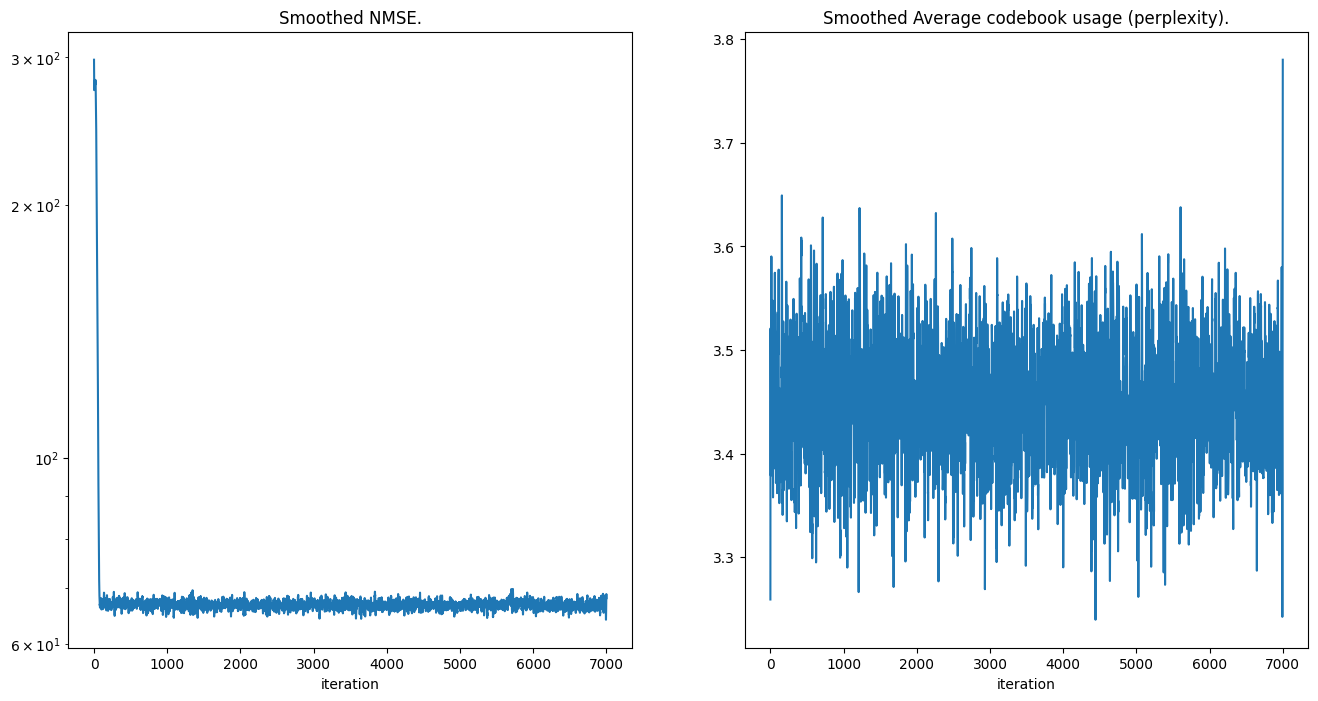

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

### Visualizing the results


In [ ]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
import umap

In [ ]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model.quantizer.embeddings.weight.detach().cpu())

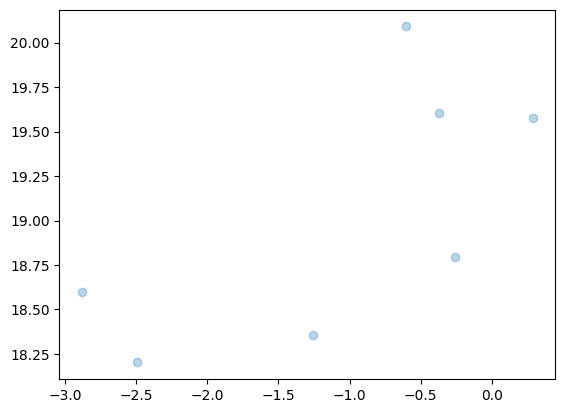

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

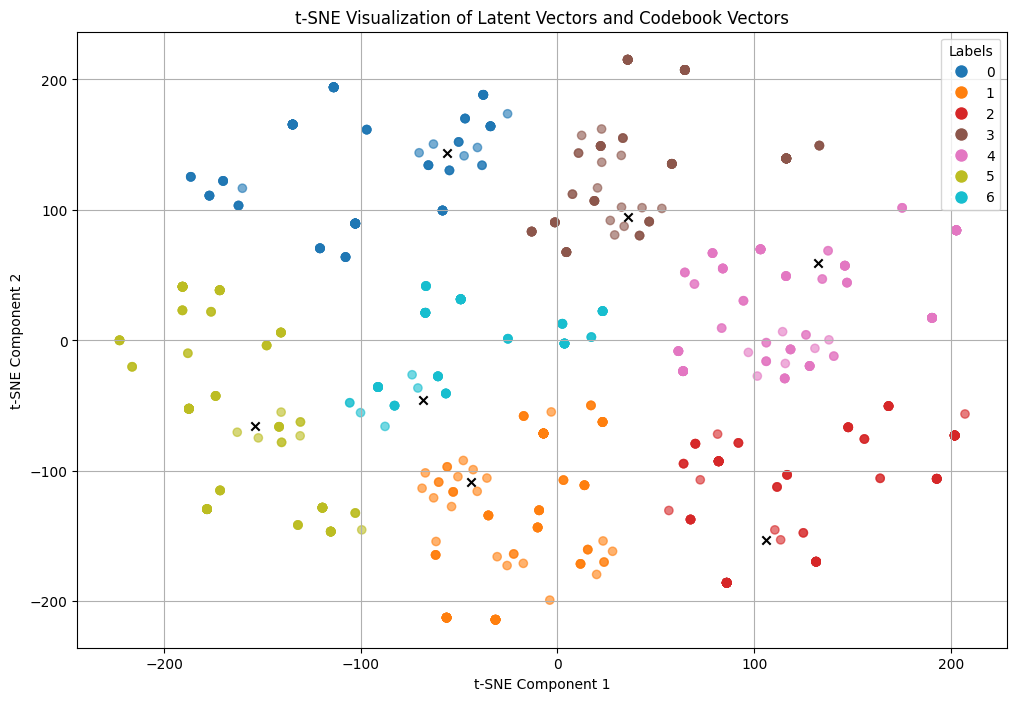

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming vqvae is your trained model and data, labels are your inputs
def encode_points(model, data, labels):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        z = model.encoder(data.to(device))  # Encode data points
        _, quantized_z, _, _ = model.quantizer(z, labels.to(device))  # Quantize the encoded vectors
    return quantized_z

# Function to perform t-SNE and plot the results
def plot_with_tsne(latent_vectors, labels, codebook_vectors):
    tsne = TSNE(n_components=2, random_state=42)
    all_vectors = np.vstack([latent_vectors, codebook_vectors])  # Combine latent and codebook vectors
    all_vectors_2d = tsne.fit_transform(all_vectors)

    latent_vectors_2d = all_vectors_2d[:-len(codebook_vectors)]
    codebook_vectors_2d = all_vectors_2d[-len(codebook_vectors):]

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.scatter(codebook_vectors_2d[:, 0], codebook_vectors_2d[:, 1], color='black', marker='x')  # Codebook vectors in black

    # Create a legend for the labels
    unique_labels = np.unique(labels)
    colors = scatter.cmap(np.linspace(0, 1, len(unique_labels)))
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(int(label)), markersize=10, markerfacecolor=color) for label, color in zip(unique_labels, colors)]
    plt.legend(handles=legend_handles, title='Labels')

    plt.title('t-SNE Visualization of Latent Vectors and Codebook Vectors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Assuming data and labels are loaded correctly and vqvae is your model
data = torch.randn(1000, 22)  # Example data
labels = torch.randint(0, 7, (1000,))  # Example labels

# Encode the data points
quantized_z = encode_points(model, data, labels)

# Get codebook vectors from the quantizer
codebook_vectors = model.quantizer.embeddings.weight.data.cpu().numpy()

# Plot using t-SNE
plot_with_tsne(quantized_z.cpu().numpy(), labels.cpu().numpy(), codebook_vectors)


### Computation graph construction

In [ ]:
import networkx as nx

# Pseudo-function to parse the data and extract the architecture parameters
def parse_architecture_data(data):
    # This function would parse the given data to extract the architecture parameters
    # For demonstration purposes, we're going to manually set these values
    architecture_params = {
        "out_channel0": 117,
        "M": 1,
        "R": [9, 0, 0, 0, 0],
        "convblock": ['B', None, None, None, None],
        "widenfact": [4, None, None, None, None],
        "B": [11, None, None, None, None]
    }
    return architecture_params

# Function to create the computation graph based on the architecture
def create_computation_graph(architecture_params):
    G = nx.DiGraph()  # Create a directed graph

    # Create nodes for main blocks (M)
    for m in range(architecture_params['M']):
        main_block_name = f'M{m}'
        G.add_node(main_block_name, type='main_block')

        # Create nodes for residual blocks within each main block
        for r_index, r_value in enumerate(architecture_params['R']):
            if r_value > 0:  # Only if the residual block exists
                for r in range(r_value):
                    res_block_name = f'R{r_index+1}_{r}'
                    G.add_node(res_block_name, type='res_block')
                    # Connect the residual block to the main block
                    G.add_edge(main_block_name, res_block_name)

                    # Add conv blocks within each residual block
                    conv_block_type = architecture_params['convblock'][r_index]
                    if conv_block_type:
                        for b in range(architecture_params['B'][r_index]):
                            conv_block_name = f'{conv_block_type}{r_index+1}_{b}'
                            G.add_node(conv_block_name, type='conv_block')
                            # Connect the conv block to the residual block
                            G.add_edge(res_block_name, conv_block_name)

                            # Handle widening factor
                            widen_fact = architecture_params['widenfact'][r_index]
                            if widen_fact:
                                # Just represent the widen_fact as an attribute, no actual computation
                                G.nodes[conv_block_name]['widenfact'] = widen_fact

    return G

# Assuming `data` is the parsed information from the uploaded file or a similar source
data = "This would be replaced with the actual data parsing logic"
architecture_params = parse_architecture_data(data)
computation_graph = create_computation_graph(architecture_params)

# Pseudo-code to visualize the graph, actual visualization would depend on the environment
# visualize_computation_graph(computation_graph)

# Since visualization isn't possible here, we will print out the edges to represent the graph structure
print(list(computation_graph.edges(data=True)))


[('M0', 'R1_0', {}), ('M0', 'R1_1', {}), ('M0', 'R1_2', {}), ('M0', 'R1_3', {}), ('M0', 'R1_4', {}), ('M0', 'R1_5', {}), ('M0', 'R1_6', {}), ('M0', 'R1_7', {}), ('M0', 'R1_8', {}), ('R1_0', 'B1_0', {}), ('R1_0', 'B1_1', {}), ('R1_0', 'B1_2', {}), ('R1_0', 'B1_3', {}), ('R1_0', 'B1_4', {}), ('R1_0', 'B1_5', {}), ('R1_0', 'B1_6', {}), ('R1_0', 'B1_7', {}), ('R1_0', 'B1_8', {}), ('R1_0', 'B1_9', {}), ('R1_0', 'B1_10', {}), ('R1_1', 'B1_0', {}), ('R1_1', 'B1_1', {}), ('R1_1', 'B1_2', {}), ('R1_1', 'B1_3', {}), ('R1_1', 'B1_4', {}), ('R1_1', 'B1_5', {}), ('R1_1', 'B1_6', {}), ('R1_1', 'B1_7', {}), ('R1_1', 'B1_8', {}), ('R1_1', 'B1_9', {}), ('R1_1', 'B1_10', {}), ('R1_2', 'B1_0', {}), ('R1_2', 'B1_1', {}), ('R1_2', 'B1_2', {}), ('R1_2', 'B1_3', {}), ('R1_2', 'B1_4', {}), ('R1_2', 'B1_5', {}), ('R1_2', 'B1_6', {}), ('R1_2', 'B1_7', {}), ('R1_2', 'B1_8', {}), ('R1_2', 'B1_9', {}), ('R1_2', 'B1_10', {}), ('R1_3', 'B1_0', {}), ('R1_3', 'B1_1', {}), ('R1_3', 'B1_2', {}), ('R1_3', 'B1_3', {}), ('

### Autoencoder Model

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,h_nodes=128,scale=2,num_layers=1):
    super(AutoEncoder,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout=dropout,h_nodes=h_nodes,scale=scale,num_layers=num_layers)
    self.decoder = Decoder(x_dim,embed_dim,h_nodes=h_nodes,dropout=dropout,scale=scale,num_layers=num_layers)

  def forward(self,x):
    z = self.encoder(x)
    x_recon = self.decoder(z)
    return x_recon

In [ ]:
x_dim = data.shape[1]
h_nodes = 128
scale = 2
num_layers = 3
embed_dim = 10
dropout = 0.2
epochs = 500
learning_rate = 1e-4
weight_decay = 1e-3
batch_size = 16

In [ ]:
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [ ]:
model = AutoEncoder(x_dim,embed_dim,dropout=dropout,num_embeddings=num_embeddings,
                h_nodes=h_nodes,scale=scale,num_layers=num_layers).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

In [ ]:
model.train()
train_res_recon_error = []

for epoch in tqdm(range(epochs)):

  for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
    batch_x,batch_y = batch
    batch_x = batch_x.to(device)
    optimizer.zero_grad()

    noise = torch.rand(batch_x.size()).to(device)
    data_recon = model(batch_x)
    recon_error = F.mse_loss(data_recon, batch_x)
    loss = recon_error
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())

    if (i+1) % 10 == 0:
      print('%d iterations of epochs %d/%d' % (i+1,epoch + 1, epochs))
      print('Average recon_error: %.3f' % np.mean(train_res_recon_error[-10:]))
      print()


  0%|          | 0/500 [00:00<?, ?it/s]

10 iterations of epochs 1/500
Average recon_error: 270.693

20 iterations of epochs 1/500
Average recon_error: 279.939

30 iterations of epochs 1/500
Average recon_error: 276.305

40 iterations of epochs 1/500
Average recon_error: 269.316

50 iterations of epochs 1/500
Average recon_error: 279.527

60 iterations of epochs 1/500
Average recon_error: 280.093



  0%|          | 1/500 [00:00<02:37,  3.16it/s]

70 iterations of epochs 1/500
Average recon_error: 273.068

10 iterations of epochs 2/500
Average recon_error: 274.020

20 iterations of epochs 2/500
Average recon_error: 223.874

30 iterations of epochs 2/500
Average recon_error: 154.003

40 iterations of epochs 2/500
Average recon_error: 129.244



  0%|          | 2/500 [00:00<02:37,  3.16it/s]

50 iterations of epochs 2/500
Average recon_error: 82.580

60 iterations of epochs 2/500
Average recon_error: 43.879

70 iterations of epochs 2/500
Average recon_error: 25.962

10 iterations of epochs 3/500
Average recon_error: 17.431

20 iterations of epochs 3/500
Average recon_error: 16.097



  1%|          | 3/500 [00:00<02:36,  3.18it/s]

30 iterations of epochs 3/500
Average recon_error: 13.618

40 iterations of epochs 3/500
Average recon_error: 13.657

50 iterations of epochs 3/500
Average recon_error: 13.843

60 iterations of epochs 3/500
Average recon_error: 13.826

70 iterations of epochs 3/500
Average recon_error: 15.483

10 iterations of epochs 4/500
Average recon_error: 14.351

20 iterations of epochs 4/500
Average recon_error: 14.798

30 iterations of epochs 4/500
Average recon_error: 14.588

40 iterations of epochs 4/500
Average recon_error: 13.186

50 iterations of epochs 4/500
Average recon_error: 15.589



  1%|          | 4/500 [00:01<02:35,  3.18it/s]

60 iterations of epochs 4/500
Average recon_error: 13.577

70 iterations of epochs 4/500
Average recon_error: 14.162

10 iterations of epochs 5/500
Average recon_error: 14.766

20 iterations of epochs 5/500
Average recon_error: 13.273

30 iterations of epochs 5/500
Average recon_error: 14.335



  1%|          | 5/500 [00:01<02:35,  3.18it/s]

40 iterations of epochs 5/500
Average recon_error: 13.228

50 iterations of epochs 5/500
Average recon_error: 14.047

60 iterations of epochs 5/500
Average recon_error: 14.633

70 iterations of epochs 5/500
Average recon_error: 14.405

10 iterations of epochs 6/500
Average recon_error: 14.446

20 iterations of epochs 6/500
Average recon_error: 14.035

30 iterations of epochs 6/500
Average recon_error: 14.722

40 iterations of epochs 6/500
Average recon_error: 13.217

50 iterations of epochs 6/500
Average recon_error: 14.582

60 iterations of epochs 6/500
Average recon_error: 13.421



  1%|          | 6/500 [00:01<02:34,  3.19it/s]

70 iterations of epochs 6/500
Average recon_error: 14.955

10 iterations of epochs 7/500
Average recon_error: 14.364

20 iterations of epochs 7/500
Average recon_error: 14.458

30 iterations of epochs 7/500
Average recon_error: 14.506

40 iterations of epochs 7/500
Average recon_error: 13.614



  1%|▏         | 7/500 [00:02<02:33,  3.21it/s]

50 iterations of epochs 7/500
Average recon_error: 13.408

60 iterations of epochs 7/500
Average recon_error: 13.880

70 iterations of epochs 7/500
Average recon_error: 14.255

10 iterations of epochs 8/500
Average recon_error: 14.926

20 iterations of epochs 8/500
Average recon_error: 14.040



  2%|▏         | 8/500 [00:02<02:34,  3.17it/s]

30 iterations of epochs 8/500
Average recon_error: 13.711

40 iterations of epochs 8/500
Average recon_error: 14.258

50 iterations of epochs 8/500
Average recon_error: 13.986

60 iterations of epochs 8/500
Average recon_error: 13.484

70 iterations of epochs 8/500
Average recon_error: 15.128

10 iterations of epochs 9/500
Average recon_error: 13.850

20 iterations of epochs 9/500
Average recon_error: 14.337

30 iterations of epochs 9/500
Average recon_error: 13.956

40 iterations of epochs 9/500
Average recon_error: 13.743

50 iterations of epochs 9/500
Average recon_error: 14.110

60 iterations of epochs 9/500
Average recon_error: 14.867



  2%|▏         | 9/500 [00:02<02:33,  3.19it/s]

70 iterations of epochs 9/500
Average recon_error: 14.610

10 iterations of epochs 10/500
Average recon_error: 13.511

20 iterations of epochs 10/500
Average recon_error: 13.785

30 iterations of epochs 10/500
Average recon_error: 14.243

40 iterations of epochs 10/500
Average recon_error: 14.007



  2%|▏         | 10/500 [00:03<02:33,  3.20it/s]

50 iterations of epochs 10/500
Average recon_error: 13.822

60 iterations of epochs 10/500
Average recon_error: 13.708

70 iterations of epochs 10/500
Average recon_error: 15.308

10 iterations of epochs 11/500
Average recon_error: 13.509

20 iterations of epochs 11/500
Average recon_error: 13.377

30 iterations of epochs 11/500
Average recon_error: 14.412

40 iterations of epochs 11/500
Average recon_error: 15.084

50 iterations of epochs 11/500
Average recon_error: 14.377

60 iterations of epochs 11/500
Average recon_error: 14.107

70 iterations of epochs 11/500
Average recon_error: 14.400



  2%|▏         | 11/500 [00:03<02:35,  3.15it/s]

10 iterations of epochs 12/500
Average recon_error: 14.386

20 iterations of epochs 12/500
Average recon_error: 14.696

30 iterations of epochs 12/500
Average recon_error: 14.990

40 iterations of epochs 12/500
Average recon_error: 12.933

50 iterations of epochs 12/500
Average recon_error: 13.751



  2%|▏         | 12/500 [00:03<02:36,  3.13it/s]

60 iterations of epochs 12/500
Average recon_error: 14.188

70 iterations of epochs 12/500
Average recon_error: 14.501

10 iterations of epochs 13/500
Average recon_error: 14.675

20 iterations of epochs 13/500
Average recon_error: 13.789

30 iterations of epochs 13/500
Average recon_error: 12.723

40 iterations of epochs 13/500
Average recon_error: 14.285

50 iterations of epochs 13/500
Average recon_error: 15.032

60 iterations of epochs 13/500
Average recon_error: 14.211



  3%|▎         | 13/500 [00:04<02:49,  2.87it/s]

70 iterations of epochs 13/500
Average recon_error: 14.484

10 iterations of epochs 14/500
Average recon_error: 14.644

20 iterations of epochs 14/500
Average recon_error: 13.910

30 iterations of epochs 14/500
Average recon_error: 14.712

40 iterations of epochs 14/500
Average recon_error: 13.191

50 iterations of epochs 14/500
Average recon_error: 15.629

60 iterations of epochs 14/500
Average recon_error: 13.595



  3%|▎         | 14/500 [00:04<03:00,  2.70it/s]

70 iterations of epochs 14/500
Average recon_error: 13.624

10 iterations of epochs 15/500
Average recon_error: 14.794

20 iterations of epochs 15/500
Average recon_error: 13.292

30 iterations of epochs 15/500
Average recon_error: 14.223



  3%|▎         | 15/500 [00:05<03:02,  2.66it/s]

40 iterations of epochs 15/500
Average recon_error: 14.193

50 iterations of epochs 15/500
Average recon_error: 13.547

60 iterations of epochs 15/500
Average recon_error: 14.156

70 iterations of epochs 15/500
Average recon_error: 14.690

10 iterations of epochs 16/500
Average recon_error: 14.868

20 iterations of epochs 16/500
Average recon_error: 13.850

30 iterations of epochs 16/500
Average recon_error: 14.816

40 iterations of epochs 16/500
Average recon_error: 13.370



  3%|▎         | 16/500 [00:05<03:10,  2.54it/s]

50 iterations of epochs 16/500
Average recon_error: 13.355

60 iterations of epochs 16/500
Average recon_error: 15.189

70 iterations of epochs 16/500
Average recon_error: 13.896

10 iterations of epochs 17/500
Average recon_error: 13.968

20 iterations of epochs 17/500
Average recon_error: 14.017

30 iterations of epochs 17/500
Average recon_error: 14.331

40 iterations of epochs 17/500
Average recon_error: 13.872



  3%|▎         | 17/500 [00:05<03:17,  2.44it/s]

50 iterations of epochs 17/500
Average recon_error: 13.805

60 iterations of epochs 17/500
Average recon_error: 13.403

70 iterations of epochs 17/500
Average recon_error: 15.319

10 iterations of epochs 18/500
Average recon_error: 13.917

20 iterations of epochs 18/500
Average recon_error: 12.866

30 iterations of epochs 18/500
Average recon_error: 13.991

40 iterations of epochs 18/500
Average recon_error: 14.355

50 iterations of epochs 18/500
Average recon_error: 14.660

60 iterations of epochs 18/500
Average recon_error: 14.896



  4%|▎         | 18/500 [00:06<03:07,  2.57it/s]

70 iterations of epochs 18/500
Average recon_error: 13.983

10 iterations of epochs 19/500
Average recon_error: 13.391

20 iterations of epochs 19/500
Average recon_error: 15.012

30 iterations of epochs 19/500
Average recon_error: 14.428

40 iterations of epochs 19/500
Average recon_error: 15.057



  4%|▍         | 19/500 [00:06<02:56,  2.73it/s]

50 iterations of epochs 19/500
Average recon_error: 13.535

60 iterations of epochs 19/500
Average recon_error: 14.612

70 iterations of epochs 19/500
Average recon_error: 13.731

10 iterations of epochs 20/500
Average recon_error: 12.531

20 iterations of epochs 20/500
Average recon_error: 14.423



  4%|▍         | 20/500 [00:06<02:48,  2.85it/s]

30 iterations of epochs 20/500
Average recon_error: 14.945

40 iterations of epochs 20/500
Average recon_error: 14.044

50 iterations of epochs 20/500
Average recon_error: 14.362

60 iterations of epochs 20/500
Average recon_error: 14.836

70 iterations of epochs 20/500
Average recon_error: 13.489

10 iterations of epochs 21/500
Average recon_error: 15.210

20 iterations of epochs 21/500
Average recon_error: 13.480

30 iterations of epochs 21/500
Average recon_error: 13.428

40 iterations of epochs 21/500
Average recon_error: 14.095

50 iterations of epochs 21/500
Average recon_error: 14.548



  4%|▍         | 21/500 [00:07<02:43,  2.94it/s]

60 iterations of epochs 21/500
Average recon_error: 14.253

70 iterations of epochs 21/500
Average recon_error: 13.928

10 iterations of epochs 22/500
Average recon_error: 13.353

20 iterations of epochs 22/500
Average recon_error: 14.183

30 iterations of epochs 22/500
Average recon_error: 13.977



  4%|▍         | 22/500 [00:07<02:38,  3.01it/s]

40 iterations of epochs 22/500
Average recon_error: 14.418

50 iterations of epochs 22/500
Average recon_error: 13.911

60 iterations of epochs 22/500
Average recon_error: 13.653

70 iterations of epochs 22/500
Average recon_error: 14.150

10 iterations of epochs 23/500
Average recon_error: 13.070

20 iterations of epochs 23/500
Average recon_error: 14.113

30 iterations of epochs 23/500
Average recon_error: 13.478

40 iterations of epochs 23/500
Average recon_error: 14.825

50 iterations of epochs 23/500
Average recon_error: 14.026

60 iterations of epochs 23/500
Average recon_error: 14.607



  5%|▍         | 23/500 [00:07<02:38,  3.01it/s]

70 iterations of epochs 23/500
Average recon_error: 14.115

10 iterations of epochs 24/500
Average recon_error: 15.077

20 iterations of epochs 24/500
Average recon_error: 13.354

30 iterations of epochs 24/500
Average recon_error: 14.535

40 iterations of epochs 24/500
Average recon_error: 14.171



  5%|▍         | 24/500 [00:08<02:36,  3.05it/s]

50 iterations of epochs 24/500
Average recon_error: 14.262

60 iterations of epochs 24/500
Average recon_error: 13.817

70 iterations of epochs 24/500
Average recon_error: 14.073

10 iterations of epochs 25/500
Average recon_error: 13.915

20 iterations of epochs 25/500
Average recon_error: 14.264



  5%|▌         | 25/500 [00:08<02:35,  3.05it/s]

30 iterations of epochs 25/500
Average recon_error: 14.653

40 iterations of epochs 25/500
Average recon_error: 13.919

50 iterations of epochs 25/500
Average recon_error: 14.048

60 iterations of epochs 25/500
Average recon_error: 13.770

70 iterations of epochs 25/500
Average recon_error: 14.574

10 iterations of epochs 26/500
Average recon_error: 12.696

20 iterations of epochs 26/500
Average recon_error: 13.885

30 iterations of epochs 26/500
Average recon_error: 14.383

40 iterations of epochs 26/500
Average recon_error: 14.098

50 iterations of epochs 26/500
Average recon_error: 13.835



  5%|▌         | 26/500 [00:08<02:37,  3.02it/s]

60 iterations of epochs 26/500
Average recon_error: 14.768

70 iterations of epochs 26/500
Average recon_error: 14.219

10 iterations of epochs 27/500
Average recon_error: 14.916

20 iterations of epochs 27/500
Average recon_error: 14.172

30 iterations of epochs 27/500
Average recon_error: 13.148



  5%|▌         | 27/500 [00:09<02:34,  3.07it/s]

40 iterations of epochs 27/500
Average recon_error: 14.016

50 iterations of epochs 27/500
Average recon_error: 14.597

60 iterations of epochs 27/500
Average recon_error: 14.056

70 iterations of epochs 27/500
Average recon_error: 13.643

10 iterations of epochs 28/500
Average recon_error: 12.593

20 iterations of epochs 28/500
Average recon_error: 14.212

30 iterations of epochs 28/500
Average recon_error: 14.438

40 iterations of epochs 28/500
Average recon_error: 14.328

50 iterations of epochs 28/500
Average recon_error: 14.417

60 iterations of epochs 28/500
Average recon_error: 14.066



  6%|▌         | 28/500 [00:09<02:34,  3.06it/s]

70 iterations of epochs 28/500
Average recon_error: 14.755

10 iterations of epochs 29/500
Average recon_error: 14.609

20 iterations of epochs 29/500
Average recon_error: 14.006

30 iterations of epochs 29/500
Average recon_error: 13.305

40 iterations of epochs 29/500
Average recon_error: 13.874



  6%|▌         | 29/500 [00:09<02:33,  3.07it/s]

50 iterations of epochs 29/500
Average recon_error: 14.745

60 iterations of epochs 29/500
Average recon_error: 13.531

70 iterations of epochs 29/500
Average recon_error: 14.451

10 iterations of epochs 30/500
Average recon_error: 14.540

20 iterations of epochs 30/500
Average recon_error: 14.165



  6%|▌         | 30/500 [00:10<02:34,  3.05it/s]

30 iterations of epochs 30/500
Average recon_error: 13.364

40 iterations of epochs 30/500
Average recon_error: 14.509

50 iterations of epochs 30/500
Average recon_error: 13.990

60 iterations of epochs 30/500
Average recon_error: 13.076

70 iterations of epochs 30/500
Average recon_error: 14.392

10 iterations of epochs 31/500
Average recon_error: 14.486

20 iterations of epochs 31/500
Average recon_error: 15.573

30 iterations of epochs 31/500
Average recon_error: 12.896

40 iterations of epochs 31/500
Average recon_error: 14.040

50 iterations of epochs 31/500
Average recon_error: 13.208



  6%|▌         | 31/500 [00:10<02:35,  3.01it/s]

60 iterations of epochs 31/500
Average recon_error: 13.695

70 iterations of epochs 31/500
Average recon_error: 14.075

10 iterations of epochs 32/500
Average recon_error: 14.025

20 iterations of epochs 32/500
Average recon_error: 13.991

30 iterations of epochs 32/500
Average recon_error: 14.972



  6%|▋         | 32/500 [00:10<02:35,  3.01it/s]

40 iterations of epochs 32/500
Average recon_error: 13.729

50 iterations of epochs 32/500
Average recon_error: 13.691

60 iterations of epochs 32/500
Average recon_error: 13.485

70 iterations of epochs 32/500
Average recon_error: 14.022

10 iterations of epochs 33/500
Average recon_error: 14.048

20 iterations of epochs 33/500
Average recon_error: 14.303

30 iterations of epochs 33/500
Average recon_error: 13.222

40 iterations of epochs 33/500
Average recon_error: 13.707

50 iterations of epochs 33/500
Average recon_error: 14.257



  7%|▋         | 33/500 [00:11<02:33,  3.04it/s]

60 iterations of epochs 33/500
Average recon_error: 13.877

70 iterations of epochs 33/500
Average recon_error: 14.536

10 iterations of epochs 34/500
Average recon_error: 13.886

20 iterations of epochs 34/500
Average recon_error: 13.424

30 iterations of epochs 34/500
Average recon_error: 14.714



  7%|▋         | 34/500 [00:11<02:31,  3.08it/s]

40 iterations of epochs 34/500
Average recon_error: 13.557

50 iterations of epochs 34/500
Average recon_error: 13.566

60 iterations of epochs 34/500
Average recon_error: 14.548

70 iterations of epochs 34/500
Average recon_error: 14.306

10 iterations of epochs 35/500
Average recon_error: 14.258

20 iterations of epochs 35/500
Average recon_error: 13.477

30 iterations of epochs 35/500
Average recon_error: 15.299

40 iterations of epochs 35/500
Average recon_error: 13.687

50 iterations of epochs 35/500
Average recon_error: 13.981

60 iterations of epochs 35/500
Average recon_error: 14.090



  7%|▋         | 35/500 [00:11<02:30,  3.08it/s]

70 iterations of epochs 35/500
Average recon_error: 13.863

10 iterations of epochs 36/500
Average recon_error: 12.930

20 iterations of epochs 36/500
Average recon_error: 13.596

30 iterations of epochs 36/500
Average recon_error: 14.541

40 iterations of epochs 36/500
Average recon_error: 14.613



  7%|▋         | 36/500 [00:12<02:29,  3.10it/s]

50 iterations of epochs 36/500
Average recon_error: 15.588

60 iterations of epochs 36/500
Average recon_error: 13.498

70 iterations of epochs 36/500
Average recon_error: 13.871

10 iterations of epochs 37/500
Average recon_error: 14.420

20 iterations of epochs 37/500
Average recon_error: 14.664



  7%|▋         | 37/500 [00:12<02:28,  3.11it/s]

30 iterations of epochs 37/500
Average recon_error: 13.935

40 iterations of epochs 37/500
Average recon_error: 14.205

50 iterations of epochs 37/500
Average recon_error: 13.793

60 iterations of epochs 37/500
Average recon_error: 13.367

70 iterations of epochs 37/500
Average recon_error: 13.800

10 iterations of epochs 38/500
Average recon_error: 14.695

20 iterations of epochs 38/500
Average recon_error: 14.123

30 iterations of epochs 38/500
Average recon_error: 13.114

40 iterations of epochs 38/500
Average recon_error: 13.307

50 iterations of epochs 38/500
Average recon_error: 14.637



  8%|▊         | 38/500 [00:12<02:27,  3.13it/s]

60 iterations of epochs 38/500
Average recon_error: 14.959

70 iterations of epochs 38/500
Average recon_error: 13.988

10 iterations of epochs 39/500
Average recon_error: 14.610

20 iterations of epochs 39/500
Average recon_error: 13.416

30 iterations of epochs 39/500
Average recon_error: 14.144



  8%|▊         | 39/500 [00:13<02:27,  3.12it/s]

40 iterations of epochs 39/500
Average recon_error: 15.192

50 iterations of epochs 39/500
Average recon_error: 13.533

60 iterations of epochs 39/500
Average recon_error: 14.428

70 iterations of epochs 39/500
Average recon_error: 13.801

10 iterations of epochs 40/500
Average recon_error: 14.033

20 iterations of epochs 40/500
Average recon_error: 13.352

30 iterations of epochs 40/500
Average recon_error: 13.533

40 iterations of epochs 40/500
Average recon_error: 14.798

50 iterations of epochs 40/500
Average recon_error: 14.199

60 iterations of epochs 40/500
Average recon_error: 14.197



  8%|▊         | 40/500 [00:13<02:27,  3.12it/s]

70 iterations of epochs 40/500
Average recon_error: 13.804

10 iterations of epochs 41/500
Average recon_error: 13.239

20 iterations of epochs 41/500
Average recon_error: 12.875

30 iterations of epochs 41/500
Average recon_error: 15.464

40 iterations of epochs 41/500
Average recon_error: 14.255



  8%|▊         | 41/500 [00:13<02:26,  3.14it/s]

50 iterations of epochs 41/500
Average recon_error: 14.643

60 iterations of epochs 41/500
Average recon_error: 13.740

70 iterations of epochs 41/500
Average recon_error: 13.618

10 iterations of epochs 42/500
Average recon_error: 14.181

20 iterations of epochs 42/500
Average recon_error: 14.116



  8%|▊         | 42/500 [00:13<02:26,  3.13it/s]

30 iterations of epochs 42/500
Average recon_error: 14.096

40 iterations of epochs 42/500
Average recon_error: 13.652

50 iterations of epochs 42/500
Average recon_error: 13.152

60 iterations of epochs 42/500
Average recon_error: 14.395

70 iterations of epochs 42/500
Average recon_error: 14.299

10 iterations of epochs 43/500
Average recon_error: 13.709

20 iterations of epochs 43/500
Average recon_error: 14.259

30 iterations of epochs 43/500
Average recon_error: 13.299

40 iterations of epochs 43/500
Average recon_error: 14.545

50 iterations of epochs 43/500
Average recon_error: 14.649



  9%|▊         | 43/500 [00:14<02:25,  3.14it/s]

60 iterations of epochs 43/500
Average recon_error: 14.509

70 iterations of epochs 43/500
Average recon_error: 12.985

10 iterations of epochs 44/500
Average recon_error: 13.958

20 iterations of epochs 44/500
Average recon_error: 14.704

30 iterations of epochs 44/500
Average recon_error: 13.091



  9%|▉         | 44/500 [00:14<02:25,  3.13it/s]

40 iterations of epochs 44/500
Average recon_error: 14.422

50 iterations of epochs 44/500
Average recon_error: 14.031

60 iterations of epochs 44/500
Average recon_error: 13.229

70 iterations of epochs 44/500
Average recon_error: 14.043

10 iterations of epochs 45/500
Average recon_error: 14.167

20 iterations of epochs 45/500
Average recon_error: 14.585

30 iterations of epochs 45/500
Average recon_error: 13.396

40 iterations of epochs 45/500
Average recon_error: 14.058

50 iterations of epochs 45/500
Average recon_error: 13.428

60 iterations of epochs 45/500
Average recon_error: 13.984



  9%|▉         | 45/500 [00:14<02:26,  3.11it/s]

70 iterations of epochs 45/500
Average recon_error: 13.969

10 iterations of epochs 46/500
Average recon_error: 14.124

20 iterations of epochs 46/500
Average recon_error: 13.937

30 iterations of epochs 46/500
Average recon_error: 13.396

40 iterations of epochs 46/500
Average recon_error: 13.623



  9%|▉         | 46/500 [00:15<02:25,  3.13it/s]

50 iterations of epochs 46/500
Average recon_error: 14.441

60 iterations of epochs 46/500
Average recon_error: 14.353

70 iterations of epochs 46/500
Average recon_error: 13.252

10 iterations of epochs 47/500
Average recon_error: 13.845

20 iterations of epochs 47/500
Average recon_error: 14.290



  9%|▉         | 47/500 [00:15<02:24,  3.14it/s]

30 iterations of epochs 47/500
Average recon_error: 14.181

40 iterations of epochs 47/500
Average recon_error: 13.814

50 iterations of epochs 47/500
Average recon_error: 13.555

60 iterations of epochs 47/500
Average recon_error: 14.505

70 iterations of epochs 47/500
Average recon_error: 13.594

10 iterations of epochs 48/500
Average recon_error: 13.889

20 iterations of epochs 48/500
Average recon_error: 13.809

30 iterations of epochs 48/500
Average recon_error: 13.766

40 iterations of epochs 48/500
Average recon_error: 13.966

50 iterations of epochs 48/500
Average recon_error: 14.217



 10%|▉         | 48/500 [00:15<02:32,  2.97it/s]

60 iterations of epochs 48/500
Average recon_error: 14.202

70 iterations of epochs 48/500
Average recon_error: 13.603

10 iterations of epochs 49/500
Average recon_error: 13.910

20 iterations of epochs 49/500
Average recon_error: 14.343

30 iterations of epochs 49/500
Average recon_error: 13.215

40 iterations of epochs 49/500
Average recon_error: 14.074

50 iterations of epochs 49/500
Average recon_error: 14.049



 10%|▉         | 49/500 [00:16<02:41,  2.79it/s]

60 iterations of epochs 49/500
Average recon_error: 14.116

70 iterations of epochs 49/500
Average recon_error: 14.156

10 iterations of epochs 50/500
Average recon_error: 14.680

20 iterations of epochs 50/500
Average recon_error: 13.642

30 iterations of epochs 50/500
Average recon_error: 14.320

40 iterations of epochs 50/500
Average recon_error: 13.381

50 iterations of epochs 50/500
Average recon_error: 13.999

60 iterations of epochs 50/500
Average recon_error: 13.413



 10%|█         | 50/500 [00:16<02:45,  2.72it/s]

70 iterations of epochs 50/500
Average recon_error: 14.164

10 iterations of epochs 51/500
Average recon_error: 13.416

20 iterations of epochs 51/500
Average recon_error: 14.965

30 iterations of epochs 51/500
Average recon_error: 14.135



 10%|█         | 51/500 [00:17<02:50,  2.63it/s]

40 iterations of epochs 51/500
Average recon_error: 13.615

50 iterations of epochs 51/500
Average recon_error: 13.286

60 iterations of epochs 51/500
Average recon_error: 14.636

70 iterations of epochs 51/500
Average recon_error: 13.979

10 iterations of epochs 52/500
Average recon_error: 14.347

20 iterations of epochs 52/500
Average recon_error: 14.455

30 iterations of epochs 52/500
Average recon_error: 13.769

40 iterations of epochs 52/500
Average recon_error: 13.747



 10%|█         | 52/500 [00:17<02:57,  2.52it/s]

50 iterations of epochs 52/500
Average recon_error: 13.219

60 iterations of epochs 52/500
Average recon_error: 14.202

70 iterations of epochs 52/500
Average recon_error: 14.257

10 iterations of epochs 53/500
Average recon_error: 13.383

20 iterations of epochs 53/500
Average recon_error: 14.356

30 iterations of epochs 53/500
Average recon_error: 14.173

40 iterations of epochs 53/500
Average recon_error: 13.013

50 iterations of epochs 53/500
Average recon_error: 14.678



 11%|█         | 53/500 [00:17<02:55,  2.55it/s]

60 iterations of epochs 53/500
Average recon_error: 14.144

70 iterations of epochs 53/500
Average recon_error: 13.427

10 iterations of epochs 54/500
Average recon_error: 13.656

20 iterations of epochs 54/500
Average recon_error: 14.501

30 iterations of epochs 54/500
Average recon_error: 13.963



 11%|█         | 54/500 [00:18<02:45,  2.69it/s]

40 iterations of epochs 54/500
Average recon_error: 15.134

50 iterations of epochs 54/500
Average recon_error: 12.955

60 iterations of epochs 54/500
Average recon_error: 13.896

70 iterations of epochs 54/500
Average recon_error: 14.016

10 iterations of epochs 55/500
Average recon_error: 13.864

20 iterations of epochs 55/500
Average recon_error: 14.288

30 iterations of epochs 55/500
Average recon_error: 13.748

40 iterations of epochs 55/500
Average recon_error: 14.149

50 iterations of epochs 55/500
Average recon_error: 14.679

60 iterations of epochs 55/500
Average recon_error: 14.673



 11%|█         | 55/500 [00:18<02:38,  2.81it/s]

70 iterations of epochs 55/500
Average recon_error: 13.038

10 iterations of epochs 56/500
Average recon_error: 13.628

20 iterations of epochs 56/500
Average recon_error: 13.768

30 iterations of epochs 56/500
Average recon_error: 14.132

40 iterations of epochs 56/500
Average recon_error: 14.526



 11%|█         | 56/500 [00:18<02:34,  2.87it/s]

50 iterations of epochs 56/500
Average recon_error: 13.222

60 iterations of epochs 56/500
Average recon_error: 13.877

70 iterations of epochs 56/500
Average recon_error: 14.061

10 iterations of epochs 57/500
Average recon_error: 13.471

20 iterations of epochs 57/500
Average recon_error: 14.655



 11%|█▏        | 57/500 [00:19<02:29,  2.96it/s]

30 iterations of epochs 57/500
Average recon_error: 13.068

40 iterations of epochs 57/500
Average recon_error: 13.816

50 iterations of epochs 57/500
Average recon_error: 14.307

60 iterations of epochs 57/500
Average recon_error: 14.364

70 iterations of epochs 57/500
Average recon_error: 13.712

10 iterations of epochs 58/500
Average recon_error: 12.613

20 iterations of epochs 58/500
Average recon_error: 14.376

30 iterations of epochs 58/500
Average recon_error: 14.229

40 iterations of epochs 58/500
Average recon_error: 14.190

50 iterations of epochs 58/500
Average recon_error: 13.749



 12%|█▏        | 58/500 [00:19<02:27,  3.00it/s]

60 iterations of epochs 58/500
Average recon_error: 13.592

70 iterations of epochs 58/500
Average recon_error: 14.836

10 iterations of epochs 59/500
Average recon_error: 14.951

20 iterations of epochs 59/500
Average recon_error: 13.521

30 iterations of epochs 59/500
Average recon_error: 13.631



 12%|█▏        | 59/500 [00:19<02:24,  3.05it/s]

40 iterations of epochs 59/500
Average recon_error: 14.104

50 iterations of epochs 59/500
Average recon_error: 14.117

60 iterations of epochs 59/500
Average recon_error: 13.734

70 iterations of epochs 59/500
Average recon_error: 13.428

10 iterations of epochs 60/500
Average recon_error: 14.479

20 iterations of epochs 60/500
Average recon_error: 13.703

30 iterations of epochs 60/500
Average recon_error: 13.144

40 iterations of epochs 60/500
Average recon_error: 15.147

50 iterations of epochs 60/500
Average recon_error: 13.366

60 iterations of epochs 60/500
Average recon_error: 13.536



 12%|█▏        | 60/500 [00:20<02:23,  3.06it/s]

70 iterations of epochs 60/500
Average recon_error: 13.612

10 iterations of epochs 61/500
Average recon_error: 14.991

20 iterations of epochs 61/500
Average recon_error: 13.524

30 iterations of epochs 61/500
Average recon_error: 12.989

40 iterations of epochs 61/500
Average recon_error: 13.578



 12%|█▏        | 61/500 [00:20<02:21,  3.10it/s]

50 iterations of epochs 61/500
Average recon_error: 13.838

60 iterations of epochs 61/500
Average recon_error: 14.861

70 iterations of epochs 61/500
Average recon_error: 13.224

10 iterations of epochs 62/500
Average recon_error: 13.278

20 iterations of epochs 62/500
Average recon_error: 14.818



 12%|█▏        | 62/500 [00:20<02:20,  3.11it/s]

30 iterations of epochs 62/500
Average recon_error: 13.471

40 iterations of epochs 62/500
Average recon_error: 13.475

50 iterations of epochs 62/500
Average recon_error: 13.602

60 iterations of epochs 62/500
Average recon_error: 14.474

70 iterations of epochs 62/500
Average recon_error: 14.269

10 iterations of epochs 63/500
Average recon_error: 14.793

20 iterations of epochs 63/500
Average recon_error: 14.622

30 iterations of epochs 63/500
Average recon_error: 13.481

40 iterations of epochs 63/500
Average recon_error: 13.158

50 iterations of epochs 63/500
Average recon_error: 13.951



 13%|█▎        | 63/500 [00:21<02:20,  3.10it/s]

60 iterations of epochs 63/500
Average recon_error: 14.207

70 iterations of epochs 63/500
Average recon_error: 13.417

10 iterations of epochs 64/500
Average recon_error: 13.312

20 iterations of epochs 64/500
Average recon_error: 13.859

30 iterations of epochs 64/500
Average recon_error: 15.167



 13%|█▎        | 64/500 [00:21<02:19,  3.11it/s]

40 iterations of epochs 64/500
Average recon_error: 13.259

50 iterations of epochs 64/500
Average recon_error: 13.901

60 iterations of epochs 64/500
Average recon_error: 13.057

70 iterations of epochs 64/500
Average recon_error: 13.799

10 iterations of epochs 65/500
Average recon_error: 13.803

20 iterations of epochs 65/500
Average recon_error: 13.540

30 iterations of epochs 65/500
Average recon_error: 13.603

40 iterations of epochs 65/500
Average recon_error: 13.298

50 iterations of epochs 65/500
Average recon_error: 13.432

60 iterations of epochs 65/500
Average recon_error: 13.236



 13%|█▎        | 65/500 [00:21<02:18,  3.14it/s]

70 iterations of epochs 65/500
Average recon_error: 14.119

10 iterations of epochs 66/500
Average recon_error: 13.149

20 iterations of epochs 66/500
Average recon_error: 13.667

30 iterations of epochs 66/500
Average recon_error: 14.442

40 iterations of epochs 66/500
Average recon_error: 14.554



 13%|█▎        | 66/500 [00:22<02:18,  3.12it/s]

50 iterations of epochs 66/500
Average recon_error: 14.100

60 iterations of epochs 66/500
Average recon_error: 12.666

70 iterations of epochs 66/500
Average recon_error: 13.518

10 iterations of epochs 67/500
Average recon_error: 13.821

20 iterations of epochs 67/500
Average recon_error: 13.518



 13%|█▎        | 67/500 [00:22<02:17,  3.15it/s]

30 iterations of epochs 67/500
Average recon_error: 12.972

40 iterations of epochs 67/500
Average recon_error: 13.996

50 iterations of epochs 67/500
Average recon_error: 13.570

60 iterations of epochs 67/500
Average recon_error: 13.589

70 iterations of epochs 67/500
Average recon_error: 13.282

10 iterations of epochs 68/500
Average recon_error: 14.016

20 iterations of epochs 68/500
Average recon_error: 14.239

30 iterations of epochs 68/500
Average recon_error: 12.804

40 iterations of epochs 68/500
Average recon_error: 14.018

50 iterations of epochs 68/500
Average recon_error: 13.496



 14%|█▎        | 68/500 [00:22<02:16,  3.16it/s]

60 iterations of epochs 68/500
Average recon_error: 13.606

70 iterations of epochs 68/500
Average recon_error: 13.316

10 iterations of epochs 69/500
Average recon_error: 14.289

20 iterations of epochs 69/500
Average recon_error: 12.664

30 iterations of epochs 69/500
Average recon_error: 13.584



 14%|█▍        | 69/500 [00:23<02:17,  3.14it/s]

40 iterations of epochs 69/500
Average recon_error: 13.535

50 iterations of epochs 69/500
Average recon_error: 13.591

60 iterations of epochs 69/500
Average recon_error: 13.550

70 iterations of epochs 69/500
Average recon_error: 14.091

10 iterations of epochs 70/500
Average recon_error: 14.048

20 iterations of epochs 70/500
Average recon_error: 13.602

30 iterations of epochs 70/500
Average recon_error: 13.530

40 iterations of epochs 70/500
Average recon_error: 14.130

50 iterations of epochs 70/500
Average recon_error: 13.881

60 iterations of epochs 70/500
Average recon_error: 13.865



 14%|█▍        | 70/500 [00:23<02:16,  3.15it/s]

70 iterations of epochs 70/500
Average recon_error: 13.060

10 iterations of epochs 71/500
Average recon_error: 13.410

20 iterations of epochs 71/500
Average recon_error: 13.598

30 iterations of epochs 71/500
Average recon_error: 12.704

40 iterations of epochs 71/500
Average recon_error: 13.954



 14%|█▍        | 71/500 [00:23<02:16,  3.15it/s]

50 iterations of epochs 71/500
Average recon_error: 14.289

60 iterations of epochs 71/500
Average recon_error: 13.592

70 iterations of epochs 71/500
Average recon_error: 13.056

10 iterations of epochs 72/500
Average recon_error: 13.247

20 iterations of epochs 72/500
Average recon_error: 13.484



 14%|█▍        | 72/500 [00:24<02:16,  3.14it/s]

30 iterations of epochs 72/500
Average recon_error: 14.021

40 iterations of epochs 72/500
Average recon_error: 13.172

50 iterations of epochs 72/500
Average recon_error: 14.060

60 iterations of epochs 72/500
Average recon_error: 13.190

70 iterations of epochs 72/500
Average recon_error: 14.115

10 iterations of epochs 73/500
Average recon_error: 13.743

20 iterations of epochs 73/500
Average recon_error: 13.460

30 iterations of epochs 73/500
Average recon_error: 14.477

40 iterations of epochs 73/500
Average recon_error: 13.294

50 iterations of epochs 73/500
Average recon_error: 13.488



 15%|█▍        | 73/500 [00:24<02:15,  3.15it/s]

60 iterations of epochs 73/500
Average recon_error: 13.708

70 iterations of epochs 73/500
Average recon_error: 13.253

10 iterations of epochs 74/500
Average recon_error: 12.825

20 iterations of epochs 74/500
Average recon_error: 13.906

30 iterations of epochs 74/500
Average recon_error: 13.765



 15%|█▍        | 74/500 [00:24<02:15,  3.15it/s]

40 iterations of epochs 74/500
Average recon_error: 13.299

50 iterations of epochs 74/500
Average recon_error: 13.629

60 iterations of epochs 74/500
Average recon_error: 14.083

70 iterations of epochs 74/500
Average recon_error: 13.398

10 iterations of epochs 75/500
Average recon_error: 13.438

20 iterations of epochs 75/500
Average recon_error: 13.361

30 iterations of epochs 75/500
Average recon_error: 13.377

40 iterations of epochs 75/500
Average recon_error: 13.398

50 iterations of epochs 75/500
Average recon_error: 13.510

60 iterations of epochs 75/500
Average recon_error: 14.230



 15%|█▌        | 75/500 [00:24<02:14,  3.17it/s]

70 iterations of epochs 75/500
Average recon_error: 13.951

10 iterations of epochs 76/500
Average recon_error: 13.528

20 iterations of epochs 76/500
Average recon_error: 13.834

30 iterations of epochs 76/500
Average recon_error: 13.577

40 iterations of epochs 76/500
Average recon_error: 13.142



 15%|█▌        | 76/500 [00:25<02:14,  3.16it/s]

50 iterations of epochs 76/500
Average recon_error: 13.292

60 iterations of epochs 76/500
Average recon_error: 14.192

70 iterations of epochs 76/500
Average recon_error: 13.311

10 iterations of epochs 77/500
Average recon_error: 13.265

20 iterations of epochs 77/500
Average recon_error: 13.040



 15%|█▌        | 77/500 [00:25<02:12,  3.18it/s]

30 iterations of epochs 77/500
Average recon_error: 13.443

40 iterations of epochs 77/500
Average recon_error: 14.555

50 iterations of epochs 77/500
Average recon_error: 13.408

60 iterations of epochs 77/500
Average recon_error: 13.613

70 iterations of epochs 77/500
Average recon_error: 13.187

10 iterations of epochs 78/500
Average recon_error: 12.936

20 iterations of epochs 78/500
Average recon_error: 13.205

30 iterations of epochs 78/500
Average recon_error: 12.701

40 iterations of epochs 78/500
Average recon_error: 14.952

50 iterations of epochs 78/500
Average recon_error: 13.157



 16%|█▌        | 78/500 [00:25<02:12,  3.18it/s]

60 iterations of epochs 78/500
Average recon_error: 13.737

70 iterations of epochs 78/500
Average recon_error: 14.037

10 iterations of epochs 79/500
Average recon_error: 13.350

20 iterations of epochs 79/500
Average recon_error: 14.216



 16%|█▌        | 79/500 [00:26<02:12,  3.17it/s]

30 iterations of epochs 79/500
Average recon_error: 13.800

40 iterations of epochs 79/500
Average recon_error: 12.922

50 iterations of epochs 79/500
Average recon_error: 13.218

60 iterations of epochs 79/500
Average recon_error: 12.968

70 iterations of epochs 79/500
Average recon_error: 13.596

10 iterations of epochs 80/500
Average recon_error: 12.921

20 iterations of epochs 80/500
Average recon_error: 12.803

30 iterations of epochs 80/500
Average recon_error: 13.399

40 iterations of epochs 80/500
Average recon_error: 12.238

50 iterations of epochs 80/500
Average recon_error: 11.441



 16%|█▌        | 80/500 [00:26<02:12,  3.16it/s]

60 iterations of epochs 80/500
Average recon_error: 11.007

70 iterations of epochs 80/500
Average recon_error: 10.635

10 iterations of epochs 81/500
Average recon_error: 9.712

20 iterations of epochs 81/500
Average recon_error: 8.780

30 iterations of epochs 81/500
Average recon_error: 8.576



 16%|█▌        | 81/500 [00:26<02:13,  3.15it/s]

40 iterations of epochs 81/500
Average recon_error: 8.649

50 iterations of epochs 81/500
Average recon_error: 8.302

60 iterations of epochs 81/500
Average recon_error: 8.700

70 iterations of epochs 81/500
Average recon_error: 8.852

10 iterations of epochs 82/500
Average recon_error: 8.108

20 iterations of epochs 82/500
Average recon_error: 7.641

30 iterations of epochs 82/500
Average recon_error: 8.650

40 iterations of epochs 82/500
Average recon_error: 8.672

50 iterations of epochs 82/500
Average recon_error: 8.297

60 iterations of epochs 82/500
Average recon_error: 7.599



 16%|█▋        | 82/500 [00:27<02:16,  3.07it/s]

70 iterations of epochs 82/500
Average recon_error: 8.185

10 iterations of epochs 83/500
Average recon_error: 8.587

20 iterations of epochs 83/500
Average recon_error: 8.009

30 iterations of epochs 83/500
Average recon_error: 7.875

40 iterations of epochs 83/500
Average recon_error: 8.023



 17%|█▋        | 83/500 [00:27<02:13,  3.13it/s]

50 iterations of epochs 83/500
Average recon_error: 8.096

60 iterations of epochs 83/500
Average recon_error: 7.414

70 iterations of epochs 83/500
Average recon_error: 7.152

10 iterations of epochs 84/500
Average recon_error: 8.199

20 iterations of epochs 84/500
Average recon_error: 7.617

30 iterations of epochs 84/500
Average recon_error: 7.704

40 iterations of epochs 84/500
Average recon_error: 7.562

50 iterations of epochs 84/500
Average recon_error: 7.643

60 iterations of epochs 84/500
Average recon_error: 8.249

70 iterations of epochs 84/500
Average recon_error: 7.654



 17%|█▋        | 84/500 [00:27<02:17,  3.03it/s]

10 iterations of epochs 85/500
Average recon_error: 7.837

20 iterations of epochs 85/500
Average recon_error: 7.969

30 iterations of epochs 85/500
Average recon_error: 7.775

40 iterations of epochs 85/500
Average recon_error: 7.950



 17%|█▋        | 85/500 [00:28<02:28,  2.80it/s]

50 iterations of epochs 85/500
Average recon_error: 7.900

60 iterations of epochs 85/500
Average recon_error: 7.503

70 iterations of epochs 85/500
Average recon_error: 7.707

10 iterations of epochs 86/500
Average recon_error: 7.998

20 iterations of epochs 86/500
Average recon_error: 7.465

30 iterations of epochs 86/500
Average recon_error: 7.869

40 iterations of epochs 86/500
Average recon_error: 7.476

50 iterations of epochs 86/500
Average recon_error: 7.554

60 iterations of epochs 86/500

 17%|█▋        | 86/500 [00:28<02:30,  2.75it/s]


Average recon_error: 7.492

70 iterations of epochs 86/500
Average recon_error: 8.124

10 iterations of epochs 87/500
Average recon_error: 8.638

20 iterations of epochs 87/500
Average recon_error: 6.755

30 iterations of epochs 87/500
Average recon_error: 7.684

40 iterations of epochs 87/500
Average recon_error: 8.034

50 iterations of epochs 87/500
Average recon_error: 6.964

60 iterations of epochs 87/500
Average recon_error: 8.041



 17%|█▋        | 87/500 [00:29<02:36,  2.64it/s]

70 iterations of epochs 87/500
Average recon_error: 7.164

10 iterations of epochs 88/500
Average recon_error: 7.768

20 iterations of epochs 88/500
Average recon_error: 7.538

30 iterations of epochs 88/500
Average recon_error: 7.575

40 iterations of epochs 88/500
Average recon_error: 7.824

50 iterations of epochs 88/500
Average recon_error: 7.661

60 iterations of epochs 88/500
Average recon_error: 7.666



 18%|█▊        | 88/500 [00:29<02:46,  2.48it/s]

70 iterations of epochs 88/500
Average recon_error: 7.345

10 iterations of epochs 89/500
Average recon_error: 6.860

20 iterations of epochs 89/500
Average recon_error: 7.688



 18%|█▊        | 89/500 [00:29<02:41,  2.54it/s]

30 iterations of epochs 89/500
Average recon_error: 7.639

40 iterations of epochs 89/500
Average recon_error: 7.722

50 iterations of epochs 89/500
Average recon_error: 8.114

60 iterations of epochs 89/500
Average recon_error: 7.840

70 iterations of epochs 89/500
Average recon_error: 7.581

10 iterations of epochs 90/500
Average recon_error: 7.660

20 iterations of epochs 90/500
Average recon_error: 7.722

30 iterations of epochs 90/500
Average recon_error: 7.988

40 iterations of epochs 90/500
Average recon_error: 7.181

50 iterations of epochs 90/500
Average recon_error: 7.766



 18%|█▊        | 90/500 [00:30<02:32,  2.69it/s]

60 iterations of epochs 90/500
Average recon_error: 7.192

70 iterations of epochs 90/500
Average recon_error: 7.674

10 iterations of epochs 91/500
Average recon_error: 8.304

20 iterations of epochs 91/500
Average recon_error: 7.497

30 iterations of epochs 91/500
Average recon_error: 7.620



 18%|█▊        | 91/500 [00:30<02:24,  2.82it/s]

40 iterations of epochs 91/500
Average recon_error: 7.218

50 iterations of epochs 91/500
Average recon_error: 7.836

60 iterations of epochs 91/500
Average recon_error: 7.575

70 iterations of epochs 91/500
Average recon_error: 7.651

10 iterations of epochs 92/500
Average recon_error: 7.304

20 iterations of epochs 92/500
Average recon_error: 7.411

30 iterations of epochs 92/500
Average recon_error: 7.837

40 iterations of epochs 92/500
Average recon_error: 7.398

50 iterations of epochs 92/500
Average recon_error: 7.389

60 iterations of epochs 92/500
Average recon_error: 7.368



 18%|█▊        | 92/500 [00:30<02:20,  2.91it/s]

70 iterations of epochs 92/500
Average recon_error: 7.766

10 iterations of epochs 93/500
Average recon_error: 7.478

20 iterations of epochs 93/500
Average recon_error: 7.934

30 iterations of epochs 93/500
Average recon_error: 7.859

40 iterations of epochs 93/500
Average recon_error: 7.888



 19%|█▊        | 93/500 [00:31<02:15,  3.00it/s]

50 iterations of epochs 93/500
Average recon_error: 7.515

60 iterations of epochs 93/500
Average recon_error: 7.081

70 iterations of epochs 93/500
Average recon_error: 7.179

10 iterations of epochs 94/500
Average recon_error: 7.665

20 iterations of epochs 94/500
Average recon_error: 7.496



 19%|█▉        | 94/500 [00:31<02:13,  3.04it/s]

30 iterations of epochs 94/500
Average recon_error: 7.710

40 iterations of epochs 94/500
Average recon_error: 7.198

50 iterations of epochs 94/500
Average recon_error: 7.577

60 iterations of epochs 94/500
Average recon_error: 7.372

70 iterations of epochs 94/500
Average recon_error: 7.835

10 iterations of epochs 95/500
Average recon_error: 6.989

20 iterations of epochs 95/500
Average recon_error: 7.865

30 iterations of epochs 95/500
Average recon_error: 7.504

40 iterations of epochs 95/500
Average recon_error: 7.733

50 iterations of epochs 95/500
Average recon_error: 8.190



 19%|█▉        | 95/500 [00:31<02:11,  3.07it/s]

60 iterations of epochs 95/500
Average recon_error: 7.333

70 iterations of epochs 95/500
Average recon_error: 7.039

10 iterations of epochs 96/500
Average recon_error: 7.441

20 iterations of epochs 96/500
Average recon_error: 7.454

30 iterations of epochs 96/500
Average recon_error: 7.370



 19%|█▉        | 96/500 [00:32<02:10,  3.10it/s]

40 iterations of epochs 96/500
Average recon_error: 7.482

50 iterations of epochs 96/500
Average recon_error: 6.990

60 iterations of epochs 96/500
Average recon_error: 8.010

70 iterations of epochs 96/500
Average recon_error: 7.534

10 iterations of epochs 97/500
Average recon_error: 6.835

20 iterations of epochs 97/500
Average recon_error: 7.459

30 iterations of epochs 97/500
Average recon_error: 7.515

40 iterations of epochs 97/500
Average recon_error: 6.949

50 iterations of epochs 97/500
Average recon_error: 7.429

60 iterations of epochs 97/500
Average recon_error: 7.467



 19%|█▉        | 97/500 [00:32<02:10,  3.09it/s]

70 iterations of epochs 97/500
Average recon_error: 7.277

10 iterations of epochs 98/500
Average recon_error: 7.020

20 iterations of epochs 98/500
Average recon_error: 6.995

30 iterations of epochs 98/500
Average recon_error: 7.139

40 iterations of epochs 98/500
Average recon_error: 7.438



 20%|█▉        | 98/500 [00:32<02:08,  3.13it/s]

50 iterations of epochs 98/500
Average recon_error: 7.661

60 iterations of epochs 98/500
Average recon_error: 7.408

70 iterations of epochs 98/500
Average recon_error: 7.258

10 iterations of epochs 99/500
Average recon_error: 7.314

20 iterations of epochs 99/500
Average recon_error: 7.244



 20%|█▉        | 99/500 [00:33<02:08,  3.13it/s]

30 iterations of epochs 99/500
Average recon_error: 7.312

40 iterations of epochs 99/500
Average recon_error: 7.492

50 iterations of epochs 99/500
Average recon_error: 6.959

60 iterations of epochs 99/500
Average recon_error: 6.885

70 iterations of epochs 99/500
Average recon_error: 7.665

10 iterations of epochs 100/500
Average recon_error: 7.237

20 iterations of epochs 100/500
Average recon_error: 6.886

30 iterations of epochs 100/500
Average recon_error: 7.134

40 iterations of epochs 100/500
Average recon_error: 7.452

50 iterations of epochs 100/500
Average recon_error: 7.030



 20%|██        | 100/500 [00:33<02:08,  3.10it/s]

60 iterations of epochs 100/500
Average recon_error: 7.370

70 iterations of epochs 100/500
Average recon_error: 7.559

10 iterations of epochs 101/500
Average recon_error: 7.058

20 iterations of epochs 101/500
Average recon_error: 7.162

30 iterations of epochs 101/500
Average recon_error: 6.838



 20%|██        | 101/500 [00:33<02:09,  3.09it/s]

40 iterations of epochs 101/500
Average recon_error: 7.087

50 iterations of epochs 101/500
Average recon_error: 7.407

60 iterations of epochs 101/500
Average recon_error: 7.744

70 iterations of epochs 101/500
Average recon_error: 7.322

10 iterations of epochs 102/500
Average recon_error: 6.534

20 iterations of epochs 102/500
Average recon_error: 7.442

30 iterations of epochs 102/500
Average recon_error: 7.241

40 iterations of epochs 102/500
Average recon_error: 7.071

50 iterations of epochs 102/500
Average recon_error: 7.509

60 iterations of epochs 102/500
Average recon_error: 7.199



 20%|██        | 102/500 [00:34<02:07,  3.12it/s]

70 iterations of epochs 102/500
Average recon_error: 7.320

10 iterations of epochs 103/500
Average recon_error: 7.141

20 iterations of epochs 103/500
Average recon_error: 6.793

30 iterations of epochs 103/500
Average recon_error: 6.730

40 iterations of epochs 103/500
Average recon_error: 7.253



 21%|██        | 103/500 [00:34<02:07,  3.12it/s]

50 iterations of epochs 103/500
Average recon_error: 7.458

60 iterations of epochs 103/500
Average recon_error: 7.297

70 iterations of epochs 103/500
Average recon_error: 7.253

10 iterations of epochs 104/500
Average recon_error: 6.846

20 iterations of epochs 104/500
Average recon_error: 7.636



 21%|██        | 104/500 [00:34<02:05,  3.14it/s]

30 iterations of epochs 104/500
Average recon_error: 7.135

40 iterations of epochs 104/500
Average recon_error: 6.908

50 iterations of epochs 104/500
Average recon_error: 7.567

60 iterations of epochs 104/500
Average recon_error: 6.865

70 iterations of epochs 104/500
Average recon_error: 7.378

10 iterations of epochs 105/500
Average recon_error: 7.074

20 iterations of epochs 105/500
Average recon_error: 7.606

30 iterations of epochs 105/500
Average recon_error: 7.155

40 iterations of epochs 105/500
Average recon_error: 7.040

50 iterations of epochs 105/500
Average recon_error: 6.671



 21%|██        | 105/500 [00:35<02:05,  3.15it/s]

60 iterations of epochs 105/500
Average recon_error: 7.123

70 iterations of epochs 105/500
Average recon_error: 7.246

10 iterations of epochs 106/500
Average recon_error: 7.073

20 iterations of epochs 106/500
Average recon_error: 7.072

30 iterations of epochs 106/500
Average recon_error: 7.078



 21%|██        | 106/500 [00:35<02:04,  3.16it/s]

40 iterations of epochs 106/500
Average recon_error: 7.154

50 iterations of epochs 106/500
Average recon_error: 7.142

60 iterations of epochs 106/500
Average recon_error: 7.294

70 iterations of epochs 106/500
Average recon_error: 7.282

10 iterations of epochs 107/500
Average recon_error: 7.180

20 iterations of epochs 107/500
Average recon_error: 6.983

30 iterations of epochs 107/500
Average recon_error: 6.778

40 iterations of epochs 107/500
Average recon_error: 7.487

50 iterations of epochs 107/500
Average recon_error: 6.983

60 iterations of epochs 107/500
Average recon_error: 7.040

70 iterations of epochs 107/500
Average recon_error: 7.883



 21%|██▏       | 107/500 [00:35<02:04,  3.17it/s]

10 iterations of epochs 108/500
Average recon_error: 7.310

20 iterations of epochs 108/500
Average recon_error: 7.100

30 iterations of epochs 108/500
Average recon_error: 6.773

40 iterations of epochs 108/500
Average recon_error: 6.927



 22%|██▏       | 108/500 [00:35<02:03,  3.16it/s]

50 iterations of epochs 108/500
Average recon_error: 6.638

60 iterations of epochs 108/500
Average recon_error: 6.595

70 iterations of epochs 108/500
Average recon_error: 7.054

10 iterations of epochs 109/500
Average recon_error: 6.883

20 iterations of epochs 109/500
Average recon_error: 6.421

30 iterations of epochs 109/500
Average recon_error: 6.306

40 iterations of epochs 109/500
Average recon_error: 6.263

50 iterations of epochs 109/500
Average recon_error: 6.900

60 iterations of epochs 109/500
Average recon_error: 6.843

70 iterations of epochs 109/500
Average recon_error: 6.756



 22%|██▏       | 109/500 [00:36<02:05,  3.12it/s]

10 iterations of epochs 110/500
Average recon_error: 6.361

20 iterations of epochs 110/500
Average recon_error: 6.978

30 iterations of epochs 110/500
Average recon_error: 6.701

40 iterations of epochs 110/500
Average recon_error: 6.564

50 iterations of epochs 110/500
Average recon_error: 6.360



 22%|██▏       | 110/500 [00:36<02:06,  3.09it/s]

60 iterations of epochs 110/500
Average recon_error: 6.645

70 iterations of epochs 110/500
Average recon_error: 6.615

10 iterations of epochs 111/500
Average recon_error: 6.574

20 iterations of epochs 111/500
Average recon_error: 6.239

30 iterations of epochs 111/500
Average recon_error: 6.631



 22%|██▏       | 111/500 [00:36<02:06,  3.09it/s]

40 iterations of epochs 111/500
Average recon_error: 6.391

50 iterations of epochs 111/500
Average recon_error: 6.260

60 iterations of epochs 111/500
Average recon_error: 6.654

70 iterations of epochs 111/500
Average recon_error: 6.448

10 iterations of epochs 112/500
Average recon_error: 6.526

20 iterations of epochs 112/500
Average recon_error: 6.066

30 iterations of epochs 112/500
Average recon_error: 6.560

40 iterations of epochs 112/500
Average recon_error: 6.192

50 iterations of epochs 112/500
Average recon_error: 6.421



 22%|██▏       | 112/500 [00:37<02:05,  3.09it/s]

60 iterations of epochs 112/500
Average recon_error: 6.815

70 iterations of epochs 112/500
Average recon_error: 6.621

10 iterations of epochs 113/500
Average recon_error: 6.004

20 iterations of epochs 113/500
Average recon_error: 6.281

30 iterations of epochs 113/500
Average recon_error: 6.475



 23%|██▎       | 113/500 [00:37<02:05,  3.10it/s]

40 iterations of epochs 113/500
Average recon_error: 6.447

50 iterations of epochs 113/500
Average recon_error: 6.776

60 iterations of epochs 113/500
Average recon_error: 6.106

70 iterations of epochs 113/500
Average recon_error: 6.728

10 iterations of epochs 114/500
Average recon_error: 6.558

20 iterations of epochs 114/500
Average recon_error: 6.506

30 iterations of epochs 114/500
Average recon_error: 6.510

40 iterations of epochs 114/500
Average recon_error: 6.072

50 iterations of epochs 114/500
Average recon_error: 6.385

60 iterations of epochs 114/500
Average recon_error: 6.205



 23%|██▎       | 114/500 [00:37<02:04,  3.11it/s]

70 iterations of epochs 114/500
Average recon_error: 7.013

10 iterations of epochs 115/500
Average recon_error: 5.974

20 iterations of epochs 115/500
Average recon_error: 6.221

30 iterations of epochs 115/500
Average recon_error: 6.488

40 iterations of epochs 115/500
Average recon_error: 6.372



 23%|██▎       | 115/500 [00:38<02:04,  3.10it/s]

50 iterations of epochs 115/500
Average recon_error: 6.439

60 iterations of epochs 115/500
Average recon_error: 6.531

70 iterations of epochs 115/500
Average recon_error: 7.017

10 iterations of epochs 116/500
Average recon_error: 6.058

20 iterations of epochs 116/500
Average recon_error: 6.302



 23%|██▎       | 116/500 [00:38<02:04,  3.09it/s]

30 iterations of epochs 116/500
Average recon_error: 6.333

40 iterations of epochs 116/500
Average recon_error: 6.670

50 iterations of epochs 116/500
Average recon_error: 6.284

60 iterations of epochs 116/500
Average recon_error: 6.372

70 iterations of epochs 116/500
Average recon_error: 6.495

10 iterations of epochs 117/500
Average recon_error: 6.569

20 iterations of epochs 117/500
Average recon_error: 6.304

30 iterations of epochs 117/500
Average recon_error: 5.804

40 iterations of epochs 117/500
Average recon_error: 6.325

50 iterations of epochs 117/500
Average recon_error: 6.527



 23%|██▎       | 117/500 [00:38<02:04,  3.07it/s]

60 iterations of epochs 117/500
Average recon_error: 6.674

70 iterations of epochs 117/500
Average recon_error: 6.695

10 iterations of epochs 118/500
Average recon_error: 6.339

20 iterations of epochs 118/500
Average recon_error: 6.598

30 iterations of epochs 118/500
Average recon_error: 6.724



 24%|██▎       | 118/500 [00:39<02:03,  3.09it/s]

40 iterations of epochs 118/500
Average recon_error: 6.338

50 iterations of epochs 118/500
Average recon_error: 6.157

60 iterations of epochs 118/500
Average recon_error: 6.222

70 iterations of epochs 118/500
Average recon_error: 6.123

10 iterations of epochs 119/500
Average recon_error: 6.658

20 iterations of epochs 119/500
Average recon_error: 6.265

30 iterations of epochs 119/500
Average recon_error: 6.750

40 iterations of epochs 119/500
Average recon_error: 6.108

50 iterations of epochs 119/500
Average recon_error: 6.629

60 iterations of epochs 119/500
Average recon_error: 6.228



 24%|██▍       | 119/500 [00:39<02:04,  3.06it/s]

70 iterations of epochs 119/500
Average recon_error: 6.336

10 iterations of epochs 120/500
Average recon_error: 6.070

20 iterations of epochs 120/500
Average recon_error: 6.480

30 iterations of epochs 120/500
Average recon_error: 6.195



 24%|██▍       | 120/500 [00:39<02:11,  2.89it/s]

40 iterations of epochs 120/500
Average recon_error: 6.738

50 iterations of epochs 120/500
Average recon_error: 6.667

60 iterations of epochs 120/500
Average recon_error: 5.731

70 iterations of epochs 120/500
Average recon_error: 6.035

10 iterations of epochs 121/500
Average recon_error: 6.593

20 iterations of epochs 121/500
Average recon_error: 6.095

30 iterations of epochs 121/500
Average recon_error: 6.165

40 iterations of epochs 121/500
Average recon_error: 5.939



 24%|██▍       | 121/500 [00:40<02:20,  2.70it/s]

50 iterations of epochs 121/500
Average recon_error: 6.037

60 iterations of epochs 121/500
Average recon_error: 6.230

70 iterations of epochs 121/500
Average recon_error: 6.528

10 iterations of epochs 122/500
Average recon_error: 6.216

20 iterations of epochs 122/500
Average recon_error: 6.254

30 iterations of epochs 122/500
Average recon_error: 6.036

40 iterations of epochs 122/500
Average recon_error: 6.440



 24%|██▍       | 122/500 [00:40<02:26,  2.58it/s]

50 iterations of epochs 122/500
Average recon_error: 6.500

60 iterations of epochs 122/500
Average recon_error: 6.177

70 iterations of epochs 122/500
Average recon_error: 6.533

10 iterations of epochs 123/500
Average recon_error: 6.071

20 iterations of epochs 123/500
Average recon_error: 6.891

30 iterations of epochs 123/500
Average recon_error: 6.194

40 iterations of epochs 123/500
Average recon_error: 6.714

50 iterations of epochs 123/500
Average recon_error: 5.847



 25%|██▍       | 123/500 [00:41<02:32,  2.46it/s]

60 iterations of epochs 123/500
Average recon_error: 6.255

70 iterations of epochs 123/500
Average recon_error: 6.114

10 iterations of epochs 124/500
Average recon_error: 5.921

20 iterations of epochs 124/500
Average recon_error: 6.308

30 iterations of epochs 124/500
Average recon_error: 6.204

40 iterations of epochs 124/500
Average recon_error: 6.732

50 iterations of epochs 124/500
Average recon_error: 6.349



 25%|██▍       | 124/500 [00:41<02:37,  2.39it/s]

60 iterations of epochs 124/500
Average recon_error: 6.440

70 iterations of epochs 124/500
Average recon_error: 6.069

10 iterations of epochs 125/500
Average recon_error: 6.329

20 iterations of epochs 125/500
Average recon_error: 6.503



 25%|██▌       | 125/500 [00:42<02:25,  2.58it/s]

30 iterations of epochs 125/500
Average recon_error: 6.145

40 iterations of epochs 125/500
Average recon_error: 6.254

50 iterations of epochs 125/500
Average recon_error: 6.327

60 iterations of epochs 125/500
Average recon_error: 6.052

70 iterations of epochs 125/500
Average recon_error: 6.333

10 iterations of epochs 126/500
Average recon_error: 6.227

20 iterations of epochs 126/500
Average recon_error: 6.434

30 iterations of epochs 126/500
Average recon_error: 6.007

40 iterations of epochs 126/500
Average recon_error: 6.617

50 iterations of epochs 126/500
Average recon_error: 5.867

60 iterations of epochs 126/500
Average recon_error: 5.951



 25%|██▌       | 126/500 [00:42<02:16,  2.74it/s]

70 iterations of epochs 126/500
Average recon_error: 6.566

10 iterations of epochs 127/500
Average recon_error: 6.571

20 iterations of epochs 127/500
Average recon_error: 6.341

30 iterations of epochs 127/500
Average recon_error: 6.316

40 iterations of epochs 127/500
Average recon_error: 5.876



 25%|██▌       | 127/500 [00:42<02:10,  2.85it/s]

50 iterations of epochs 127/500
Average recon_error: 6.744

60 iterations of epochs 127/500
Average recon_error: 5.971

70 iterations of epochs 127/500
Average recon_error: 6.262

10 iterations of epochs 128/500
Average recon_error: 6.166

20 iterations of epochs 128/500
Average recon_error: 5.923



 26%|██▌       | 128/500 [00:42<02:06,  2.93it/s]

30 iterations of epochs 128/500
Average recon_error: 6.069

40 iterations of epochs 128/500
Average recon_error: 6.731

50 iterations of epochs 128/500
Average recon_error: 6.356

60 iterations of epochs 128/500
Average recon_error: 6.447

70 iterations of epochs 128/500
Average recon_error: 5.875

10 iterations of epochs 129/500
Average recon_error: 5.910

20 iterations of epochs 129/500
Average recon_error: 6.048

30 iterations of epochs 129/500
Average recon_error: 6.234

40 iterations of epochs 129/500
Average recon_error: 5.751

50 iterations of epochs 129/500
Average recon_error: 5.965



 26%|██▌       | 129/500 [00:43<02:04,  2.98it/s]

60 iterations of epochs 129/500
Average recon_error: 6.842

70 iterations of epochs 129/500
Average recon_error: 6.453

10 iterations of epochs 130/500
Average recon_error: 5.948

20 iterations of epochs 130/500
Average recon_error: 6.463

30 iterations of epochs 130/500
Average recon_error: 6.054



 26%|██▌       | 130/500 [00:43<02:02,  3.02it/s]

40 iterations of epochs 130/500
Average recon_error: 6.327

50 iterations of epochs 130/500
Average recon_error: 6.043

60 iterations of epochs 130/500
Average recon_error: 5.956

70 iterations of epochs 130/500
Average recon_error: 6.530

10 iterations of epochs 131/500
Average recon_error: 6.256

20 iterations of epochs 131/500
Average recon_error: 6.068

30 iterations of epochs 131/500
Average recon_error: 6.356

40 iterations of epochs 131/500
Average recon_error: 6.081

50 iterations of epochs 131/500
Average recon_error: 5.578

60 iterations of epochs 131/500
Average recon_error: 6.237



 26%|██▌       | 131/500 [00:43<02:00,  3.05it/s]

70 iterations of epochs 131/500
Average recon_error: 6.219

10 iterations of epochs 132/500
Average recon_error: 5.943

20 iterations of epochs 132/500
Average recon_error: 6.198

30 iterations of epochs 132/500
Average recon_error: 6.428

40 iterations of epochs 132/500
Average recon_error: 5.969



 26%|██▋       | 132/500 [00:44<01:58,  3.10it/s]

50 iterations of epochs 132/500
Average recon_error: 5.723

60 iterations of epochs 132/500
Average recon_error: 6.447

70 iterations of epochs 132/500
Average recon_error: 6.251

10 iterations of epochs 133/500
Average recon_error: 5.941

20 iterations of epochs 133/500
Average recon_error: 6.033



 27%|██▋       | 133/500 [00:44<01:56,  3.15it/s]

30 iterations of epochs 133/500
Average recon_error: 6.331

40 iterations of epochs 133/500
Average recon_error: 6.140

50 iterations of epochs 133/500
Average recon_error: 6.488

60 iterations of epochs 133/500
Average recon_error: 5.695

70 iterations of epochs 133/500
Average recon_error: 6.460

10 iterations of epochs 134/500
Average recon_error: 6.208

20 iterations of epochs 134/500
Average recon_error: 6.520

30 iterations of epochs 134/500
Average recon_error: 5.984

40 iterations of epochs 134/500
Average recon_error: 5.661

50 iterations of epochs 134/500
Average recon_error: 6.296

60 iterations of epochs 134/500
Average recon_error: 6.124



 27%|██▋       | 134/500 [00:44<01:56,  3.14it/s]

70 iterations of epochs 134/500
Average recon_error: 5.921

10 iterations of epochs 135/500
Average recon_error: 6.109

20 iterations of epochs 135/500
Average recon_error: 6.490

30 iterations of epochs 135/500
Average recon_error: 5.996

40 iterations of epochs 135/500
Average recon_error: 5.908



 27%|██▋       | 135/500 [00:45<01:55,  3.16it/s]

50 iterations of epochs 135/500
Average recon_error: 5.728

60 iterations of epochs 135/500
Average recon_error: 6.233

70 iterations of epochs 135/500
Average recon_error: 6.320

10 iterations of epochs 136/500
Average recon_error: 5.828

20 iterations of epochs 136/500
Average recon_error: 6.200



 27%|██▋       | 136/500 [00:45<01:54,  3.19it/s]

30 iterations of epochs 136/500
Average recon_error: 5.935

40 iterations of epochs 136/500
Average recon_error: 6.133

50 iterations of epochs 136/500
Average recon_error: 5.890

60 iterations of epochs 136/500
Average recon_error: 6.464

70 iterations of epochs 136/500
Average recon_error: 6.193

10 iterations of epochs 137/500
Average recon_error: 6.165

20 iterations of epochs 137/500
Average recon_error: 6.474

30 iterations of epochs 137/500
Average recon_error: 5.956

40 iterations of epochs 137/500
Average recon_error: 6.080

50 iterations of epochs 137/500
Average recon_error: 6.051



 27%|██▋       | 137/500 [00:45<01:54,  3.16it/s]

60 iterations of epochs 137/500
Average recon_error: 6.001

70 iterations of epochs 137/500
Average recon_error: 6.142

10 iterations of epochs 138/500
Average recon_error: 5.906

20 iterations of epochs 138/500
Average recon_error: 6.225

30 iterations of epochs 138/500
Average recon_error: 5.972



 28%|██▊       | 138/500 [00:46<01:53,  3.19it/s]

40 iterations of epochs 138/500
Average recon_error: 6.340

50 iterations of epochs 138/500
Average recon_error: 6.191

60 iterations of epochs 138/500
Average recon_error: 5.966

70 iterations of epochs 138/500
Average recon_error: 6.131

10 iterations of epochs 139/500
Average recon_error: 6.265

20 iterations of epochs 139/500
Average recon_error: 6.314

30 iterations of epochs 139/500
Average recon_error: 5.954

40 iterations of epochs 139/500
Average recon_error: 5.785

50 iterations of epochs 139/500
Average recon_error: 6.252

60 iterations of epochs 139/500
Average recon_error: 6.449



 28%|██▊       | 139/500 [00:46<01:54,  3.15it/s]

70 iterations of epochs 139/500
Average recon_error: 5.890

10 iterations of epochs 140/500
Average recon_error: 5.948

20 iterations of epochs 140/500
Average recon_error: 6.038

30 iterations of epochs 140/500
Average recon_error: 5.849

40 iterations of epochs 140/500
Average recon_error: 6.146



 28%|██▊       | 140/500 [00:46<01:55,  3.13it/s]

50 iterations of epochs 140/500
Average recon_error: 6.257

60 iterations of epochs 140/500
Average recon_error: 6.045

70 iterations of epochs 140/500
Average recon_error: 6.067

10 iterations of epochs 141/500
Average recon_error: 5.931

20 iterations of epochs 141/500
Average recon_error: 5.882



 28%|██▊       | 141/500 [00:47<01:54,  3.14it/s]

30 iterations of epochs 141/500
Average recon_error: 5.766

40 iterations of epochs 141/500
Average recon_error: 6.200

50 iterations of epochs 141/500
Average recon_error: 6.282

60 iterations of epochs 141/500
Average recon_error: 5.596

70 iterations of epochs 141/500
Average recon_error: 6.317

10 iterations of epochs 142/500
Average recon_error: 6.145

20 iterations of epochs 142/500
Average recon_error: 5.519

30 iterations of epochs 142/500
Average recon_error: 6.691

40 iterations of epochs 142/500
Average recon_error: 5.955

50 iterations of epochs 142/500
Average recon_error: 5.935



 28%|██▊       | 142/500 [00:47<01:53,  3.14it/s]

60 iterations of epochs 142/500
Average recon_error: 5.865

70 iterations of epochs 142/500
Average recon_error: 6.241

10 iterations of epochs 143/500
Average recon_error: 6.134

20 iterations of epochs 143/500
Average recon_error: 6.469

30 iterations of epochs 143/500
Average recon_error: 5.603



 29%|██▊       | 143/500 [00:47<01:55,  3.09it/s]

40 iterations of epochs 143/500
Average recon_error: 6.011

50 iterations of epochs 143/500
Average recon_error: 6.007

60 iterations of epochs 143/500
Average recon_error: 5.684

70 iterations of epochs 143/500
Average recon_error: 6.067

10 iterations of epochs 144/500
Average recon_error: 6.055

20 iterations of epochs 144/500
Average recon_error: 5.799

30 iterations of epochs 144/500
Average recon_error: 6.194

40 iterations of epochs 144/500
Average recon_error: 6.116

50 iterations of epochs 144/500
Average recon_error: 6.332



 29%|██▉       | 144/500 [00:48<01:54,  3.10it/s]

60 iterations of epochs 144/500
Average recon_error: 5.588

70 iterations of epochs 144/500
Average recon_error: 6.173

10 iterations of epochs 145/500
Average recon_error: 6.300

20 iterations of epochs 145/500
Average recon_error: 6.158

30 iterations of epochs 145/500
Average recon_error: 5.987



 29%|██▉       | 145/500 [00:48<01:53,  3.13it/s]

40 iterations of epochs 145/500
Average recon_error: 5.901

50 iterations of epochs 145/500
Average recon_error: 5.605

60 iterations of epochs 145/500
Average recon_error: 5.826

70 iterations of epochs 145/500
Average recon_error: 6.247

10 iterations of epochs 146/500
Average recon_error: 5.804

20 iterations of epochs 146/500
Average recon_error: 6.284

30 iterations of epochs 146/500
Average recon_error: 5.574

40 iterations of epochs 146/500
Average recon_error: 6.166

50 iterations of epochs 146/500
Average recon_error: 5.972

60 iterations of epochs 146/500
Average recon_error: 6.043



 29%|██▉       | 146/500 [00:48<01:53,  3.12it/s]

70 iterations of epochs 146/500
Average recon_error: 6.308

10 iterations of epochs 147/500
Average recon_error: 5.586

20 iterations of epochs 147/500
Average recon_error: 6.247

30 iterations of epochs 147/500
Average recon_error: 6.159

40 iterations of epochs 147/500
Average recon_error: 6.047



 29%|██▉       | 147/500 [00:48<01:52,  3.13it/s]

50 iterations of epochs 147/500
Average recon_error: 5.929

60 iterations of epochs 147/500
Average recon_error: 6.091

70 iterations of epochs 147/500
Average recon_error: 5.749

10 iterations of epochs 148/500
Average recon_error: 6.000

20 iterations of epochs 148/500
Average recon_error: 5.730



 30%|██▉       | 148/500 [00:49<01:51,  3.15it/s]

30 iterations of epochs 148/500
Average recon_error: 5.809

40 iterations of epochs 148/500
Average recon_error: 5.547

50 iterations of epochs 148/500
Average recon_error: 5.787

60 iterations of epochs 148/500
Average recon_error: 6.207

70 iterations of epochs 148/500
Average recon_error: 6.443

10 iterations of epochs 149/500
Average recon_error: 5.590

20 iterations of epochs 149/500
Average recon_error: 5.933

30 iterations of epochs 149/500
Average recon_error: 5.879

40 iterations of epochs 149/500
Average recon_error: 6.613

50 iterations of epochs 149/500
Average recon_error: 6.021

60 iterations of epochs 149/500
Average recon_error: 5.792



 30%|██▉       | 149/500 [00:49<01:51,  3.15it/s]

70 iterations of epochs 149/500
Average recon_error: 5.760

10 iterations of epochs 150/500
Average recon_error: 5.878

20 iterations of epochs 150/500
Average recon_error: 5.783

30 iterations of epochs 150/500
Average recon_error: 5.900

40 iterations of epochs 150/500
Average recon_error: 5.686



 30%|███       | 150/500 [00:49<01:52,  3.12it/s]

50 iterations of epochs 150/500
Average recon_error: 5.975

60 iterations of epochs 150/500
Average recon_error: 6.318

70 iterations of epochs 150/500
Average recon_error: 5.687

10 iterations of epochs 151/500
Average recon_error: 5.676

20 iterations of epochs 151/500
Average recon_error: 6.134



 30%|███       | 151/500 [00:50<01:51,  3.13it/s]

30 iterations of epochs 151/500
Average recon_error: 5.836

40 iterations of epochs 151/500
Average recon_error: 6.047

50 iterations of epochs 151/500
Average recon_error: 6.285

60 iterations of epochs 151/500
Average recon_error: 5.742

70 iterations of epochs 151/500
Average recon_error: 5.800

10 iterations of epochs 152/500
Average recon_error: 5.706

20 iterations of epochs 152/500
Average recon_error: 5.974

30 iterations of epochs 152/500
Average recon_error: 6.026

40 iterations of epochs 152/500
Average recon_error: 5.907

50 iterations of epochs 152/500
Average recon_error: 5.718



 30%|███       | 152/500 [00:50<01:52,  3.10it/s]

60 iterations of epochs 152/500
Average recon_error: 6.455

70 iterations of epochs 152/500
Average recon_error: 5.831

10 iterations of epochs 153/500
Average recon_error: 5.814

20 iterations of epochs 153/500
Average recon_error: 5.640



 31%|███       | 153/500 [00:50<01:52,  3.08it/s]

30 iterations of epochs 153/500
Average recon_error: 6.485

40 iterations of epochs 153/500
Average recon_error: 5.499

50 iterations of epochs 153/500
Average recon_error: 5.725

60 iterations of epochs 153/500
Average recon_error: 6.492

70 iterations of epochs 153/500
Average recon_error: 5.663

10 iterations of epochs 154/500
Average recon_error: 5.630

20 iterations of epochs 154/500
Average recon_error: 5.794

30 iterations of epochs 154/500
Average recon_error: 6.154

40 iterations of epochs 154/500
Average recon_error: 6.001

50 iterations of epochs 154/500
Average recon_error: 5.462

60 iterations of epochs 154/500
Average recon_error: 6.023



 31%|███       | 154/500 [00:51<01:51,  3.11it/s]

70 iterations of epochs 154/500
Average recon_error: 6.009

10 iterations of epochs 155/500
Average recon_error: 5.890

20 iterations of epochs 155/500
Average recon_error: 6.119

30 iterations of epochs 155/500
Average recon_error: 5.814

40 iterations of epochs 155/500
Average recon_error: 5.639



 31%|███       | 155/500 [00:51<01:50,  3.12it/s]

50 iterations of epochs 155/500
Average recon_error: 6.040

60 iterations of epochs 155/500
Average recon_error: 5.269

70 iterations of epochs 155/500
Average recon_error: 6.549

10 iterations of epochs 156/500
Average recon_error: 6.060

20 iterations of epochs 156/500
Average recon_error: 5.644

30 iterations of epochs 156/500
Average recon_error: 6.370

40 iterations of epochs 156/500
Average recon_error: 6.182

50 iterations of epochs 156/500
Average recon_error: 5.548

60 iterations of epochs 156/500
Average recon_error: 5.787



 31%|███       | 156/500 [00:51<02:00,  2.86it/s]

70 iterations of epochs 156/500
Average recon_error: 5.749

10 iterations of epochs 157/500
Average recon_error: 5.948

20 iterations of epochs 157/500
Average recon_error: 5.708

30 iterations of epochs 157/500
Average recon_error: 6.278



 31%|███▏      | 157/500 [00:52<02:03,  2.77it/s]

40 iterations of epochs 157/500
Average recon_error: 5.904

50 iterations of epochs 157/500
Average recon_error: 5.715

60 iterations of epochs 157/500
Average recon_error: 5.908

70 iterations of epochs 157/500
Average recon_error: 5.852

10 iterations of epochs 158/500
Average recon_error: 5.786

20 iterations of epochs 158/500
Average recon_error: 6.247

30 iterations of epochs 158/500
Average recon_error: 5.576

40 iterations of epochs 158/500
Average recon_error: 5.860

50 iterations of epochs 158/500
Average recon_error: 5.971



 32%|███▏      | 158/500 [00:52<02:07,  2.68it/s]

60 iterations of epochs 158/500
Average recon_error: 5.810

70 iterations of epochs 158/500
Average recon_error: 5.752

10 iterations of epochs 159/500
Average recon_error: 5.709

20 iterations of epochs 159/500
Average recon_error: 5.610

30 iterations of epochs 159/500
Average recon_error: 5.828

40 iterations of epochs 159/500
Average recon_error: 5.841

50 iterations of epochs 159/500
Average recon_error: 6.242

60 iterations of epochs 159/500
Average recon_error: 5.583



 32%|███▏      | 159/500 [00:53<02:13,  2.56it/s]

70 iterations of epochs 159/500
Average recon_error: 6.016

10 iterations of epochs 160/500
Average recon_error: 5.992

20 iterations of epochs 160/500
Average recon_error: 5.963

30 iterations of epochs 160/500
Average recon_error: 6.286

40 iterations of epochs 160/500
Average recon_error: 5.866

50 iterations of epochs 160/500
Average recon_error: 5.985

60 iterations of epochs 160/500
Average recon_error: 5.076



 32%|███▏      | 160/500 [00:53<02:18,  2.46it/s]

70 iterations of epochs 160/500
Average recon_error: 6.001

10 iterations of epochs 161/500
Average recon_error: 5.606

20 iterations of epochs 161/500
Average recon_error: 5.785

30 iterations of epochs 161/500
Average recon_error: 5.761

40 iterations of epochs 161/500
Average recon_error: 6.208



 32%|███▏      | 161/500 [00:53<02:09,  2.62it/s]

50 iterations of epochs 161/500
Average recon_error: 5.877

60 iterations of epochs 161/500
Average recon_error: 6.307

70 iterations of epochs 161/500
Average recon_error: 5.747

10 iterations of epochs 162/500
Average recon_error: 5.399

20 iterations of epochs 162/500
Average recon_error: 6.124



 32%|███▏      | 162/500 [00:54<02:02,  2.76it/s]

30 iterations of epochs 162/500
Average recon_error: 6.396

40 iterations of epochs 162/500
Average recon_error: 5.455

50 iterations of epochs 162/500
Average recon_error: 6.070

60 iterations of epochs 162/500
Average recon_error: 5.400

70 iterations of epochs 162/500
Average recon_error: 6.001

10 iterations of epochs 163/500
Average recon_error: 5.996

20 iterations of epochs 163/500
Average recon_error: 5.380

30 iterations of epochs 163/500
Average recon_error: 5.773

40 iterations of epochs 163/500
Average recon_error: 5.759

50 iterations of epochs 163/500
Average recon_error: 6.206



 33%|███▎      | 163/500 [00:54<01:57,  2.86it/s]

60 iterations of epochs 163/500
Average recon_error: 5.625

70 iterations of epochs 163/500
Average recon_error: 5.920

10 iterations of epochs 164/500
Average recon_error: 5.509

20 iterations of epochs 164/500
Average recon_error: 5.699

30 iterations of epochs 164/500
Average recon_error: 6.093



 33%|███▎      | 164/500 [00:54<01:54,  2.95it/s]

40 iterations of epochs 164/500
Average recon_error: 5.672

50 iterations of epochs 164/500
Average recon_error: 6.187

60 iterations of epochs 164/500
Average recon_error: 5.698

70 iterations of epochs 164/500
Average recon_error: 6.269

10 iterations of epochs 165/500
Average recon_error: 5.491

20 iterations of epochs 165/500
Average recon_error: 6.420

30 iterations of epochs 165/500
Average recon_error: 5.950

40 iterations of epochs 165/500
Average recon_error: 5.931

50 iterations of epochs 165/500
Average recon_error: 5.691

60 iterations of epochs 165/500
Average recon_error: 5.727



 33%|███▎      | 165/500 [00:55<01:52,  2.99it/s]

70 iterations of epochs 165/500
Average recon_error: 6.038

10 iterations of epochs 166/500
Average recon_error: 6.043

20 iterations of epochs 166/500
Average recon_error: 5.004

30 iterations of epochs 166/500
Average recon_error: 5.900

40 iterations of epochs 166/500
Average recon_error: 6.106



 33%|███▎      | 166/500 [00:55<01:50,  3.03it/s]

50 iterations of epochs 166/500
Average recon_error: 5.815

60 iterations of epochs 166/500
Average recon_error: 5.781

70 iterations of epochs 166/500
Average recon_error: 6.010

10 iterations of epochs 167/500
Average recon_error: 5.895

20 iterations of epochs 167/500
Average recon_error: 5.824



 33%|███▎      | 167/500 [00:55<01:49,  3.04it/s]

30 iterations of epochs 167/500
Average recon_error: 5.376

40 iterations of epochs 167/500
Average recon_error: 6.266

50 iterations of epochs 167/500
Average recon_error: 5.602

60 iterations of epochs 167/500
Average recon_error: 6.076

70 iterations of epochs 167/500
Average recon_error: 6.152

10 iterations of epochs 168/500
Average recon_error: 5.519

20 iterations of epochs 168/500
Average recon_error: 5.932

30 iterations of epochs 168/500
Average recon_error: 5.786

40 iterations of epochs 168/500
Average recon_error: 6.141

50 iterations of epochs 168/500
Average recon_error: 5.556



 34%|███▎      | 168/500 [00:56<01:48,  3.06it/s]

60 iterations of epochs 168/500
Average recon_error: 6.229

70 iterations of epochs 168/500
Average recon_error: 6.072

10 iterations of epochs 169/500
Average recon_error: 5.877

20 iterations of epochs 169/500
Average recon_error: 5.747

30 iterations of epochs 169/500
Average recon_error: 6.225



 34%|███▍      | 169/500 [00:56<01:48,  3.06it/s]

40 iterations of epochs 169/500
Average recon_error: 5.388

50 iterations of epochs 169/500
Average recon_error: 5.681

60 iterations of epochs 169/500
Average recon_error: 6.043

70 iterations of epochs 169/500
Average recon_error: 5.984

10 iterations of epochs 170/500
Average recon_error: 5.582

20 iterations of epochs 170/500
Average recon_error: 5.794

30 iterations of epochs 170/500
Average recon_error: 5.934

40 iterations of epochs 170/500
Average recon_error: 5.965

50 iterations of epochs 170/500
Average recon_error: 5.846

60 iterations of epochs 170/500
Average recon_error: 5.745



 34%|███▍      | 170/500 [00:56<01:48,  3.04it/s]

70 iterations of epochs 170/500
Average recon_error: 6.015

10 iterations of epochs 171/500
Average recon_error: 6.244

20 iterations of epochs 171/500
Average recon_error: 5.684

30 iterations of epochs 171/500
Average recon_error: 5.407

40 iterations of epochs 171/500
Average recon_error: 5.487



 34%|███▍      | 171/500 [00:57<01:47,  3.05it/s]

50 iterations of epochs 171/500
Average recon_error: 5.664

60 iterations of epochs 171/500
Average recon_error: 5.621

70 iterations of epochs 171/500
Average recon_error: 6.223

10 iterations of epochs 172/500
Average recon_error: 5.673

20 iterations of epochs 172/500
Average recon_error: 5.661



 34%|███▍      | 172/500 [00:57<01:48,  3.03it/s]

30 iterations of epochs 172/500
Average recon_error: 5.350

40 iterations of epochs 172/500
Average recon_error: 6.189

50 iterations of epochs 172/500
Average recon_error: 5.914

60 iterations of epochs 172/500
Average recon_error: 5.937

70 iterations of epochs 172/500
Average recon_error: 5.787

10 iterations of epochs 173/500
Average recon_error: 5.743

20 iterations of epochs 173/500
Average recon_error: 5.920

30 iterations of epochs 173/500
Average recon_error: 5.797

40 iterations of epochs 173/500
Average recon_error: 6.176

50 iterations of epochs 173/500
Average recon_error: 5.490



 35%|███▍      | 173/500 [00:57<01:47,  3.05it/s]

60 iterations of epochs 173/500
Average recon_error: 6.201

70 iterations of epochs 173/500
Average recon_error: 5.872

10 iterations of epochs 174/500
Average recon_error: 6.229

20 iterations of epochs 174/500
Average recon_error: 5.904

30 iterations of epochs 174/500
Average recon_error: 5.171



 35%|███▍      | 174/500 [00:58<01:46,  3.06it/s]

40 iterations of epochs 174/500
Average recon_error: 5.628

50 iterations of epochs 174/500
Average recon_error: 6.432

60 iterations of epochs 174/500
Average recon_error: 5.565

70 iterations of epochs 174/500
Average recon_error: 5.812

10 iterations of epochs 175/500
Average recon_error: 6.161

20 iterations of epochs 175/500
Average recon_error: 5.344

30 iterations of epochs 175/500
Average recon_error: 5.339

40 iterations of epochs 175/500
Average recon_error: 5.995

50 iterations of epochs 175/500
Average recon_error: 5.520

60 iterations of epochs 175/500
Average recon_error: 6.191



 35%|███▌      | 175/500 [00:58<01:45,  3.08it/s]

70 iterations of epochs 175/500
Average recon_error: 5.565

10 iterations of epochs 176/500
Average recon_error: 5.159

20 iterations of epochs 176/500
Average recon_error: 5.496

30 iterations of epochs 176/500
Average recon_error: 6.018

40 iterations of epochs 176/500
Average recon_error: 5.683



 35%|███▌      | 176/500 [00:58<01:44,  3.10it/s]

50 iterations of epochs 176/500
Average recon_error: 5.748

60 iterations of epochs 176/500
Average recon_error: 6.188

70 iterations of epochs 176/500
Average recon_error: 5.888

10 iterations of epochs 177/500
Average recon_error: 5.772

20 iterations of epochs 177/500
Average recon_error: 5.257



 35%|███▌      | 177/500 [00:59<01:44,  3.10it/s]

30 iterations of epochs 177/500
Average recon_error: 6.090

40 iterations of epochs 177/500
Average recon_error: 5.942

50 iterations of epochs 177/500
Average recon_error: 5.898

60 iterations of epochs 177/500
Average recon_error: 5.821

70 iterations of epochs 177/500
Average recon_error: 5.406

10 iterations of epochs 178/500
Average recon_error: 6.024

20 iterations of epochs 178/500
Average recon_error: 6.118

30 iterations of epochs 178/500
Average recon_error: 5.648

40 iterations of epochs 178/500
Average recon_error: 5.492

50 iterations of epochs 178/500
Average recon_error: 5.543



 36%|███▌      | 178/500 [00:59<01:44,  3.09it/s]

60 iterations of epochs 178/500
Average recon_error: 5.540

70 iterations of epochs 178/500
Average recon_error: 5.779

10 iterations of epochs 179/500
Average recon_error: 5.505

20 iterations of epochs 179/500
Average recon_error: 5.815

30 iterations of epochs 179/500
Average recon_error: 5.614



 36%|███▌      | 179/500 [00:59<01:43,  3.10it/s]

40 iterations of epochs 179/500
Average recon_error: 5.806

50 iterations of epochs 179/500
Average recon_error: 5.809

60 iterations of epochs 179/500
Average recon_error: 5.684

70 iterations of epochs 179/500
Average recon_error: 6.068

10 iterations of epochs 180/500
Average recon_error: 5.514

20 iterations of epochs 180/500
Average recon_error: 5.437

30 iterations of epochs 180/500
Average recon_error: 5.780

40 iterations of epochs 180/500
Average recon_error: 5.469

50 iterations of epochs 180/500
Average recon_error: 5.608



 36%|███▌      | 180/500 [01:00<02:23,  2.24it/s]

60 iterations of epochs 180/500
Average recon_error: 5.424

70 iterations of epochs 180/500
Average recon_error: 6.710

10 iterations of epochs 181/500
Average recon_error: 5.770

20 iterations of epochs 181/500
Average recon_error: 5.824

30 iterations of epochs 181/500
Average recon_error: 5.505



 36%|███▌      | 181/500 [01:01<02:26,  2.18it/s]

40 iterations of epochs 181/500
Average recon_error: 5.390

50 iterations of epochs 181/500
Average recon_error: 5.718

60 iterations of epochs 181/500
Average recon_error: 6.158

70 iterations of epochs 181/500
Average recon_error: 5.955

10 iterations of epochs 182/500
Average recon_error: 6.292

20 iterations of epochs 182/500
Average recon_error: 5.935

30 iterations of epochs 182/500
Average recon_error: 5.112

40 iterations of epochs 182/500
Average recon_error: 5.937

50 iterations of epochs 182/500
Average recon_error: 5.576



 36%|███▋      | 182/500 [01:01<02:34,  2.06it/s]

60 iterations of epochs 182/500
Average recon_error: 5.711

70 iterations of epochs 182/500
Average recon_error: 5.320

10 iterations of epochs 183/500
Average recon_error: 6.386

20 iterations of epochs 183/500
Average recon_error: 5.350

30 iterations of epochs 183/500
Average recon_error: 5.237

40 iterations of epochs 183/500
Average recon_error: 5.980

50 iterations of epochs 183/500
Average recon_error: 5.165



 37%|███▋      | 183/500 [01:02<02:53,  1.82it/s]

60 iterations of epochs 183/500
Average recon_error: 5.982

70 iterations of epochs 183/500
Average recon_error: 5.616

10 iterations of epochs 184/500
Average recon_error: 5.694

20 iterations of epochs 184/500
Average recon_error: 5.918

30 iterations of epochs 184/500
Average recon_error: 5.476



 37%|███▋      | 184/500 [01:02<02:30,  2.10it/s]

40 iterations of epochs 184/500
Average recon_error: 5.588

50 iterations of epochs 184/500
Average recon_error: 5.592

60 iterations of epochs 184/500
Average recon_error: 5.999

70 iterations of epochs 184/500
Average recon_error: 5.506

10 iterations of epochs 185/500
Average recon_error: 5.839

20 iterations of epochs 185/500
Average recon_error: 5.629

30 iterations of epochs 185/500
Average recon_error: 5.671

40 iterations of epochs 185/500
Average recon_error: 5.671

50 iterations of epochs 185/500
Average recon_error: 5.953

60 iterations of epochs 185/500
Average recon_error: 5.366

70 iterations of epochs 185/500
Average recon_error: 5.688



 37%|███▋      | 185/500 [01:03<03:00,  1.74it/s]

10 iterations of epochs 186/500
Average recon_error: 5.515

20 iterations of epochs 186/500
Average recon_error: 5.527

30 iterations of epochs 186/500
Average recon_error: 5.729

40 iterations of epochs 186/500
Average recon_error: 6.089



 37%|███▋      | 186/500 [01:03<02:50,  1.84it/s]

50 iterations of epochs 186/500
Average recon_error: 5.839

60 iterations of epochs 186/500
Average recon_error: 5.799

70 iterations of epochs 186/500
Average recon_error: 5.784

10 iterations of epochs 187/500
Average recon_error: 5.748

20 iterations of epochs 187/500
Average recon_error: 5.727

30 iterations of epochs 187/500
Average recon_error: 5.127

40 iterations of epochs 187/500
Average recon_error: 5.546



 37%|███▋      | 187/500 [01:04<02:38,  1.98it/s]

50 iterations of epochs 187/500
Average recon_error: 5.935

60 iterations of epochs 187/500
Average recon_error: 6.013

70 iterations of epochs 187/500
Average recon_error: 5.837

10 iterations of epochs 188/500
Average recon_error: 5.623

20 iterations of epochs 188/500
Average recon_error: 5.552

30 iterations of epochs 188/500
Average recon_error: 5.934

40 iterations of epochs 188/500
Average recon_error: 6.087

50 iterations of epochs 188/500
Average recon_error: 5.742



 38%|███▊      | 188/500 [01:04<02:28,  2.10it/s]

60 iterations of epochs 188/500
Average recon_error: 5.544

70 iterations of epochs 188/500
Average recon_error: 5.735

10 iterations of epochs 189/500
Average recon_error: 5.341

20 iterations of epochs 189/500
Average recon_error: 5.750

30 iterations of epochs 189/500
Average recon_error: 5.894

40 iterations of epochs 189/500
Average recon_error: 6.032

50 iterations of epochs 189/500
Average recon_error: 5.474

60 iterations of epochs 189/500
Average recon_error: 5.138



 38%|███▊      | 189/500 [01:05<02:24,  2.16it/s]

70 iterations of epochs 189/500
Average recon_error: 5.724

10 iterations of epochs 190/500
Average recon_error: 5.871

20 iterations of epochs 190/500
Average recon_error: 5.478

30 iterations of epochs 190/500
Average recon_error: 6.133

40 iterations of epochs 190/500
Average recon_error: 5.769

50 iterations of epochs 190/500
Average recon_error: 5.976

60 iterations of epochs 190/500
Average recon_error: 5.495



 38%|███▊      | 190/500 [01:05<02:24,  2.14it/s]

70 iterations of epochs 190/500
Average recon_error: 5.690

10 iterations of epochs 191/500
Average recon_error: 5.733

20 iterations of epochs 191/500
Average recon_error: 5.591

30 iterations of epochs 191/500
Average recon_error: 5.679



 38%|███▊      | 191/500 [01:05<02:11,  2.35it/s]

40 iterations of epochs 191/500
Average recon_error: 5.399

50 iterations of epochs 191/500
Average recon_error: 5.755

60 iterations of epochs 191/500
Average recon_error: 5.617

70 iterations of epochs 191/500
Average recon_error: 5.665

10 iterations of epochs 192/500
Average recon_error: 5.710

20 iterations of epochs 192/500
Average recon_error: 5.660

30 iterations of epochs 192/500
Average recon_error: 5.594

40 iterations of epochs 192/500
Average recon_error: 5.610

50 iterations of epochs 192/500
Average recon_error: 5.951

60 iterations of epochs 192/500
Average recon_error: 5.927



 38%|███▊      | 192/500 [01:06<02:02,  2.52it/s]

70 iterations of epochs 192/500
Average recon_error: 5.757

10 iterations of epochs 193/500
Average recon_error: 5.647

20 iterations of epochs 193/500
Average recon_error: 5.553

30 iterations of epochs 193/500
Average recon_error: 5.460

40 iterations of epochs 193/500
Average recon_error: 6.164



 39%|███▊      | 193/500 [01:06<01:54,  2.69it/s]

50 iterations of epochs 193/500
Average recon_error: 5.473

60 iterations of epochs 193/500
Average recon_error: 5.742

70 iterations of epochs 193/500
Average recon_error: 5.624

10 iterations of epochs 194/500
Average recon_error: 5.910

20 iterations of epochs 194/500
Average recon_error: 5.367



 39%|███▉      | 194/500 [01:06<01:48,  2.82it/s]

30 iterations of epochs 194/500
Average recon_error: 6.105

40 iterations of epochs 194/500
Average recon_error: 5.352

50 iterations of epochs 194/500
Average recon_error: 5.494

60 iterations of epochs 194/500
Average recon_error: 5.738

70 iterations of epochs 194/500
Average recon_error: 5.602

10 iterations of epochs 195/500
Average recon_error: 6.008

20 iterations of epochs 195/500
Average recon_error: 5.248

30 iterations of epochs 195/500
Average recon_error: 5.590

40 iterations of epochs 195/500
Average recon_error: 5.514

50 iterations of epochs 195/500
Average recon_error: 5.475



 39%|███▉      | 195/500 [01:07<01:47,  2.84it/s]

60 iterations of epochs 195/500
Average recon_error: 5.830

70 iterations of epochs 195/500
Average recon_error: 5.912

10 iterations of epochs 196/500
Average recon_error: 5.447

20 iterations of epochs 196/500
Average recon_error: 5.529



 39%|███▉      | 196/500 [01:07<01:44,  2.91it/s]

30 iterations of epochs 196/500
Average recon_error: 6.116

40 iterations of epochs 196/500
Average recon_error: 5.726

50 iterations of epochs 196/500
Average recon_error: 5.545

60 iterations of epochs 196/500
Average recon_error: 5.376

70 iterations of epochs 196/500
Average recon_error: 5.514

10 iterations of epochs 197/500
Average recon_error: 5.724

20 iterations of epochs 197/500
Average recon_error: 5.264

30 iterations of epochs 197/500
Average recon_error: 5.549

40 iterations of epochs 197/500
Average recon_error: 5.539

50 iterations of epochs 197/500
Average recon_error: 5.331

60 iterations of epochs 197/500
Average recon_error: 6.025



 39%|███▉      | 197/500 [01:07<01:41,  2.98it/s]

70 iterations of epochs 197/500
Average recon_error: 5.636

10 iterations of epochs 198/500
Average recon_error: 6.032

20 iterations of epochs 198/500
Average recon_error: 5.604

30 iterations of epochs 198/500
Average recon_error: 5.954

40 iterations of epochs 198/500
Average recon_error: 5.569



 40%|███▉      | 198/500 [01:08<01:39,  3.05it/s]

50 iterations of epochs 198/500
Average recon_error: 5.555

60 iterations of epochs 198/500
Average recon_error: 6.290

70 iterations of epochs 198/500
Average recon_error: 5.304

10 iterations of epochs 199/500
Average recon_error: 5.147

20 iterations of epochs 199/500
Average recon_error: 5.743



 40%|███▉      | 199/500 [01:08<01:38,  3.06it/s]

30 iterations of epochs 199/500
Average recon_error: 5.799

40 iterations of epochs 199/500
Average recon_error: 5.626

50 iterations of epochs 199/500
Average recon_error: 5.353

60 iterations of epochs 199/500
Average recon_error: 5.577

70 iterations of epochs 199/500
Average recon_error: 5.852

10 iterations of epochs 200/500
Average recon_error: 5.448

20 iterations of epochs 200/500
Average recon_error: 5.566

30 iterations of epochs 200/500
Average recon_error: 5.327

40 iterations of epochs 200/500
Average recon_error: 5.801

50 iterations of epochs 200/500
Average recon_error: 6.057

60 iterations of epochs 200/500
Average recon_error: 5.667



 40%|████      | 200/500 [01:08<01:37,  3.08it/s]

70 iterations of epochs 200/500
Average recon_error: 5.505

10 iterations of epochs 201/500
Average recon_error: 5.548

20 iterations of epochs 201/500
Average recon_error: 5.448

30 iterations of epochs 201/500
Average recon_error: 5.830

40 iterations of epochs 201/500
Average recon_error: 5.117



 40%|████      | 201/500 [01:09<01:36,  3.09it/s]

50 iterations of epochs 201/500
Average recon_error: 5.622

60 iterations of epochs 201/500
Average recon_error: 6.299

70 iterations of epochs 201/500
Average recon_error: 5.808

10 iterations of epochs 202/500
Average recon_error: 5.619

20 iterations of epochs 202/500
Average recon_error: 5.696



 40%|████      | 202/500 [01:09<01:36,  3.09it/s]

30 iterations of epochs 202/500
Average recon_error: 5.675

40 iterations of epochs 202/500
Average recon_error: 5.579

50 iterations of epochs 202/500
Average recon_error: 5.956

60 iterations of epochs 202/500
Average recon_error: 5.184

70 iterations of epochs 202/500
Average recon_error: 5.957

10 iterations of epochs 203/500
Average recon_error: 5.527

20 iterations of epochs 203/500
Average recon_error: 5.878

30 iterations of epochs 203/500
Average recon_error: 6.135

40 iterations of epochs 203/500
Average recon_error: 6.467

50 iterations of epochs 203/500
Average recon_error: 5.756



 41%|████      | 203/500 [01:09<01:35,  3.10it/s]

60 iterations of epochs 203/500
Average recon_error: 5.275

70 iterations of epochs 203/500
Average recon_error: 5.686

10 iterations of epochs 204/500
Average recon_error: 5.236

20 iterations of epochs 204/500
Average recon_error: 5.926



 41%|████      | 204/500 [01:10<01:37,  3.05it/s]

30 iterations of epochs 204/500
Average recon_error: 5.538

40 iterations of epochs 204/500
Average recon_error: 6.034

50 iterations of epochs 204/500
Average recon_error: 5.928

60 iterations of epochs 204/500
Average recon_error: 4.994

70 iterations of epochs 204/500
Average recon_error: 5.472

10 iterations of epochs 205/500
Average recon_error: 5.620

20 iterations of epochs 205/500
Average recon_error: 6.135

30 iterations of epochs 205/500
Average recon_error: 5.313

40 iterations of epochs 205/500
Average recon_error: 5.912

50 iterations of epochs 205/500
Average recon_error: 4.998



 41%|████      | 205/500 [01:10<01:38,  3.00it/s]

60 iterations of epochs 205/500
Average recon_error: 5.487

70 iterations of epochs 205/500
Average recon_error: 5.742

10 iterations of epochs 206/500
Average recon_error: 5.509

20 iterations of epochs 206/500
Average recon_error: 5.550



 41%|████      | 206/500 [01:10<01:37,  3.02it/s]

30 iterations of epochs 206/500
Average recon_error: 5.443

40 iterations of epochs 206/500
Average recon_error: 5.123

50 iterations of epochs 206/500
Average recon_error: 6.083

60 iterations of epochs 206/500
Average recon_error: 5.399

70 iterations of epochs 206/500
Average recon_error: 5.757

10 iterations of epochs 207/500
Average recon_error: 6.012

20 iterations of epochs 207/500
Average recon_error: 5.314

30 iterations of epochs 207/500
Average recon_error: 5.525

40 iterations of epochs 207/500
Average recon_error: 5.649

50 iterations of epochs 207/500
Average recon_error: 5.397



 41%|████▏     | 207/500 [01:11<01:36,  3.03it/s]

60 iterations of epochs 207/500
Average recon_error: 5.594

70 iterations of epochs 207/500
Average recon_error: 5.827

10 iterations of epochs 208/500
Average recon_error: 5.474

20 iterations of epochs 208/500
Average recon_error: 5.537

30 iterations of epochs 208/500
Average recon_error: 5.709



 42%|████▏     | 208/500 [01:11<01:37,  3.00it/s]

40 iterations of epochs 208/500
Average recon_error: 5.519

50 iterations of epochs 208/500
Average recon_error: 5.695

60 iterations of epochs 208/500
Average recon_error: 5.530

70 iterations of epochs 208/500
Average recon_error: 5.591

10 iterations of epochs 209/500
Average recon_error: 5.357

20 iterations of epochs 209/500
Average recon_error: 5.418

30 iterations of epochs 209/500
Average recon_error: 5.297

40 iterations of epochs 209/500
Average recon_error: 5.253

50 iterations of epochs 209/500
Average recon_error: 5.716

60 iterations of epochs 209/500
Average recon_error: 6.189



 42%|████▏     | 209/500 [01:11<01:36,  3.02it/s]

70 iterations of epochs 209/500
Average recon_error: 5.929

10 iterations of epochs 210/500
Average recon_error: 5.926

20 iterations of epochs 210/500
Average recon_error: 5.711

30 iterations of epochs 210/500
Average recon_error: 5.104

40 iterations of epochs 210/500
Average recon_error: 5.861



 42%|████▏     | 210/500 [01:12<01:35,  3.05it/s]

50 iterations of epochs 210/500
Average recon_error: 5.883

60 iterations of epochs 210/500
Average recon_error: 5.677

70 iterations of epochs 210/500
Average recon_error: 5.295

10 iterations of epochs 211/500
Average recon_error: 5.644

20 iterations of epochs 211/500
Average recon_error: 6.215



 42%|████▏     | 211/500 [01:12<01:34,  3.05it/s]

30 iterations of epochs 211/500
Average recon_error: 5.523

40 iterations of epochs 211/500
Average recon_error: 5.384

50 iterations of epochs 211/500
Average recon_error: 5.215

60 iterations of epochs 211/500
Average recon_error: 5.950

70 iterations of epochs 211/500
Average recon_error: 5.460

10 iterations of epochs 212/500
Average recon_error: 5.990

20 iterations of epochs 212/500
Average recon_error: 5.178

30 iterations of epochs 212/500
Average recon_error: 5.100

40 iterations of epochs 212/500
Average recon_error: 5.913

50 iterations of epochs 212/500
Average recon_error: 5.816



 42%|████▏     | 212/500 [01:12<01:34,  3.04it/s]

60 iterations of epochs 212/500
Average recon_error: 5.933

70 iterations of epochs 212/500
Average recon_error: 5.143

10 iterations of epochs 213/500
Average recon_error: 5.439

20 iterations of epochs 213/500
Average recon_error: 5.877

30 iterations of epochs 213/500
Average recon_error: 5.290



 43%|████▎     | 213/500 [01:13<01:33,  3.05it/s]

40 iterations of epochs 213/500
Average recon_error: 5.423

50 iterations of epochs 213/500
Average recon_error: 5.931

60 iterations of epochs 213/500
Average recon_error: 5.820

70 iterations of epochs 213/500
Average recon_error: 4.993

10 iterations of epochs 214/500
Average recon_error: 5.558

20 iterations of epochs 214/500
Average recon_error: 5.696

30 iterations of epochs 214/500
Average recon_error: 5.470

40 iterations of epochs 214/500
Average recon_error: 5.612

50 iterations of epochs 214/500
Average recon_error: 5.443

60 iterations of epochs 214/500
Average recon_error: 5.667



 43%|████▎     | 214/500 [01:13<01:33,  3.06it/s]

70 iterations of epochs 214/500
Average recon_error: 5.528

10 iterations of epochs 215/500
Average recon_error: 6.243

20 iterations of epochs 215/500
Average recon_error: 5.404

30 iterations of epochs 215/500
Average recon_error: 5.334

40 iterations of epochs 215/500
Average recon_error: 5.417



 43%|████▎     | 215/500 [01:13<01:32,  3.09it/s]

50 iterations of epochs 215/500
Average recon_error: 5.590

60 iterations of epochs 215/500
Average recon_error: 5.308

70 iterations of epochs 215/500
Average recon_error: 5.666

10 iterations of epochs 216/500
Average recon_error: 5.557

20 iterations of epochs 216/500
Average recon_error: 5.429



 43%|████▎     | 216/500 [01:14<01:31,  3.10it/s]

30 iterations of epochs 216/500
Average recon_error: 5.181

40 iterations of epochs 216/500
Average recon_error: 5.750

50 iterations of epochs 216/500
Average recon_error: 5.410

60 iterations of epochs 216/500
Average recon_error: 5.914

70 iterations of epochs 216/500
Average recon_error: 5.610

10 iterations of epochs 217/500
Average recon_error: 5.335

20 iterations of epochs 217/500
Average recon_error: 5.578

30 iterations of epochs 217/500
Average recon_error: 5.410

40 iterations of epochs 217/500
Average recon_error: 5.374

50 iterations of epochs 217/500
Average recon_error: 5.685



 43%|████▎     | 217/500 [01:14<01:32,  3.07it/s]

60 iterations of epochs 217/500
Average recon_error: 5.421

70 iterations of epochs 217/500
Average recon_error: 5.882

10 iterations of epochs 218/500
Average recon_error: 6.342

20 iterations of epochs 218/500
Average recon_error: 5.860

30 iterations of epochs 218/500
Average recon_error: 5.534



 44%|████▎     | 218/500 [01:14<01:31,  3.08it/s]

40 iterations of epochs 218/500
Average recon_error: 5.159

50 iterations of epochs 218/500
Average recon_error: 5.372

60 iterations of epochs 218/500
Average recon_error: 5.307

70 iterations of epochs 218/500
Average recon_error: 5.261

10 iterations of epochs 219/500
Average recon_error: 5.810

20 iterations of epochs 219/500
Average recon_error: 5.674

30 iterations of epochs 219/500
Average recon_error: 5.684

40 iterations of epochs 219/500
Average recon_error: 5.269

50 iterations of epochs 219/500
Average recon_error: 5.617

60 iterations of epochs 219/500
Average recon_error: 5.557



 44%|████▍     | 219/500 [01:15<01:31,  3.08it/s]

70 iterations of epochs 219/500
Average recon_error: 5.286

10 iterations of epochs 220/500
Average recon_error: 5.438

20 iterations of epochs 220/500
Average recon_error: 5.240

30 iterations of epochs 220/500
Average recon_error: 5.440

40 iterations of epochs 220/500
Average recon_error: 5.496



 44%|████▍     | 220/500 [01:15<01:30,  3.09it/s]

50 iterations of epochs 220/500
Average recon_error: 5.683

60 iterations of epochs 220/500
Average recon_error: 5.709

70 iterations of epochs 220/500
Average recon_error: 5.454

10 iterations of epochs 221/500
Average recon_error: 5.012

20 iterations of epochs 221/500
Average recon_error: 5.652

30 iterations of epochs 221/500
Average recon_error: 5.564

40 iterations of epochs 221/500
Average recon_error: 5.445

50 iterations of epochs 221/500
Average recon_error: 5.800

60 iterations of epochs 221/500
Average recon_error: 5.905

70 iterations of epochs 221/500
Average recon_error: 6.149



 44%|████▍     | 221/500 [01:15<01:33,  2.98it/s]

10 iterations of epochs 222/500
Average recon_error: 5.412

20 iterations of epochs 222/500
Average recon_error: 5.470

30 iterations of epochs 222/500
Average recon_error: 4.991

40 iterations of epochs 222/500
Average recon_error: 5.911



 44%|████▍     | 222/500 [01:16<01:39,  2.78it/s]

50 iterations of epochs 222/500
Average recon_error: 5.474

60 iterations of epochs 222/500
Average recon_error: 6.078

70 iterations of epochs 222/500
Average recon_error: 5.512

10 iterations of epochs 223/500
Average recon_error: 5.407

20 iterations of epochs 223/500
Average recon_error: 5.980

30 iterations of epochs 223/500
Average recon_error: 5.318

40 iterations of epochs 223/500
Average recon_error: 5.662

50 iterations of epochs 223/500
Average recon_error: 5.391



 45%|████▍     | 223/500 [01:16<01:45,  2.63it/s]

60 iterations of epochs 223/500
Average recon_error: 5.485

70 iterations of epochs 223/500
Average recon_error: 5.391

10 iterations of epochs 224/500
Average recon_error: 5.411

20 iterations of epochs 224/500
Average recon_error: 4.809

30 iterations of epochs 224/500
Average recon_error: 5.859

40 iterations of epochs 224/500
Average recon_error: 5.426

50 iterations of epochs 224/500
Average recon_error: 5.746

60 iterations of epochs 224/500
Average recon_error: 5.799



 45%|████▍     | 224/500 [01:16<01:49,  2.51it/s]

70 iterations of epochs 224/500
Average recon_error: 5.934

10 iterations of epochs 225/500
Average recon_error: 5.645

20 iterations of epochs 225/500
Average recon_error: 5.638

30 iterations of epochs 225/500
Average recon_error: 6.021

40 iterations of epochs 225/500
Average recon_error: 5.739

50 iterations of epochs 225/500
Average recon_error: 4.939

60 iterations of epochs 225/500
Average recon_error: 5.110



 45%|████▌     | 225/500 [01:17<01:54,  2.40it/s]

70 iterations of epochs 225/500
Average recon_error: 5.578

10 iterations of epochs 226/500
Average recon_error: 5.510

20 iterations of epochs 226/500
Average recon_error: 5.471

30 iterations of epochs 226/500
Average recon_error: 5.750



 45%|████▌     | 226/500 [01:17<01:48,  2.52it/s]

40 iterations of epochs 226/500
Average recon_error: 5.472

50 iterations of epochs 226/500
Average recon_error: 5.359

60 iterations of epochs 226/500
Average recon_error: 6.090

70 iterations of epochs 226/500
Average recon_error: 5.700

10 iterations of epochs 227/500
Average recon_error: 5.077

20 iterations of epochs 227/500
Average recon_error: 5.678

30 iterations of epochs 227/500
Average recon_error: 5.317

40 iterations of epochs 227/500
Average recon_error: 6.129

50 iterations of epochs 227/500
Average recon_error: 5.098

60 iterations of epochs 227/500
Average recon_error: 5.750



 45%|████▌     | 227/500 [01:18<01:42,  2.67it/s]

70 iterations of epochs 227/500
Average recon_error: 5.488

10 iterations of epochs 228/500
Average recon_error: 5.804

20 iterations of epochs 228/500
Average recon_error: 5.697

30 iterations of epochs 228/500
Average recon_error: 5.335

40 iterations of epochs 228/500
Average recon_error: 5.446



 46%|████▌     | 228/500 [01:18<01:36,  2.80it/s]

50 iterations of epochs 228/500
Average recon_error: 5.699

60 iterations of epochs 228/500
Average recon_error: 5.474

70 iterations of epochs 228/500
Average recon_error: 5.309

10 iterations of epochs 229/500
Average recon_error: 5.450

20 iterations of epochs 229/500
Average recon_error: 5.203



 46%|████▌     | 229/500 [01:18<01:34,  2.88it/s]

30 iterations of epochs 229/500
Average recon_error: 5.454

40 iterations of epochs 229/500
Average recon_error: 6.247

50 iterations of epochs 229/500
Average recon_error: 5.618

60 iterations of epochs 229/500
Average recon_error: 5.040

70 iterations of epochs 229/500
Average recon_error: 5.737

10 iterations of epochs 230/500
Average recon_error: 5.467

20 iterations of epochs 230/500
Average recon_error: 5.507

30 iterations of epochs 230/500
Average recon_error: 5.479

40 iterations of epochs 230/500
Average recon_error: 5.676

50 iterations of epochs 230/500
Average recon_error: 5.601



 46%|████▌     | 230/500 [01:19<01:31,  2.94it/s]

60 iterations of epochs 230/500
Average recon_error: 5.598

70 iterations of epochs 230/500
Average recon_error: 5.619

10 iterations of epochs 231/500
Average recon_error: 5.543

20 iterations of epochs 231/500
Average recon_error: 5.280

30 iterations of epochs 231/500
Average recon_error: 5.654



 46%|████▌     | 231/500 [01:19<01:30,  2.98it/s]

40 iterations of epochs 231/500
Average recon_error: 5.331

50 iterations of epochs 231/500
Average recon_error: 5.451

60 iterations of epochs 231/500
Average recon_error: 5.280

70 iterations of epochs 231/500
Average recon_error: 5.578

10 iterations of epochs 232/500
Average recon_error: 5.426

20 iterations of epochs 232/500
Average recon_error: 4.748

30 iterations of epochs 232/500
Average recon_error: 5.210

40 iterations of epochs 232/500
Average recon_error: 5.313

50 iterations of epochs 232/500
Average recon_error: 6.154

60 iterations of epochs 232/500
Average recon_error: 5.736



 46%|████▋     | 232/500 [01:19<01:29,  2.99it/s]

70 iterations of epochs 232/500
Average recon_error: 6.139

10 iterations of epochs 233/500
Average recon_error: 5.672

20 iterations of epochs 233/500
Average recon_error: 5.420

30 iterations of epochs 233/500
Average recon_error: 5.271

40 iterations of epochs 233/500
Average recon_error: 5.546



 47%|████▋     | 233/500 [01:20<01:27,  3.05it/s]

50 iterations of epochs 233/500
Average recon_error: 5.347

60 iterations of epochs 233/500
Average recon_error: 6.253

70 iterations of epochs 233/500
Average recon_error: 5.291

10 iterations of epochs 234/500
Average recon_error: 5.344

20 iterations of epochs 234/500
Average recon_error: 5.672



 47%|████▋     | 234/500 [01:20<01:26,  3.08it/s]

30 iterations of epochs 234/500
Average recon_error: 5.667

40 iterations of epochs 234/500
Average recon_error: 5.271

50 iterations of epochs 234/500
Average recon_error: 5.506

60 iterations of epochs 234/500
Average recon_error: 5.407

70 iterations of epochs 234/500
Average recon_error: 5.291

10 iterations of epochs 235/500
Average recon_error: 5.457

20 iterations of epochs 235/500
Average recon_error: 5.775

30 iterations of epochs 235/500
Average recon_error: 5.554

40 iterations of epochs 235/500
Average recon_error: 5.324



 47%|████▋     | 235/500 [01:20<01:33,  2.84it/s]

50 iterations of epochs 235/500
Average recon_error: 5.118

60 iterations of epochs 235/500
Average recon_error: 5.895

70 iterations of epochs 235/500
Average recon_error: 5.328

10 iterations of epochs 236/500
Average recon_error: 5.057

20 iterations of epochs 236/500
Average recon_error: 5.708

30 iterations of epochs 236/500
Average recon_error: 5.324

40 iterations of epochs 236/500
Average recon_error: 5.629

50 iterations of epochs 236/500
Average recon_error: 5.714



 47%|████▋     | 236/500 [01:21<01:38,  2.69it/s]

60 iterations of epochs 236/500
Average recon_error: 5.395

70 iterations of epochs 236/500
Average recon_error: 5.364

10 iterations of epochs 237/500
Average recon_error: 5.745

20 iterations of epochs 237/500
Average recon_error: 5.327

30 iterations of epochs 237/500
Average recon_error: 4.911

40 iterations of epochs 237/500
Average recon_error: 5.015

50 iterations of epochs 237/500
Average recon_error: 5.783

60 iterations of epochs 237/500
Average recon_error: 5.918



 47%|████▋     | 237/500 [01:21<01:42,  2.57it/s]

70 iterations of epochs 237/500
Average recon_error: 5.419

10 iterations of epochs 238/500
Average recon_error: 5.516

20 iterations of epochs 238/500
Average recon_error: 5.374

30 iterations of epochs 238/500
Average recon_error: 5.417

40 iterations of epochs 238/500
Average recon_error: 6.147

50 iterations of epochs 238/500
Average recon_error: 5.220

60 iterations of epochs 238/500
Average recon_error: 5.439



 48%|████▊     | 238/500 [01:22<01:45,  2.49it/s]

70 iterations of epochs 238/500
Average recon_error: 5.218

10 iterations of epochs 239/500
Average recon_error: 5.793

20 iterations of epochs 239/500
Average recon_error: 5.312

30 iterations of epochs 239/500
Average recon_error: 5.962

40 iterations of epochs 239/500
Average recon_error: 5.692

50 iterations of epochs 239/500
Average recon_error: 4.957

60 iterations of epochs 239/500
Average recon_error: 5.527



 48%|████▊     | 239/500 [01:22<01:47,  2.43it/s]

70 iterations of epochs 239/500
Average recon_error: 5.562

10 iterations of epochs 240/500
Average recon_error: 5.382

20 iterations of epochs 240/500
Average recon_error: 5.681

30 iterations of epochs 240/500
Average recon_error: 5.353

40 iterations of epochs 240/500
Average recon_error: 5.282



 48%|████▊     | 240/500 [01:22<01:40,  2.59it/s]

50 iterations of epochs 240/500
Average recon_error: 5.149

60 iterations of epochs 240/500
Average recon_error: 5.366

70 iterations of epochs 240/500
Average recon_error: 5.716

10 iterations of epochs 241/500
Average recon_error: 5.346

20 iterations of epochs 241/500
Average recon_error: 5.772



 48%|████▊     | 241/500 [01:23<01:34,  2.73it/s]

30 iterations of epochs 241/500
Average recon_error: 5.203

40 iterations of epochs 241/500
Average recon_error: 5.242

50 iterations of epochs 241/500
Average recon_error: 5.484

60 iterations of epochs 241/500
Average recon_error: 5.596

70 iterations of epochs 241/500
Average recon_error: 5.013

10 iterations of epochs 242/500
Average recon_error: 5.521

20 iterations of epochs 242/500
Average recon_error: 5.199

30 iterations of epochs 242/500
Average recon_error: 5.576

40 iterations of epochs 242/500
Average recon_error: 5.449

50 iterations of epochs 242/500
Average recon_error: 5.315



 48%|████▊     | 242/500 [01:23<01:31,  2.83it/s]

60 iterations of epochs 242/500
Average recon_error: 5.404

70 iterations of epochs 242/500
Average recon_error: 5.341

10 iterations of epochs 243/500
Average recon_error: 5.358

20 iterations of epochs 243/500
Average recon_error: 5.305

30 iterations of epochs 243/500
Average recon_error: 5.406



 49%|████▊     | 243/500 [01:23<01:28,  2.89it/s]

40 iterations of epochs 243/500
Average recon_error: 5.768

50 iterations of epochs 243/500
Average recon_error: 5.484

60 iterations of epochs 243/500
Average recon_error: 5.384

70 iterations of epochs 243/500
Average recon_error: 5.841

10 iterations of epochs 244/500
Average recon_error: 5.901

20 iterations of epochs 244/500
Average recon_error: 5.381

30 iterations of epochs 244/500
Average recon_error: 5.393

40 iterations of epochs 244/500
Average recon_error: 5.424

50 iterations of epochs 244/500
Average recon_error: 5.336

60 iterations of epochs 244/500
Average recon_error: 5.199



 49%|████▉     | 244/500 [01:24<01:26,  2.96it/s]

70 iterations of epochs 244/500
Average recon_error: 5.606

10 iterations of epochs 245/500
Average recon_error: 5.671

20 iterations of epochs 245/500
Average recon_error: 5.065

30 iterations of epochs 245/500
Average recon_error: 5.193

40 iterations of epochs 245/500
Average recon_error: 5.454



 49%|████▉     | 245/500 [01:24<01:24,  3.02it/s]

50 iterations of epochs 245/500
Average recon_error: 5.544

60 iterations of epochs 245/500
Average recon_error: 5.932

70 iterations of epochs 245/500
Average recon_error: 4.958

10 iterations of epochs 246/500
Average recon_error: 5.146

20 iterations of epochs 246/500
Average recon_error: 5.173



 49%|████▉     | 246/500 [01:24<01:23,  3.04it/s]

30 iterations of epochs 246/500
Average recon_error: 5.353

40 iterations of epochs 246/500
Average recon_error: 5.493

50 iterations of epochs 246/500
Average recon_error: 5.107

60 iterations of epochs 246/500
Average recon_error: 5.793

70 iterations of epochs 246/500
Average recon_error: 5.396

10 iterations of epochs 247/500
Average recon_error: 5.657

20 iterations of epochs 247/500
Average recon_error: 5.607

30 iterations of epochs 247/500
Average recon_error: 5.462

40 iterations of epochs 247/500
Average recon_error: 5.071

50 iterations of epochs 247/500
Average recon_error: 5.337



 49%|████▉     | 247/500 [01:25<01:22,  3.08it/s]

60 iterations of epochs 247/500
Average recon_error: 5.606

70 iterations of epochs 247/500
Average recon_error: 5.176

10 iterations of epochs 248/500
Average recon_error: 5.509

20 iterations of epochs 248/500
Average recon_error: 5.378

30 iterations of epochs 248/500
Average recon_error: 5.362



 50%|████▉     | 248/500 [01:25<01:21,  3.07it/s]

40 iterations of epochs 248/500
Average recon_error: 5.252

50 iterations of epochs 248/500
Average recon_error: 5.095

60 iterations of epochs 248/500
Average recon_error: 5.521

70 iterations of epochs 248/500
Average recon_error: 5.291

10 iterations of epochs 249/500
Average recon_error: 5.535

20 iterations of epochs 249/500
Average recon_error: 5.255

30 iterations of epochs 249/500
Average recon_error: 5.612

40 iterations of epochs 249/500
Average recon_error: 5.034

50 iterations of epochs 249/500
Average recon_error: 5.114

60 iterations of epochs 249/500
Average recon_error: 5.763



 50%|████▉     | 249/500 [01:25<01:21,  3.08it/s]

70 iterations of epochs 249/500
Average recon_error: 5.352

10 iterations of epochs 250/500
Average recon_error: 5.347

20 iterations of epochs 250/500
Average recon_error: 5.217

30 iterations of epochs 250/500
Average recon_error: 5.067

40 iterations of epochs 250/500
Average recon_error: 5.342



 50%|█████     | 250/500 [01:26<01:21,  3.06it/s]

50 iterations of epochs 250/500
Average recon_error: 5.522

60 iterations of epochs 250/500
Average recon_error: 5.236

70 iterations of epochs 250/500
Average recon_error: 5.570

10 iterations of epochs 251/500
Average recon_error: 5.471

20 iterations of epochs 251/500
Average recon_error: 5.446

30 iterations of epochs 251/500
Average recon_error: 5.543

40 iterations of epochs 251/500
Average recon_error: 4.966

50 iterations of epochs 251/500
Average recon_error: 5.402

60 iterations of epochs 251/500
Average recon_error: 5.491



 50%|█████     | 251/500 [01:26<01:21,  3.06it/s]

70 iterations of epochs 251/500
Average recon_error: 5.256

10 iterations of epochs 252/500
Average recon_error: 5.924

20 iterations of epochs 252/500
Average recon_error: 5.454

30 iterations of epochs 252/500
Average recon_error: 5.407

40 iterations of epochs 252/500
Average recon_error: 5.110



 50%|█████     | 252/500 [01:26<01:21,  3.04it/s]

50 iterations of epochs 252/500
Average recon_error: 4.879

60 iterations of epochs 252/500
Average recon_error: 5.743

70 iterations of epochs 252/500
Average recon_error: 5.502

10 iterations of epochs 253/500
Average recon_error: 5.566

20 iterations of epochs 253/500
Average recon_error: 5.194

30 iterations of epochs 253/500
Average recon_error: 5.347

40 iterations of epochs 253/500
Average recon_error: 5.033

50 iterations of epochs 253/500
Average recon_error: 5.385

60 iterations of epochs 253/500
Average recon_error: 5.340



 51%|█████     | 253/500 [01:27<01:21,  3.04it/s]

70 iterations of epochs 253/500
Average recon_error: 5.329

10 iterations of epochs 254/500
Average recon_error: 4.794

20 iterations of epochs 254/500
Average recon_error: 5.244

30 iterations of epochs 254/500
Average recon_error: 6.120

40 iterations of epochs 254/500
Average recon_error: 5.414



 51%|█████     | 254/500 [01:27<01:20,  3.06it/s]

50 iterations of epochs 254/500
Average recon_error: 5.612

60 iterations of epochs 254/500
Average recon_error: 5.331

70 iterations of epochs 254/500
Average recon_error: 5.468

10 iterations of epochs 255/500
Average recon_error: 5.721

20 iterations of epochs 255/500
Average recon_error: 5.239

30 iterations of epochs 255/500
Average recon_error: 5.534

40 iterations of epochs 255/500
Average recon_error: 5.672

50 iterations of epochs 255/500
Average recon_error: 4.959

60 iterations of epochs 255/500
Average recon_error: 5.395



 51%|█████     | 255/500 [01:27<01:27,  2.80it/s]

70 iterations of epochs 255/500
Average recon_error: 5.468

10 iterations of epochs 256/500
Average recon_error: 5.256

20 iterations of epochs 256/500
Average recon_error: 5.324

30 iterations of epochs 256/500
Average recon_error: 5.865



 51%|█████     | 256/500 [01:28<01:31,  2.68it/s]

40 iterations of epochs 256/500
Average recon_error: 6.342

50 iterations of epochs 256/500
Average recon_error: 5.360

60 iterations of epochs 256/500
Average recon_error: 5.533

70 iterations of epochs 256/500
Average recon_error: 5.744

10 iterations of epochs 257/500
Average recon_error: 5.490

20 iterations of epochs 257/500
Average recon_error: 5.143

30 iterations of epochs 257/500
Average recon_error: 5.600

40 iterations of epochs 257/500
Average recon_error: 5.526



 51%|█████▏    | 257/500 [01:28<01:32,  2.63it/s]

50 iterations of epochs 257/500
Average recon_error: 5.569

60 iterations of epochs 257/500
Average recon_error: 5.207

70 iterations of epochs 257/500
Average recon_error: 5.145

10 iterations of epochs 258/500
Average recon_error: 5.514

20 iterations of epochs 258/500
Average recon_error: 5.608

30 iterations of epochs 258/500
Average recon_error: 4.929

40 iterations of epochs 258/500
Average recon_error: 5.275

50 iterations of epochs 258/500
Average recon_error: 5.183



 52%|█████▏    | 258/500 [01:29<01:35,  2.53it/s]

60 iterations of epochs 258/500
Average recon_error: 5.500

70 iterations of epochs 258/500
Average recon_error: 5.388

10 iterations of epochs 259/500
Average recon_error: 4.907

20 iterations of epochs 259/500
Average recon_error: 4.969

30 iterations of epochs 259/500
Average recon_error: 5.557

40 iterations of epochs 259/500
Average recon_error: 5.603

50 iterations of epochs 259/500
Average recon_error: 5.634



 52%|█████▏    | 259/500 [01:29<01:40,  2.39it/s]

60 iterations of epochs 259/500
Average recon_error: 5.461

70 iterations of epochs 259/500
Average recon_error: 5.575

10 iterations of epochs 260/500
Average recon_error: 5.561

20 iterations of epochs 260/500
Average recon_error: 5.379



 52%|█████▏    | 260/500 [01:29<01:33,  2.56it/s]

30 iterations of epochs 260/500
Average recon_error: 5.452

40 iterations of epochs 260/500
Average recon_error: 5.718

50 iterations of epochs 260/500
Average recon_error: 5.184

60 iterations of epochs 260/500
Average recon_error: 5.254

70 iterations of epochs 260/500
Average recon_error: 5.358

10 iterations of epochs 261/500
Average recon_error: 5.257

20 iterations of epochs 261/500
Average recon_error: 5.811

30 iterations of epochs 261/500
Average recon_error: 5.801

40 iterations of epochs 261/500
Average recon_error: 5.499

50 iterations of epochs 261/500
Average recon_error: 5.363



 52%|█████▏    | 261/500 [01:30<01:28,  2.69it/s]

60 iterations of epochs 261/500
Average recon_error: 5.106

70 iterations of epochs 261/500
Average recon_error: 5.043

10 iterations of epochs 262/500
Average recon_error: 5.362

20 iterations of epochs 262/500
Average recon_error: 4.986

30 iterations of epochs 262/500
Average recon_error: 5.843



 52%|█████▏    | 262/500 [01:30<01:24,  2.82it/s]

40 iterations of epochs 262/500
Average recon_error: 5.069

50 iterations of epochs 262/500
Average recon_error: 5.365

60 iterations of epochs 262/500
Average recon_error: 5.306

70 iterations of epochs 262/500
Average recon_error: 5.236

10 iterations of epochs 263/500
Average recon_error: 4.885

20 iterations of epochs 263/500
Average recon_error: 5.147

30 iterations of epochs 263/500
Average recon_error: 5.127

40 iterations of epochs 263/500
Average recon_error: 5.446

50 iterations of epochs 263/500
Average recon_error: 5.251

60 iterations of epochs 263/500
Average recon_error: 5.476



 53%|█████▎    | 263/500 [01:30<01:21,  2.90it/s]

70 iterations of epochs 263/500
Average recon_error: 5.349

10 iterations of epochs 264/500
Average recon_error: 4.935

20 iterations of epochs 264/500
Average recon_error: 5.224

30 iterations of epochs 264/500
Average recon_error: 5.640

40 iterations of epochs 264/500
Average recon_error: 5.374



 53%|█████▎    | 264/500 [01:31<01:19,  2.96it/s]

50 iterations of epochs 264/500
Average recon_error: 5.760

60 iterations of epochs 264/500
Average recon_error: 5.313

70 iterations of epochs 264/500
Average recon_error: 5.430

10 iterations of epochs 265/500
Average recon_error: 5.253

20 iterations of epochs 265/500
Average recon_error: 5.696



 53%|█████▎    | 265/500 [01:31<01:17,  3.01it/s]

30 iterations of epochs 265/500
Average recon_error: 4.949

40 iterations of epochs 265/500
Average recon_error: 5.023

50 iterations of epochs 265/500
Average recon_error: 5.394

60 iterations of epochs 265/500
Average recon_error: 5.661

70 iterations of epochs 265/500
Average recon_error: 5.432

10 iterations of epochs 266/500
Average recon_error: 5.858

20 iterations of epochs 266/500
Average recon_error: 5.398

30 iterations of epochs 266/500
Average recon_error: 5.763

40 iterations of epochs 266/500
Average recon_error: 4.664

50 iterations of epochs 266/500
Average recon_error: 5.407



 53%|█████▎    | 266/500 [01:31<01:17,  3.02it/s]

60 iterations of epochs 266/500
Average recon_error: 4.992

70 iterations of epochs 266/500
Average recon_error: 5.561

10 iterations of epochs 267/500
Average recon_error: 5.568

20 iterations of epochs 267/500
Average recon_error: 5.298

30 iterations of epochs 267/500
Average recon_error: 5.062



 53%|█████▎    | 267/500 [01:32<01:17,  3.01it/s]

40 iterations of epochs 267/500
Average recon_error: 5.243

50 iterations of epochs 267/500
Average recon_error: 5.139

60 iterations of epochs 267/500
Average recon_error: 5.859

70 iterations of epochs 267/500
Average recon_error: 5.023

10 iterations of epochs 268/500
Average recon_error: 4.990

20 iterations of epochs 268/500
Average recon_error: 4.844

30 iterations of epochs 268/500
Average recon_error: 5.447

40 iterations of epochs 268/500
Average recon_error: 5.540

50 iterations of epochs 268/500
Average recon_error: 5.831

60 iterations of epochs 268/500
Average recon_error: 5.842



 54%|█████▎    | 268/500 [01:32<01:15,  3.06it/s]

70 iterations of epochs 268/500
Average recon_error: 5.443

10 iterations of epochs 269/500
Average recon_error: 5.496

20 iterations of epochs 269/500
Average recon_error: 5.434

30 iterations of epochs 269/500
Average recon_error: 5.089

40 iterations of epochs 269/500
Average recon_error: 5.599



 54%|█████▍    | 269/500 [01:32<01:14,  3.11it/s]

50 iterations of epochs 269/500
Average recon_error: 5.382

60 iterations of epochs 269/500
Average recon_error: 5.153

70 iterations of epochs 269/500
Average recon_error: 5.561

10 iterations of epochs 270/500
Average recon_error: 5.366

20 iterations of epochs 270/500
Average recon_error: 5.073



 54%|█████▍    | 270/500 [01:33<01:14,  3.09it/s]

30 iterations of epochs 270/500
Average recon_error: 5.544

40 iterations of epochs 270/500
Average recon_error: 5.024

50 iterations of epochs 270/500
Average recon_error: 5.167

60 iterations of epochs 270/500
Average recon_error: 5.146

70 iterations of epochs 270/500
Average recon_error: 5.603

10 iterations of epochs 271/500
Average recon_error: 5.512

20 iterations of epochs 271/500
Average recon_error: 5.265

30 iterations of epochs 271/500
Average recon_error: 5.532

40 iterations of epochs 271/500
Average recon_error: 5.594

50 iterations of epochs 271/500
Average recon_error: 4.805



 54%|█████▍    | 271/500 [01:33<01:14,  3.08it/s]

60 iterations of epochs 271/500
Average recon_error: 5.316

70 iterations of epochs 271/500
Average recon_error: 5.240

10 iterations of epochs 272/500
Average recon_error: 5.666

20 iterations of epochs 272/500
Average recon_error: 4.959

30 iterations of epochs 272/500
Average recon_error: 5.204



 54%|█████▍    | 272/500 [01:33<01:13,  3.08it/s]

40 iterations of epochs 272/500
Average recon_error: 5.103

50 iterations of epochs 272/500
Average recon_error: 5.042

60 iterations of epochs 272/500
Average recon_error: 5.440

70 iterations of epochs 272/500
Average recon_error: 5.318

10 iterations of epochs 273/500
Average recon_error: 5.123

20 iterations of epochs 273/500
Average recon_error: 4.726

30 iterations of epochs 273/500
Average recon_error: 5.188

40 iterations of epochs 273/500
Average recon_error: 5.503

50 iterations of epochs 273/500
Average recon_error: 5.524

60 iterations of epochs 273/500
Average recon_error: 5.795



 55%|█████▍    | 273/500 [01:34<01:13,  3.09it/s]

70 iterations of epochs 273/500
Average recon_error: 5.403

10 iterations of epochs 274/500
Average recon_error: 5.278

20 iterations of epochs 274/500
Average recon_error: 5.447

30 iterations of epochs 274/500
Average recon_error: 4.890

40 iterations of epochs 274/500
Average recon_error: 5.370



 55%|█████▍    | 274/500 [01:34<01:12,  3.10it/s]

50 iterations of epochs 274/500
Average recon_error: 5.220

60 iterations of epochs 274/500
Average recon_error: 5.669

70 iterations of epochs 274/500
Average recon_error: 5.160

10 iterations of epochs 275/500
Average recon_error: 5.320

20 iterations of epochs 275/500
Average recon_error: 5.553



 55%|█████▌    | 275/500 [01:34<01:12,  3.12it/s]

30 iterations of epochs 275/500
Average recon_error: 5.256

40 iterations of epochs 275/500
Average recon_error: 5.317

50 iterations of epochs 275/500
Average recon_error: 5.309

60 iterations of epochs 275/500
Average recon_error: 5.095

70 iterations of epochs 275/500
Average recon_error: 5.355

10 iterations of epochs 276/500
Average recon_error: 5.718

20 iterations of epochs 276/500
Average recon_error: 5.931

30 iterations of epochs 276/500
Average recon_error: 5.600

40 iterations of epochs 276/500
Average recon_error: 5.304

50 iterations of epochs 276/500
Average recon_error: 4.750



 55%|█████▌    | 276/500 [01:34<01:12,  3.09it/s]

60 iterations of epochs 276/500
Average recon_error: 5.319

70 iterations of epochs 276/500
Average recon_error: 4.973

10 iterations of epochs 277/500
Average recon_error: 4.764

20 iterations of epochs 277/500
Average recon_error: 4.827

30 iterations of epochs 277/500
Average recon_error: 5.470



 55%|█████▌    | 277/500 [01:35<01:11,  3.10it/s]

40 iterations of epochs 277/500
Average recon_error: 5.536

50 iterations of epochs 277/500
Average recon_error: 5.329

60 iterations of epochs 277/500
Average recon_error: 5.448

70 iterations of epochs 277/500
Average recon_error: 5.790

10 iterations of epochs 278/500
Average recon_error: 5.547

20 iterations of epochs 278/500
Average recon_error: 5.404

30 iterations of epochs 278/500
Average recon_error: 5.200

40 iterations of epochs 278/500
Average recon_error: 5.307

50 iterations of epochs 278/500
Average recon_error: 5.069

60 iterations of epochs 278/500
Average recon_error: 5.095



 56%|█████▌    | 278/500 [01:35<01:11,  3.11it/s]

70 iterations of epochs 278/500
Average recon_error: 5.132

10 iterations of epochs 279/500
Average recon_error: 5.191

20 iterations of epochs 279/500
Average recon_error: 5.327

30 iterations of epochs 279/500
Average recon_error: 5.382

40 iterations of epochs 279/500
Average recon_error: 5.200



 56%|█████▌    | 279/500 [01:35<01:11,  3.10it/s]

50 iterations of epochs 279/500
Average recon_error: 5.249

60 iterations of epochs 279/500
Average recon_error: 5.036

70 iterations of epochs 279/500
Average recon_error: 5.843

10 iterations of epochs 280/500
Average recon_error: 5.131

20 iterations of epochs 280/500
Average recon_error: 5.073

30 iterations of epochs 280/500
Average recon_error: 5.421

40 iterations of epochs 280/500
Average recon_error: 5.287

50 iterations of epochs 280/500
Average recon_error: 5.357

60 iterations of epochs 280/500
Average recon_error: 4.838



 56%|█████▌    | 280/500 [01:36<01:11,  3.06it/s]

70 iterations of epochs 280/500
Average recon_error: 5.926

10 iterations of epochs 281/500
Average recon_error: 5.340

20 iterations of epochs 281/500
Average recon_error: 5.237

30 iterations of epochs 281/500
Average recon_error: 4.893

40 iterations of epochs 281/500
Average recon_error: 5.392



 56%|█████▌    | 281/500 [01:36<01:10,  3.11it/s]

50 iterations of epochs 281/500
Average recon_error: 4.866

60 iterations of epochs 281/500
Average recon_error: 5.409

70 iterations of epochs 281/500
Average recon_error: 5.304

10 iterations of epochs 282/500
Average recon_error: 4.940

20 iterations of epochs 282/500
Average recon_error: 5.348



 56%|█████▋    | 282/500 [01:36<01:09,  3.13it/s]

30 iterations of epochs 282/500
Average recon_error: 5.554

40 iterations of epochs 282/500
Average recon_error: 5.055

50 iterations of epochs 282/500
Average recon_error: 5.370

60 iterations of epochs 282/500
Average recon_error: 5.861

70 iterations of epochs 282/500
Average recon_error: 5.796

10 iterations of epochs 283/500
Average recon_error: 5.194

20 iterations of epochs 283/500
Average recon_error: 4.998

30 iterations of epochs 283/500
Average recon_error: 4.834

40 iterations of epochs 283/500
Average recon_error: 5.373

50 iterations of epochs 283/500
Average recon_error: 5.549



 57%|█████▋    | 283/500 [01:37<01:11,  3.05it/s]

60 iterations of epochs 283/500
Average recon_error: 5.552

70 iterations of epochs 283/500
Average recon_error: 5.431

10 iterations of epochs 284/500
Average recon_error: 5.706

20 iterations of epochs 284/500
Average recon_error: 5.097



 57%|█████▋    | 284/500 [01:37<01:11,  3.02it/s]

30 iterations of epochs 284/500
Average recon_error: 5.432

40 iterations of epochs 284/500
Average recon_error: 5.705

50 iterations of epochs 284/500
Average recon_error: 4.950

60 iterations of epochs 284/500
Average recon_error: 4.885

70 iterations of epochs 284/500
Average recon_error: 4.992

10 iterations of epochs 285/500
Average recon_error: 5.540

20 iterations of epochs 285/500
Average recon_error: 5.318

30 iterations of epochs 285/500
Average recon_error: 5.880

40 iterations of epochs 285/500
Average recon_error: 5.413

50 iterations of epochs 285/500
Average recon_error: 5.574



 57%|█████▋    | 285/500 [01:37<01:11,  3.03it/s]

60 iterations of epochs 285/500
Average recon_error: 4.800

70 iterations of epochs 285/500
Average recon_error: 5.120

10 iterations of epochs 286/500
Average recon_error: 5.219

20 iterations of epochs 286/500
Average recon_error: 5.293

30 iterations of epochs 286/500
Average recon_error: 5.366



 57%|█████▋    | 286/500 [01:38<01:10,  3.02it/s]

40 iterations of epochs 286/500
Average recon_error: 4.808

50 iterations of epochs 286/500
Average recon_error: 5.155

60 iterations of epochs 286/500
Average recon_error: 5.934

70 iterations of epochs 286/500
Average recon_error: 5.035

10 iterations of epochs 287/500
Average recon_error: 5.273

20 iterations of epochs 287/500
Average recon_error: 5.200

30 iterations of epochs 287/500
Average recon_error: 4.858

40 iterations of epochs 287/500
Average recon_error: 5.534

50 iterations of epochs 287/500
Average recon_error: 5.284



 57%|█████▋    | 287/500 [01:38<01:10,  3.03it/s]

60 iterations of epochs 287/500
Average recon_error: 5.605

70 iterations of epochs 287/500
Average recon_error: 5.223

10 iterations of epochs 288/500
Average recon_error: 5.458

20 iterations of epochs 288/500
Average recon_error: 5.713

30 iterations of epochs 288/500
Average recon_error: 4.785



 58%|█████▊    | 288/500 [01:38<01:08,  3.07it/s]

40 iterations of epochs 288/500
Average recon_error: 5.467

50 iterations of epochs 288/500
Average recon_error: 5.188

60 iterations of epochs 288/500
Average recon_error: 5.626

70 iterations of epochs 288/500
Average recon_error: 5.358

10 iterations of epochs 289/500
Average recon_error: 5.052

20 iterations of epochs 289/500
Average recon_error: 5.820

30 iterations of epochs 289/500
Average recon_error: 5.507

40 iterations of epochs 289/500
Average recon_error: 4.965

50 iterations of epochs 289/500
Average recon_error: 5.102

60 iterations of epochs 289/500
Average recon_error: 5.410



 58%|█████▊    | 289/500 [01:39<01:09,  3.04it/s]

70 iterations of epochs 289/500
Average recon_error: 5.292

10 iterations of epochs 290/500
Average recon_error: 5.496

20 iterations of epochs 290/500
Average recon_error: 5.301

30 iterations of epochs 290/500
Average recon_error: 5.123

40 iterations of epochs 290/500
Average recon_error: 5.489



 58%|█████▊    | 290/500 [01:39<01:09,  3.02it/s]

50 iterations of epochs 290/500
Average recon_error: 4.773

60 iterations of epochs 290/500
Average recon_error: 5.308

70 iterations of epochs 290/500
Average recon_error: 5.183

10 iterations of epochs 291/500
Average recon_error: 4.586

20 iterations of epochs 291/500
Average recon_error: 5.270

30 iterations of epochs 291/500
Average recon_error: 5.744

40 iterations of epochs 291/500
Average recon_error: 5.254

50 iterations of epochs 291/500
Average recon_error: 5.399



 58%|█████▊    | 291/500 [01:40<01:16,  2.74it/s]

60 iterations of epochs 291/500
Average recon_error: 5.283

70 iterations of epochs 291/500
Average recon_error: 5.355

10 iterations of epochs 292/500
Average recon_error: 5.544

20 iterations of epochs 292/500
Average recon_error: 5.551

30 iterations of epochs 292/500
Average recon_error: 4.752

40 iterations of epochs 292/500
Average recon_error: 5.103

50 iterations of epochs 292/500
Average recon_error: 4.818



 58%|█████▊    | 292/500 [01:40<01:20,  2.59it/s]

60 iterations of epochs 292/500
Average recon_error: 5.592

70 iterations of epochs 292/500
Average recon_error: 5.152

10 iterations of epochs 293/500
Average recon_error: 5.504

20 iterations of epochs 293/500
Average recon_error: 4.896

30 iterations of epochs 293/500
Average recon_error: 5.265

40 iterations of epochs 293/500
Average recon_error: 5.483

50 iterations of epochs 293/500
Average recon_error: 5.245

60 iterations of epochs 293/500
Average recon_error: 5.055



 59%|█████▊    | 293/500 [01:40<01:24,  2.46it/s]

70 iterations of epochs 293/500
Average recon_error: 5.133

10 iterations of epochs 294/500
Average recon_error: 5.040

20 iterations of epochs 294/500
Average recon_error: 5.739

30 iterations of epochs 294/500
Average recon_error: 4.910

40 iterations of epochs 294/500
Average recon_error: 4.940

50 iterations of epochs 294/500
Average recon_error: 4.821

60 iterations of epochs 294/500
Average recon_error: 5.774



 59%|█████▉    | 294/500 [01:41<01:27,  2.36it/s]

70 iterations of epochs 294/500
Average recon_error: 5.766

10 iterations of epochs 295/500
Average recon_error: 5.077

20 iterations of epochs 295/500
Average recon_error: 5.083



 59%|█████▉    | 295/500 [01:41<01:24,  2.43it/s]

30 iterations of epochs 295/500
Average recon_error: 5.150

40 iterations of epochs 295/500
Average recon_error: 5.180

50 iterations of epochs 295/500
Average recon_error: 5.267

60 iterations of epochs 295/500
Average recon_error: 5.387

70 iterations of epochs 295/500
Average recon_error: 5.473

10 iterations of epochs 296/500
Average recon_error: 5.049

20 iterations of epochs 296/500
Average recon_error: 5.334

30 iterations of epochs 296/500
Average recon_error: 5.130

40 iterations of epochs 296/500
Average recon_error: 5.244

50 iterations of epochs 296/500
Average recon_error: 5.361



 59%|█████▉    | 296/500 [01:42<01:19,  2.57it/s]

60 iterations of epochs 296/500
Average recon_error: 5.091

70 iterations of epochs 296/500
Average recon_error: 5.175

10 iterations of epochs 297/500
Average recon_error: 5.407

20 iterations of epochs 297/500
Average recon_error: 5.252



 59%|█████▉    | 297/500 [01:42<01:15,  2.69it/s]

30 iterations of epochs 297/500
Average recon_error: 5.142

40 iterations of epochs 297/500
Average recon_error: 5.076

50 iterations of epochs 297/500
Average recon_error: 5.460

60 iterations of epochs 297/500
Average recon_error: 5.059

70 iterations of epochs 297/500
Average recon_error: 5.163

10 iterations of epochs 298/500
Average recon_error: 4.876

20 iterations of epochs 298/500
Average recon_error: 5.115

30 iterations of epochs 298/500
Average recon_error: 5.099

40 iterations of epochs 298/500
Average recon_error: 6.055

50 iterations of epochs 298/500
Average recon_error: 5.219

60 iterations of epochs 298/500
Average recon_error: 4.949



 60%|█████▉    | 298/500 [01:42<01:11,  2.81it/s]

70 iterations of epochs 298/500
Average recon_error: 5.120

10 iterations of epochs 299/500
Average recon_error: 5.392

20 iterations of epochs 299/500
Average recon_error: 5.164

30 iterations of epochs 299/500
Average recon_error: 5.153

40 iterations of epochs 299/500
Average recon_error: 5.446



 60%|█████▉    | 299/500 [01:43<01:09,  2.90it/s]

50 iterations of epochs 299/500
Average recon_error: 5.026

60 iterations of epochs 299/500
Average recon_error: 5.130

70 iterations of epochs 299/500
Average recon_error: 5.244

10 iterations of epochs 300/500
Average recon_error: 5.522

20 iterations of epochs 300/500
Average recon_error: 4.915



 60%|██████    | 300/500 [01:43<01:07,  2.95it/s]

30 iterations of epochs 300/500
Average recon_error: 5.729

40 iterations of epochs 300/500
Average recon_error: 5.073

50 iterations of epochs 300/500
Average recon_error: 5.302

60 iterations of epochs 300/500
Average recon_error: 5.128

70 iterations of epochs 300/500
Average recon_error: 5.220

10 iterations of epochs 301/500
Average recon_error: 5.357

20 iterations of epochs 301/500
Average recon_error: 5.233

30 iterations of epochs 301/500
Average recon_error: 5.370

40 iterations of epochs 301/500
Average recon_error: 4.985

50 iterations of epochs 301/500
Average recon_error: 5.449



 60%|██████    | 301/500 [01:43<01:06,  3.01it/s]

60 iterations of epochs 301/500
Average recon_error: 5.207

70 iterations of epochs 301/500
Average recon_error: 4.879

10 iterations of epochs 302/500
Average recon_error: 4.797

20 iterations of epochs 302/500
Average recon_error: 5.236

30 iterations of epochs 302/500
Average recon_error: 5.196



 60%|██████    | 302/500 [01:44<01:05,  3.03it/s]

40 iterations of epochs 302/500
Average recon_error: 5.484

50 iterations of epochs 302/500
Average recon_error: 5.086

60 iterations of epochs 302/500
Average recon_error: 5.362

70 iterations of epochs 302/500
Average recon_error: 4.922

10 iterations of epochs 303/500
Average recon_error: 5.805

20 iterations of epochs 303/500
Average recon_error: 5.470

30 iterations of epochs 303/500
Average recon_error: 4.641

40 iterations of epochs 303/500
Average recon_error: 5.274

50 iterations of epochs 303/500
Average recon_error: 4.661

60 iterations of epochs 303/500
Average recon_error: 5.707



 61%|██████    | 303/500 [01:44<01:05,  3.03it/s]

70 iterations of epochs 303/500
Average recon_error: 5.087

10 iterations of epochs 304/500
Average recon_error: 5.095

20 iterations of epochs 304/500
Average recon_error: 5.043

30 iterations of epochs 304/500
Average recon_error: 5.519

40 iterations of epochs 304/500
Average recon_error: 5.113



 61%|██████    | 304/500 [01:44<01:04,  3.02it/s]

50 iterations of epochs 304/500
Average recon_error: 5.218

60 iterations of epochs 304/500
Average recon_error: 5.644

70 iterations of epochs 304/500
Average recon_error: 4.939

10 iterations of epochs 305/500
Average recon_error: 5.347

20 iterations of epochs 305/500
Average recon_error: 5.531



 61%|██████    | 305/500 [01:45<01:03,  3.06it/s]

30 iterations of epochs 305/500
Average recon_error: 4.998

40 iterations of epochs 305/500
Average recon_error: 5.604

50 iterations of epochs 305/500
Average recon_error: 4.840

60 iterations of epochs 305/500
Average recon_error: 4.715

70 iterations of epochs 305/500
Average recon_error: 5.122

10 iterations of epochs 306/500
Average recon_error: 5.150

20 iterations of epochs 306/500
Average recon_error: 5.612

30 iterations of epochs 306/500
Average recon_error: 5.898

40 iterations of epochs 306/500
Average recon_error: 4.950

50 iterations of epochs 306/500
Average recon_error: 5.266



 61%|██████    | 306/500 [01:45<01:03,  3.05it/s]

60 iterations of epochs 306/500
Average recon_error: 5.148

70 iterations of epochs 306/500
Average recon_error: 5.012

10 iterations of epochs 307/500
Average recon_error: 5.078

20 iterations of epochs 307/500
Average recon_error: 5.356

30 iterations of epochs 307/500
Average recon_error: 5.001



 61%|██████▏   | 307/500 [01:45<01:02,  3.08it/s]

40 iterations of epochs 307/500
Average recon_error: 5.007

50 iterations of epochs 307/500
Average recon_error: 5.147

60 iterations of epochs 307/500
Average recon_error: 5.466

70 iterations of epochs 307/500
Average recon_error: 5.188

10 iterations of epochs 308/500
Average recon_error: 5.734

20 iterations of epochs 308/500
Average recon_error: 5.291

30 iterations of epochs 308/500
Average recon_error: 5.468

40 iterations of epochs 308/500
Average recon_error: 4.669

50 iterations of epochs 308/500
Average recon_error: 5.165

60 iterations of epochs 308/500
Average recon_error: 5.567



 62%|██████▏   | 308/500 [01:45<01:02,  3.09it/s]

70 iterations of epochs 308/500
Average recon_error: 4.910

10 iterations of epochs 309/500
Average recon_error: 5.074

20 iterations of epochs 309/500
Average recon_error: 5.302

30 iterations of epochs 309/500
Average recon_error: 5.137

40 iterations of epochs 309/500
Average recon_error: 5.129



 62%|██████▏   | 309/500 [01:46<01:02,  3.07it/s]

50 iterations of epochs 309/500
Average recon_error: 4.555

60 iterations of epochs 309/500
Average recon_error: 5.476

70 iterations of epochs 309/500
Average recon_error: 5.683

10 iterations of epochs 310/500
Average recon_error: 4.926

20 iterations of epochs 310/500
Average recon_error: 4.982

30 iterations of epochs 310/500
Average recon_error: 5.059

40 iterations of epochs 310/500
Average recon_error: 4.799

50 iterations of epochs 310/500
Average recon_error: 5.654

60 iterations of epochs 310/500
Average recon_error: 5.930



 62%|██████▏   | 310/500 [01:46<01:01,  3.07it/s]

70 iterations of epochs 310/500
Average recon_error: 5.166

10 iterations of epochs 311/500
Average recon_error: 4.659

20 iterations of epochs 311/500
Average recon_error: 5.533

30 iterations of epochs 311/500
Average recon_error: 5.271

40 iterations of epochs 311/500
Average recon_error: 5.502



 62%|██████▏   | 311/500 [01:46<01:01,  3.09it/s]

50 iterations of epochs 311/500
Average recon_error: 4.850

60 iterations of epochs 311/500
Average recon_error: 5.467

70 iterations of epochs 311/500
Average recon_error: 4.914

10 iterations of epochs 312/500
Average recon_error: 5.805

20 iterations of epochs 312/500
Average recon_error: 5.715



 62%|██████▏   | 312/500 [01:47<01:00,  3.12it/s]

30 iterations of epochs 312/500
Average recon_error: 5.045

40 iterations of epochs 312/500
Average recon_error: 5.046

50 iterations of epochs 312/500
Average recon_error: 5.019

60 iterations of epochs 312/500
Average recon_error: 4.887

70 iterations of epochs 312/500
Average recon_error: 5.212

10 iterations of epochs 313/500
Average recon_error: 5.085

20 iterations of epochs 313/500
Average recon_error: 5.352

30 iterations of epochs 313/500
Average recon_error: 5.070

40 iterations of epochs 313/500
Average recon_error: 5.209

50 iterations of epochs 313/500
Average recon_error: 5.219



 63%|██████▎   | 313/500 [01:47<01:01,  3.06it/s]

60 iterations of epochs 313/500
Average recon_error: 5.005

70 iterations of epochs 313/500
Average recon_error: 5.391

10 iterations of epochs 314/500
Average recon_error: 5.927

20 iterations of epochs 314/500
Average recon_error: 4.992

30 iterations of epochs 314/500
Average recon_error: 5.120



 63%|██████▎   | 314/500 [01:47<01:00,  3.08it/s]

40 iterations of epochs 314/500
Average recon_error: 5.428

50 iterations of epochs 314/500
Average recon_error: 4.965

60 iterations of epochs 314/500
Average recon_error: 5.464

70 iterations of epochs 314/500
Average recon_error: 5.058

10 iterations of epochs 315/500
Average recon_error: 5.383

20 iterations of epochs 315/500
Average recon_error: 4.869

30 iterations of epochs 315/500
Average recon_error: 5.063

40 iterations of epochs 315/500
Average recon_error: 5.363

50 iterations of epochs 315/500
Average recon_error: 5.106

60 iterations of epochs 315/500
Average recon_error: 5.288



 63%|██████▎   | 315/500 [01:48<00:59,  3.08it/s]

70 iterations of epochs 315/500
Average recon_error: 5.317

10 iterations of epochs 316/500
Average recon_error: 5.507

20 iterations of epochs 316/500
Average recon_error: 5.163

30 iterations of epochs 316/500
Average recon_error: 5.116

40 iterations of epochs 316/500
Average recon_error: 4.941



 63%|██████▎   | 316/500 [01:48<00:59,  3.09it/s]

50 iterations of epochs 316/500
Average recon_error: 4.998

60 iterations of epochs 316/500
Average recon_error: 4.973

70 iterations of epochs 316/500
Average recon_error: 5.499

10 iterations of epochs 317/500
Average recon_error: 5.205

20 iterations of epochs 317/500
Average recon_error: 5.415



 63%|██████▎   | 317/500 [01:48<00:58,  3.11it/s]

30 iterations of epochs 317/500
Average recon_error: 4.955

40 iterations of epochs 317/500
Average recon_error: 5.404

50 iterations of epochs 317/500
Average recon_error: 5.299

60 iterations of epochs 317/500
Average recon_error: 5.320

70 iterations of epochs 317/500
Average recon_error: 4.888

10 iterations of epochs 318/500
Average recon_error: 5.439

20 iterations of epochs 318/500
Average recon_error: 5.527

30 iterations of epochs 318/500
Average recon_error: 4.983

40 iterations of epochs 318/500
Average recon_error: 5.228

50 iterations of epochs 318/500
Average recon_error: 5.005



 64%|██████▎   | 318/500 [01:49<00:58,  3.11it/s]

60 iterations of epochs 318/500
Average recon_error: 5.129

70 iterations of epochs 318/500
Average recon_error: 5.031

10 iterations of epochs 319/500
Average recon_error: 4.828

20 iterations of epochs 319/500
Average recon_error: 5.487

30 iterations of epochs 319/500
Average recon_error: 4.784



 64%|██████▍   | 319/500 [01:49<00:58,  3.10it/s]

40 iterations of epochs 319/500
Average recon_error: 5.397

50 iterations of epochs 319/500
Average recon_error: 5.148

60 iterations of epochs 319/500
Average recon_error: 5.475

70 iterations of epochs 319/500
Average recon_error: 5.182

10 iterations of epochs 320/500
Average recon_error: 4.980

20 iterations of epochs 320/500
Average recon_error: 5.048

30 iterations of epochs 320/500
Average recon_error: 5.146

40 iterations of epochs 320/500
Average recon_error: 4.696

50 iterations of epochs 320/500
Average recon_error: 5.258

60 iterations of epochs 320/500
Average recon_error: 5.781



 64%|██████▍   | 320/500 [01:49<00:58,  3.10it/s]

70 iterations of epochs 320/500
Average recon_error: 5.300

10 iterations of epochs 321/500
Average recon_error: 4.923

20 iterations of epochs 321/500
Average recon_error: 4.969

30 iterations of epochs 321/500
Average recon_error: 5.299

40 iterations of epochs 321/500
Average recon_error: 5.399



 64%|██████▍   | 321/500 [01:50<00:57,  3.13it/s]

50 iterations of epochs 321/500
Average recon_error: 6.107

60 iterations of epochs 321/500
Average recon_error: 5.078

70 iterations of epochs 321/500
Average recon_error: 5.604

10 iterations of epochs 322/500
Average recon_error: 4.872

20 iterations of epochs 322/500
Average recon_error: 4.844



 64%|██████▍   | 322/500 [01:50<00:57,  3.12it/s]

30 iterations of epochs 322/500
Average recon_error: 5.266

40 iterations of epochs 322/500
Average recon_error: 5.032

50 iterations of epochs 322/500
Average recon_error: 5.239

60 iterations of epochs 322/500
Average recon_error: 4.949

70 iterations of epochs 322/500
Average recon_error: 5.391

10 iterations of epochs 323/500
Average recon_error: 5.213

20 iterations of epochs 323/500
Average recon_error: 4.778

30 iterations of epochs 323/500
Average recon_error: 5.400

40 iterations of epochs 323/500
Average recon_error: 5.090

50 iterations of epochs 323/500
Average recon_error: 5.350

60 iterations of epochs 323/500
Average recon_error: 5.069



 65%|██████▍   | 323/500 [01:50<00:56,  3.12it/s]

70 iterations of epochs 323/500
Average recon_error: 5.128

10 iterations of epochs 324/500
Average recon_error: 5.134

20 iterations of epochs 324/500
Average recon_error: 5.179

30 iterations of epochs 324/500
Average recon_error: 5.545

40 iterations of epochs 324/500
Average recon_error: 5.543



 65%|██████▍   | 324/500 [01:51<00:56,  3.11it/s]

50 iterations of epochs 324/500
Average recon_error: 5.080

60 iterations of epochs 324/500
Average recon_error: 4.835

70 iterations of epochs 324/500
Average recon_error: 5.351

10 iterations of epochs 325/500
Average recon_error: 5.141

20 iterations of epochs 325/500
Average recon_error: 5.469



 65%|██████▌   | 325/500 [01:51<00:56,  3.08it/s]

30 iterations of epochs 325/500
Average recon_error: 4.564

40 iterations of epochs 325/500
Average recon_error: 5.052

50 iterations of epochs 325/500
Average recon_error: 5.588

60 iterations of epochs 325/500
Average recon_error: 5.251

70 iterations of epochs 325/500
Average recon_error: 5.262

10 iterations of epochs 326/500
Average recon_error: 4.605

20 iterations of epochs 326/500
Average recon_error: 5.080

30 iterations of epochs 326/500
Average recon_error: 4.918

40 iterations of epochs 326/500
Average recon_error: 5.236



 65%|██████▌   | 326/500 [01:51<01:00,  2.88it/s]

50 iterations of epochs 326/500
Average recon_error: 5.110

60 iterations of epochs 326/500
Average recon_error: 5.313

70 iterations of epochs 326/500
Average recon_error: 5.627

10 iterations of epochs 327/500
Average recon_error: 5.044

20 iterations of epochs 327/500
Average recon_error: 5.557

30 iterations of epochs 327/500
Average recon_error: 5.301

40 iterations of epochs 327/500
Average recon_error: 5.027

50 iterations of epochs 327/500
Average recon_error: 5.019



 65%|██████▌   | 327/500 [01:52<01:03,  2.73it/s]

60 iterations of epochs 327/500
Average recon_error: 5.820

70 iterations of epochs 327/500
Average recon_error: 5.114

10 iterations of epochs 328/500
Average recon_error: 5.019

20 iterations of epochs 328/500
Average recon_error: 5.423

30 iterations of epochs 328/500
Average recon_error: 5.421

40 iterations of epochs 328/500
Average recon_error: 5.368

50 iterations of epochs 328/500
Average recon_error: 5.235

60 iterations of epochs 328/500
Average recon_error: 4.979



 66%|██████▌   | 328/500 [01:52<01:05,  2.61it/s]

70 iterations of epochs 328/500
Average recon_error: 4.908

10 iterations of epochs 329/500
Average recon_error: 5.260

20 iterations of epochs 329/500
Average recon_error: 5.044

30 iterations of epochs 329/500
Average recon_error: 5.291



 66%|██████▌   | 329/500 [01:53<01:08,  2.51it/s]

40 iterations of epochs 329/500
Average recon_error: 5.352

50 iterations of epochs 329/500
Average recon_error: 5.245

60 iterations of epochs 329/500
Average recon_error: 4.933

70 iterations of epochs 329/500
Average recon_error: 5.259

10 iterations of epochs 330/500
Average recon_error: 5.127

20 iterations of epochs 330/500
Average recon_error: 4.923

30 iterations of epochs 330/500
Average recon_error: 4.779

40 iterations of epochs 330/500
Average recon_error: 4.986



 66%|██████▌   | 330/500 [01:53<01:12,  2.34it/s]

50 iterations of epochs 330/500
Average recon_error: 5.450

60 iterations of epochs 330/500
Average recon_error: 5.586

70 iterations of epochs 330/500
Average recon_error: 5.191

10 iterations of epochs 331/500
Average recon_error: 5.499

20 iterations of epochs 331/500
Average recon_error: 4.575

30 iterations of epochs 331/500
Average recon_error: 5.288

40 iterations of epochs 331/500
Average recon_error: 5.069

50 iterations of epochs 331/500
Average recon_error: 5.066



 66%|██████▌   | 331/500 [01:53<01:07,  2.49it/s]

60 iterations of epochs 331/500
Average recon_error: 5.589

70 iterations of epochs 331/500
Average recon_error: 5.062

10 iterations of epochs 332/500
Average recon_error: 5.151

20 iterations of epochs 332/500
Average recon_error: 4.962

30 iterations of epochs 332/500
Average recon_error: 5.691



 66%|██████▋   | 332/500 [01:54<01:03,  2.65it/s]

40 iterations of epochs 332/500
Average recon_error: 5.027

50 iterations of epochs 332/500
Average recon_error: 5.327

60 iterations of epochs 332/500
Average recon_error: 5.522

70 iterations of epochs 332/500
Average recon_error: 5.211

10 iterations of epochs 333/500
Average recon_error: 5.081

20 iterations of epochs 333/500
Average recon_error: 4.876

30 iterations of epochs 333/500
Average recon_error: 5.927

40 iterations of epochs 333/500
Average recon_error: 4.836

50 iterations of epochs 333/500
Average recon_error: 5.141

60 iterations of epochs 333/500
Average recon_error: 5.146



 67%|██████▋   | 333/500 [01:54<01:00,  2.76it/s]

70 iterations of epochs 333/500
Average recon_error: 5.443

10 iterations of epochs 334/500
Average recon_error: 5.172

20 iterations of epochs 334/500
Average recon_error: 4.923

30 iterations of epochs 334/500
Average recon_error: 5.443

40 iterations of epochs 334/500
Average recon_error: 5.325



 67%|██████▋   | 334/500 [01:54<00:57,  2.87it/s]

50 iterations of epochs 334/500
Average recon_error: 5.246

60 iterations of epochs 334/500
Average recon_error: 4.789

70 iterations of epochs 334/500
Average recon_error: 5.036

10 iterations of epochs 335/500
Average recon_error: 5.245

20 iterations of epochs 335/500
Average recon_error: 5.093



 67%|██████▋   | 335/500 [01:55<00:55,  2.95it/s]

30 iterations of epochs 335/500
Average recon_error: 4.817

40 iterations of epochs 335/500
Average recon_error: 4.893

50 iterations of epochs 335/500
Average recon_error: 5.001

60 iterations of epochs 335/500
Average recon_error: 5.309

70 iterations of epochs 335/500
Average recon_error: 5.337

10 iterations of epochs 336/500
Average recon_error: 5.214

20 iterations of epochs 336/500
Average recon_error: 5.206

30 iterations of epochs 336/500
Average recon_error: 5.019

40 iterations of epochs 336/500
Average recon_error: 4.911

50 iterations of epochs 336/500
Average recon_error: 5.062



 67%|██████▋   | 336/500 [01:55<00:54,  3.00it/s]

60 iterations of epochs 336/500
Average recon_error: 5.345

70 iterations of epochs 336/500
Average recon_error: 5.254

10 iterations of epochs 337/500
Average recon_error: 4.982

20 iterations of epochs 337/500
Average recon_error: 5.430



 67%|██████▋   | 337/500 [01:55<00:53,  3.03it/s]

30 iterations of epochs 337/500
Average recon_error: 5.322

40 iterations of epochs 337/500
Average recon_error: 4.668

50 iterations of epochs 337/500
Average recon_error: 5.155

60 iterations of epochs 337/500
Average recon_error: 4.847

70 iterations of epochs 337/500
Average recon_error: 5.560

10 iterations of epochs 338/500
Average recon_error: 5.328

20 iterations of epochs 338/500
Average recon_error: 5.176

30 iterations of epochs 338/500
Average recon_error: 5.216

40 iterations of epochs 338/500
Average recon_error: 5.223

50 iterations of epochs 338/500
Average recon_error: 4.850



 68%|██████▊   | 338/500 [01:56<00:53,  3.05it/s]

60 iterations of epochs 338/500
Average recon_error: 5.166

70 iterations of epochs 338/500
Average recon_error: 4.587

10 iterations of epochs 339/500
Average recon_error: 4.763

20 iterations of epochs 339/500
Average recon_error: 4.985

30 iterations of epochs 339/500
Average recon_error: 5.408



 68%|██████▊   | 339/500 [01:56<00:52,  3.08it/s]

40 iterations of epochs 339/500
Average recon_error: 5.104

50 iterations of epochs 339/500
Average recon_error: 5.569

60 iterations of epochs 339/500
Average recon_error: 5.010

70 iterations of epochs 339/500
Average recon_error: 4.990

10 iterations of epochs 340/500
Average recon_error: 5.050

20 iterations of epochs 340/500
Average recon_error: 5.193

30 iterations of epochs 340/500
Average recon_error: 5.227

40 iterations of epochs 340/500
Average recon_error: 4.982

50 iterations of epochs 340/500
Average recon_error: 5.081

60 iterations of epochs 340/500
Average recon_error: 5.788



 68%|██████▊   | 340/500 [01:56<00:53,  3.01it/s]

70 iterations of epochs 340/500
Average recon_error: 4.807

10 iterations of epochs 341/500
Average recon_error: 5.258

20 iterations of epochs 341/500
Average recon_error: 5.251

30 iterations of epochs 341/500
Average recon_error: 5.588

40 iterations of epochs 341/500
Average recon_error: 5.371



 68%|██████▊   | 341/500 [01:57<00:52,  3.04it/s]

50 iterations of epochs 341/500
Average recon_error: 4.987

60 iterations of epochs 341/500
Average recon_error: 4.572

70 iterations of epochs 341/500
Average recon_error: 5.033

10 iterations of epochs 342/500
Average recon_error: 4.784

20 iterations of epochs 342/500
Average recon_error: 5.071



 68%|██████▊   | 342/500 [01:57<00:51,  3.06it/s]

30 iterations of epochs 342/500
Average recon_error: 5.045

40 iterations of epochs 342/500
Average recon_error: 6.026

50 iterations of epochs 342/500
Average recon_error: 5.220

60 iterations of epochs 342/500
Average recon_error: 5.001

70 iterations of epochs 342/500
Average recon_error: 5.200

10 iterations of epochs 343/500
Average recon_error: 5.191

20 iterations of epochs 343/500
Average recon_error: 5.537

30 iterations of epochs 343/500
Average recon_error: 4.970

40 iterations of epochs 343/500
Average recon_error: 4.991

50 iterations of epochs 343/500
Average recon_error: 5.219



 69%|██████▊   | 343/500 [01:57<00:52,  3.00it/s]

60 iterations of epochs 343/500
Average recon_error: 5.003

70 iterations of epochs 343/500
Average recon_error: 5.077

10 iterations of epochs 344/500
Average recon_error: 4.798

20 iterations of epochs 344/500
Average recon_error: 4.872

30 iterations of epochs 344/500
Average recon_error: 5.519



 69%|██████▉   | 344/500 [01:58<00:51,  3.06it/s]

40 iterations of epochs 344/500
Average recon_error: 5.129

50 iterations of epochs 344/500
Average recon_error: 5.908

60 iterations of epochs 344/500
Average recon_error: 4.888

70 iterations of epochs 344/500
Average recon_error: 4.736

10 iterations of epochs 345/500
Average recon_error: 5.123

20 iterations of epochs 345/500
Average recon_error: 5.156

30 iterations of epochs 345/500
Average recon_error: 4.882

40 iterations of epochs 345/500
Average recon_error: 5.507

50 iterations of epochs 345/500
Average recon_error: 4.848

60 iterations of epochs 345/500
Average recon_error: 5.195



 69%|██████▉   | 345/500 [01:58<00:50,  3.07it/s]

70 iterations of epochs 345/500
Average recon_error: 5.227

10 iterations of epochs 346/500
Average recon_error: 5.544

20 iterations of epochs 346/500
Average recon_error: 4.587

30 iterations of epochs 346/500
Average recon_error: 4.934

40 iterations of epochs 346/500
Average recon_error: 5.175



 69%|██████▉   | 346/500 [01:58<00:49,  3.08it/s]

50 iterations of epochs 346/500
Average recon_error: 4.978

60 iterations of epochs 346/500
Average recon_error: 5.096

70 iterations of epochs 346/500
Average recon_error: 4.803

10 iterations of epochs 347/500
Average recon_error: 5.113

20 iterations of epochs 347/500
Average recon_error: 5.250



 69%|██████▉   | 347/500 [01:59<00:49,  3.10it/s]

30 iterations of epochs 347/500
Average recon_error: 5.184

40 iterations of epochs 347/500
Average recon_error: 5.669

50 iterations of epochs 347/500
Average recon_error: 4.753

60 iterations of epochs 347/500
Average recon_error: 4.543

70 iterations of epochs 347/500
Average recon_error: 4.820

10 iterations of epochs 348/500
Average recon_error: 5.395

20 iterations of epochs 348/500
Average recon_error: 5.304

30 iterations of epochs 348/500
Average recon_error: 5.057

40 iterations of epochs 348/500
Average recon_error: 5.114

50 iterations of epochs 348/500
Average recon_error: 5.119



 70%|██████▉   | 348/500 [01:59<00:49,  3.08it/s]

60 iterations of epochs 348/500
Average recon_error: 5.390

70 iterations of epochs 348/500
Average recon_error: 4.490

10 iterations of epochs 349/500
Average recon_error: 4.513

20 iterations of epochs 349/500
Average recon_error: 5.345

30 iterations of epochs 349/500
Average recon_error: 5.128



 70%|██████▉   | 349/500 [01:59<00:48,  3.08it/s]

40 iterations of epochs 349/500
Average recon_error: 5.190

50 iterations of epochs 349/500
Average recon_error: 4.865

60 iterations of epochs 349/500
Average recon_error: 5.282

70 iterations of epochs 349/500
Average recon_error: 5.369

10 iterations of epochs 350/500
Average recon_error: 5.051

20 iterations of epochs 350/500
Average recon_error: 4.972

30 iterations of epochs 350/500
Average recon_error: 4.672

40 iterations of epochs 350/500
Average recon_error: 5.512

50 iterations of epochs 350/500
Average recon_error: 5.021

60 iterations of epochs 350/500
Average recon_error: 4.740



 70%|███████   | 350/500 [02:00<00:48,  3.10it/s]

70 iterations of epochs 350/500
Average recon_error: 5.018

10 iterations of epochs 351/500
Average recon_error: 5.084

20 iterations of epochs 351/500
Average recon_error: 5.204

30 iterations of epochs 351/500
Average recon_error: 4.939

40 iterations of epochs 351/500
Average recon_error: 5.995



 70%|███████   | 351/500 [02:00<00:48,  3.10it/s]

50 iterations of epochs 351/500
Average recon_error: 5.610

60 iterations of epochs 351/500
Average recon_error: 5.062

70 iterations of epochs 351/500
Average recon_error: 4.576

10 iterations of epochs 352/500
Average recon_error: 5.611

20 iterations of epochs 352/500
Average recon_error: 4.547



 70%|███████   | 352/500 [02:00<00:47,  3.11it/s]

30 iterations of epochs 352/500
Average recon_error: 5.021

40 iterations of epochs 352/500
Average recon_error: 4.866

50 iterations of epochs 352/500
Average recon_error: 4.986

60 iterations of epochs 352/500
Average recon_error: 5.143

70 iterations of epochs 352/500
Average recon_error: 5.302

10 iterations of epochs 353/500
Average recon_error: 4.603

20 iterations of epochs 353/500
Average recon_error: 4.943

30 iterations of epochs 353/500
Average recon_error: 5.101

40 iterations of epochs 353/500
Average recon_error: 4.987

50 iterations of epochs 353/500
Average recon_error: 5.235



 71%|███████   | 353/500 [02:01<00:47,  3.09it/s]

60 iterations of epochs 353/500
Average recon_error: 5.592

70 iterations of epochs 353/500
Average recon_error: 5.021

10 iterations of epochs 354/500
Average recon_error: 5.488

20 iterations of epochs 354/500
Average recon_error: 4.913

30 iterations of epochs 354/500
Average recon_error: 4.725



 71%|███████   | 354/500 [02:01<00:47,  3.10it/s]

40 iterations of epochs 354/500
Average recon_error: 4.732

50 iterations of epochs 354/500
Average recon_error: 5.103

60 iterations of epochs 354/500
Average recon_error: 5.474

70 iterations of epochs 354/500
Average recon_error: 5.073

10 iterations of epochs 355/500
Average recon_error: 5.076

20 iterations of epochs 355/500
Average recon_error: 5.479

30 iterations of epochs 355/500
Average recon_error: 5.588

40 iterations of epochs 355/500
Average recon_error: 4.667

50 iterations of epochs 355/500
Average recon_error: 4.728

60 iterations of epochs 355/500
Average recon_error: 5.269



 71%|███████   | 355/500 [02:01<00:46,  3.10it/s]

70 iterations of epochs 355/500
Average recon_error: 5.036

10 iterations of epochs 356/500
Average recon_error: 5.174

20 iterations of epochs 356/500
Average recon_error: 5.152

30 iterations of epochs 356/500
Average recon_error: 4.842

40 iterations of epochs 356/500
Average recon_error: 5.281



 71%|███████   | 356/500 [02:02<00:46,  3.10it/s]

50 iterations of epochs 356/500
Average recon_error: 4.956

60 iterations of epochs 356/500
Average recon_error: 4.919

70 iterations of epochs 356/500
Average recon_error: 4.883

10 iterations of epochs 357/500
Average recon_error: 5.067

20 iterations of epochs 357/500
Average recon_error: 4.998



 71%|███████▏  | 357/500 [02:02<00:46,  3.08it/s]

30 iterations of epochs 357/500
Average recon_error: 5.139

40 iterations of epochs 357/500
Average recon_error: 5.020

50 iterations of epochs 357/500
Average recon_error: 5.077

60 iterations of epochs 357/500
Average recon_error: 5.085

70 iterations of epochs 357/500
Average recon_error: 5.019

10 iterations of epochs 358/500
Average recon_error: 5.304

20 iterations of epochs 358/500
Average recon_error: 5.291

30 iterations of epochs 358/500
Average recon_error: 4.958

40 iterations of epochs 358/500
Average recon_error: 4.922

50 iterations of epochs 358/500
Average recon_error: 5.198



 72%|███████▏  | 358/500 [02:02<00:46,  3.09it/s]

60 iterations of epochs 358/500
Average recon_error: 4.566

70 iterations of epochs 358/500
Average recon_error: 5.304

10 iterations of epochs 359/500
Average recon_error: 5.304

20 iterations of epochs 359/500
Average recon_error: 5.306

30 iterations of epochs 359/500
Average recon_error: 4.948



 72%|███████▏  | 359/500 [02:03<00:45,  3.07it/s]

40 iterations of epochs 359/500
Average recon_error: 5.460

50 iterations of epochs 359/500
Average recon_error: 5.133

60 iterations of epochs 359/500
Average recon_error: 5.064

70 iterations of epochs 359/500
Average recon_error: 4.531

10 iterations of epochs 360/500
Average recon_error: 4.730

20 iterations of epochs 360/500
Average recon_error: 5.360

30 iterations of epochs 360/500
Average recon_error: 4.852

40 iterations of epochs 360/500
Average recon_error: 5.551

50 iterations of epochs 360/500
Average recon_error: 5.105



 72%|███████▏  | 360/500 [02:03<00:46,  3.03it/s]

60 iterations of epochs 360/500
Average recon_error: 5.278

70 iterations of epochs 360/500
Average recon_error: 5.148

10 iterations of epochs 361/500
Average recon_error: 4.788

20 iterations of epochs 361/500
Average recon_error: 4.950

30 iterations of epochs 361/500
Average recon_error: 5.095

40 iterations of epochs 361/500
Average recon_error: 5.158

50 iterations of epochs 361/500
Average recon_error: 4.822

60 iterations of epochs 361/500
Average recon_error: 5.113

70 iterations of epochs 361/500
Average recon_error: 5.271



 72%|███████▏  | 361/500 [02:03<00:46,  2.96it/s]

10 iterations of epochs 362/500
Average recon_error: 5.103

20 iterations of epochs 362/500
Average recon_error: 5.174

30 iterations of epochs 362/500
Average recon_error: 4.785

40 iterations of epochs 362/500
Average recon_error: 4.577



 72%|███████▏  | 362/500 [02:04<00:50,  2.74it/s]

50 iterations of epochs 362/500
Average recon_error: 5.304

60 iterations of epochs 362/500
Average recon_error: 5.393

70 iterations of epochs 362/500
Average recon_error: 4.914

10 iterations of epochs 363/500
Average recon_error: 4.916

20 iterations of epochs 363/500
Average recon_error: 5.527

30 iterations of epochs 363/500
Average recon_error: 4.993

40 iterations of epochs 363/500
Average recon_error: 5.070

50 iterations of epochs 363/500
Average recon_error: 4.941



 73%|███████▎  | 363/500 [02:04<00:51,  2.66it/s]

60 iterations of epochs 363/500
Average recon_error: 4.734

70 iterations of epochs 363/500
Average recon_error: 5.126

10 iterations of epochs 364/500
Average recon_error: 4.987

20 iterations of epochs 364/500
Average recon_error: 4.994

30 iterations of epochs 364/500
Average recon_error: 5.005

40 iterations of epochs 364/500
Average recon_error: 5.114

50 iterations of epochs 364/500
Average recon_error: 5.528

60 iterations of epochs 364/500
Average recon_error: 4.701



 73%|███████▎  | 364/500 [02:04<00:53,  2.55it/s]

70 iterations of epochs 364/500
Average recon_error: 5.055

10 iterations of epochs 365/500
Average recon_error: 5.127

20 iterations of epochs 365/500
Average recon_error: 4.962

30 iterations of epochs 365/500
Average recon_error: 4.892

40 iterations of epochs 365/500
Average recon_error: 5.296

50 iterations of epochs 365/500
Average recon_error: 5.061

60 iterations of epochs 365/500
Average recon_error: 5.069



 73%|███████▎  | 365/500 [02:05<00:54,  2.46it/s]

70 iterations of epochs 365/500
Average recon_error: 5.670

10 iterations of epochs 366/500
Average recon_error: 4.841

20 iterations of epochs 366/500
Average recon_error: 4.827



 73%|███████▎  | 366/500 [02:05<00:53,  2.50it/s]

30 iterations of epochs 366/500
Average recon_error: 5.243

40 iterations of epochs 366/500
Average recon_error: 5.179

50 iterations of epochs 366/500
Average recon_error: 5.192

60 iterations of epochs 366/500
Average recon_error: 5.289

70 iterations of epochs 366/500
Average recon_error: 5.334

10 iterations of epochs 367/500
Average recon_error: 5.352

20 iterations of epochs 367/500
Average recon_error: 5.219

30 iterations of epochs 367/500
Average recon_error: 5.673

40 iterations of epochs 367/500
Average recon_error: 5.391

50 iterations of epochs 367/500
Average recon_error: 5.037



 73%|███████▎  | 367/500 [02:06<00:50,  2.65it/s]

60 iterations of epochs 367/500
Average recon_error: 5.032

70 iterations of epochs 367/500
Average recon_error: 5.116

10 iterations of epochs 368/500
Average recon_error: 4.987

20 iterations of epochs 368/500
Average recon_error: 5.318

30 iterations of epochs 368/500
Average recon_error: 4.983



 74%|███████▎  | 368/500 [02:06<00:48,  2.75it/s]

40 iterations of epochs 368/500
Average recon_error: 5.465

50 iterations of epochs 368/500
Average recon_error: 4.829

60 iterations of epochs 368/500
Average recon_error: 5.155

70 iterations of epochs 368/500
Average recon_error: 4.810

10 iterations of epochs 369/500
Average recon_error: 4.779

20 iterations of epochs 369/500
Average recon_error: 4.995

30 iterations of epochs 369/500
Average recon_error: 5.048

40 iterations of epochs 369/500
Average recon_error: 4.841

50 iterations of epochs 369/500
Average recon_error: 5.352

60 iterations of epochs 369/500
Average recon_error: 5.651



 74%|███████▍  | 369/500 [02:06<00:45,  2.86it/s]

70 iterations of epochs 369/500
Average recon_error: 4.723

10 iterations of epochs 370/500
Average recon_error: 4.749

20 iterations of epochs 370/500
Average recon_error: 5.034

30 iterations of epochs 370/500
Average recon_error: 5.038



 74%|███████▍  | 370/500 [02:07<00:44,  2.90it/s]

40 iterations of epochs 370/500
Average recon_error: 4.966

50 iterations of epochs 370/500
Average recon_error: 5.268

60 iterations of epochs 370/500
Average recon_error: 4.613

70 iterations of epochs 370/500
Average recon_error: 5.323

10 iterations of epochs 371/500
Average recon_error: 5.069

20 iterations of epochs 371/500
Average recon_error: 4.575

30 iterations of epochs 371/500
Average recon_error: 5.150

40 iterations of epochs 371/500
Average recon_error: 4.802

50 iterations of epochs 371/500
Average recon_error: 5.262

60 iterations of epochs 371/500
Average recon_error: 5.401



 74%|███████▍  | 371/500 [02:07<00:43,  2.95it/s]

70 iterations of epochs 371/500
Average recon_error: 5.090

10 iterations of epochs 372/500
Average recon_error: 4.530

20 iterations of epochs 372/500
Average recon_error: 5.345

30 iterations of epochs 372/500
Average recon_error: 5.054

40 iterations of epochs 372/500
Average recon_error: 4.625



 74%|███████▍  | 372/500 [02:07<00:43,  2.97it/s]

50 iterations of epochs 372/500
Average recon_error: 5.317

60 iterations of epochs 372/500
Average recon_error: 5.032

70 iterations of epochs 372/500
Average recon_error: 5.447

10 iterations of epochs 373/500
Average recon_error: 5.237

20 iterations of epochs 373/500
Average recon_error: 5.240



 75%|███████▍  | 373/500 [02:08<00:42,  2.98it/s]

30 iterations of epochs 373/500
Average recon_error: 4.737

40 iterations of epochs 373/500
Average recon_error: 5.331

50 iterations of epochs 373/500
Average recon_error: 5.120

60 iterations of epochs 373/500
Average recon_error: 4.673

70 iterations of epochs 373/500
Average recon_error: 4.696

10 iterations of epochs 374/500
Average recon_error: 4.703

20 iterations of epochs 374/500
Average recon_error: 4.825

30 iterations of epochs 374/500
Average recon_error: 5.028

40 iterations of epochs 374/500
Average recon_error: 5.242

50 iterations of epochs 374/500
Average recon_error: 5.271



 75%|███████▍  | 374/500 [02:08<00:42,  2.96it/s]

60 iterations of epochs 374/500
Average recon_error: 4.938

70 iterations of epochs 374/500
Average recon_error: 5.047

10 iterations of epochs 375/500
Average recon_error: 4.976

20 iterations of epochs 375/500
Average recon_error: 4.907



 75%|███████▌  | 375/500 [02:08<00:41,  2.99it/s]

30 iterations of epochs 375/500
Average recon_error: 4.896

40 iterations of epochs 375/500
Average recon_error: 5.528

50 iterations of epochs 375/500
Average recon_error: 5.281

60 iterations of epochs 375/500
Average recon_error: 4.540

70 iterations of epochs 375/500
Average recon_error: 4.969

10 iterations of epochs 376/500
Average recon_error: 4.957

20 iterations of epochs 376/500
Average recon_error: 5.123

30 iterations of epochs 376/500
Average recon_error: 5.225

40 iterations of epochs 376/500
Average recon_error: 5.082

50 iterations of epochs 376/500
Average recon_error: 4.802



 75%|███████▌  | 376/500 [02:09<00:41,  2.98it/s]

60 iterations of epochs 376/500
Average recon_error: 4.885

70 iterations of epochs 376/500
Average recon_error: 5.083

10 iterations of epochs 377/500
Average recon_error: 4.767

20 iterations of epochs 377/500
Average recon_error: 4.761

30 iterations of epochs 377/500
Average recon_error: 5.432



 75%|███████▌  | 377/500 [02:09<00:40,  3.05it/s]

40 iterations of epochs 377/500
Average recon_error: 4.933

50 iterations of epochs 377/500
Average recon_error: 5.104

60 iterations of epochs 377/500
Average recon_error: 5.257

70 iterations of epochs 377/500
Average recon_error: 5.071

10 iterations of epochs 378/500
Average recon_error: 4.544

20 iterations of epochs 378/500
Average recon_error: 5.313

30 iterations of epochs 378/500
Average recon_error: 5.346

40 iterations of epochs 378/500
Average recon_error: 4.910

50 iterations of epochs 378/500
Average recon_error: 5.216

60 iterations of epochs 378/500
Average recon_error: 5.177



 76%|███████▌  | 378/500 [02:09<00:40,  3.04it/s]

70 iterations of epochs 378/500
Average recon_error: 4.805

10 iterations of epochs 379/500
Average recon_error: 5.020

20 iterations of epochs 379/500
Average recon_error: 4.864

30 iterations of epochs 379/500
Average recon_error: 5.226

40 iterations of epochs 379/500
Average recon_error: 5.095



 76%|███████▌  | 379/500 [02:10<00:39,  3.04it/s]

50 iterations of epochs 379/500
Average recon_error: 5.050

60 iterations of epochs 379/500
Average recon_error: 5.013

70 iterations of epochs 379/500
Average recon_error: 4.791

10 iterations of epochs 380/500
Average recon_error: 5.177

20 iterations of epochs 380/500
Average recon_error: 4.817

30 iterations of epochs 380/500
Average recon_error: 4.856

40 iterations of epochs 380/500
Average recon_error: 4.774

50 iterations of epochs 380/500
Average recon_error: 4.980

60 iterations of epochs 380/500
Average recon_error: 5.023



 76%|███████▌  | 380/500 [02:10<00:39,  3.04it/s]

70 iterations of epochs 380/500
Average recon_error: 5.363

10 iterations of epochs 381/500
Average recon_error: 5.034

20 iterations of epochs 381/500
Average recon_error: 4.787

30 iterations of epochs 381/500
Average recon_error: 4.911



 76%|███████▌  | 381/500 [02:10<00:39,  3.01it/s]

40 iterations of epochs 381/500
Average recon_error: 5.109

50 iterations of epochs 381/500
Average recon_error: 5.257

60 iterations of epochs 381/500
Average recon_error: 5.005

70 iterations of epochs 381/500
Average recon_error: 5.310

10 iterations of epochs 382/500
Average recon_error: 4.544

20 iterations of epochs 382/500
Average recon_error: 5.393

30 iterations of epochs 382/500
Average recon_error: 4.866

40 iterations of epochs 382/500
Average recon_error: 5.069

50 iterations of epochs 382/500
Average recon_error: 5.105

60 iterations of epochs 382/500
Average recon_error: 4.618



 76%|███████▋  | 382/500 [02:11<00:39,  2.98it/s]

70 iterations of epochs 382/500
Average recon_error: 5.658

10 iterations of epochs 383/500
Average recon_error: 5.994

20 iterations of epochs 383/500
Average recon_error: 5.812

30 iterations of epochs 383/500
Average recon_error: 5.551

40 iterations of epochs 383/500
Average recon_error: 4.846



 77%|███████▋  | 383/500 [02:11<00:38,  3.02it/s]

50 iterations of epochs 383/500
Average recon_error: 5.842

60 iterations of epochs 383/500
Average recon_error: 5.090

70 iterations of epochs 383/500
Average recon_error: 5.122

10 iterations of epochs 384/500
Average recon_error: 5.515

20 iterations of epochs 384/500
Average recon_error: 4.938



 77%|███████▋  | 384/500 [02:11<00:38,  3.04it/s]

30 iterations of epochs 384/500
Average recon_error: 5.447

40 iterations of epochs 384/500
Average recon_error: 4.523

50 iterations of epochs 384/500
Average recon_error: 5.264

60 iterations of epochs 384/500
Average recon_error: 5.287

70 iterations of epochs 384/500
Average recon_error: 4.942

10 iterations of epochs 385/500
Average recon_error: 4.915

20 iterations of epochs 385/500
Average recon_error: 4.938

30 iterations of epochs 385/500
Average recon_error: 5.514

40 iterations of epochs 385/500
Average recon_error: 5.189

50 iterations of epochs 385/500
Average recon_error: 4.976



 77%|███████▋  | 385/500 [02:12<00:38,  3.01it/s]

60 iterations of epochs 385/500
Average recon_error: 4.482

70 iterations of epochs 385/500
Average recon_error: 5.342

10 iterations of epochs 386/500
Average recon_error: 5.265

20 iterations of epochs 386/500
Average recon_error: 5.080



 77%|███████▋  | 386/500 [02:12<00:37,  3.03it/s]

30 iterations of epochs 386/500
Average recon_error: 4.816

40 iterations of epochs 386/500
Average recon_error: 4.944

50 iterations of epochs 386/500
Average recon_error: 4.725

60 iterations of epochs 386/500
Average recon_error: 5.168

70 iterations of epochs 386/500
Average recon_error: 5.353

10 iterations of epochs 387/500
Average recon_error: 4.938

20 iterations of epochs 387/500
Average recon_error: 4.878

30 iterations of epochs 387/500
Average recon_error: 5.043

40 iterations of epochs 387/500
Average recon_error: 5.098

50 iterations of epochs 387/500
Average recon_error: 4.912



 77%|███████▋  | 387/500 [02:12<00:37,  3.03it/s]

60 iterations of epochs 387/500
Average recon_error: 5.180

70 iterations of epochs 387/500
Average recon_error: 5.030

10 iterations of epochs 388/500
Average recon_error: 5.269

20 iterations of epochs 388/500
Average recon_error: 4.825

30 iterations of epochs 388/500
Average recon_error: 4.938



 78%|███████▊  | 388/500 [02:13<00:36,  3.03it/s]

40 iterations of epochs 388/500
Average recon_error: 4.794

50 iterations of epochs 388/500
Average recon_error: 5.001

60 iterations of epochs 388/500
Average recon_error: 4.922

70 iterations of epochs 388/500
Average recon_error: 4.976

10 iterations of epochs 389/500
Average recon_error: 5.035

20 iterations of epochs 389/500
Average recon_error: 4.774

30 iterations of epochs 389/500
Average recon_error: 4.981

40 iterations of epochs 389/500
Average recon_error: 5.472

50 iterations of epochs 389/500
Average recon_error: 5.267



 78%|███████▊  | 389/500 [02:13<00:36,  3.01it/s]

60 iterations of epochs 389/500
Average recon_error: 5.235

70 iterations of epochs 389/500
Average recon_error: 4.782

10 iterations of epochs 390/500
Average recon_error: 5.187

20 iterations of epochs 390/500
Average recon_error: 5.077

30 iterations of epochs 390/500
Average recon_error: 5.474



 78%|███████▊  | 390/500 [02:13<00:36,  3.02it/s]

40 iterations of epochs 390/500
Average recon_error: 4.906

50 iterations of epochs 390/500
Average recon_error: 5.263

60 iterations of epochs 390/500
Average recon_error: 4.500

70 iterations of epochs 390/500
Average recon_error: 5.205

10 iterations of epochs 391/500
Average recon_error: 5.101

20 iterations of epochs 391/500
Average recon_error: 5.082

30 iterations of epochs 391/500
Average recon_error: 4.877

40 iterations of epochs 391/500
Average recon_error: 5.174

50 iterations of epochs 391/500
Average recon_error: 5.093

60 iterations of epochs 391/500
Average recon_error: 4.707



 78%|███████▊  | 391/500 [02:14<00:36,  3.02it/s]

70 iterations of epochs 391/500
Average recon_error: 5.242

10 iterations of epochs 392/500
Average recon_error: 4.687

20 iterations of epochs 392/500
Average recon_error: 4.889

30 iterations of epochs 392/500
Average recon_error: 4.898

40 iterations of epochs 392/500
Average recon_error: 4.989



 78%|███████▊  | 392/500 [02:14<00:35,  3.02it/s]

50 iterations of epochs 392/500
Average recon_error: 5.102

60 iterations of epochs 392/500
Average recon_error: 5.311

70 iterations of epochs 392/500
Average recon_error: 5.316

10 iterations of epochs 393/500
Average recon_error: 5.504

20 iterations of epochs 393/500
Average recon_error: 5.064



 79%|███████▊  | 393/500 [02:14<00:35,  3.04it/s]

30 iterations of epochs 393/500
Average recon_error: 4.647

40 iterations of epochs 393/500
Average recon_error: 5.091

50 iterations of epochs 393/500
Average recon_error: 4.989

60 iterations of epochs 393/500
Average recon_error: 4.803

70 iterations of epochs 393/500
Average recon_error: 5.331

10 iterations of epochs 394/500
Average recon_error: 5.219

20 iterations of epochs 394/500
Average recon_error: 4.714

30 iterations of epochs 394/500
Average recon_error: 5.227

40 iterations of epochs 394/500
Average recon_error: 4.623

50 iterations of epochs 394/500
Average recon_error: 4.966



 79%|███████▉  | 394/500 [02:15<00:34,  3.05it/s]

60 iterations of epochs 394/500
Average recon_error: 5.178

70 iterations of epochs 394/500
Average recon_error: 5.162

10 iterations of epochs 395/500
Average recon_error: 4.821

20 iterations of epochs 395/500
Average recon_error: 4.901

30 iterations of epochs 395/500
Average recon_error: 4.836



 79%|███████▉  | 395/500 [02:15<00:34,  3.06it/s]

40 iterations of epochs 395/500
Average recon_error: 5.136

50 iterations of epochs 395/500
Average recon_error: 5.062

60 iterations of epochs 395/500
Average recon_error: 4.888

70 iterations of epochs 395/500
Average recon_error: 5.694

10 iterations of epochs 396/500
Average recon_error: 5.068

20 iterations of epochs 396/500
Average recon_error: 5.666

30 iterations of epochs 396/500
Average recon_error: 4.908

40 iterations of epochs 396/500
Average recon_error: 5.267

50 iterations of epochs 396/500
Average recon_error: 4.521

60 iterations of epochs 396/500
Average recon_error: 4.614



 79%|███████▉  | 396/500 [02:15<00:34,  2.99it/s]

70 iterations of epochs 396/500
Average recon_error: 4.630

10 iterations of epochs 397/500
Average recon_error: 5.202

20 iterations of epochs 397/500
Average recon_error: 5.316

30 iterations of epochs 397/500
Average recon_error: 4.623

40 iterations of epochs 397/500
Average recon_error: 5.011

50 iterations of epochs 397/500
Average recon_error: 4.733

60 iterations of epochs 397/500
Average recon_error: 4.862



 79%|███████▉  | 397/500 [02:16<00:37,  2.74it/s]

70 iterations of epochs 397/500
Average recon_error: 5.768

10 iterations of epochs 398/500
Average recon_error: 4.381

20 iterations of epochs 398/500
Average recon_error: 5.320

30 iterations of epochs 398/500
Average recon_error: 5.423

40 iterations of epochs 398/500
Average recon_error: 4.912

50 iterations of epochs 398/500
Average recon_error: 4.772

60 iterations of epochs 398/500
Average recon_error: 5.338



 80%|███████▉  | 398/500 [02:16<00:38,  2.64it/s]

70 iterations of epochs 398/500
Average recon_error: 4.873

10 iterations of epochs 399/500
Average recon_error: 4.827

20 iterations of epochs 399/500
Average recon_error: 5.122

30 iterations of epochs 399/500
Average recon_error: 4.899



 80%|███████▉  | 399/500 [02:16<00:38,  2.60it/s]

40 iterations of epochs 399/500
Average recon_error: 4.589

50 iterations of epochs 399/500
Average recon_error: 4.720

60 iterations of epochs 399/500
Average recon_error: 5.049

70 iterations of epochs 399/500
Average recon_error: 5.421

10 iterations of epochs 400/500
Average recon_error: 4.768

20 iterations of epochs 400/500
Average recon_error: 5.162

30 iterations of epochs 400/500
Average recon_error: 4.779

40 iterations of epochs 400/500
Average recon_error: 5.585



 80%|████████  | 400/500 [02:17<00:40,  2.49it/s]

50 iterations of epochs 400/500
Average recon_error: 4.769

60 iterations of epochs 400/500
Average recon_error: 5.000

70 iterations of epochs 400/500
Average recon_error: 4.737

10 iterations of epochs 401/500
Average recon_error: 5.193

20 iterations of epochs 401/500
Average recon_error: 5.073

30 iterations of epochs 401/500
Average recon_error: 5.101

40 iterations of epochs 401/500
Average recon_error: 4.454



 80%|████████  | 401/500 [02:17<00:40,  2.43it/s]

50 iterations of epochs 401/500
Average recon_error: 5.523

60 iterations of epochs 401/500
Average recon_error: 4.797

70 iterations of epochs 401/500
Average recon_error: 4.962

10 iterations of epochs 402/500
Average recon_error: 4.899

20 iterations of epochs 402/500
Average recon_error: 5.079

30 iterations of epochs 402/500
Average recon_error: 4.720

40 iterations of epochs 402/500
Average recon_error: 5.461

50 iterations of epochs 402/500
Average recon_error: 5.334

60 iterations of epochs 402/500
Average recon_error: 5.139



 80%|████████  | 402/500 [02:18<00:37,  2.60it/s]

70 iterations of epochs 402/500
Average recon_error: 5.360

10 iterations of epochs 403/500
Average recon_error: 5.479

20 iterations of epochs 403/500
Average recon_error: 4.848

30 iterations of epochs 403/500
Average recon_error: 4.744



 81%|████████  | 403/500 [02:18<00:35,  2.72it/s]

40 iterations of epochs 403/500
Average recon_error: 4.468

50 iterations of epochs 403/500
Average recon_error: 4.984

60 iterations of epochs 403/500
Average recon_error: 5.174

70 iterations of epochs 403/500
Average recon_error: 4.906

10 iterations of epochs 404/500
Average recon_error: 4.835

20 iterations of epochs 404/500
Average recon_error: 4.868

30 iterations of epochs 404/500
Average recon_error: 5.730

40 iterations of epochs 404/500
Average recon_error: 4.645

50 iterations of epochs 404/500
Average recon_error: 4.809

60 iterations of epochs 404/500
Average recon_error: 5.402



 81%|████████  | 404/500 [02:18<00:34,  2.81it/s]

70 iterations of epochs 404/500
Average recon_error: 5.181

10 iterations of epochs 405/500
Average recon_error: 4.727

20 iterations of epochs 405/500
Average recon_error: 4.532

30 iterations of epochs 405/500
Average recon_error: 5.563

40 iterations of epochs 405/500
Average recon_error: 4.931



 81%|████████  | 405/500 [02:19<00:32,  2.88it/s]

50 iterations of epochs 405/500
Average recon_error: 5.207

60 iterations of epochs 405/500
Average recon_error: 4.656

70 iterations of epochs 405/500
Average recon_error: 5.485

10 iterations of epochs 406/500
Average recon_error: 4.710

20 iterations of epochs 406/500
Average recon_error: 5.136



 81%|████████  | 406/500 [02:19<00:32,  2.93it/s]

30 iterations of epochs 406/500
Average recon_error: 5.102

40 iterations of epochs 406/500
Average recon_error: 5.035

50 iterations of epochs 406/500
Average recon_error: 5.185

60 iterations of epochs 406/500
Average recon_error: 4.737

70 iterations of epochs 406/500
Average recon_error: 5.060

10 iterations of epochs 407/500
Average recon_error: 4.574

20 iterations of epochs 407/500
Average recon_error: 4.976

30 iterations of epochs 407/500
Average recon_error: 5.173

40 iterations of epochs 407/500
Average recon_error: 5.117

50 iterations of epochs 407/500
Average recon_error: 5.235



 81%|████████▏ | 407/500 [02:19<00:31,  2.95it/s]

60 iterations of epochs 407/500
Average recon_error: 5.042

70 iterations of epochs 407/500
Average recon_error: 4.972

10 iterations of epochs 408/500
Average recon_error: 5.232

20 iterations of epochs 408/500
Average recon_error: 4.708

30 iterations of epochs 408/500
Average recon_error: 5.772



 82%|████████▏ | 408/500 [02:20<00:30,  3.00it/s]

40 iterations of epochs 408/500
Average recon_error: 4.473

50 iterations of epochs 408/500
Average recon_error: 5.023

60 iterations of epochs 408/500
Average recon_error: 4.463

70 iterations of epochs 408/500
Average recon_error: 5.276

10 iterations of epochs 409/500
Average recon_error: 4.999

20 iterations of epochs 409/500
Average recon_error: 5.229

30 iterations of epochs 409/500
Average recon_error: 5.140

40 iterations of epochs 409/500
Average recon_error: 5.017

50 iterations of epochs 409/500
Average recon_error: 4.759

60 iterations of epochs 409/500
Average recon_error: 5.193



 82%|████████▏ | 409/500 [02:20<00:30,  3.00it/s]

70 iterations of epochs 409/500
Average recon_error: 4.676

10 iterations of epochs 410/500
Average recon_error: 5.316

20 iterations of epochs 410/500
Average recon_error: 5.123

30 iterations of epochs 410/500
Average recon_error: 4.671

40 iterations of epochs 410/500
Average recon_error: 4.755



 82%|████████▏ | 410/500 [02:20<00:29,  3.04it/s]

50 iterations of epochs 410/500
Average recon_error: 4.642

60 iterations of epochs 410/500
Average recon_error: 4.939

70 iterations of epochs 410/500
Average recon_error: 4.982

10 iterations of epochs 411/500
Average recon_error: 5.378

20 iterations of epochs 411/500
Average recon_error: 5.519



 82%|████████▏ | 411/500 [02:21<00:28,  3.08it/s]

30 iterations of epochs 411/500
Average recon_error: 4.501

40 iterations of epochs 411/500
Average recon_error: 4.898

50 iterations of epochs 411/500
Average recon_error: 4.464

60 iterations of epochs 411/500
Average recon_error: 5.043

70 iterations of epochs 411/500
Average recon_error: 4.941

10 iterations of epochs 412/500
Average recon_error: 4.756

20 iterations of epochs 412/500
Average recon_error: 5.380

30 iterations of epochs 412/500
Average recon_error: 4.850

40 iterations of epochs 412/500
Average recon_error: 5.352

50 iterations of epochs 412/500
Average recon_error: 4.943



 82%|████████▏ | 412/500 [02:21<00:28,  3.08it/s]

60 iterations of epochs 412/500
Average recon_error: 4.488

70 iterations of epochs 412/500
Average recon_error: 5.454

10 iterations of epochs 413/500
Average recon_error: 5.111

20 iterations of epochs 413/500
Average recon_error: 5.052

30 iterations of epochs 413/500
Average recon_error: 4.769



 83%|████████▎ | 413/500 [02:21<00:28,  3.09it/s]

40 iterations of epochs 413/500
Average recon_error: 4.957

50 iterations of epochs 413/500
Average recon_error: 5.108

60 iterations of epochs 413/500
Average recon_error: 4.792

70 iterations of epochs 413/500
Average recon_error: 4.847

10 iterations of epochs 414/500
Average recon_error: 5.182

20 iterations of epochs 414/500
Average recon_error: 4.728

30 iterations of epochs 414/500
Average recon_error: 4.976

40 iterations of epochs 414/500
Average recon_error: 5.130

50 iterations of epochs 414/500
Average recon_error: 4.837

60 iterations of epochs 414/500
Average recon_error: 4.685



 83%|████████▎ | 414/500 [02:22<00:27,  3.09it/s]

70 iterations of epochs 414/500
Average recon_error: 5.114

10 iterations of epochs 415/500
Average recon_error: 4.329

20 iterations of epochs 415/500
Average recon_error: 4.789

30 iterations of epochs 415/500
Average recon_error: 4.790

40 iterations of epochs 415/500
Average recon_error: 5.212



 83%|████████▎ | 415/500 [02:22<00:27,  3.09it/s]

50 iterations of epochs 415/500
Average recon_error: 5.431

60 iterations of epochs 415/500
Average recon_error: 5.042

70 iterations of epochs 415/500
Average recon_error: 5.319

10 iterations of epochs 416/500
Average recon_error: 5.174

20 iterations of epochs 416/500
Average recon_error: 5.437



 83%|████████▎ | 416/500 [02:22<00:26,  3.12it/s]

30 iterations of epochs 416/500
Average recon_error: 4.690

40 iterations of epochs 416/500
Average recon_error: 5.194

50 iterations of epochs 416/500
Average recon_error: 4.921

60 iterations of epochs 416/500
Average recon_error: 4.929

70 iterations of epochs 416/500
Average recon_error: 4.818

10 iterations of epochs 417/500
Average recon_error: 5.208

20 iterations of epochs 417/500
Average recon_error: 4.817

30 iterations of epochs 417/500
Average recon_error: 5.151

40 iterations of epochs 417/500
Average recon_error: 5.047

50 iterations of epochs 417/500
Average recon_error: 4.698



 83%|████████▎ | 417/500 [02:23<00:26,  3.12it/s]

60 iterations of epochs 417/500
Average recon_error: 5.426

70 iterations of epochs 417/500
Average recon_error: 4.597

10 iterations of epochs 418/500
Average recon_error: 4.723

20 iterations of epochs 418/500
Average recon_error: 5.310

30 iterations of epochs 418/500
Average recon_error: 4.830



 84%|████████▎ | 418/500 [02:23<00:26,  3.11it/s]

40 iterations of epochs 418/500
Average recon_error: 4.776

50 iterations of epochs 418/500
Average recon_error: 4.972

60 iterations of epochs 418/500
Average recon_error: 5.074

70 iterations of epochs 418/500
Average recon_error: 4.973

10 iterations of epochs 419/500
Average recon_error: 4.624

20 iterations of epochs 419/500
Average recon_error: 4.650

30 iterations of epochs 419/500
Average recon_error: 5.229

40 iterations of epochs 419/500
Average recon_error: 4.864

50 iterations of epochs 419/500
Average recon_error: 5.174

60 iterations of epochs 419/500
Average recon_error: 5.069



 84%|████████▍ | 419/500 [02:23<00:26,  3.04it/s]

70 iterations of epochs 419/500
Average recon_error: 4.774

10 iterations of epochs 420/500
Average recon_error: 5.369

20 iterations of epochs 420/500
Average recon_error: 5.064

30 iterations of epochs 420/500
Average recon_error: 4.858

40 iterations of epochs 420/500
Average recon_error: 5.389



 84%|████████▍ | 420/500 [02:24<00:26,  3.08it/s]

50 iterations of epochs 420/500
Average recon_error: 4.655

60 iterations of epochs 420/500
Average recon_error: 4.883

70 iterations of epochs 420/500
Average recon_error: 4.821

10 iterations of epochs 421/500
Average recon_error: 4.484

20 iterations of epochs 421/500
Average recon_error: 5.089



 84%|████████▍ | 421/500 [02:24<00:25,  3.05it/s]

30 iterations of epochs 421/500
Average recon_error: 4.876

40 iterations of epochs 421/500
Average recon_error: 5.133

50 iterations of epochs 421/500
Average recon_error: 5.163

60 iterations of epochs 421/500
Average recon_error: 5.035

70 iterations of epochs 421/500
Average recon_error: 5.361

10 iterations of epochs 422/500
Average recon_error: 4.937

20 iterations of epochs 422/500
Average recon_error: 4.821

30 iterations of epochs 422/500
Average recon_error: 5.181

40 iterations of epochs 422/500
Average recon_error: 5.241

50 iterations of epochs 422/500
Average recon_error: 5.363



 84%|████████▍ | 422/500 [02:24<00:25,  3.03it/s]

60 iterations of epochs 422/500
Average recon_error: 4.955

70 iterations of epochs 422/500
Average recon_error: 4.886

10 iterations of epochs 423/500
Average recon_error: 5.352

20 iterations of epochs 423/500
Average recon_error: 4.934

30 iterations of epochs 423/500
Average recon_error: 5.332



 85%|████████▍ | 423/500 [02:25<00:24,  3.08it/s]

40 iterations of epochs 423/500
Average recon_error: 4.659

50 iterations of epochs 423/500
Average recon_error: 4.480

60 iterations of epochs 423/500
Average recon_error: 4.892

70 iterations of epochs 423/500
Average recon_error: 5.013

10 iterations of epochs 424/500
Average recon_error: 4.976

20 iterations of epochs 424/500
Average recon_error: 4.730

30 iterations of epochs 424/500
Average recon_error: 4.927

40 iterations of epochs 424/500
Average recon_error: 5.336

50 iterations of epochs 424/500
Average recon_error: 4.795

60 iterations of epochs 424/500
Average recon_error: 4.842



 85%|████████▍ | 424/500 [02:25<00:24,  3.09it/s]

70 iterations of epochs 424/500
Average recon_error: 5.252

10 iterations of epochs 425/500
Average recon_error: 4.744

20 iterations of epochs 425/500
Average recon_error: 5.177

30 iterations of epochs 425/500
Average recon_error: 4.636



 85%|████████▌ | 425/500 [02:25<00:24,  3.08it/s]

40 iterations of epochs 425/500
Average recon_error: 5.279

50 iterations of epochs 425/500
Average recon_error: 4.570

60 iterations of epochs 425/500
Average recon_error: 4.951

70 iterations of epochs 425/500
Average recon_error: 5.123

10 iterations of epochs 426/500
Average recon_error: 4.995

20 iterations of epochs 426/500
Average recon_error: 4.753

30 iterations of epochs 426/500
Average recon_error: 5.186

40 iterations of epochs 426/500
Average recon_error: 5.118

50 iterations of epochs 426/500
Average recon_error: 4.719

60 iterations of epochs 426/500
Average recon_error: 5.002



 85%|████████▌ | 426/500 [02:25<00:24,  3.06it/s]

70 iterations of epochs 426/500
Average recon_error: 4.998

10 iterations of epochs 427/500
Average recon_error: 4.537

20 iterations of epochs 427/500
Average recon_error: 4.535

30 iterations of epochs 427/500
Average recon_error: 5.227



 85%|████████▌ | 427/500 [02:26<00:23,  3.07it/s]

40 iterations of epochs 427/500
Average recon_error: 4.541

50 iterations of epochs 427/500
Average recon_error: 5.157

60 iterations of epochs 427/500
Average recon_error: 5.092

70 iterations of epochs 427/500
Average recon_error: 5.277

10 iterations of epochs 428/500
Average recon_error: 5.580

20 iterations of epochs 428/500
Average recon_error: 5.374

30 iterations of epochs 428/500
Average recon_error: 5.009

40 iterations of epochs 428/500
Average recon_error: 5.270

50 iterations of epochs 428/500
Average recon_error: 4.812

60 iterations of epochs 428/500
Average recon_error: 4.265



 86%|████████▌ | 428/500 [02:26<00:23,  3.04it/s]

70 iterations of epochs 428/500
Average recon_error: 4.762

10 iterations of epochs 429/500
Average recon_error: 4.775

20 iterations of epochs 429/500
Average recon_error: 4.846

30 iterations of epochs 429/500
Average recon_error: 4.766

40 iterations of epochs 429/500
Average recon_error: 5.497



 86%|████████▌ | 429/500 [02:26<00:23,  3.05it/s]

50 iterations of epochs 429/500
Average recon_error: 4.644

60 iterations of epochs 429/500
Average recon_error: 5.058

70 iterations of epochs 429/500
Average recon_error: 5.503

10 iterations of epochs 430/500
Average recon_error: 5.178

20 iterations of epochs 430/500
Average recon_error: 4.640



 86%|████████▌ | 430/500 [02:27<00:22,  3.05it/s]

30 iterations of epochs 430/500
Average recon_error: 5.115

40 iterations of epochs 430/500
Average recon_error: 5.010

50 iterations of epochs 430/500
Average recon_error: 4.505

60 iterations of epochs 430/500
Average recon_error: 5.246

70 iterations of epochs 430/500
Average recon_error: 4.895

10 iterations of epochs 431/500
Average recon_error: 4.900

20 iterations of epochs 431/500
Average recon_error: 5.043

30 iterations of epochs 431/500
Average recon_error: 5.362

40 iterations of epochs 431/500
Average recon_error: 4.542

50 iterations of epochs 431/500
Average recon_error: 4.711



 86%|████████▌ | 431/500 [02:27<00:22,  3.02it/s]

60 iterations of epochs 431/500
Average recon_error: 5.364

70 iterations of epochs 431/500
Average recon_error: 4.793

10 iterations of epochs 432/500
Average recon_error: 5.127

20 iterations of epochs 432/500
Average recon_error: 4.902

30 iterations of epochs 432/500
Average recon_error: 5.027

40 iterations of epochs 432/500
Average recon_error: 5.150

50 iterations of epochs 432/500
Average recon_error: 4.555

60 iterations of epochs 432/500
Average recon_error: 4.781

70 iterations of epochs 432/500
Average recon_error: 4.961



 86%|████████▋ | 432/500 [02:28<00:24,  2.80it/s]

10 iterations of epochs 433/500
Average recon_error: 4.657

20 iterations of epochs 433/500
Average recon_error: 4.862

30 iterations of epochs 433/500
Average recon_error: 5.123

40 iterations of epochs 433/500
Average recon_error: 5.153



 87%|████████▋ | 433/500 [02:28<00:24,  2.71it/s]

50 iterations of epochs 433/500
Average recon_error: 4.747

60 iterations of epochs 433/500
Average recon_error: 4.989

70 iterations of epochs 433/500
Average recon_error: 4.945

10 iterations of epochs 434/500
Average recon_error: 4.639

20 iterations of epochs 434/500
Average recon_error: 5.231

30 iterations of epochs 434/500
Average recon_error: 4.645

40 iterations of epochs 434/500
Average recon_error: 4.772

50 iterations of epochs 434/500
Average recon_error: 5.238



 87%|████████▋ | 434/500 [02:28<00:25,  2.63it/s]

60 iterations of epochs 434/500
Average recon_error: 4.758

70 iterations of epochs 434/500
Average recon_error: 5.289

10 iterations of epochs 435/500
Average recon_error: 4.495

20 iterations of epochs 435/500
Average recon_error: 5.204

30 iterations of epochs 435/500
Average recon_error: 5.080

40 iterations of epochs 435/500
Average recon_error: 5.291

50 iterations of epochs 435/500
Average recon_error: 4.582

60 iterations of epochs 435/500
Average recon_error: 5.305



 87%|████████▋ | 435/500 [02:29<00:25,  2.53it/s]

70 iterations of epochs 435/500
Average recon_error: 4.981

10 iterations of epochs 436/500
Average recon_error: 4.695

20 iterations of epochs 436/500
Average recon_error: 4.767

30 iterations of epochs 436/500
Average recon_error: 5.465

40 iterations of epochs 436/500
Average recon_error: 4.744

50 iterations of epochs 436/500
Average recon_error: 5.069

60 iterations of epochs 436/500
Average recon_error: 5.041



 87%|████████▋ | 436/500 [02:29<00:26,  2.39it/s]

70 iterations of epochs 436/500
Average recon_error: 5.025

10 iterations of epochs 437/500
Average recon_error: 5.136

20 iterations of epochs 437/500
Average recon_error: 4.627

30 iterations of epochs 437/500
Average recon_error: 4.928



 87%|████████▋ | 437/500 [02:30<00:25,  2.49it/s]

40 iterations of epochs 437/500
Average recon_error: 5.133

50 iterations of epochs 437/500
Average recon_error: 4.981

60 iterations of epochs 437/500
Average recon_error: 5.100

70 iterations of epochs 437/500
Average recon_error: 4.838

10 iterations of epochs 438/500
Average recon_error: 4.996

20 iterations of epochs 438/500
Average recon_error: 4.816

30 iterations of epochs 438/500
Average recon_error: 5.067

40 iterations of epochs 438/500
Average recon_error: 4.672

50 iterations of epochs 438/500
Average recon_error: 5.585

60 iterations of epochs 438/500
Average recon_error: 4.853



 88%|████████▊ | 438/500 [02:30<00:23,  2.65it/s]

70 iterations of epochs 438/500
Average recon_error: 4.568

10 iterations of epochs 439/500
Average recon_error: 4.997

20 iterations of epochs 439/500
Average recon_error: 4.595

30 iterations of epochs 439/500
Average recon_error: 4.928



 88%|████████▊ | 439/500 [02:30<00:22,  2.71it/s]

40 iterations of epochs 439/500
Average recon_error: 4.912

50 iterations of epochs 439/500
Average recon_error: 5.202

60 iterations of epochs 439/500
Average recon_error: 5.132

70 iterations of epochs 439/500
Average recon_error: 4.703

10 iterations of epochs 440/500
Average recon_error: 4.906

20 iterations of epochs 440/500
Average recon_error: 4.877

30 iterations of epochs 440/500
Average recon_error: 5.125

40 iterations of epochs 440/500
Average recon_error: 5.236

50 iterations of epochs 440/500
Average recon_error: 5.279

60 iterations of epochs 440/500
Average recon_error: 4.797



 88%|████████▊ | 440/500 [02:31<00:21,  2.82it/s]

70 iterations of epochs 440/500
Average recon_error: 4.404

10 iterations of epochs 441/500
Average recon_error: 4.777

20 iterations of epochs 441/500
Average recon_error: 5.089

30 iterations of epochs 441/500
Average recon_error: 4.880

40 iterations of epochs 441/500
Average recon_error: 5.309



 88%|████████▊ | 441/500 [02:31<00:20,  2.90it/s]

50 iterations of epochs 441/500
Average recon_error: 4.785

60 iterations of epochs 441/500
Average recon_error: 4.762

70 iterations of epochs 441/500
Average recon_error: 4.898

10 iterations of epochs 442/500
Average recon_error: 4.711

20 iterations of epochs 442/500
Average recon_error: 5.285



 88%|████████▊ | 442/500 [02:31<00:19,  2.93it/s]

30 iterations of epochs 442/500
Average recon_error: 4.732

40 iterations of epochs 442/500
Average recon_error: 5.326

50 iterations of epochs 442/500
Average recon_error: 5.249

60 iterations of epochs 442/500
Average recon_error: 4.497

70 iterations of epochs 442/500
Average recon_error: 5.224

10 iterations of epochs 443/500
Average recon_error: 4.667

20 iterations of epochs 443/500
Average recon_error: 5.283

30 iterations of epochs 443/500
Average recon_error: 4.555

40 iterations of epochs 443/500
Average recon_error: 4.837

50 iterations of epochs 443/500
Average recon_error: 5.144



 89%|████████▊ | 443/500 [02:32<00:19,  2.95it/s]

60 iterations of epochs 443/500
Average recon_error: 5.770

70 iterations of epochs 443/500
Average recon_error: 4.696

10 iterations of epochs 444/500
Average recon_error: 4.988

20 iterations of epochs 444/500
Average recon_error: 5.090

30 iterations of epochs 444/500
Average recon_error: 5.241



 89%|████████▉ | 444/500 [02:32<00:18,  3.02it/s]

40 iterations of epochs 444/500
Average recon_error: 5.019

50 iterations of epochs 444/500
Average recon_error: 4.866

60 iterations of epochs 444/500
Average recon_error: 5.036

70 iterations of epochs 444/500
Average recon_error: 4.494

10 iterations of epochs 445/500
Average recon_error: 4.467

20 iterations of epochs 445/500
Average recon_error: 5.216

30 iterations of epochs 445/500
Average recon_error: 5.099

40 iterations of epochs 445/500
Average recon_error: 4.850

50 iterations of epochs 445/500
Average recon_error: 4.829

60 iterations of epochs 445/500
Average recon_error: 4.817



 89%|████████▉ | 445/500 [02:32<00:18,  3.03it/s]

70 iterations of epochs 445/500
Average recon_error: 4.863

10 iterations of epochs 446/500
Average recon_error: 4.949

20 iterations of epochs 446/500
Average recon_error: 5.043

30 iterations of epochs 446/500
Average recon_error: 4.949

40 iterations of epochs 446/500
Average recon_error: 4.784



 89%|████████▉ | 446/500 [02:33<00:17,  3.08it/s]

50 iterations of epochs 446/500
Average recon_error: 5.327

60 iterations of epochs 446/500
Average recon_error: 5.256

70 iterations of epochs 446/500
Average recon_error: 4.390

10 iterations of epochs 447/500
Average recon_error: 5.232

20 iterations of epochs 447/500
Average recon_error: 4.861



 89%|████████▉ | 447/500 [02:33<00:17,  3.10it/s]

30 iterations of epochs 447/500
Average recon_error: 4.597

40 iterations of epochs 447/500
Average recon_error: 4.934

50 iterations of epochs 447/500
Average recon_error: 4.347

60 iterations of epochs 447/500
Average recon_error: 5.388

70 iterations of epochs 447/500
Average recon_error: 4.929

10 iterations of epochs 448/500
Average recon_error: 4.426

20 iterations of epochs 448/500
Average recon_error: 5.304

30 iterations of epochs 448/500
Average recon_error: 5.503

40 iterations of epochs 448/500
Average recon_error: 4.337

50 iterations of epochs 448/500
Average recon_error: 5.184



 90%|████████▉ | 448/500 [02:33<00:17,  3.00it/s]

60 iterations of epochs 448/500
Average recon_error: 5.128

70 iterations of epochs 448/500
Average recon_error: 4.700

10 iterations of epochs 449/500
Average recon_error: 4.977

20 iterations of epochs 449/500
Average recon_error: 4.802



 90%|████████▉ | 449/500 [02:34<00:16,  3.05it/s]

30 iterations of epochs 449/500
Average recon_error: 4.175

40 iterations of epochs 449/500
Average recon_error: 5.240

50 iterations of epochs 449/500
Average recon_error: 4.851

60 iterations of epochs 449/500
Average recon_error: 5.089

70 iterations of epochs 449/500
Average recon_error: 5.136

10 iterations of epochs 450/500
Average recon_error: 4.669

20 iterations of epochs 450/500
Average recon_error: 4.922

30 iterations of epochs 450/500
Average recon_error: 4.917

40 iterations of epochs 450/500
Average recon_error: 5.459

50 iterations of epochs 450/500
Average recon_error: 4.863



 90%|█████████ | 450/500 [02:34<00:16,  3.07it/s]

60 iterations of epochs 450/500
Average recon_error: 4.468

70 iterations of epochs 450/500
Average recon_error: 5.113

10 iterations of epochs 451/500
Average recon_error: 5.005

20 iterations of epochs 451/500
Average recon_error: 5.197

30 iterations of epochs 451/500
Average recon_error: 5.149



 90%|█████████ | 451/500 [02:34<00:15,  3.08it/s]

40 iterations of epochs 451/500
Average recon_error: 5.163

50 iterations of epochs 451/500
Average recon_error: 4.920

60 iterations of epochs 451/500
Average recon_error: 4.535

70 iterations of epochs 451/500
Average recon_error: 4.658

10 iterations of epochs 452/500
Average recon_error: 4.861

20 iterations of epochs 452/500
Average recon_error: 5.384

30 iterations of epochs 452/500
Average recon_error: 5.264

40 iterations of epochs 452/500
Average recon_error: 4.512

50 iterations of epochs 452/500
Average recon_error: 4.941



 90%|█████████ | 452/500 [02:35<00:15,  3.07it/s]

60 iterations of epochs 452/500
Average recon_error: 5.040

70 iterations of epochs 452/500
Average recon_error: 4.743

10 iterations of epochs 453/500
Average recon_error: 5.119

20 iterations of epochs 453/500
Average recon_error: 4.646

30 iterations of epochs 453/500
Average recon_error: 4.799



 91%|█████████ | 453/500 [02:35<00:15,  3.11it/s]

40 iterations of epochs 453/500
Average recon_error: 4.484

50 iterations of epochs 453/500
Average recon_error: 5.110

60 iterations of epochs 453/500
Average recon_error: 4.746

70 iterations of epochs 453/500
Average recon_error: 5.031

10 iterations of epochs 454/500
Average recon_error: 5.195

20 iterations of epochs 454/500
Average recon_error: 4.684

30 iterations of epochs 454/500
Average recon_error: 5.019

40 iterations of epochs 454/500
Average recon_error: 4.843

50 iterations of epochs 454/500
Average recon_error: 4.504

60 iterations of epochs 454/500
Average recon_error: 4.789



 91%|█████████ | 454/500 [02:35<00:14,  3.12it/s]

70 iterations of epochs 454/500
Average recon_error: 5.490

10 iterations of epochs 455/500
Average recon_error: 4.772

20 iterations of epochs 455/500
Average recon_error: 4.706

30 iterations of epochs 455/500
Average recon_error: 4.725



 91%|█████████ | 455/500 [02:35<00:14,  3.11it/s]

40 iterations of epochs 455/500
Average recon_error: 5.036

50 iterations of epochs 455/500
Average recon_error: 5.387

60 iterations of epochs 455/500
Average recon_error: 4.665

70 iterations of epochs 455/500
Average recon_error: 5.593

10 iterations of epochs 456/500
Average recon_error: 5.345

20 iterations of epochs 456/500
Average recon_error: 4.923

30 iterations of epochs 456/500
Average recon_error: 5.023

40 iterations of epochs 456/500
Average recon_error: 4.588

50 iterations of epochs 456/500
Average recon_error: 4.972

60 iterations of epochs 456/500
Average recon_error: 4.891



 91%|█████████ | 456/500 [02:36<00:14,  3.08it/s]

70 iterations of epochs 456/500
Average recon_error: 4.677

10 iterations of epochs 457/500
Average recon_error: 4.654

20 iterations of epochs 457/500
Average recon_error: 4.877

30 iterations of epochs 457/500
Average recon_error: 4.670

40 iterations of epochs 457/500
Average recon_error: 5.290



 91%|█████████▏| 457/500 [02:36<00:13,  3.08it/s]

50 iterations of epochs 457/500
Average recon_error: 4.706

60 iterations of epochs 457/500
Average recon_error: 5.116

70 iterations of epochs 457/500
Average recon_error: 5.053

10 iterations of epochs 458/500
Average recon_error: 4.968

20 iterations of epochs 458/500
Average recon_error: 5.010



 92%|█████████▏| 458/500 [02:36<00:13,  3.06it/s]

30 iterations of epochs 458/500
Average recon_error: 4.767

40 iterations of epochs 458/500
Average recon_error: 4.824

50 iterations of epochs 458/500
Average recon_error: 5.092

60 iterations of epochs 458/500
Average recon_error: 4.873

70 iterations of epochs 458/500
Average recon_error: 5.158

10 iterations of epochs 459/500
Average recon_error: 4.712

20 iterations of epochs 459/500
Average recon_error: 4.636

30 iterations of epochs 459/500
Average recon_error: 4.751

40 iterations of epochs 459/500
Average recon_error: 4.858

50 iterations of epochs 459/500
Average recon_error: 4.854



 92%|█████████▏| 459/500 [02:37<00:13,  3.07it/s]

60 iterations of epochs 459/500
Average recon_error: 4.930

70 iterations of epochs 459/500
Average recon_error: 5.338

10 iterations of epochs 460/500
Average recon_error: 4.761

20 iterations of epochs 460/500
Average recon_error: 4.743

30 iterations of epochs 460/500
Average recon_error: 4.639



 92%|█████████▏| 460/500 [02:37<00:12,  3.11it/s]

40 iterations of epochs 460/500
Average recon_error: 4.959

50 iterations of epochs 460/500
Average recon_error: 4.986

60 iterations of epochs 460/500
Average recon_error: 5.011

70 iterations of epochs 460/500
Average recon_error: 5.125

10 iterations of epochs 461/500
Average recon_error: 4.989

20 iterations of epochs 461/500
Average recon_error: 4.688

30 iterations of epochs 461/500
Average recon_error: 4.880

40 iterations of epochs 461/500
Average recon_error: 4.875

50 iterations of epochs 461/500
Average recon_error: 4.881

60 iterations of epochs 461/500
Average recon_error: 4.886



 92%|█████████▏| 461/500 [02:37<00:12,  3.06it/s]

70 iterations of epochs 461/500
Average recon_error: 5.138

10 iterations of epochs 462/500
Average recon_error: 4.604

20 iterations of epochs 462/500
Average recon_error: 4.963

30 iterations of epochs 462/500
Average recon_error: 4.944



 92%|█████████▏| 462/500 [02:38<00:12,  3.03it/s]

40 iterations of epochs 462/500
Average recon_error: 4.873

50 iterations of epochs 462/500
Average recon_error: 5.828

60 iterations of epochs 462/500
Average recon_error: 5.052

70 iterations of epochs 462/500
Average recon_error: 4.748

10 iterations of epochs 463/500
Average recon_error: 5.153

20 iterations of epochs 463/500
Average recon_error: 4.981

30 iterations of epochs 463/500
Average recon_error: 5.542

40 iterations of epochs 463/500
Average recon_error: 5.099

50 iterations of epochs 463/500
Average recon_error: 4.291

60 iterations of epochs 463/500
Average recon_error: 4.887



 93%|█████████▎| 463/500 [02:38<00:12,  3.04it/s]

70 iterations of epochs 463/500
Average recon_error: 4.376

10 iterations of epochs 464/500
Average recon_error: 4.767

20 iterations of epochs 464/500
Average recon_error: 4.987

30 iterations of epochs 464/500
Average recon_error: 4.813

40 iterations of epochs 464/500
Average recon_error: 4.943



 93%|█████████▎| 464/500 [02:38<00:11,  3.05it/s]

50 iterations of epochs 464/500
Average recon_error: 5.022

60 iterations of epochs 464/500
Average recon_error: 4.593

70 iterations of epochs 464/500
Average recon_error: 4.815

10 iterations of epochs 465/500
Average recon_error: 5.046

20 iterations of epochs 465/500
Average recon_error: 4.981



 93%|█████████▎| 465/500 [02:39<00:11,  3.07it/s]

30 iterations of epochs 465/500
Average recon_error: 5.274

40 iterations of epochs 465/500
Average recon_error: 4.298

50 iterations of epochs 465/500
Average recon_error: 4.910

60 iterations of epochs 465/500
Average recon_error: 4.659

70 iterations of epochs 465/500
Average recon_error: 4.970

10 iterations of epochs 466/500
Average recon_error: 4.934

20 iterations of epochs 466/500
Average recon_error: 5.067

30 iterations of epochs 466/500
Average recon_error: 4.899

40 iterations of epochs 466/500
Average recon_error: 4.866

50 iterations of epochs 466/500
Average recon_error: 4.943

60 iterations of epochs 466/500
Average recon_error: 5.009



 93%|█████████▎| 466/500 [02:39<00:11,  3.09it/s]

70 iterations of epochs 466/500
Average recon_error: 4.645

10 iterations of epochs 467/500
Average recon_error: 4.859

20 iterations of epochs 467/500
Average recon_error: 5.178

30 iterations of epochs 467/500
Average recon_error: 4.430

40 iterations of epochs 467/500
Average recon_error: 5.370



 93%|█████████▎| 467/500 [02:39<00:10,  3.09it/s]

50 iterations of epochs 467/500
Average recon_error: 4.935

60 iterations of epochs 467/500
Average recon_error: 4.899

70 iterations of epochs 467/500
Average recon_error: 4.686

10 iterations of epochs 468/500
Average recon_error: 4.693

20 iterations of epochs 468/500
Average recon_error: 4.886

30 iterations of epochs 468/500
Average recon_error: 4.661

40 iterations of epochs 468/500
Average recon_error: 4.910

50 iterations of epochs 468/500
Average recon_error: 5.280



 94%|█████████▎| 468/500 [02:40<00:11,  2.80it/s]

60 iterations of epochs 468/500
Average recon_error: 4.696

70 iterations of epochs 468/500
Average recon_error: 5.007

10 iterations of epochs 469/500
Average recon_error: 5.287

20 iterations of epochs 469/500
Average recon_error: 4.837

30 iterations of epochs 469/500
Average recon_error: 4.471

40 iterations of epochs 469/500
Average recon_error: 4.802

50 iterations of epochs 469/500
Average recon_error: 4.912

60 iterations of epochs 469/500
Average recon_error: 5.024



 94%|█████████▍| 469/500 [02:40<00:11,  2.70it/s]

70 iterations of epochs 469/500
Average recon_error: 4.866

10 iterations of epochs 470/500
Average recon_error: 4.873

20 iterations of epochs 470/500
Average recon_error: 4.983

30 iterations of epochs 470/500
Average recon_error: 4.835



 94%|█████████▍| 470/500 [02:41<00:11,  2.63it/s]

40 iterations of epochs 470/500
Average recon_error: 4.796

50 iterations of epochs 470/500
Average recon_error: 4.738

60 iterations of epochs 470/500
Average recon_error: 4.943

70 iterations of epochs 470/500
Average recon_error: 4.955

10 iterations of epochs 471/500
Average recon_error: 5.044

20 iterations of epochs 471/500
Average recon_error: 4.880

30 iterations of epochs 471/500
Average recon_error: 5.035

40 iterations of epochs 471/500
Average recon_error: 4.931



 94%|█████████▍| 471/500 [02:41<00:11,  2.46it/s]

50 iterations of epochs 471/500
Average recon_error: 4.752

60 iterations of epochs 471/500
Average recon_error: 4.680

70 iterations of epochs 471/500
Average recon_error: 4.876

10 iterations of epochs 472/500
Average recon_error: 4.972

20 iterations of epochs 472/500
Average recon_error: 4.864

30 iterations of epochs 472/500
Average recon_error: 5.227

40 iterations of epochs 472/500
Average recon_error: 4.899



 94%|█████████▍| 472/500 [02:42<00:11,  2.38it/s]

50 iterations of epochs 472/500
Average recon_error: 5.270

60 iterations of epochs 472/500
Average recon_error: 5.200

70 iterations of epochs 472/500
Average recon_error: 4.761

10 iterations of epochs 473/500
Average recon_error: 5.014

20 iterations of epochs 473/500
Average recon_error: 5.014

30 iterations of epochs 473/500
Average recon_error: 5.011

40 iterations of epochs 473/500
Average recon_error: 4.806

50 iterations of epochs 473/500
Average recon_error: 4.816

60 iterations of epochs 473/500
Average recon_error: 4.636



 95%|█████████▍| 473/500 [02:42<00:10,  2.54it/s]

70 iterations of epochs 473/500
Average recon_error: 4.692

10 iterations of epochs 474/500
Average recon_error: 4.528

20 iterations of epochs 474/500
Average recon_error: 4.909

30 iterations of epochs 474/500
Average recon_error: 4.996

40 iterations of epochs 474/500
Average recon_error: 4.660



 95%|█████████▍| 474/500 [02:42<00:09,  2.70it/s]

50 iterations of epochs 474/500
Average recon_error: 5.274

60 iterations of epochs 474/500
Average recon_error: 4.962

70 iterations of epochs 474/500
Average recon_error: 4.659

10 iterations of epochs 475/500
Average recon_error: 4.622

20 iterations of epochs 475/500
Average recon_error: 5.016



 95%|█████████▌| 475/500 [02:43<00:08,  2.79it/s]

30 iterations of epochs 475/500
Average recon_error: 5.239

40 iterations of epochs 475/500
Average recon_error: 5.004

50 iterations of epochs 475/500
Average recon_error: 4.774

60 iterations of epochs 475/500
Average recon_error: 4.721

70 iterations of epochs 475/500
Average recon_error: 4.792

10 iterations of epochs 476/500
Average recon_error: 4.767

20 iterations of epochs 476/500
Average recon_error: 5.000

30 iterations of epochs 476/500
Average recon_error: 4.796

40 iterations of epochs 476/500
Average recon_error: 4.648

50 iterations of epochs 476/500
Average recon_error: 4.776



 95%|█████████▌| 476/500 [02:43<00:08,  2.89it/s]

60 iterations of epochs 476/500
Average recon_error: 5.069

70 iterations of epochs 476/500
Average recon_error: 4.852

10 iterations of epochs 477/500
Average recon_error: 4.877

20 iterations of epochs 477/500
Average recon_error: 5.071

30 iterations of epochs 477/500
Average recon_error: 5.098



 95%|█████████▌| 477/500 [02:43<00:07,  2.96it/s]

40 iterations of epochs 477/500
Average recon_error: 4.849

50 iterations of epochs 477/500
Average recon_error: 5.008

60 iterations of epochs 477/500
Average recon_error: 4.603

70 iterations of epochs 477/500
Average recon_error: 4.925

10 iterations of epochs 478/500
Average recon_error: 4.573

20 iterations of epochs 478/500
Average recon_error: 5.038

30 iterations of epochs 478/500
Average recon_error: 4.737

40 iterations of epochs 478/500
Average recon_error: 4.827

50 iterations of epochs 478/500
Average recon_error: 5.498

60 iterations of epochs 478/500
Average recon_error: 5.345



 96%|█████████▌| 478/500 [02:43<00:07,  2.98it/s]

70 iterations of epochs 478/500
Average recon_error: 4.911

10 iterations of epochs 479/500
Average recon_error: 4.748

20 iterations of epochs 479/500
Average recon_error: 4.747

30 iterations of epochs 479/500
Average recon_error: 5.373



 96%|█████████▌| 479/500 [02:44<00:06,  3.02it/s]

40 iterations of epochs 479/500
Average recon_error: 4.681

50 iterations of epochs 479/500
Average recon_error: 4.861

60 iterations of epochs 479/500
Average recon_error: 5.158

70 iterations of epochs 479/500
Average recon_error: 4.894

10 iterations of epochs 480/500
Average recon_error: 5.337

20 iterations of epochs 480/500
Average recon_error: 4.715

30 iterations of epochs 480/500
Average recon_error: 4.972

40 iterations of epochs 480/500
Average recon_error: 4.463

50 iterations of epochs 480/500
Average recon_error: 5.158

60 iterations of epochs 480/500
Average recon_error: 4.673



 96%|█████████▌| 480/500 [02:44<00:06,  3.05it/s]

70 iterations of epochs 480/500
Average recon_error: 4.996

10 iterations of epochs 481/500
Average recon_error: 4.823

20 iterations of epochs 481/500
Average recon_error: 4.514

30 iterations of epochs 481/500
Average recon_error: 5.363

40 iterations of epochs 481/500
Average recon_error: 4.845



 96%|█████████▌| 481/500 [02:44<00:06,  3.09it/s]

50 iterations of epochs 481/500
Average recon_error: 4.839

60 iterations of epochs 481/500
Average recon_error: 4.950

70 iterations of epochs 481/500
Average recon_error: 5.072

10 iterations of epochs 482/500
Average recon_error: 5.050

20 iterations of epochs 482/500
Average recon_error: 4.852

30 iterations of epochs 482/500
Average recon_error: 5.113

40 iterations of epochs 482/500
Average recon_error: 5.011

50 iterations of epochs 482/500
Average recon_error: 4.596

60 iterations of epochs 482/500
Average recon_error: 4.782



 96%|█████████▋| 482/500 [02:45<00:05,  3.01it/s]

70 iterations of epochs 482/500
Average recon_error: 5.097

10 iterations of epochs 483/500
Average recon_error: 4.977

20 iterations of epochs 483/500
Average recon_error: 5.484

30 iterations of epochs 483/500
Average recon_error: 4.730

40 iterations of epochs 483/500
Average recon_error: 4.833



 97%|█████████▋| 483/500 [02:45<00:05,  3.05it/s]

50 iterations of epochs 483/500
Average recon_error: 4.668

60 iterations of epochs 483/500
Average recon_error: 4.969

70 iterations of epochs 483/500
Average recon_error: 4.756

10 iterations of epochs 484/500
Average recon_error: 4.921

20 iterations of epochs 484/500
Average recon_error: 4.462



 97%|█████████▋| 484/500 [02:45<00:05,  3.07it/s]

30 iterations of epochs 484/500
Average recon_error: 5.208

40 iterations of epochs 484/500
Average recon_error: 4.891

50 iterations of epochs 484/500
Average recon_error: 4.780

60 iterations of epochs 484/500
Average recon_error: 5.252

70 iterations of epochs 484/500
Average recon_error: 4.587

10 iterations of epochs 485/500
Average recon_error: 5.142

20 iterations of epochs 485/500
Average recon_error: 4.991

30 iterations of epochs 485/500
Average recon_error: 4.282

40 iterations of epochs 485/500
Average recon_error: 4.829

50 iterations of epochs 485/500
Average recon_error: 5.140



 97%|█████████▋| 485/500 [02:46<00:04,  3.03it/s]

60 iterations of epochs 485/500
Average recon_error: 4.667

70 iterations of epochs 485/500
Average recon_error: 5.037

10 iterations of epochs 486/500
Average recon_error: 4.507

20 iterations of epochs 486/500
Average recon_error: 4.898

30 iterations of epochs 486/500
Average recon_error: 5.098



 97%|█████████▋| 486/500 [02:46<00:04,  3.05it/s]

40 iterations of epochs 486/500
Average recon_error: 4.600

50 iterations of epochs 486/500
Average recon_error: 5.007

60 iterations of epochs 486/500
Average recon_error: 4.948

70 iterations of epochs 486/500
Average recon_error: 4.726

10 iterations of epochs 487/500
Average recon_error: 4.821

20 iterations of epochs 487/500
Average recon_error: 5.151

30 iterations of epochs 487/500
Average recon_error: 4.734

40 iterations of epochs 487/500
Average recon_error: 4.799

50 iterations of epochs 487/500
Average recon_error: 4.485

60 iterations of epochs 487/500
Average recon_error: 5.181



 97%|█████████▋| 487/500 [02:46<00:04,  3.06it/s]

70 iterations of epochs 487/500
Average recon_error: 5.163

10 iterations of epochs 488/500
Average recon_error: 4.697

20 iterations of epochs 488/500
Average recon_error: 4.789

30 iterations of epochs 488/500
Average recon_error: 4.586

40 iterations of epochs 488/500
Average recon_error: 5.039



 98%|█████████▊| 488/500 [02:47<00:03,  3.05it/s]

50 iterations of epochs 488/500
Average recon_error: 4.658

60 iterations of epochs 488/500
Average recon_error: 5.194

70 iterations of epochs 488/500
Average recon_error: 4.708

10 iterations of epochs 489/500
Average recon_error: 4.406

20 iterations of epochs 489/500
Average recon_error: 5.290



 98%|█████████▊| 489/500 [02:47<00:03,  3.07it/s]

30 iterations of epochs 489/500
Average recon_error: 4.970

40 iterations of epochs 489/500
Average recon_error: 4.380

50 iterations of epochs 489/500
Average recon_error: 4.858

60 iterations of epochs 489/500
Average recon_error: 4.973

70 iterations of epochs 489/500
Average recon_error: 4.650

10 iterations of epochs 490/500
Average recon_error: 4.759

20 iterations of epochs 490/500
Average recon_error: 5.159

30 iterations of epochs 490/500
Average recon_error: 5.121

40 iterations of epochs 490/500
Average recon_error: 4.994

50 iterations of epochs 490/500
Average recon_error: 4.851



 98%|█████████▊| 490/500 [02:47<00:03,  3.06it/s]

60 iterations of epochs 490/500
Average recon_error: 4.888

70 iterations of epochs 490/500
Average recon_error: 4.443

10 iterations of epochs 491/500
Average recon_error: 5.359

20 iterations of epochs 491/500
Average recon_error: 4.726

30 iterations of epochs 491/500
Average recon_error: 5.041



 98%|█████████▊| 491/500 [02:48<00:02,  3.04it/s]

40 iterations of epochs 491/500
Average recon_error: 4.584

50 iterations of epochs 491/500
Average recon_error: 4.887

60 iterations of epochs 491/500
Average recon_error: 4.663

70 iterations of epochs 491/500
Average recon_error: 4.587

10 iterations of epochs 492/500
Average recon_error: 5.214

20 iterations of epochs 492/500
Average recon_error: 5.096

30 iterations of epochs 492/500
Average recon_error: 5.167

40 iterations of epochs 492/500
Average recon_error: 4.990

50 iterations of epochs 492/500
Average recon_error: 4.932

60 iterations of epochs 492/500
Average recon_error: 4.540



 98%|█████████▊| 492/500 [02:48<00:02,  3.05it/s]

70 iterations of epochs 492/500
Average recon_error: 4.669

10 iterations of epochs 493/500
Average recon_error: 4.842

20 iterations of epochs 493/500
Average recon_error: 5.207

30 iterations of epochs 493/500
Average recon_error: 4.638



 99%|█████████▊| 493/500 [02:48<00:02,  3.08it/s]

40 iterations of epochs 493/500
Average recon_error: 4.800

50 iterations of epochs 493/500
Average recon_error: 4.910

60 iterations of epochs 493/500
Average recon_error: 4.490

70 iterations of epochs 493/500
Average recon_error: 5.610

10 iterations of epochs 494/500
Average recon_error: 4.881

20 iterations of epochs 494/500
Average recon_error: 5.007

30 iterations of epochs 494/500
Average recon_error: 4.815

40 iterations of epochs 494/500
Average recon_error: 5.219

50 iterations of epochs 494/500
Average recon_error: 4.200

60 iterations of epochs 494/500
Average recon_error: 4.803



 99%|█████████▉| 494/500 [02:49<00:01,  3.07it/s]

70 iterations of epochs 494/500
Average recon_error: 4.462

10 iterations of epochs 495/500
Average recon_error: 4.578

20 iterations of epochs 495/500
Average recon_error: 4.990

30 iterations of epochs 495/500
Average recon_error: 4.972

40 iterations of epochs 495/500
Average recon_error: 4.560



 99%|█████████▉| 495/500 [02:49<00:01,  3.11it/s]

50 iterations of epochs 495/500
Average recon_error: 4.973

60 iterations of epochs 495/500
Average recon_error: 4.935

70 iterations of epochs 495/500
Average recon_error: 4.774

10 iterations of epochs 496/500
Average recon_error: 4.717

20 iterations of epochs 496/500
Average recon_error: 4.281



 99%|█████████▉| 496/500 [02:49<00:01,  3.12it/s]

30 iterations of epochs 496/500
Average recon_error: 4.747

40 iterations of epochs 496/500
Average recon_error: 5.378

50 iterations of epochs 496/500
Average recon_error: 5.050

60 iterations of epochs 496/500
Average recon_error: 5.351

70 iterations of epochs 496/500
Average recon_error: 4.932

10 iterations of epochs 497/500
Average recon_error: 5.017

20 iterations of epochs 497/500
Average recon_error: 4.537

30 iterations of epochs 497/500
Average recon_error: 4.708

40 iterations of epochs 497/500
Average recon_error: 4.774

50 iterations of epochs 497/500
Average recon_error: 5.160



 99%|█████████▉| 497/500 [02:50<00:00,  3.08it/s]

60 iterations of epochs 497/500
Average recon_error: 4.793

70 iterations of epochs 497/500
Average recon_error: 5.100

10 iterations of epochs 498/500
Average recon_error: 4.885

20 iterations of epochs 498/500
Average recon_error: 4.800



100%|█████████▉| 498/500 [02:50<00:00,  3.07it/s]

30 iterations of epochs 498/500
Average recon_error: 4.847

40 iterations of epochs 498/500
Average recon_error: 5.328

50 iterations of epochs 498/500
Average recon_error: 4.801

60 iterations of epochs 498/500
Average recon_error: 5.230

70 iterations of epochs 498/500
Average recon_error: 4.766

10 iterations of epochs 499/500
Average recon_error: 4.472

20 iterations of epochs 499/500
Average recon_error: 5.133

30 iterations of epochs 499/500
Average recon_error: 4.461

40 iterations of epochs 499/500
Average recon_error: 4.707

50 iterations of epochs 499/500
Average recon_error: 4.702



100%|█████████▉| 499/500 [02:50<00:00,  3.04it/s]

60 iterations of epochs 499/500
Average recon_error: 5.021

70 iterations of epochs 499/500
Average recon_error: 4.773

10 iterations of epochs 500/500
Average recon_error: 4.946

20 iterations of epochs 500/500
Average recon_error: 4.735

30 iterations of epochs 500/500
Average recon_error: 5.156



100%|██████████| 500/500 [02:51<00:00,  2.92it/s]

40 iterations of epochs 500/500
Average recon_error: 4.828

50 iterations of epochs 500/500
Average recon_error: 4.728

60 iterations of epochs 500/500
Average recon_error: 4.941

70 iterations of epochs 500/500
Average recon_error: 4.684



In [ ]:
with torch.no_grad():
  batch_x,_ = next(iter(train_loader))
  batch_x = batch_x.to(device)
  x_recon = model(batch_x)
  print(x_recon,batch_x)

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 38, 7)

Text(0.5, 0, 'iteration')

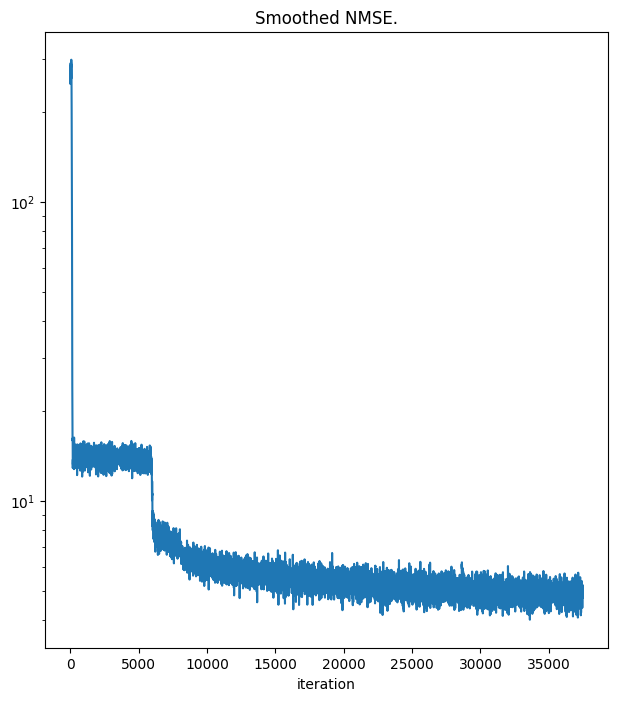

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleConvMLPModel(nn.Module):
    def __init__(self):
        super(SimpleConvMLPModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # We need to calculate the output size of the conv2 layer dynamically
        self._to_linear = None  # This will store the calculated size

        # MLP
        self.fc1 = None  # Initialize later in `_initialize_mlp`
        self.fc2 = None  # Initialize later

    def _initialize_mlp(self, x):
        self._to_linear = x.shape[1] * x.shape[2] * x.shape[3]  # Calculate the size
        self.fc1 = nn.Linear(in_features=self._to_linear, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Apply first convolutional layer
        x = F.relu(self.conv1(x))
        # Apply second convolutional layer
        x = F.relu(self.conv2(x))
        # Initialize MLP if not already done
        if self.fc1 is None:
            self._initialize_mlp(x)
        # Flatten the output for the MLP
        x = x.view(-1, self._to_linear)
        # Apply first layer of MLP
        x = F.relu(self.fc1(x))
        # Output layer of MLP
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleConvMLPModel()

# Example input tensor (batch size of 1, 3 color channels, 224x224 image)
input_tensor = torch.rand(1, 3, 224, 224)

# Forward pass
output = model(input_tensor)
print(output.shape)  # Output shape for 10 class predictions


torch.Size([1, 10])


In [ ]:
! pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
from torchviz import make_dot

# Create a graph from a model output and its parameters
dot = make_dot(output, params=dict(list(model.named_parameters())))
dot.render('model_graph', format='png')  # This saves the graph as a PNG image


'model_graph.png'

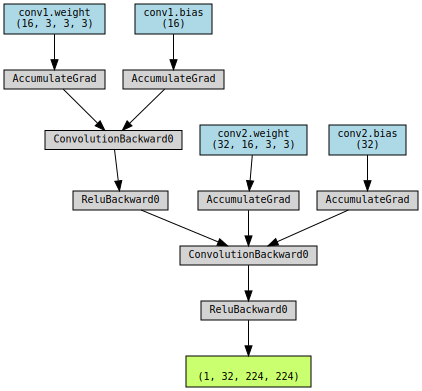

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ForwardPassOnlyModel(nn.Module):
    def __init__(self):
        super(ForwardPassOnlyModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    def forward(self, x):
        # Apply first convolutional layer
        x = F.relu(self.conv1(x))
        # Apply second convolutional layer
        x = F.relu(self.conv2(x))
        return x

# Initialize the simplified model
forward_pass_model = ForwardPassOnlyModel()

# Example input tensor (batch size of 1, 3 color channels, 224x224 image)
input_tensor = torch.rand(1, 3, 224, 224)

# Perform forward pass
output = forward_pass_model(input_tensor)

# Visualize the computation graph
from torchviz import make_dot
make_dot(output, params=dict(list(forward_pass_model.named_parameters())))
